<div style="padding:15px;
            color:white;
            margin:0;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#0f4c5c;
            overflow:hidden;
            font-weight:500">
    <b>
        CREDIT DEFAULT PREDICTION
    </b></div>
<a id=0></a>    

## <b>Table of contents:

1. [Executive Summary](#1)
2. [Imports](#2)
3. [Exploratory Data Analysis](#3)
4. [Initial preprocessing](#4)
5. [Baseline](#5)
6. [Feature engineering](#6)
7. [Feature selection](#7)
8. [PCA - Dimensionality Reduction](#8)
9. [Hyperparameter tunning](#9)
10. [Final results](#10)

<a id=1></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#588157;overflow:hidden;font-weight:500"></b>1. Executive Summary</b></div>

[go on top ↑](#0)

The task of this project was to identify witch aplicants for loans will manage to repay it back.
For this purpose was available complex data consisting of:
- 7 *.csv* files relationed with 3 different primary keys;
- 232 initial features;
- 32,857,652 total number of records.

Performance metric I used ROC AUC. It will help the business get a better understanding about how this algorithm can be used in production and the deployment options (canary deployment/partial automation/full automation etc).

The data was split in training and test tests. Test set was used only once to evaluate final performance of algorithm.
After initial data preprocessing, I have trained various models and tested performance using crossvalidation. Most important results are as follows:
- **First iteration:**
    - Logistic regression: AUC = 0.7459;
    - LGBM: AUC = 0.7550;
    - MLP: AUC = 0.7465;
    - Other models (KNN, Decision Tree, Random Forest, XGB) scored lower results.
- **Feature engineering** with featuretools which resulted in 1759 features:
    - LGBM: AUC = 0.7739;
- **Dimensionality reduction** with PCA: reduce number from 1759 to 336 while keeping 0.99 variation:
    - LGBM: AUC = 0.7499;
- **Feature selection** by dropping least important features. Score on 145 features:
    - LGBM: AUC = 0.7748;
- **Hyperparameter tunning** on 145 features using *Optuna*:
    - LGBM: AUC = 0.7809;
- **Performance on test data**:
    - LGBM: AUC = 0.7906.

Oportunities for further improvement:
- Try to finetune feature creation with featuretools;
- Weight label classes;
- Try to tune hyperparameters for other algorithms that performed well on initial data: MLP. Logistic regression. Then ensemble them.


_____

<a id=2></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#706677;overflow:hidden;font-weight:500"><b>2. Imports</b></div>

[go on top ↑](#0)

In [61]:
# Data manipulations
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import missingno as msno
from IPython import display
from sklearn.tree import plot_tree

# Tools
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.decomposition import PCA
import featuretools as ft  

# Modeling
import keras
from keras import layers
from xgboost import XGBRFClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# AutoML
import optuna

Import utilities:

In [3]:

# Decode images text->pixels
from base64 import b64decode

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from time import time
import numpy as np

# Rename dataframe columns
import re

# Disable display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)

# Disable scientific view for numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
np.set_printoptions(suppress=True)

from warnings import simplefilter
# ignore warnings to clean up output cells
simplefilter("ignore")

# For multiple pretty-prints of dataframes from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

<a id=3></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#6a994e;overflow:hidden;font-weight:500"><b>3. Exploratory Data Analysis</b></div>

[go on top ↑](#0)

## <b>Files description:

The dataset contains information about aplicants for loans wether they were or were not able to repay it.
Following files are available:
- applications.csv
>- This is the main table with TARGET column;
>- Static data for all applications. One row represents one loan in our data sample.

- bureau.csv
>- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample);
>- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- bureau_balance.csv
>- Monthly balances of previous credits in Credit Bureau;
>- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- pos_cash_balance.csv
>- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit;
>- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- credit_card_balance.csv
>- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit;
>- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- previous_application.csv
>- All previous applications for Home Credit loans of clients who have loans in our sample;
>- There is one row for each previous application related to loans in our data sample.

- installments_payments.csv
>- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample;
>- There is a) one row for every payment that was made plus b) one row each for missed payment;
>- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- homecredit_columns_description.csv
>- Description of columns from each file

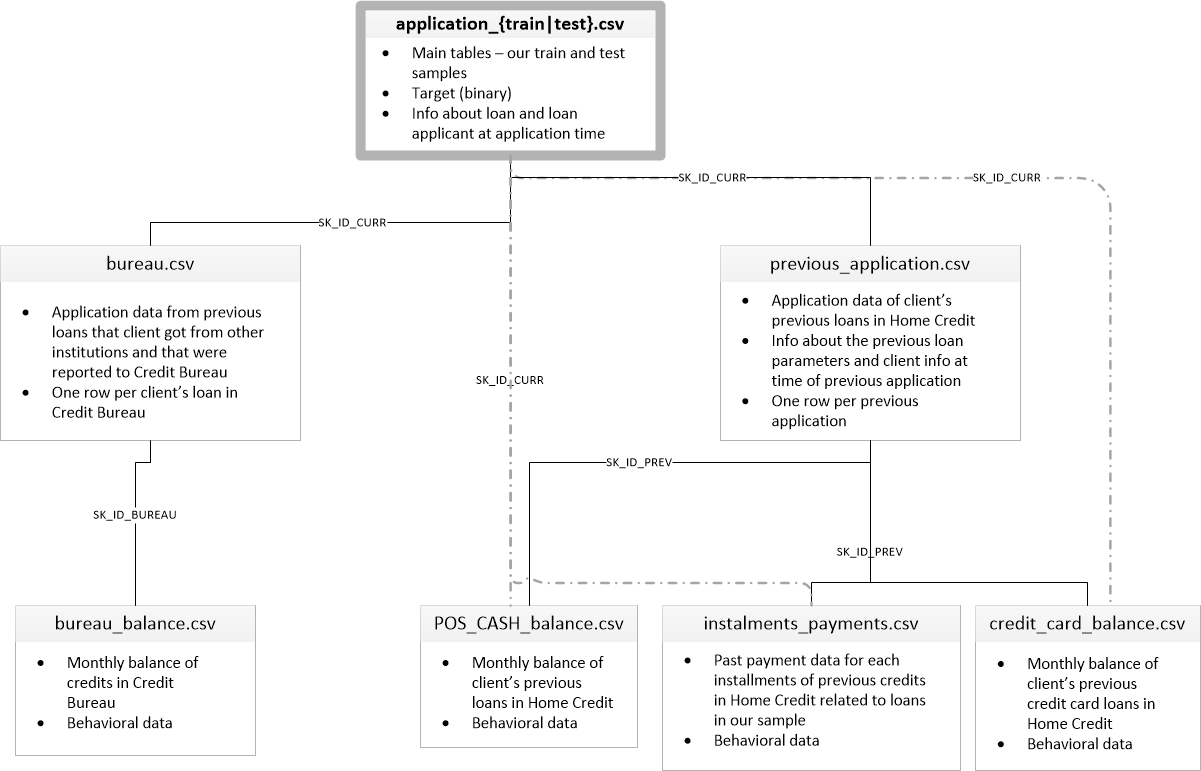

In [3]:
# View files relationship
base64_data="iVBORw0KGgoAAAANSUhEUgAABLEAAAMDCAIAAADSeBDzAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P29s11HdqcJc8zxxp42JfhypYA3jpyuCf4DLUXAGGci1AZMRYgO2pqWxqAnlYW4oPilBkh2kaDYgYAECYwrMgihKaEpqqiaVoCDIt6gAn0pjtiBmXofnN/GqkTu83G/zvfzGIe5Vq5cmTvPydz5O/tc8KVfiIichP/+3//7/09E1s0///M/D2tSRETkbKgJReS4/Mu//Mtf/uVfvisim8GHH3747bffDutTRETktKgJReRYIAg/+OCD4SgqIhvD//1//9/DKhURETkVakIRORY+IRTZTD788MN/+Zd/GRaqiIjIyVETishi/vt//+/D8VNENg8fFYqIyFlQE4rIYn7+858PZ08R2Ty++OKLYa2KiIicHDWhiCzmv/7X/zqcPUVk81ATiojIWVATishi1IQim4yaUEREzoKaUEQWoyYU2WTUhCIichbUhCKyGDWhyCajJhQRkbOgJhSRxczXhB9++OH/JSLL5D/9p/80rLdpqAlFROQsqAlFZDHzNeG9e/f+RUSWCapvWG/TUBOKiMhZUBOKyGIWasL/R0SWiZpQRESWh5pQRBajJhRZL2pCERFZHmpCEVmMmlBkvagJRURkeagJRWQxO6wJ/+Ef/uEv//IveR3s3WJzrm4tI9mcyz87akIREVkeakIRWcxCTfj91vKjH/3opZde4jXmN9988xd/8Re8xjxHlpd5Fj/+8Y+5tPbqzgsu5KuvvhqM4/Hbv/3byxjJfPLmwh/8wR8Mrq1FTSgiIstDTSgii9kfTfirv/qrrXmOLC/zLJ6JoZdeot/zVUT/9t/+22Qe7OPRzfNq4MIz7Scd7QaiJhQRkeWhJhSRxeyPJox+OLt0+YsJ7VPB88p8TP76r/86PTKMwTVtVKcgMwaDfTy6eS7OZUhhaio8GS0TMri2EzWhiIgsDzWhiCxmfzThj3/8Y8pvvvlmzFMTHdI+oDuvzMektBCFwTVtVKeAhFzIK6+8MtjHo5vn4lyGFKammjoP24iaUEREloeaUEQWs1AT/vPyufOcwX4OvZcz5Z///OcxA54a4bP2L2YorRLzpz/9KQG8xgwkHDeEBEMbn+DokN/5nd+p2qmZ4Vn7CYP9nIXXNR/iM4Zc+6xRxZ8ykQkOGXDVFmlSkW2Grqqlm2eYNaSCPLOyZWwVPydV+SnEM4t0140BcLZtY9LjYD/vHQZ7OagJRURkeagJRWQx69WEv/Vbv5VjffHGG28Mdf/8z/EwhvrLMagATuqYSBE8qQo15k6rjKXLK6+8MmkxkMwffPBB2x3QJDrh93//9wfXc5JtnHkciWeoe35dXUfthc+HhmkSc9ao4ucaMzzAOefqqgm0JhkQY/FDGx+SP52GWUOCbgCU6/2i8Bu/8RtDxYtX0VKpGEY8czRb9+Gh7dS3klHhTJmLnTR9Rn1CBns5qAlFRGR5qAlFZDHr1YQ5cHNShzq71/OcmIGAofRcA0QTBtq2ATn3x8PrJFlv1nG/2qYqaiHO+CE6AeVQngQQjD9OXp/lbfRGN6of//jHCRjsCW1Ap7WmwlVHOFV3s0bVyh6aUFXOqVfXNulMSIaUk79IHl4He/aQ6i2LsxLmHa8mVUX8rFQhYTinflBJm4bQ5qxhcFFJzivxJX3THNKkVYnLQE0oIiLLQ00oIotZqAm/Wybvv/8+Qohe/vzP/5xyTuSUUxvz13/914nBxB/P7/3e77UmR/ZJ+HelYUiFWcf91LYmCSeBL/3Wb/1WahkDzVMAAsgPeZJZSSANExzmZ8bzK7/yK3h4jScBdV2vv/56PHSXgDkkkr7Stoi/HVXNRuucf3XVpDMZYTy5kHY2oL38lknTF3qv7tI7JOaP/uiPqE05by7Q8O///u9TTlWbKnAt6R0GVwOpUkVYechZ15U5pDYDqE9gPj9EtubyUBOKiMjyUBOKyGLWqwlLDrXU0b8zodUkpSgopLYO8WnSaZXWHLct0AmJ7Biqp41qYeYSITFTrgxzBjOmxlY6LcTZjqrrNMy/uq7JOEN7pcVUJ0yavjCkeMYkph7T8S4j0lrRG3+bKpSKG/cOswZWnxOg03bay0mZMcRM1fJQE4qIyPJQE4rIYtaoCUsLAQf3nOChjv6dCYnhlfJUKRVPmrTBnTm1bUgY/Pqv/zrlqFAYqk81KoLjjJlyZZgzmKl02UI87aimhs2/uq7JOEN7pcVUJ0yavjCkeOiU4JZ6EFc9hvr4xWxThYy/HhR3kJlaXge7gcypDZWhHi1SZoraquWhJhQRkeWhJhSRxaxRE5YAqCdCMevoH7N+TEhYPDmml5QqRVFPjfIMrZMErVlt26dt+aVi/O0vGOOJCTFbfbIwMwOOM2bKleGkmrDiB3tCPO2oxiOHeGZd3XwT2istpjph0vSFIcXTqaxMe1uo97EiY7apQvztvFGuD20Ghm6MCXyEoO2x3po4aRuzHhLWp2t5qAlFRGR5qAlFZDGboAmRTxzlc4KHOvrHBDwE5K/RIHKrpBHg4eyeBzuQ832nVTpzEviM9I42SFWclHGWMIC0gpgMhoAIhi5zPXxL5rrMUmIx6zLrQijEM5+p8fG0o6p+ExDimXV1XZNxhu5Kw1QnTJq+MKQSYGTGCXkuRyHxBFAmuHsA+KzNi6mAdzn+NIe6onxuy0xD3g7SUqB3Cnl3MgAooVhvH1COc6moCUVEZHmoCUVkMWvUhHWm7+DInoDBfpHSHhzoB9eLVPNOq3QmkmAS/ktQDvhLJHSkFSRPSLYuM6IltS31L8pAPDXOuhAK8cxnavx4VOSPmYAw/+q6JuMM3ZWGqU6IP6SWGWgVVxE9NhgN3RO/UB2N56EGHA/d1dcEBTlbMRxKfEI7RZQH7zJRE4qIyPJQE4rIYhZqwqNl8tlnn3Ec/9f/+l//m3/zb37yk5/8+3//7ylTSG3O5TjRb/jhD//wD1MFf/Znf5aAapgkQ/XRUZy8TjWBDOkdyPzo0aP4KceJJGCEFMicKiAMfwLIgGec+csvv4wTaMv4h4oJePDXUAlOJH3FM5+68PQexqMiP+V25GHO1XVNxhlyUTQc7Al4GAyvg/2c8ZDiZACZAV7baWceKp4CZvwwNdV4HupyKme6S0Pe64rkHakxdO9OvR3QjmF5qAlFRGR5qAlFZDHr1YTzyYm/1VotY0mwJ6BzcuHMzGpEy3zQTgyG18FeCVw4l595KAW4pagJRURkeagJRWQxasKNAqnD5cyiFGBkGKxYiU1lLZpwo2bgjKgJRURkeagJRWQxasKNop59TaWm4tGjR/nV66zJWSVr0YRcOD0yCdv+kBDUhCIisjzUhCKymIWa8L+tj/zF13/8j/9xsF/k7/7u76gFCoNr+/njP/7jXNRUqB3iNon8wd7/8X/8H4MtJ0RNKCIiy0NNKCKL2WRNKLIPqAlFRGR5qAlFZDFqQpH1oiYUEZHloSYUkcUs1IRPRGSZqAlFRGR5qAlFZDFqQpH1oiYUEZHloSYUkcUs1IRDnIgsBzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi1IQi60VNKCIiy0NNKCKLUROKrBc1oYiILA81oYgsRk0osl7UhCIisjzUhCKyGDWhyHpRE4qIyPJQE4rIYtSEIutFTSgiIstDTSgii1ETnhcvv/zyrVu3BqOBMz1VX3/99WDLcrh06dLU+d981IQiIrI81IQispjt0oSvvvoq+urq1auD3YAeoOrKlSuDPYPLly+TZDDOlZdeemlq5k8++YQqXgd7D+BiVy+DZ83/5qMmFBGR5aEmFJHFbJcmRGlcuHCB0//R0dHgek78MNgzIIAkg3EMEDbEH+dcTuYd04THv/YORPvqL3nq/J/6EsKlS5du3LgxGEtDTSgiIstDTSgii9k6TXjlyhVO/92jwlu3buFM1eCaASfsEz2/Or6im6pJYHs14alHjmJf/fVOnf8zTv6s9/R8UROKiMjyUBOKyGKWoQmRBMgz9Nvly5fP9weE5OSMTtoLFy4MrgmXLl3Kj0I5xA+uydMq4qEVkAysTvlUceBOGBnGh2+k5sWLF8nJKzH1yGhq5ugHYvCTrXRIJ0uYHMLSvH0GRQCtOudJIQnzQBJStX9ch6cz0wuXTJn3KF2nNky9dgp0kTc308VreuS1JrDSVrn9SIyf8YZZ7xddM5iMsL2Kmsl0nfkf6iZMvQSg8KybyWepBsNocyFxYlKmLZ80CgwjYcuAwQ/rbRo1qyIiIqdATSgii1mGJsxBvDhHWZgjewRAnZXJj4lWoYpCnEgIjvg4EQY460xPBkgZPyd+IiOlMDu5gok+wc8rMamdlZkyJFtGQgE/r1UmA5OTGJQJ/jTPJaSX1D7LeEKSkK5pngHwmqq2DGUSSZlJoOuSTGHqtSeYy+faGTNvASYNCcgE5r1OWl6rTFgGFnn2rIMXmTWrBNOWVvgznqQFmsTPAIihqr1GmHoJ9JJWQAESnOsijCTJQ5m2cZ7jZ3iMmlBERJaHmlBEFnPumjDKpKU7qZ8FFEKy5QQfJx7MFOguzvYQj790CIUqE1xJEAyYnS6CCANeB3t2ZsJQKSkDYiNmmwFxUiIEkCVUUUhMnBD1clLIkMkJ7Wx0VWWm37aqpR15wKzrBcbZDrWC24Yp18TmkscSa877lTc3MHt5y/K9ANnijzm+kHYkkLAaM4WqbcMqYGrOc0dNKCIiy0NNKCKLOXdNyBmak3TLOZ6qUQjJluc/ObujGTAppOtncZNjPU7iIyrKH0/K3dimDrUTFTArc9f8yuSnkhTaDHgoT5o+A4WDSUIUUfxjUQoJHtMGj8fZeihMvdJxq5ZxbZcHqEWkZTxT03ZJOrM4zvsFZearhzgDZjc26LojADNJAmaEJe9FPkj5UIWpOc8dNaGIiCyPF26WIiJTOXdNGHnTMlXnnA4O8TmjpxcyRxvkHJ8T/yTw2REfOO6jBxAt5Y8SSBlne+LvzDDWMLMyd80pp6M2Ax7aUm6ZhD+7omRDmXQyYIgb0T5bw+zG2Xq6sZU5btUyru3y5KEfHmISPE7blsdmMWtWJ2/XFE1IRxUTMNuxha73tMJsyYeHV2ojR+sTOzXnuaMmFBGR5fHCzVJEZCrL+HvC6LRQfxh2LqAH6oyePyfDg4SIJyd+Chz0KfDa+WGiKU6gCTmRt6nmZO6aM7x01DZhqIx5Uj8dlAmypP0N6jGJSM4jrxDBFt3Yja3M7nI6umuHLk87mTA1bddFZ4bOSRLMlLsuyszVLXym111C+w3CLJj86n1qznNHTSgiIstjuKWJiMxhGZoQOHZzEG8fZJ0L6IE6o0cVwFhLRAlEIDESZFj8UKICcLYn/s4s8NeDozmZKUBO8AlLq1bwpJzmwPykRyLr6E/OU2hCyKVF8GRsdaVtzjyFS7/t2KZSVxGqYSAnmVOO3Bqn7brozHDM9wvKJIyYGkx7UR346xLSqr6nwEyZAVQMnrb3+sZhedD7sN6mUR8MERGRUzDc0kRE5rAkTbgkOKO3537O7heaf4CEqjrNRyQQz2vK8T+TFCfUhHlwRKvUzspMIXKiquLvVFAGGcFGIVIkMXi4HDidDKAVbZMnr2ieVCU/nRLAIKnKtXRjG9NdO+V2iugRDznJHMZpuy46szjO+wWtGRVKp91FdXSXkK8SaIKHQjQh4jzjB5ylD69O/myVyFLUy0BNKCIiy0NNKCKL2S5NyPm4ffbYmZTbAzQm2gNdBOVvm6Q2ZcBss7XQqpUxUzOXp8sTz2BMiKdzwlTnSclQxxfSDqwmYTy2Me21U6BJygXOTAKvqW3Tdl3EHCeBqbNaQw2YVQVE0qS7qDFUtWMATKD5YE9IWOesUQ32EqDfYb1No71eERGRk6ImFJHFbJcmFNk91IQiIrI81IQishg1och6UROKiMjyUBOKyGLUhCLrRU0oIiLLQ00oIotRE4qsFzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi1IQi60VNKCIiy0NNKCKLURPO4saNG0v9P5WLBDWhiIgsDzWhiCxGTTiLV1999aWX3Ehl6agJRURkeXiUEZHFqAlnoSaU1aAmFBGR5eFRRkQWoyachZpQVoOaUERElodHGRFZzHZpwk8++eTSpUsvv/zyjRs3BtcvfnHr1q04r1y5cnR0FCcBmJynL1++TNXVq1dxVnOaJIwATFqhACkQXEfwThNWW2K+/vrrwTvpCCdVBAwukZOgJhQRkeWhJhSRxWyRJkSJIdJQd5Fn0WCY0XiYFyckOIoOkypiKNMkJloRM0dtWiWM+KTFjLBsNSHCjzKvFRNZGD85oboWORFqQhERWR5qQhFZzBZpwui3wfjFL6Lc2kd2bUAUXdWiGy9cuFBPEakigEKa5CkiEFBmqwkpoPpShmhICrySOc5KLnIi1IQiIrI81IQispite06IBrvR/HAUMC9NftWJVCMAmYezVXRALQzGxGw1YZqEqqoMiSH5JMczMK9cuUIVQpHy5cuX2wwiJ0JNKCIiy0NNKCKL2a6/J0QWIsCQYRcuXMhZOT8Eza868xvRyLNz14Qkp1DUE0jK+TUpDX1UKKdATSgiIstDTSgii9kuTRiQXmhClBhlxFgkHCDPSuCdWhNWwsqQ55Ptb0fHcHAnpn6DKnJ81IQiIrI81IQispgt0oQ3btyo8/HFixdLE+ZnnJBHiKfQhGTLI748acwzwDZDmtdjQMIyEmLi5JVgNaGcAjWhiIgsDzWhiCxm6/6NGbTZhQk5K+df/kTU4Tm1JkxDnLzWHyu2Gegrf6xIDB3x2mrINCynyIlQE4qIyPJQE4rIYrbut6OouKi+AiWGJw/3qgqzPUx3JuWKR86lOa+tqOuaAGZ1VKT3LlLk+PDhGdbbNPxoiYjIWVATishitvHvCc+R0oSDLbJy1IQiIrI81IQishg1oZpQ1ouaUEREloeaUEQWs+eaML/8HAyRdaAmFBGR5aEmFJHF7LkmFFk7akIREVkeakIRWYyaUGS9qAlFRGR5qAlFZDFqQpH1oiYUEZHloSYUkcWoCUXWi5pQRESWh5pQRBajJjwLR0dH+X/fwyeffHL16tWUV8/XX39dI5HtQk0oIiLLQ00oIovZIk2I5hmzRhkG9H7hwoWUGcxLL03feG/cuHHr1q3BWBqMhI4GQ7YHNaGIiCwPNaGILGYbNSHi5+WXX0552ZoQLTdHaDGSGgCDmaUJ8TPgwVgaV65cuXjx4mDI9qAmFBGR5aEmFJHFbONvRyMIB2PJ0NcsOcdhHbFXR/Y5mnA1zwnz/9//+uuvB1u2BDWhiIgsDzWhiCxmSZoQCYRGWtJPGadqwvR49erVVhThwUxV+RkVZlF+NFXnyU9DIf44C2pbEUhAzORv/1f4rSakivwc9CmQ4ejoKH6gnLa8lp9gPBQITtqYRZucAWCmLNuCmlBERJaHmlBEFrMMTXj58mXESbh48WIre86FsSacPMx75rx06RKd1jGaMn7GcOXKlTgpA5H4qcUfBciYo/0y+CirVhNSfpaxgb5IMhjPNSHJyUDaJE/Vs8E9j8RPw+TMYOJnGDhpW/7MW57+0ZxW1HIVmCUCAbPGRlh1KtuCmlBERJaHmlBEFnPumjAapmWsps4IygfhNBgTWo2EmqpaekdolSjN2MqkHO3HaxvGgKlK+ZmYm/HbUfyItMF4rgnrMR0FzAjONglOyumLWswMnnKd/qnFnyeNGTOCMFUQ6ZgybamtkbcdybagJhQRkeWhJhSRxZy7Jow0aun029lB9oxzoo5wApKpFFTX+yxNWA/uAoqrwuaorG4YlGk1GM/1XnRdmwRn26o16ZHxYAL+aOmMOXlCalNmqK1cbDuSbUFNKCIiy0NNKCKL2YHnhEipixcvlqijULqI3rtIPHmQSEz9PpNyqwlDmlAFKXfgrzCgTPLBmIB5fE3I0Z9yckL5x5qwni7mcurJJLQdybagJhQRkeWhJhSRxezA3xPmp57VS6uL8LeRyCfGk2dxvFaTSy/+ZWBLm60D//i3o4Nx8ueEjIGxxQnlH2tCIBvxXAJV7fS2Hcm2oCYUEZHloSYUkcUsQxNCfsnZPsI6R5A9rayijDRKGYE05zlhIq9cuUIBSmhFXKHiYkL+xg8Ia6VaS6ckiSRJXXKrVJ8JtUWasI3JM8P4p2rCDJj4VpTC2CObj5pQRESWh5pQRBazJE24VFA+razKE7k4EYRIuBJXpawCCg1PNCGvCU4VTaoKf/3rnVFfmGOtRSRVgzExaQhEEk9V6UOSzxpSmfnXYtI2eeKfqglzIVDaNeA591/qyrJRE4qIyPJQE4rIYrZRE6K1Oo2ELEQLIaI4QFPVPuVrj9SYpc0gcqsC8myzawKE4SyBVxDWNieMGNRajSR+wD9nSHUt+DFpzuXQJGGUceZ5Y8ulyf91YzAm5HLap52yFfBGD+ttGu2nRURE5KSoCUVkMduoCU8NgrB93IfuQkSN5dbxuXDhwrqey9F1PcwMmLN+5iqbjJpQRESWh5pQRBazV5oQ/YYIRBa++vx/OHFGRUdztNlgrJD80LRTC4xk/DBTNh81oYiILA81oYgsZq80IXDCRsjVTzQH72k5Ojqa+sPOZfPJJ590ajY/MR0M2SrUhCIisjzUhCKymH3ThCKbhppQRESWh5pQRBajJhRZL2pCERFZHmpCEVmMmlBkvagJRURkeagJRWQxakKR9aImFBGR5aEmFJHF7KomPDo6+uSTT85+nv76669Xdiino83/vwsyyPG/qbPKWdo9mLphvU3DiRURkbOgJhSRxWyXJjymaiLmpZdeunjx4tn/RxGvvvoqqQZjybw8YTA2FWZj/A+crnKWdg81oYiILA9vzyKymO3ShEim4/wfF87xfxt47mpnjqxVE+4nakIREVke3p5FZDE7qQmJOS9xde5qZ6qmChNJqCbcO9SEIiKyPLw9i8hilqQJ8+d85/7XcUimEiT1wI0CfcUJlC9O6AaQsPlDSkz793KldmjYVYX4u4N7F1n9UiDb5cuXx01grAlnjTmdtv5MeBXGTVoISHBBR2mSHuMs2pzH1IRpMk4FY//83ncernpYb9OgdogTERE5OWpCEVnMMjThjRs3UAjhypUrg/c8aDUhZcRV5N+FCxd4jQzDn64rmFM1AZCqS5cuJbKFmKRKDJcQf9QOV5Eu2iqSJDiv1NbxHbMVTjGRPYnMSNqAgBNSnjVmXimXnxlIPFIK8+rVq7ymqsbZcuvWrQTkWmrAeKZOJqRJ/MRQHo88szQYv/gF05VeaEKBDPGfovd9gHkY1ts0apZEREROgZpQRBZz7poQ5cNxv2WqODkdiIcSJJRJHr2BhKCMIqoqSDlVpZ0yvLGqYZD1hCrKKuWonWoeM4qFLkq98Np22nXRml1VS2WYM2YUQl0mZfwZdjQhzTOejHMS9QL480QO0JbpDigQP57MlGvAx9GEKZeSiT6sUZ2o9z1BTSgiIstDTSgiizl3TRhJ0DKWEKcG8VDZKEPK0JptGbHHGKJJQh76DcaLcP5GXEUTRr3kclILJcOi0+oJGOQhWFpRaK+6Nbuqlhr2wjHTC2MAwiK5U+Y1AZ3ZgR8QeJWzug5lEkaeEnKAOR5/O0vkZLQpQzRe+73A8XvfE9SEIiKyPNSEIrKYc9eE0TMtsyTQKUAqVLZOObRmW27lShh7gJM3EgVoeHHyy0Z0C/5xcKqgYkLrodBedWt2VS017HGn5UFiEUM5wZWtG09nFnl3uEDacrGU40+2lKHM8Ugwx+Nvw8YB5Tlp73uCmlBERJbHC3dxEZGpLOPvCaOpivYp0xlBKpTe6JRDa7blVq6EsQeQKJcuXUq5FVRdcJ56UdXGhNZDocYJrdlVtdSwxyMsTx6v1SPEytaNpzNDnm3WzzLbXqrrUGYemcYZMMfjb1ONA+I5Re97gppQRESWxwt3cRGRqSxDE6JYrly5wrEeAXOOghDIWXpjIhymC4m2zJEa7dGqI6pK/hWtksmvQNMk0qXO5XN+INqKnLYqAygTwdy2aqlhzxlzxUAEarJ1IrAzQ+fMX/ql3KaFMruRdNdS4KlU7R8KQjql4Sl63xOYnGG9TYPaIU5EROTkqAlFZDHL0ITLA6lQgqRTDq3ZloHyhQsXbkz+FRkUSyTKUPccYlBrSD7C8rPGqJeoHcAfQVh/LJcqXolMmZhURfBUNqhhMwBMmlAbTzEZ9S8vgbDxmKsjmud5bDITRjljHpshGpJs+JMHUtV2Da1JL+3MQF1LkWwpp+vLk//fBk1Sxn+63vcBNaGIiCwPNaGILGa7NCFaC5lR5VacYELK+KsMqJGrV69GaeCf+uiyfbbJKZxCwugOPx7EDM766WOgNv5IoME7ycYY4icPGWrYmDjHqYCwuqI5Y46fftFpVEVbtmMucywn8KR3GjJgksTfdg2YkHI7M921FJmHwZjIwvSCsw0+Re/7ANMyrLdpjN9EERGR46MmFJHFbJcmFNk91IQiIrI81IQishg1och6UROKiMjyUBOKyGLUhCLrRU0oIiLLQ00oIotRE4qsFzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi1IQi60VNKCIiy0NNKCKL2VtN+PXXX+/tafuTTz45OjoaDFk3akIREVkeakIRWczeasJXX331pZeGfZJjd/s/hd95uPD6f8Sflz5c6hzutohVE4qIyPJQE4rIYtSEQOHll19O+bw4xXNIZA/iZzCWSWlCRtjqwxPRicDzncNWBJ5lkFsBFzist2mc9FMkIiLSoiYUkcWoCeHy5cvnLjkQSCfVSO2QlkpJLHQXg7x161b8J6LTaec4hwhCkpc8PssgtwI1oYiILA81oYgsZus0YR6mdQfleqzUVSW4Cu1zrVaA0aT73SPBadgydlZDCm0V5sUJ4yZFV0UeZFW0EORyOtJLW0UrnCl0VbPGBq2c61plopKzSPJkC5gkYcAVXN0VadWlwpPuxlWB2qtXr5KcV2KSs1pleFWIE9JXmQVdVJKNhUEO620aU2dJRETkmKgJRWQx26UJI+RefvnlCxcuoLhKA0RC4KSKclWhBzBv3LhRVciYNGk1IVWQ8q1bt5IBaBU5EScxOCnUMR0PCSuY1/R76dIlwtKEcoKLqdkYDxnih07GEDPp5CJVxHBF8dMKz5UrV9J7WxU/r/iTuYZNuTRhW86c0IR4XvFwOYw/JlWZPcYWM/40pwDPskxaUU4qXhlA13VV1dtRMDm5kFxsHg+mFYW8oXmvE0ZALh8wq6OMAWc6Iib+DYQxD+ttGnVFIiIip0BNKCKL2S5NyMk+ootXjvslZjj0lx6ginIrIRAPaRWTV8pRJhQA2QAU2raAvkpOPCXS0EgJBgrER7ekLXKlqiqsY1a2dkgdjCTDhjxGSzlNOqGbiyUt5VYiVkf4iezK7eRARBSXX1dEuQ1ok0Cbn0LNOa9tFa144zKr6THllm4kUH2liklLcgqYdflkrjI9Vjkjr6nYNBjesN6mMZ4fERGR46MmFJHFbOlvRwHVUYf+0gwBf0RIJASv8UMpSV6pinOiWZ7FIxtwRm+MmXT7CclJEk81DK3ZlqcyztYOaSrIA5pEE0ZVdk1wYhJDuRtALi1lCjVdVWYkTGmcHaSdDPbZZJayapNAdZcxRCcHyngy4K5VZ4Z0xOtgN2FdFU7MlCHPRSlkDEwUkYFLG3e0IagJRURkecw7WIiIhK17TshZP/Ijhfgptyd+yqlCDFDFa/yAP5GtnHiWbhLfOlsiqNAVhCHhxg1Da7bljlnZZvUOCAMigSY0JCwXNW5SVZP+fzmATEXKFDIJbbmLD3nKR0xqpzYMCaAwnvPW07XqzDDOUGFdFU7MlAGzHUNmuKgHnpuGmlBERJbH9IOFiEjLFmnCSKk6Iuegn3JphlDPi8bqop4XtXKiUnUaI9RDp5hTG4bWbMstc7JN7T2gBi89/7vE9qK6Jki4quoGkId1KVOgYVfu4kMeY9aD06kNQzUfz3nr6Vp1ZhhnqLCuCidmyoA5awybjJpQRESWx/SDhYhIyxZpwk4A5ClQyvhLMgEyBjFDIdqgBFj0WH792GabyJlnqSKc2lN4fqqKswRGnlWmXA1Da5Yu7ZiTrZVtHfgjiiBhyZCrqAFHNudXmvTeyrn2R6pttiq3I4E0nFzQcBURnNWw1HVoI9swoFyZu6rODOmopggqrJu9NjNgzhoDOWEwNgw1oYiILI/pBwsRkZYt0oTRAxz0KeQfF2kFAOCkCvFDObooTSCtkDGQJq2cmMiZIVVi0F1AgVaRKEmeVlMbQmsiRAkjSSRoMScbp3/KOGmV8RekzajIhrQjjOb4kwEPfmopI+2qCWZa1WBSRZmGXTmCOQOLtsSZ/ElOqrYhkfRLcNJOLn249rTita6xJqHNAJ1Z4M9IIGbCMCnHCUmeMmBOHUMmbWPFlZpQRESWxy9vkyIis9iuvydEfiAVOPcjcjjoRydATv9AFZqwjtGRELTCSRV6qR4W0ZxUKeOvVAQkD7WlZEhYGcg5tSFgQsqVh4bxFLOyAT2m604Tko3gZKM5hQTQBReIhyY464koYALXziu1UW4h/nGZnBkYr6W7yFkZGMM4OJ1S1U5FprdLBW13gFmT3JJpoTZtq1V77YATM2UgVc0/UDt1DJsGFzWst2lQO8SJiIicHDWhiCxmuzThLKIJB6MBJUDVJuuBMxJNOBgvghZq9ZJsLGpCERFZHmpCEVmMmnCrURPuAGpCERFZHmpCEVnMbmhCxE/7i8SC8zRV3e8wd4n8RHMwXqT7MadsLGpCERFZHmpCEVnMbmhCke1FTSgiIstDTSgii1ETiqwXNaGIiCwPNaGILEZNKLJe1IQiIrI81IQishg1och6UROKiMjyUBOKyGLUhCLrRU0oIiLLQ00oIotRE4qsFzWhiIgsDzWhiCxGTSiyXtSEIiKyPNSEIrIYNaHIelETiojI8lATishi5mvC27dvcyQVkeXxl3/5l8N6mwYBw1oVERE5OWpCEVnMfE0oIutFTSgiImdBTSgii1ETimwyakIRETkLakIRWYyaUGSTUROKiMhZUBOKyGLUhLvE9evXX3vttbfeemuwZftRE4qIyFlQE4rIYh4+fDicPWX7+eM//uODCYMt24+aUEREzoKaUEQWc3R0NJw9Zfu5du2amnDH+NnPfjasVRERkZOjJhSRY/Hhhx8Ox0/ZctSEu8fR0dGwUEVERE6OmlBEjsXPf/7z4fgpW46acMe4f//+sEpFREROhZpQRI7Lf/2v//WDDz4YzqGytagJd4l79+79v//v/zssURERkVOhJhSRE/Av//IvP/vZz76Qbab+jZnBlu3kyy+/fPLkybAyRUREzoCaUERkv3jjjTeiCQdbRERE9hs1oYjIfqEmFBERkRY1oYjIfvHee+8hCF977bXBFhERkf1GTSgisnf85m/+5rfffjsYIiIist+oCUVE9o6XXnLzFxERkQGPBSIie4eaUERERAqPBSIie4eaUERERAqPBSIie4eaUERERAqPBSIi+8XR0dHv/u7v3r59+4cffhhcIiIisseoCUVE9ouPPvoo/3/CBw8eDC4RERHZY9SEIiL7xcOHD//wD//wP/yH//Ddd98NLhEREdlj1IQiInuHf08oIiIihccCEZG9Q024z9y6devVV1/95JNPYn7xxRc3btwYl8fQMK2+/vprMgScqZ3D0dERadtg8rQdkbDMREIbQHycV69eJdvgFdkG+HjzuW0/upRxjssdxPOZT7nWxZz4FtZyF4zZNiRhTF4niZ/RBgyuZq+Q3cZjgYjI3qEm3FuuXLly8eJFznkvv/wy50U8KVPgOMgHY875jzCCKfB64cIFXlMg4RydRlpiLl26RDAZGADOlBMAdFomY7h8+TIBpC0nBcBJHgKUhbItZFnxsQcWQpy10HDWh3wMMUSmXOuCV8rtNyZjCKOv6jRKrzoN9BszwbwSXDHpGiekMGkku4zHAhGRvYN7/FD6xS9++OGH2xO+/fbbwSW7Sx0E4YsvvuCV0x5OVBYabP5BM6qMQprECZQ5pw7GiKjBwZg8bOS1y8CQyqxTKUOiHPlXXQPjPM7DSZFNoP1sZ8VBPuQst/nfpxBTe3WtC4i/fabXQi+1cGIu1IQ1wshICm3XLDfGmbLsMGpCEZG9o2728Pjx4/wzpPDRRx89ePDg0aNHp/jnZ2g15kR5CB6avchQfTyGNi/iMAI5OfBxvGuPhjkRdsptKiXM2kMkcGSsByBjph5euwyMp8w6uUYTxlldQ8af+Ymn4+nTp0OpAWcmoeP7778fIo7BkydPhmYNrKCh+hg4jJZ9GEaeE/LpbbUfnqtXr/I6RxBCK8wotMuWVTDrGxz6mvodTZeBNRWzXYzsD1lobdcs8Ha1HodzfFNO9C7IWVATiojsF/fv30f+/bt/9++45cte8corr/AB4MyHhOOQV88JMamthxizKGHWHiKhPT6OmVo1zlAm8fmNXH7PFie1kFaAh2shUlbJr/3ar+XtgGwjU3n33Xc50A9xExL805/+dLAncNb/kz/5kzQZMzV4VuapbMgwWFaQ3zzX55kyH2+cMWfRriwKkXAhy2EwXgT/1KpxhpgEZ62x7ijkG5x0jROViDNP5v/bf/tvz1o+h9l48803b968OdjPuXfv3nDxI2YFP3z4cLAnJHOaBKb9o48+Yhiff/45tUOcnCtqQhGR/eKdd97hFnvt2rXBnvDkyZPDw8Pr16/nBlx0d19icPI62BOISfBUZgVPzTwLh9Fy6mFwch2qf/GLnP8ocOzjdHj16tX5P2ODOoamSZww/6dlnCzHabsMHEDLJJ6x5SRaMpVaoBXOPB6pU3g3G7dv38bZzca3336b4KlwKh3iJiT4j//4j3/44YfBNSGZpzIreGrmWWz+MHhrBq+zcexhoGESw4eZCcynl0Kers//tXaEWcoUWkXHiotOG8Myye8/O7oMLKiYWVa8krMapmucCFcis4S/+eab1IbHk9+YIN46hczAcu1jZgXXLIVknsWnn346xMm5oiYUEdkvpmrCov3JIgegwfscTkL4u/MQEJkmY6YGz8o8lVnBDiMcfxi8uXUozJmPAsc+znwUUGIwqZxOVBmFahLm/+6Ug2ZbG5mXA3E8wEm0uq6Ta9tLdZ1hc0LNB/Uss1F0h1Qg+MmTJ4PxnDlvyqzgqZnTZMzmDyMfmOBstMwZxn/+z/+5vhOpj3E+5KyF9ouPMbVIodYFRF7O+gaHxdXWUsijP1ZiSVCcxMRfCy3O9NJ2XcP+//6//y+eAvE2no3vv/9+uPgRs4LH80zmNPm7v/u7+/fvI84/eg7OIWgCk4+kZEMYbDktakIRkf1iviaU3YZzHuqLEx6H0TwTaE+EnBrzj5FOpY6Gac5rCrSqA+iYnF/TKRnqQQStkpCqOp5CnUrbE2p13ZVllfB2DCU5NiyoLJb2c14fbEQatbOWTyvMKGQRJc/8B4zEpFOWG4V0Gq2IBz/OWomYrKmu3Had8pw1vl7u3r3LHe327duDLafF5S0isl+oCfcZDnYcUjn55UgKaLY6X1KmKuUxnCnTiiMmYaHyzKE6JcPgmkC/OKlqj5uYpQ+rxypAO2BZJSUS5ETw0e0+5+2HnPKsRUQ8DVPOYgEK1XYO1WkbXCu37bFdUNVj2zV0eTaKf/zHf/yTP/mT7i8/5RS4vEVE9gs1ocwnp8mOoW42ddxs2dhzpJwCNeHyGBZMwyyh2FJCsfDrEjk1Lm8Rkf1CTSjzURPKVNSEy2NYMA1qwlPz9OnTv/u7v/vZz3422HI8XN4iIvuFmlBEToGaULaChw8fco+Du3fvjv/1GpmFy1tEZL947733uFm+9tprgy0icgzUhLIVfN/8Pydv3rz5w+hfIZapuLxFRPaLhw8f/uEf/uHHH3882CIix0BNKNsCshA1GFn4k5/8RFl4HFzeIiJ7h2c7ETkp7huyRTx9+jT/mwro/sVjmYrLW0Rk7/BsJyInxX1Dto7bt29HFn766aeDS2bg8hYR2Ts824nISXHfkK3j6dOnP/nJTyILHz16NHhlGi5vEZG9w7OdiJwU9w3ZRr777rvr16+jCb/99tvBJdNweYuI7B2e7UTkpLhvyJby9OnT77//fjBkBi5vEZH94v79+wcHB++///5gi4gcAzWhyA7j8hYR2S/yN/dvvfXWYIuIHAM1ocgO4/IWEdk7fvM3f/Po6GgwRESOgZpQZIdxeYuI7B2e7UTkpLhvyA5wd8LTp08HW57j8hYR2Ts824nISXHfkG3nu+++e/Z/pTg4oDC45DkubxGRvcOznYicFPcN2QF+9rOf/fSnPx0MaXB5i4jsHZ7tROSkuG+I7DAubxGR/eLo6Oh3f/d3v/rqq8EWETkGakKRHcblLSKyX3z44YcHBwevv/76YIuIHAM1ocgO4/IWEdkv3nnnHTThtWvXBltE5BioCUV2GJe3iMh+oSYUkVOgJpSd4f79+w8ePBgMmeDyFhHZL9SEInIK1ISyG3z77bfcBOHx48eDS9SEIiL7hppQRE6BmlB2gydPnkQT+j+laHF5i4jsF2pCETkFakLZDX744YdoQn8+2uLyFhHZL9SEInIK1ISyM7z55pvcB+/duzfYoiYUEdk31IQicgrUhLIzvPvuu9wH7969O9iiJhQR2Tdu377NvfCtt94abBGRY6AmlJ3h+vXrasIOl7eIyN7xm7/5m0dHR4MhInIM1ISyM6gJx7i8RUT2Ds92InJS3DdkZ1ATjnF5i4jsHZ7tROSkuG/IzoAaRBP6b8y0uLxFRPYOz3YiclLcN2SX8H9Y3+HyFhHZOzzbichJcd8Q2WFc3iIi+8XR0dHv/u7vfvXVV4MtInIM1IQiO4zLW0Rkv/joo48ODg7eeOONwRYROQZqQpEdxuUtIrJfPHz48A//8A8//vjjwRYROQZqQpEdxuUtIrJ3eLYTkZPiviE7w7fffnt4eMjrYIuaUGSruXXr1quvvvrJJ5/EPDo6whyXx9Awrb7++mvCAs7Uzied3rhxI//Tc/JQThWQsEwKydwGEB/n1atX/d+mrwvPdiJyUtw3ZGe4ffv2wcEBsnCwRU0osr1cuXLl4sWLiKuXX34ZfYUHuVX37FSlPIYmqeX1woULvKZAq/k6jYbJfPnyZQp4KONMLTCGMhkMYQQQWU4KgPPSpUsEKAvXgmc7ETkp7huyMzx8+PDWrVv+7yhaXN4i2wrKKs/64IsvvuC1NCFKDCY104kqo9ApOspzGqI82+A8V5yvCTNChF/JP2rTNaAVj/lwUs4Xz3YiclLcN0R2GJe3yLaS54QlCyGasFNuUylh1ik6FNqFCxcGYwSR7a9Aw/E1YZzVNXTjl5Xh2U5ETor7hsgO4/Leen7t136NbVr2kFdeeQVxhYRDZbXPCfHkp6RzKGE2VnRkGIwRRI4l3HxNeHny29H8PDVOaiGtIE6u5dklyUr4X//X//Xg4OD999/P5IuIHAd2j6EkIjuHy3vrcY8WdFce7kXRoQ/zmtqpRJVR6BTdrVu38leCUyFy/FPPLsNYE165coXh1XioBVrhHD91lBXwzjvvoAmvXbs22CIix8DzhsgO4/Leetyj95Z6ZBcp2BbQWki7Of98S1QZhU7RXbp0Kf6poO7a4Mi87uemxNRfJDKYDLLtpbrOaP03ZlaPmlBEToHnDdklvv/++6EkE1zeW4979N7CW1+/zESJ4SlNCFQh8FIe02pCmvOawnwlSRUBaUv+eqLYOhnA119/HT/laML8PWHK1XVXlpWhJhSRU1D3F5Ft5969e9wHP//888EWNeEO4B69tyC0rl69iqaK1oqnJFbKJc86bk37/xNWnvnk/zrIK10MrudOxtM6MWsA1WMV4IsvvvDno6tHTSgip8DzhuwM169f5z549+7dwRY14Q7gHi1zaCVfMUsoFqdrJduCmlBEToHnDdkZ1IRjXN5bj3u0zEFNKGPUhCJyCjxvyM6gJhzj8t563KNF5ESoCUXkFHjekJ1BTTjG5b31uEeLyIl47733uBe+9tprgy0icgw8b8jOoCYc4/LeetyjReREPHz48M033/z4448HW0TkGHjekJ1BTTjG5b31uEeLiIjIsvG8ITuDmnCMy3vrcY8WERGRZeN5Q3aGmzdvqgk7XN5bj3u0iIiILBvPG7IzPHz48NatW48fPx5sURPuAO7RIiIismw8b4jsMC7vrcc9WkRERJaN5w2RHcblvfW4R4vIibh///7BwcH7778/2CIix8DzhsgO4/LeetyjReRE3L59G0341ltvDbaIyDHwvCGyw7i8tx73aBE5KQ8ePDg6OhoMEZFj4HlDdoknT54MJZng8t563KNFRERk2XjekJ3h8PDw4ODg/v37gy1qwh3APVpERESWjecN2Rnu3r2LJrx3795gi5pwB3CPFhERkWXjeUN2CX872uHy3nrco0VERGTZeN4Q2WFc3luPe7SInIijo6OPPvroq6++GmwRkWPgeUNkh3npH/7hH/5Otpl/9a/+1VCS7eT27dvDchRZCR9++OHBwcHrr78+2CIrwfPGtuN5Y9vxvCFzeImPyL+IyPp49913h+UoshLeeecdNOG1a9cGW2QleN4QWS+eN2QOakKRNeMeLStGTShrwfOGyHrxvFE8evTozp07jx8/HmxBE37xxRf/j4isD/doWTFqQlkLnjdE1ovnjeLmzZvcBw8PDwdb1IQia8c9WlaMmlDWgucNkfXieaO4fv0698G7d+8OtqgJRdaOe7SsGDWhrAXPGyLrxfNGoSYcoyYUWTPu0bJi1ISyFjxviKwXzxuFmnCMmlBkzbhHy4pRE8pa8Lwhsl48bxRqwjEv/Zf/8l++F5H14R4tK+b27dvcC996663BFlkJnjdE1ovnjUJNOEZNKLJm3KNl9Tx48ODo6GgwRFaC5w2R9eJ5o1ATjlETnpWvvvrqL/7iLwZD5OS4R4vIPuB5Y+f55ptvOBHxOtiyYXjeKNSEY9SEZ+UP/uAPXnrpJWWhnBr3aBHZBzxvhB1WTVwaJyLORTG/+uqrv/7rv075HInyHAw5CZ43isPDQzTh/fv3B1vUhGdHTShnxD1aRPYBzxvw4x//uFVNO0anCSlDyufIb//2b5PWc9cp8LzR8uTJk6EkE1568ODBP8sZ+P3f/332pjt37gy2yAlxjxaRfcDzBty7d+9HP/rRBx98MNi7BWchTkSci2K+8sorv/Vbv5XyqfnpT3/aHbHeeOMN5hD/YMux8bwhc1ATnhU1oZwR92hZMUdHRx999NFXX3012CIrwfPGztNpwnMB+UfOwZCz4XlD5qAmPCutJuQ1hRY83bdZrae+AEvh5z//efwBz9gZcKZ2sJ+DZ053U5mVKv5uqN1g4hwMORXu0bJiEIQHBwdvvPHGYIushI09b9y7dy93utz1MOMPcfKaQnc/Jbhzzr9XJklXGyd0ycfBU5vj6cZ8HMYjh+RPOQFdXzjTJJFdv3haTUhtFwDEQJcWMkXjhL/xG7+RUxak60QmoMh4KqaIP92RvMrzmToYiL8yJGHKBc5xww3B84bMQU14VqIJef3VX/3VH/3oR7xictgaqv/5n9v9Edg+Wk+aE88rzV955ZX442ErzDdk5Qe2pHR0iu7GZAB0lG23UtEjZrrIbz8++OADPD/+8Y8TEKil4WDIqXCPlhXz8OHDN9988+OPPx5skZWwsecN7nTA3S03Vu50FOpYn9to/g4wkfETQFg14TVSYf69cnxTzt2W2i4PJJjXmJBbdnnqqBA6OTSL9lqm9khanMmJ2Z5AJo0WzFVdXQJShsxMNay0tMr8dAlz2sEDFCBHlG4SYOEcMuDJ1fwGyTHbU1MHDTnzJAnBNRj8lTwJcabfunxgzHjaGdsoPG/IHNSEZyV7U7spZL+orZlyu/t3O+a4OWTfrD2LKsxqgr/dztLdYJxQE+bG0HaUyAyA1/irOU621JQhe192Rjk17tEisg9ssibM3S1CgleUQN3schuF9s6b29/v/M7vxEwT8sSkata9srspd6Iit/vKk2BeYwINy0OnlEt+cMtuDxJzYNh1REkXdR+PCXWxOSfUeeA4c1VX155PcmntjFWZ+LrGXFT7V4htktBOAhxnDqHikzDjHxNBWNm48ExFeqmrzoylr1YBEtw23zQ8bxSPHj3iI/H48ePBFjTh3/7t334nZyB70/vvvz/Y333353/+53j+6I/+KCZlYlKG1JYnzV9//fWY4dcnDMaEbFKD8SLJQNqY87vr+JVf+ZWuo8DgadVeVPi93/s9/OyGMRP293//9zHldLhHi8g+sLHnjRIJg/38xsrJnnJuowiYVIXubgi5IabJnHtle1PGQ5ngSdRAmyfBdX+H9o4fQdI1PwUkYQZSTo9dTjwcQlI+zlzVkSPBKTOBXcNZtK2gM6GdhGPOYQ0JOHFV846p2UKOYePxdwc2wjhZDcbm4XmjuH379sHBwaeffjrYoiY8O+3eVLQbUFuGbnua1ZxtBWeRzXSonsDG1FZRiL9NDvg7T8usKpJTBeyM2VVD7kClYNkH6z4hp8Y9WkT2gQ3XhIMxIbfO3Fin3kZpwtGfqiI6hAK1c+6VBFS2lLuvX+MkW5WTM9Cw9WTkHAPG3+EuhEGSB8hAnjhjji+2AigQkHJIE16rXM3b4EmOIclU0GM0B6ar7aJNEtpJ4JXywjlsryieNO9YWMWbTtrI+5D3PZ6cndLvZuJ5o/A54Rg14VnpNuiApzagtgzZVsozqzn7TjbQou4o7OOYxMRPZJuhTQ5ddx1zqtjaqEpyeqnvxurelq/TTnEfkg73aBHZB7ZOE+YGN/U2mibP7sEvUmph1r2yzZYyr6kK8wPwdx6UZ0QU9+v2O9w5JEkdMyjzmqq294JauqgyASmHNJk6V20wZUi5g7Z12AAK1QriGYwJ7SSkx5SLdhjdkGBqkzCnCngr8y081LPEVgfmCWSdlzYQzxsyBzXhWWn3ppAbQG1AbRmy45Rn3BzwzHn+xtYJtel0GeZ310EVG9xgzCDfgdX3XjHpPYU45Sy4R4vIPrBFmrD9eeHU2+i4Scese2WbLeV6nBgQSDjbrlMO3R2/SOSck0ORS6t7OmByOSknT3exHDkq4ERz1QZTJk/KLTkytSPvuqCqNaGdhPS4cA7bK4ontR1Ts3XwnkYZlgJnhNHMFCDOzcTzhsxBTXhWsje1yiqe2iwo1xdskK2ktqd2ayvYU3B2XzW1Cdsfu1NuM1Ce0x05iazM2XnbjvIdZ14DtV0GTHZMepn6m3s5Ke7RsmLu379/cHDAsWmwRVbChmvCVgm0siQ6oW6CIUqvu3e3j+lm3SvbbImhr1SFtmsSUm4fSZENT/pt79RAVZdqKjl1kCpmN4YMj1QVEE9pyAzvmHPVVqXfjDxk/GmSx4wh1zgYzxsOxoQ21cI57IYE8dRIGEaVp2Ybn4tazVlm3qz2QjYQzxsyBzXhWcnexBaGkGODyH1iLBF5pZaYbHa1PaW2dpbA1pOcbLtU8coOVXeFbHapiuSDynCc7srMFkZCdrFky1ZIw3JGoLa7YWpxtvc/OTXu0bJi3nnnHTThtWvXBltkJWy4JoTcOnNjLdmDJ1Uxi9xeuekTwO2SVniGuglT75VdNnrBJBI/5Ibb6opkIAwn+dMpkVTR9a/8yq/kMJCbe9twFgRXj7QlAya9tLVAR2SDlEsinmiuEpwyGcjTDTh+CtVd5U8rIB6TIxCtAE/aplwBs+YQD2YNCeLhNWZ6LDPZuC48GU/atk5GC4kP1LYXu7F43pA5qAnPCtsHGxCbGrsGOwLgGeqegydV+aatjUlVq7gCCQmeNPoR21DtbtBW5W5Eoc0wp7tscG02GrLVTsKfxZMcZ9sFtd3w0iOjGmw5G+7RsmLUhLIWNlwTcuPjvpa7WykEQNHhbO+bBfdWDgDU8ko5N9Bi6r1ynI2wuguPb7jkzOmCLmiV5iUyawDdmOdDZHuldFqSCZOpwMxpAepgEPAcf67IzPBSBlpNPVrUOSTTmItKVahW6YsAyu1E5SoS02aG8YR3c5jp7bLl6jKeOGuQ0M0JZIS8Dvam4nmj5cmTJ0NJJrz0N3/zN0cisj7co2XFqAllLWzseeNf/+t/jc4ZjP3mz/7sz5iKf//v//1gj3CuthrPG8Xh4SH3wfv37w+2qAlF1o57tKwYNaGsBTXh5qMm3G08bxTXr1/nPnj37t3BFjWhyNpxj5YVoyaUtaAmXAGPHj1C183is88+G+JmQIyacIfxvFGoCceoCUXWjHu0rBg1oayFjT1v/N7v/d6/+Tf/ZjC2HFQfsm0WXOkQN4M0/8lPfjLYI3ZprvYQzxuFmnCMmlBkzbhHy4pRE8pa8Lwhsl48bxRqwjEvff755/9NRNaHe7SsmPfee4974WuvvTbYIivB84bIevG8UagJx6gJRdaMe7SsmIcPH7755psff/zxYIusBM8bIuvF80ahJhyjJhRZM+7RIrIPeN4QWS+eNwo14Rg1ociacY8WkX3A84bIevG8Udy8eRNNeHh4ONiiJhRZO+7RIrIPeN4QWS+eN4pHjx7duXPn8ePHgy1owv/8n//zExFZH+7RIrIPeN4QWS+eN2QOakKRNeMeLSL7gOcNkfXieUPm8JKfD5H14hqUFXP//v2Dg4P3339/sEVWgnudyHpxDcoc1IQia8Y1KCvm9u3baMK33nprsEVWgnudyHpxDcoc1IQia8Y1KKvnwYMHR0dHgyGyEtzrRNaLa7DlyZMnQ0kmqAlF1oxrUET2Afc6kfXiGiwODw8PDg7u378/2KImFFk7rkER2Qfc60TWi2uwUBOOUROKrBnXoIjsA+51IuvFNdjib0c71IQia8Y1KCL7gHudyHpxDcoc1IQia8Y1KCvm6Ojoo48++uqrrwZbZCW414msF9egzEFNKLJmXIOyYj788MODg4PXX399sEVWgnudyHpxDcoc1IQia8Y1KCvmnXfeQRNeu3ZtsEVWgnudyHpxDcoc1IQia8Y1KCtGTShrwb1OZL24BotHjx7duXPn8ePHgy1qQpG14xqUFaMmlLWwb3vdJ598cnR0NBgbD0P94osvBmOFMEswGHNheF9//fVgnDfb9WadGs8bxc2bN7kPHh4eDraoCUXWjmtQVoyaUNbCVux1qI7zkgcvvfTSq6++SoFsx5Q9C1meLmKoDHgwVsXFixcvXLjA63Hm5+UJKZ+vhCMb135e79Em43mjuH79OvfBu3fvDraoCUXWjmtQVoyaUNbCVux1ly5dQh5cuXJlsM9AacKrV6+eWnJ0IpA8pYvOl+NoQkZyjs8SSUWPx5e4pQnTMHN7OrpZvXHjxolGsr143ijUhGPUhCJrxjUoK0ZNKGth8/e6o6MjtAGCcKE6Og6lW1CDiJnTSY5O/Fy+fPksWmgOx9GEpcrOhTydG4xjUL3zNlG4detW/Kegm9ULFy6g2wdjp/G8UagJx6gJRdaMa1BWjJpQ1sJ57XWIK+TEOf50sEAYXLx4kfxohlZy4MnzsXHX9cSJQvcksIQH8V1VPMlZJHmyBUySoAMruLor0m/rrO5S6OI7athjTYg/VYFIJie/82z942GPyUjaVmTjuugRJ+XB+yJdk9KEgJ+cKcM4P1QMhbYLzHZWee0eCx9n3rYUzxuFmnCMmlBkzbgGZcXcvn2be+Fbb7012CIr4Vz2ugiJcOPGjcF7TiB4ouIo0FGcgBM1gnLIH7+1XcfPK35qqSr5QTnZIkJ4jT/qiybER+QgQi5duhSTqnSNJokZf1JRgGdZJrKKqmpFhpJAmPnBaqpmTVRqqzmv8aOH48/F5ooSED9lPFOHPSbPXYkhkkLEdiazzdaSAdB7ZjXyjEhIALWZEMgvP6kiErr5TxWvc2a1pa6dgHHttuN5o1ATjlETiqwZ16CsngcPHuT4KLIyzr7X5fTfco4Pc0hFwiiKCKr4IdKiNE/MrKAIjFYiQsr4IypaTdjpwzyhotP67SLlNqCShMpP71TVkDL4tjvCMsKMdhL1Au1VpNMKo6omFsGWHmHS+VCGOcMu0gu1MaMP5w8sl0ZtTOY2zdveKyAXW/mZELRcyvhLInZhbf4OusibArO09PbieaNQE45RE4qsGdegiOwDZ9/rOK9zmm8Zi5BTg0goOYF4IHn9fLRTLxFg6XqiU34pk6JaU6bQ6pbEI1ouXrw4qe8hLTEJLjVSSUJ1l44irkKevFFIBl7j78yCPCUpobtGoAm0Kqt6b5k67IK2JbEgei9h4x7D+NJC2zsBmZbMZwYArZivmNCaXVULXSCDx73vBp43CjXhGDWhyJpxDYrIPnD2vQ4BwGm+BRkw1J0Z1AtiINICSF6/aRyrl+q6FSqQhilTiPCIc2p8QIHgJCa11RDaMiSAwnhI5Wm7G5tFl7lNGFWG1qIvpqX81XuYM+xi7CxP22PLLH96SbmSpN9UFVF0FRNas6tq+WLyi1wC+LDVw9KdwfNGcXh4iCa8f//+YAvrws+HyHpxDYrIPnD2vS4P6IpZD9xOQR4MDpJiAsnxRF10KgUn5lSNl79GS5lChEeryrr4kGdx6QuqYVeGat4NCcrTicDOLLrM1TyTXD8KbTuq3sOcYRdjZ3nazC2z/G3vlaR1dnRdt2ZXNYb3sf0A7AyeN1qePHkylGSCmlBkzbgGRWQfOJe9DvGGFEEGcKY/x/N6/fCyiDRqf+VYf42Wx2h5iMRIWl0UmZRyCY9WleUP6ib1z0jDia4ZhA2eaggok1a9VGREbKv08OfBZicCO7No/1AQMDOwLr4dMOW2ybOhzBh20fWS5JnJzGr8LdHVNdswnqXqKz8WrfmHerhXMaE1u1ltqeaz5m2r8bwhc1ATiqwZ16CsmH/6p3+6efNme+QSWQGbvNch5No/ewsoh6isqBdiUINRLBWMSsEkEn/0CYVUUY7waNVFpCZpMaMtcSZ/kufxVCkWIumX4KRtdRGFDInaKLos6ra7sVnkQugozdMv/qi7jDADix/qAukUc86wi/SOVKaQ66WcqjRPuYNsQNpkzuDba6++Mlr8RBJGckbexYTW7Ga1hbB2Slu1uQN43pA57J0mzOY1GBsPmxFb2JK2JKaC5Fs0G7uKe7SsmD/90z89ODh44403BltkJWzsXoeUQlSMvyXhLhkRwr0SeUAAOgFP/a4SMIE7Ka/UtrfU+Ckkfz2AopBHnVFKcZKzMiA4K08Fp1OqSthwNkgrwF/5u+5mXR3QS66IK01Y/JTTKWmjjuLPmQQ/tfHMGnZLpFrC6GjwTnqvHjuqo7ZJe+1UVV8EU4UHGE8dmdoYwKxU3ay21LXzWnO4M3jekDlshyZkWbIRTN1rTgrrHFIm59Rd8qSw3423lXOBzNyH6p5xjjDgfGcGg2sLyQejbgBbinu0rJiHDx+++eabH3/88WCLrITt3eu40XDHHIwXaQ8VIhuO5w2Zw3ZowiuTH/rDYJ+B2r4jt06niFCn7XddJJx1tzgjx9GEyNpTXAVjZlYHY2vJfXoZmnmVuEeLyD6gJhRZL543ikePHt25c+fx48eDLduiCVGDea519keF7fbNLn+654RtEkCTrPE54Zx71Rwuzv4D6y3C54QiItvC9u51N27cqN9PdrQ/aBTZcDxvFLdv3z44OPj0008HW85RE6LW2Bbbp2fnBZmjeZAx9RN2iB6ggGRK16UN8GQkvFLVKslWzlHVasI8cIP2F+S5LiRfOSnnoWWC8XSakGGk37YV4MFML1TNUTI17E4T0pyGqYqHApdDDE6o7sbDLvBQRRMaUmA88VCV5AmDJIF2ljK3dY2pwkzbcXcw5+3AQ23mpL1MzNZDGKQcqCUske1MJhW0vZCH4Q3GxCRgMJ6PqvpaPe7RIrIPuNeJrBfXYOFzwjHnowmRamiMgHKbo3ZOAcnz/RzHevLHCRziMfOnwJzpEWl0nSpMykDtlck/o1y/k3ymCJ9rQvylDSgkLPGROgmmigGUk2GUJozSSNtnWSaahHJa8Uq5xAll8qRhhhd/B60SQ4EYWkWukAc/w0t3kcc40wtOyMzjAcx22EV0FP7EUJuZxCQ+aclD1xkGnuRPcwr4qWUkyZ8JwSQDJvkTWdDk2dXOfjuSP6qP1wQkMuNJedLiGZlkOsrIS85lqNWWzPGTvG3emsQwMDwUWt24StyjRWQfcK8TWS+uQZnDOWjCnMtbzvdsTcKoBTQA5ZJY6TeaAVKbyBz6U4bIjGiVZxJkpAnbtoDkSHD7rCnKIeU2CbQaA3WEUkoZGB6elImhVWRbdy1FO1SIyInm4bXENg2rx7b3MGvYLTQpf2ZyPOzqrh1VusuQgPyYkZ3EUx6/+2ky6+2o5pBpKTPaL28HheoUyUe/FDLy+JO2S5VOuylqzWoO1XbFuEfL6vnhhx+GksiqcK8TWS+uQZnDOWjCnLBb8Ax1ZyYH/RInCJUSga0eCKV/Og0QrZLIiZrrNSEypo1vQV8RA63Ya5MAtWkeDdMOKYOM2KjuQmeGUjuhu0Z0DkOlVbRi0lbvLVOH3dL23vUCbW3AE7GHv+2umwrKXUPomsx6OyBvBPEFZiQu08LkJIxyBtOOnMtsUwFmrj154oTWpEDMutRgcI+WFfPpp58eHBy89957gy2yEtzrRNaLa1DmsOnPCTmvo2om6uAZiAHyRyK2eiCgAYihwCtVcYaKfCZBnisHnLPigV7ornqnUA3bJFDNx0NqPdVd6MzQZW6bRx6jBmnVPj+s3sOcYbe0vbe9hLY2lIfXtrtuwJS7htA1gequa55IXlvyRJEPFddCIQ8A42xH3qWC8pCkHUBrogaJweR1XcrQPVpWzDvvvIMmvHbt2mCLrAT3uiXBTTDnIlkLHEhyJtl8XIMyh43+e0LykDAqqMCTHwS2eiBECFFIWJzAWq3IiUwYlAPOqfEhz6zqWtqGbRmqOaKiOgoZZMQGhXQXOjNwsW3m9hop1IOy1t8Nfs6wW4ip3ttsoa0NeCL1u+66/JTHF9U1mfV2QAY/GC+SDwMzSUw9+WxHfrrnhIEhRUgP9mpxj5YVoyaUtbC3ex13rqVqBu5o4zvvsuGKTvpFKjfr7nxIhpMmOS8YP+M5l94nB5nh+DG+xo3C80bLkydPhpJMOB9NCPmxYtTaedH9cDRwds9BP3oAERV/TF4p59Bfg4mZPO3SxZltlE2Bcv0ZHjsFpFU8tG0fuFHFMFKGNpKwGhLkOWfK1V3ozJBLpveYEdu5qDY+2in+XHjNUjuYbtgtbbZ26gL9tgIp3WVUbX6YTOcv81MeX1SaLHw7gC7aSKg3BZhMRkJ8BbQj76Yu72kiU5UeeeW9w6RMcN0PuutaJe7RsmLUhLIW9nav4+bS3unOHfKP77zLhjvySW+axLcnDZgcAZY4M1PhGJDB03XOA+2p4xTUVeTgUe9Fe8bYEDxvFIeHh9wH79+/P9jCCt3kzwdrLPKvJfqEJR09wHomLAf6EmMxqcKTf4KyFvxk5Q4bEP5aulFfBCeeZRx9kuQIpHSU4GgMItNjuksVGqZa8ZpUqaJc3UFnhigWukvzjCp7aAaWTrOLxZ9xMlFUzR92CzHVe2ay3amTJMPIGGoC8WCmDCRv81OutEWaLHw7QoKJpEAVrYaKybTnwqPuoBt5aukivZAkfuIzFeSkkCvCz3RhVjyviV8x7tGyYtSEshb2dq/LHW0wlgD3r6Xmn0r7m51jwjjbkwaMzwArgMMA1EGCk8AZZ6+ugpwU6rvs8m8OnjeK69evcx+8e/fuYAsrdJM/H6zSbvsA5Ap+XksPIBXwtA+UMKlicbJnUS5VBgRXZFdFKjw0IXk8FCoDtW0XCY62oUxY/FCtqK1NB7ruMGk4GA00yRWllkKNhwFUWgqVnABMOo1nzrALAqr3NG+HCjUMImsA0F0syTMJgfL4okhynLejIIAw6KrIgLPtbjzyTBG0vUD1TpO0ip9y/ONhrwz3aFkxakJZC5u813GPyF0gBW4N8QPl3FDwt3cW/K0nDdv7UTXktU0IeLpeagChyxazS1KMNSHBbfMi/bb+GiSFcZOpzlANoS4w+eMccxxNmB4rc6gxUEhHgKc1i4xh7A8cIRjG1NpcxTgtJownAWfG2V5FRVIV8TlpvbYDRofnjUJNOGajNeF8WGPj/SWwOVI1GLJufDvm4x4tK0ZNKGthk/e6nCgQDBcmf3BBuX5pwi0sh37O9/VkLL8uSSSvyABURDIkAMiQ+EnrQTMgFeiieiEgEqI70rTmree/P6JVp/0CteWP5okaaf0lUdJvjZMAnAyV5BSois5JFWb6HX97m9qUiSHDJP2zHzrxOlZQQHxdYKAhpEwTyumRV5LUSDDpriaNyc87RQxmXUsytGHxt1AFg/Ei+DMPFDJvebOeXdWLHfFe468qqJwZKgXeWcpA1UkfqC4PzxuFmnCMmlCWjm/HfNyjZcWoCWUtbL4m5HA/Vmi5hZVEBDwVySvl1Hanf1pFReAHCgS3qSIjIyG6I01r0rbkTcmSli5JxURMJgnOSn61+efccnWVn77qEvBHCjLshZqwDabc/p6oiJ9hFK2aotDOKmZV0RABlmd3GXxFRsVNop5lqLlFzhE2ni6cmasxNG+b5ELKpICZMUyGNowt/jLb/G3YhuB5o1ATjtliTcjKZOFlU+hgo5m6H8la8O2Yj3u0rJj33nuPe+Frr7022CIrYfM1Ia+DPfqXzNvDBlVoD4ID5Rz9Iw8Sg79alTZIQJsKMRZJk3he429N2tbjxKkQmaEyEsRSnKH0akApkTOyKvImV5daaM1KO5U2si4wdGZBfERggYdXqiKPW+UZQZtBUqiRdBOVMArJ0GpO+hqPv03VwUja2cubNeSaUP1SoDZhMLmU4Xrb/K1/Q/C8UagJx2yxJhTZDVyDsmIePnz41ltv/dVf/dVgi6yE7dKEnOZzuOeVqjgDJkIuJ/4Q3YVsoyrCBrFXD9wSQ2GcqjzdAFozv2DEpJdopA6qMtTqqChPkmTYKJ9K3g2pNSOKAOdYkbaR1UvozIL4usBQke31htaTMYz9ZVah05zj76OZgam/KYU0GYznFxhnQS/piNch7sWGVNVQW/+G4HmjUBOOUROKrBnXoIjsA9ulCespUyt+Qnvu70C2RR+iPeqpV2mDcarydAMYj4ds0XJjeYYz46mOivIwntKobfJuSJ1JX1GGXVpoI6uX0JlFdVpU5Ph6Ww+FXGDnL3PsnwWT0D4MbKnBhG4qivwqte2obUhVDbX1bwieNwo14Rg1ociacQ2KyD6w+ZqwHivlh4j5feBYG6ArurN+Pb5DuaG+IhvigdIGU+VEpFpXlZ93xqzkGWTbPOCMDkmrEo15bpmLqhjI7y2Tp7u6MmlbecYzAK2zLjB0ZlGdFm0ktTVCaPO3Vd0kxEy5y9BeQpH4kushM9wOBsZvVr0RbUd0kaevMduqK1eutAk3Ac8bxc2bN9GEh4eHgy18ev18iKwX16CI7AObrwlzoKd8cUKq8OBPOST48uRPClEXnPvb3yimKk8LwzOp8VwbUEBCoDZpixokGO2RqnSKnx4pUEUZP4U2fqxzcEaHUEWZLhgVJGHicVLGSSoGUMm7qyuT2sQnT42/aBtS2wZ0ZlGdFm1kEvJKTMrR5BB/ytS2eWKm3GbIZdbctvDWVBhXhxlZ3g4mYNabRTzl+BF7ZMCfyWnnJ5lTjkQnpi5k7XjeKB49enTnzp3Hjx8PtvDp3fDPB0tr6pJeMVn5g7Ec2HHam8q2wM2GYW/I21Rs12S6R4vIPrD5mjAKgfM9h/6SXhwAohlauOUlkqruxM8NET8JB3siIUon5KZJAOCvR09AOTkJJoxCbqzVF69tfEFVHVEIyOMpoKO6Cgrxk4SEFJKquzpMqlImJ1WYGU+cRduwvUDAhMFoIFV3VOgikzODbCcQT3uBbZ5cS8pQY+4ydFCVKSW4ZomRtFcRZr1Z8dOcVAy7rgJnDZW0JMRDX/GsHc8bModN14TtNy5r5Nl+8OK3R+cOl8nFpsz+UnvKhsOGeHHyRxeMeXBtAO1kbj7u0bJ6fvjhh6Eksio2XxPOUREiO4DnDZmDmnA6Vyf/nPFgnEoTIupOJJNaGUPhLBL0iy++OMdJm38hDHUT5Gs3SDWhyBw+/fTTg4OD9957b7BFVoKaUGS9eN6QOagJp9P1ewpNeNImrYw543PC81VEcy7kaPKnC5twE+0GqSYUmcPt27fRhG+99dZgi6yETd7r2p9TiuwqnjdkDlumCdmvr07+eg3V1P66nTKezk9w2qKvUhV/QMmMnZDff9Mvt4cKmCiOl6lK791tI/mpKj/lCxPwQ5wt7YDjoVwyBmerCXMh0KovyoRVnqqiIUPNvEE3VKhsoQZQqY55IfR4efKH2rxSRfMaEub8tICTeDz4qypjw6RVwjqOOUheM5kJrskJJKEJ/hokTB38anCPltXDCdifj8qKca8TWS+uwZYnT54MJZmwTZqQk3opkGiAEhKU488/ABVFwSmf+Py1MVWU64+AY/JKKwLiDFEF1KZVtBnl9EgG4qktQUJVIuPP3z23KoVyIosMOK14zQDSaQImKYenXrlq+gUKDDh+4knCxeJJVYbaacJMRUFtm43m0T8MG5OGNEnzZJtzIUwvXROZmc+8kTD5KRMzKy1gQjKnVfrC5BVPwlqOP0gK1I4nB5IkY05HmSLMbvArwz1aRPYB9zqR9eIaLA4PDw8ODu7fvz/YskWaEB1FuZUlHOg52VOgKkoMON8TludC0YQc8VMVcRUBEF0Rf7VtqX5DFEjpQLqutCU2AFFRrWgCKXcwbDIMxvMMNKSLeKptrrpGGD0TM/HVOzlLR7WpOkhbIyeshkGh1cbtCGswYzLDmW1Iv917NCctwXk78q6VPOOiMMfvy/EHOWdyaFIjpLsyx4NfGe7RIrIPuNeJrBfXYKEmHLM1mpDDOuU4Qw7xKXO4R/LhiTMn+06xtCbSApHQyrkOIkk1GCPJ0ZnkSdetaOliWrrkAQ/+lKttrnqSewAzw055Ev6M1uyqWkg71oSRmjVRkLmKKqvBjGmnFLp+T5QWP80HY2K2DeFE2bqRlJkkSEQ8gRnIhFBum6wS92gR2Qfc60TWi2uwxd+OdmyNJhwf2cuTgz6SAE+cvOKPZigV0ZpoSIQBJpJgqjKsJKGTHGWSB21JkknPzwRGhVXMmC55wIM/5Wob57PUDXlcSaHioTW7qpZUoYKAQn442k0UtJ4azJiuYddvVwutp0uLn+aDMTHbhnCibN1IykyTVhNCMlBom6wS92gR2Qfc60TWi2tQ5rALzwnz0C9OqCatZhibUMqwfhRaVJLQSY4yMyrydP6u3NElD3U5UG3HV1208dCaXVULqpWcBECesMGJHsG1dFPa9XuitPhpPhgTs20IJ8rWjaTMcZKia7JK3KNlxfzTP/3TzZs3s3ZEVsZu7HUsHO6k3C/av2U4HWu877Q30L1ijXO+CXjekDls2d8T5rkWIMPYlFF0lFs9kEN/mmTLKwHQmvVssIspSJifFIa2Cyiz3VwypAqjqlWqLZ2ITe9tqsrfXTXUyNt4aM1cVCnVFvxkJhhIW2K4JjMwQjwpEznrQrrZI7IdEsxJW9cYaEjzwZimCeH4g+xG0ppdEj4wU5+7rhL3aFkxH3zwwcHBweuvvz7YIith888b4/vOGO4guXmNv00+KWu873S3782BkwkDW55YXeOcbwKeN2QOW6MJIT93ZDvGw8keDRDZg0yKnwD8kCbdlteaxLR5EtBCbbpOqk7AlBnNRrlSxQ/Z1xgSqeIpIlzTitd810gZZwJwQsrxZ7Q4a7RtPLRmRkVaeu82VsLIwCsQQFhEZuaQ/Ph5pVwN51xIN8O0xUw5zEmLCSkDVcQMxox78/EH2Y2kNdskeZfVhLJvvPPOO2jCa9euDbbIStgNTZjbx2CcjXO/75Bt1ti447f33O72vTmoCZeK5w2Zw6ZrQlZvuzVQxgNRMkX8Vyf/zzo2lDShjLMel8WMAMBJGCavqR2TgOyYlNseMSFlEubXmHRKcBuGOasLBpBWFU8wnpRp0uaZetVtPKSvwXh+sQS0Twspd/cA7hBRpFAXQu9tK5h1IYThz5RCN6QwK213jcS0A2vTthxzkN1IUjUYM5JMHfxqcI+WFaMmlLWwG5qQsPaGchbIc776ZM7YuN1vhSZcNuc+59uF543i0aNHd+7cefz48WDL5mtCOUdyD2i11oXmf6oh68I1KCtGTShr4Vz2uhs3bnDn4l6Gwsn3v+dFq5Eo37p1K7+mgfq2MWaI8+j5P0wADGzqd4vEcKtNzMWLF2vY0Sd0NPWKqI0faF7fYGK2vWASyZ19EjhQ3/aGyhPw5FrIQ6cUCGi7riHBVJGJk4YV1l4UfkabqUvbdorqGgmo3z0BMdQyqgysslGod4F4auMnM56UoTVnzWcYN6wrbSeZjuiu/HEC5viDsUV43ihu3rzJffDw8HCwhY+3n4/9gc2OvQ/YBIH9jnLtgLIuXIOyYtSEshbOvtdFMLSc4y2MbCU5kjzSi1fK9XUqZW6gKQN3UkgtCoHasU7IPTdDjToqP+U0pxalwU05VdGQGQ+v+POXEdANoDW7qhYEEgzG85kkbbpou0bztF1PzTln5PRCVUabaSEMkzDI5VPIXNWsxqSQHtM7tUmVtpmTNMkAnrWc0JoU8saRpBXPoY2cM8mMOX5UZSUEymV2H4ytwPNGcf36de6Dd+/eHWzh4+3nY69gV2W7Z08ECoNX1oprUFaMmlDWwtn3uno+U+Tgfi602Sh3T4daVcANNOXIp1YVICqQE4MxDbqgCfdiyuSpclXxiodCqy0jmRJJoQYArdlVtUzVhHUMiJmnaoy/TUK5bRhwEl8jj3AiCWWCSx9CpmgwJlQkhbpG3tnosYwkAbwFbSrAzPuSAcQJrUlhzvGmIudPcgtXVB8GAmZ9MLYCzxuFmnCMmlBkzbgGZcWoCWUtbJcmRDykDK3ZllspEsYeQGbk+ViRjsbBqYKKCa2HQg0AWrOranmmCEeasLro8neMVe6skVPoOkpkRzQbc8IbmrBytiPpUkF5ugG0ZqaazEnSUZFtR6H1MBiuGjPUMCiTIWXozM3H80ahJhyjJhRZM65BWTFqQlkLZ9/rcmpvGT/VOTVkK4VAedbRvy1TwEw5jD2AokBg5HFiKzzGwalqY0LroVADgNbsqlomYuq4mnBWkmLWyCl0HY0ji3TKO4gAq+eB7Ui6VFCeLm1n0jzKsH2mFyqy7SiUJ4V6AFidAn4ypAydufl43ijUhGPUhCJrxjUoK+b27dvcC996663BFlkJ57LX3VjVvzEz6+jflhEzmAt/O9o2id5IRzgpl6xNFReFh8KsnzVSqGyJLJOZqXIHAythA+0wOpPxExz/LLqRZx7ydkwE1C87Gk9RCwMmgO5KvLUjwVlaMWAmMgOIE3C2ZpjqrIZzJrlL3l4R/naGO3Pz8bxRqAnHqAlF1oxrUFYPp7cffvhhMERWwobvdZzvSyPNOfp3VagUBEM0T/7REUROqgpiLl26hNggLL9ITEfkoZxHiNRSKO2BTKJVwiKTSjWRisg2W41nIl6eZRhrsPSVVpjJWdfbmpFGEUsRSJW/SLapI68xFO0U0QXB8QMXlSsted+OhCaUiaELIBIzeYivQWbaIc0JSzwTRWacLRl5yrMmOTMQf5LXFVFuZ6MzNx/PG4WacIyacNdg/6q9dQ7sYscJkxXgGhSRfWC7NGH9dBDao38nA7iToj1wAmpnLAiBmIg3FEj0Ru6/5EFslKSJbkwTCpFAQKu2R0QRreKnO8pVy/hxUkXbeIq2FWYkUB0DYtblM6TkgUis+At6pCrXAu3I6QUz5UDXs6aIAeDMkEI3MIIzdUCS8kPNGyMkjAJOhpHHg8BI2viQkac8Z5IrCZ1SrivCM+uDsRV43ijUhGM2XROy2MZL+hSwJZFqvK+dFHardjvYQI65Q23dRrbDuEeLyD7gXrczcH7gFDEYsj24BovDw0M04f379wdbNlwT5uui00kXlGTbMPtXvgNDGWLm5wcLuXXrVn6cEPI122BsJFNnbHzJp5hYxHB9iSjniHu0iOwD7nU7Q85UgyHbg2uw5cmTJ0NJJuzsc8Juw2qfE0ZqHlPeIAJhMLb2OeH4kqeGzecUTeQ4uEeLyD7gXrczdEcs2RZcgzKHbdKElJF2eQCIMGt/CBrJV878wj4aBqhNALU0z8/HecUTmXTjxo32B+6YeTZIwgsTJmmeyaFOE5KQSKpw0sXgnWQgEg9+atsqmoydLblAaMXwnIRAFU5iSD5WblMvOWHk4ZWcmbdQF5WE8WDShFmNP5EBs509sqWL0JrpDtoAmmPmqudH7iru0bJi/umf/unmzZvtDiOyAtzrRNaLa1DmsOmasFU4lC9N/hUpPBcnxI9soOrKBGrxdJoQSZOYaI9WIOVU9OxRYPMwsEz0zEQSPuuRMh4KtJ1EDX8bTSROXimXNJokeJmG+dNkqqLiGAllPDShdnwmi59XGhJZ6mtWQsiQ8HNF+VNsPKkKUy8Zk+D0NZnLYTJJizOR8TNmSC+MgUKrACH9ppwLJKw1E8+1UGacQIFWiZlc2fBm5XpnRe4q7tGyYv70T//04ODgjTfeGGyRleBeJ7JeXIMyhy3ThIgHZAZlpAtmxAYB+Cchz/RPCtEwKUNpwq4cJqpkiibsytCmRTvVP0UFSBc8KdOEsJJt0XIU0nWcXEgFFK3cokl1PSth5qGkY9RUzVgxvmRMco4nk3LNYRRdtZqaGWhIVVKlDG0VhXRRmSmUmUurqjmRu4p7tKyYhw8fvvXWW3/1V3812CIrwb1OZL24BmUOW6YJW01S5tXJv0eMHIosCVThHIwlaMJolTZJ0ka9dK3KTCuSoHxSNYYYAoAm6QsqQyiz1WMh+QfjOeNL7sJak2xM5rMRTC42D0hhamaIdIwuRammVfpCJ0c25z2apBzAjAqtawlzIncV92gR2Qfc60TWi2uwePTo0Z07dx4/fjzYwjl/BzQhRDmMPSlDK4rGAqmTJa3ZlqHSjpO0nq5VayJvLjz/3we1Wi7gpCrKiibpC9oMUGZ3mYBZk1CMR9uFlRnVSnJMaMO6Ji0Iv/zC8+LFi/RCOY8xudJoxUrVEmFc1xLwz4rcVdyjRWQfcK8TWS+uweL27dsHBweffvrpYAvn/N3QhKEeGFKminL80IqisUDqZElrtmWotKd7TlgkODqqSM56JtZeQpehTC62YgJmNy0wvuQurEzUXf1xILRhUzMHhoH8ywPDmCTJr0Cje/PWTGJ76lrCnMhdxT1aRPYB97rdI+eWnHwWwr2+/Yub9cKY8wX95gxpBbgGC58TjtkFTdj+sLCcUUH1IK4TRZTbVmizEkLZ4EqlkK3VSJjUpsxu0oo6thU8KU9kzhQJxwBqSOUsukGSsPrqgsuM7ooMhkjEdpYK/FMnKpRZmSFTUWH48/RvTIaBnMveGnFIw0rVjRNqMJMOf3lpcyJ3FfdoEdkH3Ot2j+7cMp+63deZIf7zhZPYcWQe57caTDz7gGtQ5rALmjALOwoEZ5Z3dhz2BWQM2qbbttgyUHo0ifaI+ElwdpPsFBCVhT/yjyaYqUKrUG67Jk+qMCFlKJNs5CeebMSP1Q6jSgDxlKuvyhBaM6kyQpoAzVPV0l0yTdqwMnNRpMpUZDCJSUeY5WkhObW1xXcm0CqZKTB4AuJvryXMitxV3KNl9fzwww9DSWRVuNedmvZYslGsSxPOmRDOLdQOxmxoPvUwcwpyhjzmJKwX16DMYdM1ISu2hFZbBsxagSgZTPaXegoHbDrlTLlqKeDHEwEJbTBp2+dUmFTFQ7ndxWiVPNS2XWO2eg8TUuYSiIfquoUkRFJL8ySPH+eshJDLj4fXqRtTd8kUZk1mRkgwkWRrwzDbyJbMUl1UhtTOCdS1d9fSmmFq5K7iHi0r5tNPPz04OHjvvfcGW2QluNedmomY2h1NeHbOnophc8YYjLNxoklYL65BmcOma0KRncc1KCvmnXfeQRNeu3ZtsEVWwibvdTnWf/HFFygNChee/wNpcHR0dGXyP8uFixcv1vekKAqCecUffTI/koSkperSpUtEpiHQJGFQA4DLz/8hurQqEnnr+b9XB6VtchVUxY+HDPmND1RYC03yux5oR4JJHoaaqpoNqK5peHXyTwCM5VA7FVxRpoICJAB/fevdDrKCgTJjrjw1vKkTUtCqnhNSO76KzFIRZzsG8tfYWtqLqveX5vGEqQ03B88bMgc1ociacQ3KilETylrYfE2IGIi8iWCrn9UAeoByZMOzBs9j0AZUHScyUhAhQZmOCMCMfuOVMJJQjqigTOZSUBSqDGmVoWbkdFFlktNLhkQ2TDoCenzW+EXoJXkysJI0lMvklXISZpBtd5AMLfRFvzWGxLdXUUmAMWQ2MkiqKOAnmDIyDDPDK2napupoq2gC46tIVQ0AGAOkNjKv+iqIh4wt44w/8zCehA3E80bLkydPhpJMUBOKrBnXoKwYNaGshc3XhNFmodMMIWFRBdRSLo3RMY5MGVAsyI+UAe2UjhA/JWYgGVKeyJxfVtG8HRvl1KZJK2aoavuaD0nqWRx5qgyYUVa5ljihVacFV9oNI0wu4pdqLZeQDHGGSkhwO3jMegA4yfTLCWlpq0g19SpSrjnMGNq3Esk3f97a9zflbhI2E88bxeHhIffB+/fvD7awKPx8iKwX16CsGDWhrIXN14TtsR5dEc3AuT8PhYqEdeoIjhnZihaojiikVUtUx6TFL5sMdQ0RMOOrqMeSdJFUHcgh2k5yPKN6oZxRhTJRZe1Ixj3CVCdMLqLPzyvljojzNh5asy13tFWkmnoVXTljSDmMPTDr/Z11vRuI543i+vXr3Afv3r072MKi8PMhsl5cg7Ji1ISyFrZUE1JANeUhUhs2lg3HjHwmWV6UOtVR62/pqsiWJh1tpwVK5urkF6RUdU81E1+Pztpeui7KbGNgao9TndC2rYS8Uo6zo42H1mzLHW1V9RJasy2PxzB1VKSd+v7Out4NxPNGoSYcoyYUWTOuQVkxakJZC5uvCfN4CtBRmBFLFEo8tKf/sWw4ZmQrWoByWl2Z/C+g4uy4/Px/phdQJngGo6HttCNXVMMLcwbWBZfJazvI/Oqy6xHVhPNEvx3txGpo46E1uwlpacOql9CabXk8BvIzyYPxnLZJO9W53qnTvml43ijUhGPUhCJrxjUoK0ZNKGth8zVhnezzE8H82BIJlH8ehqM/OqFikAeUnzV+zjEjW9EClKM0Ii1QhukXTVV/PpcMyZwqzIgunNQmQ64inQYyxExVp9OSJwEIYMo1MMrJGcrMj1Gruzx+bHsM5KlHamSOun522dPykwR/gklVYqyNh9akLRlqQlrasLYXaM2uqh1DpqK+IChmvb9Q2cbj2Sg8bxRqwjFqwvOBXTJb3sbC8BjkYMgm4RqUFfPee+9xL3zttdcGW2QlbL4m5EYZkcOJv+6YFCIAqIqISlVkSWLCMSPRFSVagHKJkygigoGwGgNKgzCcZI6nhgoo2MjIXEW1gjZhK4EKJGhq6Y4yr/HjaU81mNWcS0vXDIm+KJQ0KhhPdDXUhRA/NT9Xhz/BjLbEWBsPmJDyeEIK/Me5irYMjHDqGFqImfr+Ar1Mmk55OrpReN4o1IRj1ITnAzsLe8FgnBPsNaQF9qZs92eB4ZGKAjspheMkZGub9P8Mymcfg0zFNSgr5uHDh2+99dZf/dVfDbbISth8TTjWNiK7hOeNQk04Rk34Asge9M8pHv3TaqomRM6d7kujfHXHK5nz3dUpRtVSmjBDrTvf1atXZ90FJ1/JPfv+Ei5cuHBx8n9hGurk/HANisg+oCYUWS+eNwo14Rg14Quc+q4QoTUYDZFVg3Fskq1+kwAM6bw0YfecsPxjIghTJp7I9jcYcl64BkVkH9h8TdjedkV2D88bxc2bN9GEh4eHgy2brwnRJGiYW7dupRBnVA204u3GjRuYSBd0C1Xdzk6T+NvfQCYPhWqSn7/z2iavnN0Tv7YvXmk4VDyH2gsTqIXBO3l4GM/U20/UVxvfgn88IQz1WbrRE874c8mVM1eNByjgj/YbP89sNSG0o6LQDh4z09VN6aTyGSTHxEmng2tCLgR/O3I8U5PvKu7RIrIPuNeJrBfXYPHo0aM7d+48fvx4sGXzNWEUy8WLF69cuRKdgLrAiQkU0G+JJOzSpUsIMPyRduiNVKVJlF5EWhQISiP5aUgt+dMwkemO17Zt/X6S17QtP+azzhpaTUgZD62IjCd9UUhwkVG1oqglnbYTQp42YUk7PJiZjQwvfSU/r50mrOkq4k+ZGWuTV7bQJa8pxZNLTipeqa1Lw4w/P44t/6zku4p7tIjsA+51IuvFNShz2AJNiOCJDIMokxIPFMrs9EaUEoU0iSQL+CNXImAQJPFD6aXBngRXW4ZRZuWPf6omhMiewXjeqi4nYrV9RAbon6mpAlVdhtZkbGnbSbh0FGXVXWP5x2Tw1AK9tBPVteqSt5FccmtSLrNVoUxgJZyVfFdxj5bV88MPPwwlkVXhXieyXlyDMoct0IStHojmwVNgRlpEwCQMcFJFoWRSkVYUxgqw80RzomrSFyCNrly5QlWe1CUMqOp6Cd2oiCFyMCbgKc0ZZqUKXQb0FUPCExgqAUjEXH5pRaiG3TV2CVsy+Eni/iFk12pWcsCsJECZqRvqmp/RtppzVvJdxT1aVgw728HBQfuljMgKcK8TWS+uQZnDlmlCyvG05DnbRL/8Un1FnFAgIIWiPGMB03litpoQUoufcsKAcnJ2dKPqWsHYEznXPTwsuniSt5ow4Oe1G0817K6xS9hC8rYqOTOwrtWs5ICZPEWEJXoVcViDp1ATNSv5ruIeLSvmwYMHaMKPPvposEVWgnudyHpxDcoctvI54WC8CIqiRAXk15IUzv6csA0oImYG42yasHtO2P3ss6PLcOnF//VtUZdfVMPuGruELWRuq9qGXatZyWFW/rwv9SRzMk9qQpEV8ejRI38+KivGvW4huXdDdzAQyAGj/kRIToFrsOXJkydDSSZsmSYc66X6+ROKot0sSmN0TRAhyLnLzd8TtgIG8LQ/qargQP48KMNJVZx55EXDmC0Mvv2pZNsKoouSsIUw/O0vP6tf/O2E5P7RZsjgu6tOWBp2V80stT+CbaGq7asdLVdRreYkh+6SuajUEk9kOYnJ+wWzku8q7tEisg9s116XG/FgrApuf7nfjQ8GSyI32a0QWu0B47zenRyW9keBe94oDg8PDw4O7t+/P9iydZoQoiXYDiigIkpxUWYzjZy49OK/Y4mnmhBAk8itsYCBBBAZQZVfckYdZQ/KTk3y8tNk1vaU3ZYBEICZ3Yf4ypZeOhgemdOQyFxO+qWAJ2Ghjczlx5/86ZorykXh7646YVSltoXMkKputNGHC5MDw2ZUuWTiqW1Va/JTSwbKaTIr+a7iHi0dWSlQn3w2gZTZHFgR7fdWLdmXUmZZJQmwlLLpzYLa6pS+Eky5Xcus0JjZ1kJlzooORG7FEVNWzHadN3LXG4xVQY/tolsBWc77owmzSdYkZ+NSE+4hasIxm64J2aDHWxUe/NAejDiFAMsbP8ubwlAxYWqTBHdHJUya468MFOJh62yDy08BKAwVL8LWk7YxyUAZz3iQHe2Yq1/M8YQQkMiuKv50zWs2wQy1vZCMp7bIIv4wHm17XXOSw6xLppwJZNg0b9+aqcl3FfdoaeHTjpxj1QDnnjjZ3FgRFBBs5RxD2zon1bmHhUYrlGT8U0naLM+sSgrtyQkYQ0xqKVNghKQlnnLbNalImLJIsV2acPVwK+wWnbRkkznj/JxLku3F80aLvx3t2HRNeHyeKcLnD5pEtgj3aGnhsBJNONgT2Nw4rebh+eCaRo47KbfnHrLNOQYhBanteoSuCWOIWZowZUZFoe2a8nwJKvvJxu51WQJFvtHgs005AbUAE0AhX9nEzNeX4datW/WIniaD90XQfnSRGFZKLat4Qr6gKTKAiqF5LVjMq1evkodCUpGf+EngL5/kU85SDYwTD4Ws3PpCGX9SAb3UMEjYftGDCSnXqKqvFjLUxbbDpvmcK2IYNb017Ay1na74gRnItPOa75fJVu8XV5QL5J2KJ+T7rCrA1LcGapYyOfRSM7ZdeN6QOagJRdaMe7R05DDEoac9P3EWGWvFjhxcUqZQBxogAwlT/uGHH+7fv//48eOYhE3dPMcZYpIn8Zz2GFUOxNU1I2T8QFmkZcP3uiy6wRhpwqqNrmAxRkhEeGRhRmhlmWRFtAlD9CcLhCaQ5pFeaZLmHRlAWhFM77XE8AOjSsLkz9iyQrNaiafVpMUzMKPx2k4z/mpLw2pCOXlCmUgjmkQg0XA8eHrJFsHYGEw6BZrTcM4VZRgZXrvJpIv23ck7Ej+v6YIAIDllMldwmyRgEkkhU5chwfitYZBpSBftZG4RnjdkDrujCdkU8uWQyHbhHi1j6uvqnEg4P+VY0x5lxuTgknIXTIacseDevXsHBwc/+clPYhKW413HOENMzk9UhZylIF0HRp6jmEjLVmtC9EzKgL8eXkVIZGkQ02UYrywadnICM9myiNpFV3QDYC3X2CiUmgJStZ0mJ4WIt+wnQHkstOiiTZVLy8mKnG3aMtP8mOudCamroPmcK6rpBfaTtq8MtX13umGPaQfZJgmYedcWvjV1yIy5jY8KPW/IHHZHE4psKa5BmQVnnRxWOBJRyLf4c45fOamkTKE799QJ5u7du2jC69evx8xhcZy2y8DxKCYjyREtX8+3Jy0KydY2FAlbrQnzmQ9dZH3gKXS0sid0qaA8WURT107FhFpuQKEdDGHPOn6RLFKWcL4Yapd82ymFNhWUpxtAmSThGglDlZXgbKGvfL1VxF8ZwpwropzIdqg4Z8UHBpbv0Yo0bJMEzKnXCOXpWo2TbAueN2QOakKRNeMalBYObTm3ccDiDJfv8jmX5NTC6/iUWeSkknIdWchTX7SHThNCvmjPGZEeMwA89cQPT32DzhgqWw2s7boNECn2QRO2/ql0qaA8WURJ1VExoV1uXaddZAth2T2uNH+Z3HY6Hn95urSdyaaBSXD3cy12D5y1t5AKM1VdhjlXRDmR7VDbVF18oAkXG5naNmzLoZpPRvTC1JWnazVOsi143igePXp0586d+hsKATWhyJpxDUrLF82/D1EHHbRZlaltf1jVkq//U0bCJQmFOpOFsSaklpjElw5snXRK8gSjD3NOgpyNKLRd05ByxYuEDd/rWCmttKBcH2k+8PWZB/xtJGbkQb5biXMWC3+gOFVp0Hv7ZRDxNbZuMOP8RX4LyvIkoPsZ5NTxJ37qb0eJbM0wdnZX1E3pnCvKhATC2JQotNnaVFzOeNqprWlpG+aiakhQkeOpm/XWdOYW4XmjuHnzJvfBw8PDwRbWgp8PkfXiGpQVM9aEIitgw/e6Z6JnImnycKkTMKkKpSJCyYP8mjrP9pFexLRhIZoEpUEA5GuX9DhHadA7VQTTJN+/VOa2DG1+TAYTQRXQVwQTMNgvdtqOnzwEwyRq+Hs/uq4xZ0LI1v6uodNmGUyGl44gVfOvCJI2Q8rw2qG2V5FyxWQMDCZfb+VCKgAopy+qOpPycd6aztwiPG8U3AG5D3I3HGxhLfj52GrYkti5BuNcIe0x9zt2TB8InAXXoJwCTiQddaKaQ85h/9v/9r9xL/w//8//k3J70hVZKhu+13HLQ0iwKCIqWtXBMmmVVbfcMOt2mV9Z44EInvhbbr34/3uoG2ik0dQ7LwMA5Epa5eFVwIx8KsgwNT9E2uUCA8F4KobrmjX+aCQgBhgPTg4AdBH/1OtF1CUhQ0rv8c+/IkxqKdA2GhXaoTIAyvFDTKCXPNgkLJOQDBTqGjMMSGYKNYGz3ppulmLyGnOL8LxRqAnHbI0mZCmy/GpBSmBXYiukcHwJd0y6DXcOx488Ned+dRuFe7SsGJ8Tylpwrzs1UVCDsRPMuaI62Mi54xos1IRjtkAT5gueCxcusH3wCvU7eKmtM997nUU40bb7RvBi81v/OaxAE5796jYZ92hZMWpCWQvudadmjoLaUuZcUR1s5NxxDRZqwjGbrgkjCOuXAxB5oCwMtXWil9he88P3U0DzVnTlV/XHfCq7Ak14xqvbcNyjZcWwoLgXvvfee4MtshLc604Nd8D2x6s7wJwr4kRRP+aU88U1WKgJx5ybJsyv+8791M7W0P7KPLCV1CMsdEs6zY9L42zBCePfuIdUkaGLmTT6pSdXlzLMN8MpBpYmyTZ1JlNF2GA3mnA8hlxUG1wxXReYUdq8xk+h1eGQbEQOdsNYEyY/DHbD2L9woqBGDgTnouYMabtwj5bVwyL64YcfBkNkJbjXiawX12ChJhxzPpowT/PCWMKdGk78JBzrhAiYlNGH+ZUjXLhwgdcSCRx64gHiO5ETMuCEpaNcS7WK4iIV5RpJVFCUSUwypFwwsPyRNHmobeNnDSzXQhWF9NuSTqlKQJx4EtnNFV0nOK+Zk8Rk9lKVruuPqnnFP34G23Y9q3Ywmq5z1RVPIf70VbOBZ9Y7WLRXR3fEZKIotKm2FPdoEdkH3OtE1otrsFATjjkHTfj15HeGLVPV1ylotV9LqxBQFJQjPNASlGlV5RpJlF6eR7XghBIVyVytImPSEQok6gvSaTqKOVbCialUmEBhzsC6Ji3tJUN1h3OsCaOaoqx4jYKqGHpJVavluvwdVNUMl8Yr2jwp13xGH1Z3Nf+Xmv+Ddq56/A62dFdHuWaA5tv+ixr3aBHZB9zrRNaLa7A4PDxEE96/f3+w5Vw0Yc7oLXiGurORzIPR0CoEJAHED2VGaxFTVJMWnK2cywOrwZhQgqqtSqtIkciYceYaSch4qjAZ0UA1J77rvRgPLNA2s93mQb4S/yz1BMoZCeWK6cyuqqN6mUr7NtF1O5+ZnFbl0gUwJCLjmczTlHewhSY1vO5TMetDskW4R4vIPuBeJ7JeXIMtT548GUoy4Rw0YUROyxz9cCKSOU+ZWlp/JyHKjFSIWURUtHSjTdhgTChPnhnSKUmQZ19Mfk1a/knsC1TDEFVDYc7AUp6E98yqIlXGn/zJQwHFlSYBDdbFdGZX1VFvMX2N345cUcqJSTmUJ0mYOsbD8KpJRpgydGZoh9d2B525jbhHi8g+4F4nsl5cgzKH8/l7Qg76nMuL8U80T0d01/jHisd5ynRMqUBMq2GqedF6Mhji8ygME5VCOYqro20IJR3nDKxr0jKrqsbfqqZydrQxndlVjUEKRtSNh9FeEYWu63jyA+P6UWjbpLu0zgzt8Nq20JnbiHu0rJh/+qd/unnz5rb/Ia5sHe51IuvFNShzOB9NiGBAGnGURx2dlyAMed41GBMiFEt4TBTEFEWRsFbkTB1YmwryF4z1KIwCZimZS5cu5TIjU7lY2jLCsWoFwqiqVKVj5wxsMvZeDgX6pdVgTAaWQo2/VU3tX+uFdNHGdGautKpaqKrupgqw1tl1nS645LYvaC9nctFT3sGWtnk3hqlD2i7co2XF/Omf/unBwcEbb7wx2CIrYfP3Ou6V3FNyG+KuXfcsORc4SzCxU49Msho8b8gczkcTLo8oqGwi7M7RbO1zucnWPV1RUECG3bhxg4bs8pFkHWSjajCeSyMa0h1cnFCKiFQkKQVSZgW0kIQqmpMnw6ZQVVMHhh9S7uBGRQYUF03yvC5+Chk/fsq8Vjn3MzolZ2RtGzM2KSd/eQJmrgIojEfIAGibMsHVdcaZNysTm/yJhzSZXPT0d7BIWl4pt91BZ24j7tGyYh4+fPjWW2/91V/91WCLrIStOG9wn+JmV7eq9rwhZyQzzMQOtqwczxsyh03XhICcQNJEKrA7ozSGiglXrlxp9xdMGIzJc780xDn1OSFV7P6DMYEwgtOK5q3eo4yz8hOJOWt3myR4lpzX3GOGiglTB0Z5zl5JGJdPkyiuODGTma2WcqXCTDBd14yNYzB5jUlOgvFU8oIuUsXwxgKY/NQOxiTPuGuoIXGZ6Sv+7qoxYTCe04686w6TqsHYTtyjRWQf2OS9Ll9ccpMa7AncqnC2NzI5I0zp+BQhK8PzRvHo0aM7d+48fvx4sGUrNOGWglDZdq0iq8E1KCL7wLnsdfX14tTvKE8Nwg/5V9+ZFhcvXqxvIemU3vOVLs76RhUYCeN5dtd/+eWpGrK+2aQhhTgxrzTfQcfZfe9J2lapYo6/NqU5+fMNKW3b76BnDQwTeZbe2wsBwvAztvoat+aZMrWZgcqWL3nxEF9f3WKmNqQhBfw1PNK2349XL0S2M9Bmq1Gd77u/P3jeKG7fvn1wcPDpp58OtqgJl8dkl1MTymJcgyKyD5x9r0MSoNwKBNtQcWbQJFP/wKT10yNl5AoqCGWCGVnCa6QjfgQMflqlSUFVmqOCoo5QYniqFVU5MyCZ8EdcAf7qKGapx4KAGgBiCZMC/jkDo0wqroLuqq9ABqqAJtSSoQ4zFPDjIWG6SFpeMemIMtlyaa32K5MC+eMkD+AHMlOVy8wlPGs5oTXpnTHTF06IU46P543C54Rj1ITLgp3XDUuOg2tQRPaBs+91UWItUSZnB00Cg9HAfZxeUqbAAFKOzkELUUakoW3iBxRONSkYJ872VICCantMQB7ZVeZoYIQQOcvsJBzgJNtgNM825wyMwtTrhVxyPTxMq5g0oRzlFjAztkB3uUYKpT+jG1OmkADG1qbKfEbutnMOrUmh3vF2GHJMPG/IHNSEImvGNSir54cffhhKIqvi7HtdNEnLijVh9EwoM6NKBkAOYXaKJZKvHW2XDcqDoouoQ01RQIhGXyGZ0IfPQl+kS0WZYVDglarJoJ7RDmzce4Gf2sGYgJmRJ0+ckIsibfyAOR4q4y8tXf0mPs5Qnm4ArUlfpCW5gvB0eN6QOagJRdaMa1BWzKeffnpwcPDee+8NtshKOPtelydOLeOHZqdjLIRCCRUgIHomlEkAWgWB1JKYAg/xrb/LBuWpB2tIKfTPrVu3oq/Qh/XwraVLRTljnjOwce8F/vReYKbhs7kYaUJGOEk8kHckjzTrsSf+SYtf9tulgvJ0A2hNpCAms4Enj1LlRHjekDmoCUXWjGtQVsw777yDJrx27dpgi6yEc9nrkEnogXCOqiC/kCzpElAgONE8MSlHz4QyGRLSK85ZkLnLj7BpBV76yhWljKAihteYrcrqwN8ODOkYcTVnYF2TFvzUDsbzv3vMyEu2hQyp/e1oC8MgVQnaUP2Ox4aJk0I3gM4MJB87ZSGeN2QOakKRNeMalBWjJpS1cF57HVIEiYJSGuxzAk0CecwF5I+nOio9E8qM3itpRIY2LIw1YaROdRetW33RL4qx1BRKLAExO/BD5GIkXLTlnIHhHw8yZGCRZ4D6aofRakKIp4aNfi7VyhhyFa30rX67sRGMmfnBSbm9HEi5vgUgZ5xyIjxvtDx58mQoyYR91IRsK+d+LxE5Ne7RsmLUhLIWNnyv42AQ3RWdk0J7WsDT6qjWjI5CAqVhSZdirAnJXL0guqDUFCCuqCph1um0Dqry3CwJ27BZA6PcXktL9cWQaEi5BkYSSDlQlRj8xPNaM0YBf3ddbb/RdTRPhnbS6nJonqnAiaZNMHTxckw8bxSHh4fcB+/fvz/YwvLcls8HOym0u/OpYSvJlkS2doOeAztaBgD1rZ7IueAeLStGTShrYSv2uhwMYHze6JyY7XmgGg72i8w6b5ABf6uaQuIrf8y295acaromRfww2BMwZ2WLJqSQk0+cAc/UI1Aix1XjDF2/U8cWqm1i4oT4Zw1e5uN5o7h+/Tr3wbt37w62bIUmzK8ILj7/lqv9Fup0lCbMl0+118za7KC+AAOazPquTuQUuEfLilETylpwr1sSdao5F0oTyu7hGizUhGM2XRNGELa/EGC3QrwNxqmo3RM1iMYrHThnVyWsqui9G5LIWXCPlhWjJpS14F63JOacXk4BqUg4GLJbuAYLNeGYTdeEFy5cmPVQLj8eQNG1vyLIbwwgZhF/5F/tnnFO6p9lw09fFMaas9WE0O6/xFfvUL1U8vzOYVL5jPkj7LrGMzW57BLu0bJi1ISyFtzrlkR3VDgjHDPO+M27bCyuwUJNOGajNSHbHOqL18F+EaquTP5VrouT//0OnhuTf7cK/YYTalOrX5/iRPWVoqv87ID5USgBnfwLrZOdl8iF/zh1klOejGX4N7tmjZCw8jPO2txnJZddwj1aVsx7773HvfC1114bbJGV4F4nsl5cg4WacMxGa8L6x6amQhWUrIoGKzP/ZBaFSLiSUlM1YarasA7UWh4hwqVLl44j24ik3EbGMx4hIG4TxivOSjgruewS7tGyYh4+fPj2229/9tlngy2yEtzrRNaLa7BQE47ZaE2I/kEFDcYIqtr/6Q0SKw8MQ+lJyhTan1yWskoVr51/TJ7g8ZoClLTrWnXJ6/+9A7NGGFCD8RNDZJyzkssu4R4tIvuAe53IenENFmrCMRutCfNLy3rO1tEJJNQansi2grbE4B+CJlRDBBhlXjv/GFK1Vfk/52RgXatZyYEkeCbj+iVJkv9LTzwppEllC50pu4F7tIjsA+51IuvFNVjcvHkTTXh4eDjYgsrY5M/HF5N/4bN91NbSCaQIqsFoGP8AtRqeWhO2DbtWs5LDrBFG+taDxzZsVnLZJdyjRWQf2J+97sqVK96sZQPxvFE8evTozp07jx8/HmxBZWz45wN1dPHixcGYcDSBQieQov1SFfJ70QjL0mYxp8o2Opq1iTOMtir/aE1UXGWDOclh1giJxx8PMIypmrBNLruEe7SI7AP7s9c9+2b3+X388uXL53Lj5ghx6dKlwRA5FZ43ZA6brgkjhNhbkWHoK/bE+lu+TiChtdpIduHaPVFZgP/GjRv5a8A07GQb8VRhjp9MkpaEVEEe69Wf/OVnnwuTw6wRJpJWFPKr1LqXzEouu4R7tKye9sspkdWwn5qwvaefCG737T+akOPBYIicCs8bModN14TA2QUpmB2W/bFUFmYn3ogkIJE0qUNP+ZFhX3/9NWUkFn60Jc7652coEJC28RSVFtiX0zyQnI0b//zkYdYIuRDSxknzEn6zkssu4R4tK+bjjz8+ODjwgycrZj81IYeB7iRwTNokQJJ8IS5yatz2ZQ5boAlFdhvXoKyY27dvownffvvtwRZZCRu+16G48r0wr6W+8vVu+/1sVd24cePKlStItbSiXN/zYkLK+Ot7XqjvuOsb3vqy+NKlS/VNd54K5hkj4CEeZ2ohXxOntv0iGyeR9UVz99W57DmeN2QOakKRNeMalNXz5ZdfPn36dDBEVsIm73UovQsXLqCm8pcdiLE83Msfd1yc/HMD9fcd0X548jcd0WDEoMEmyV7QhF05f8mS+PzuiQxJjrQjOVU4GQ8BiYkKJYbaZ1kmtZQZDLX0Toa2C0wakicJ04sIeN5oefLkyVCSCWpCkTXjGhSRfWCT9zpkXpReKCnFK+V6EEdMmRFp9dgQDVbmMxU40oQRcqXQqsf2l6VEkrbKaRhaTZhngClDBlldownjB8QhEncwZO/xvFEcHh4eHBzcv39/sEVNKLJ2XIMisg9s+F6HssqvQAGJFW0WuVVCDqhNVSvSQkUmSZxVHseH9legBCQY4kkZ2uYUMoaiPF2rzpQ9x/NGoSYcoyYUWTOuQRHZBzZ5r8tTPmQVog5KYqXMa8IAiZUqXqmKM1Rkq8SqPI4HBCHO/AoULs74ASq0zSlkDEV5uladKXuO540WfzvaoSYUWTOuQRHZBzZ5r+u0U0ksdBplXuOHqmpFGrQ/DW2zVTl/3ZffixZdkgqG7geibeSFCxeuNP+bCnJSdWPyj9a0GaAzZc/xvCFzUBOKrBnXoKyYb7755v3333/w4MFgi6yETd7rEGAXL15MGXGFxGo1IVXRctF1+QvAiLT6az0y1B/ytUqsynkkWH+aeOvWLWRkKxSjKqsh+du/DGw1Ycr1h4j5R3GSpLoLnSl7jucNmYOaUGTNuAZlxSAIDw4OXn/99cEWWQmbvNdFj+Vf7AytJozoQlzxmsdxUJowrSjnX3mBVom15ajN5KcVog4hl7bE8No+Gyw5GmXYakJaJZ5XamFq19CZsud43pA5qAlF1oxrUFbMO++8gya8du3aYIushM3f65BhEVe85rFbhBmv6Dde4wwl0gimKs6Apx7itWUgQ/VSVAYix8Hx8Nq1wjM1VZsBswuQfcbzhsxBTSiyZlyDsmLUhLIWtnGvQ3RFEw52Q/vgTmQr8LxRPHr06M6dO48fPx5sUROKrB3XoKwYNaGsBTWhyHrxvFHcvHmT++Dh4eFgi5pQZO24BmXFqAllLWzjXpdfbw7Gi4x/zCmy4XjeKK5fv8598O7du4MtakKRteMalBWjJpS14F4nsl5cg4WacIyaUGTNuAZlxagJZS2414msF9dgoSYcoyYUWTOuQVkxakJZC+51IuvFNVioCceoCUXWjGtQVszt27e5F7799tuDLbIS3OtE1otrsFATjlETiqwZ16Csni+//PLp06eDIbIS3OtE1otrsFATjlETiqwZ16CI7APudSLrxTVYqAnHqAlF1oxrUET2Afc6kfXiGiwODw/RhPfv3x9sUROKrB3XoIjsA+51IuvFNdjy5MmToSQT1IQia8Y1KCL7gHudyHpxDcoc1IQia8Y1KCvmm2++ef/99x88eDDYIivBvU5kvbgGZQ4vffDBB3xEZHv5X/6X/2UoyXbCGhyWo8hK+PDDDw8ODt54443BFlkJnje2nf/xf/wfh5JsJ543ZA4vDf+VreWll3wTReQEPHz48O233/7ss88GW0TkGHjeENlhXN5bj3u0iIiILBvPG7IzPHr06M6dO48fPx5sURPuAO7RIiIismw8b8jOcPv27YODg08//XSwRU24A7hHi4iIyLLxvCE7g88Jx7i8tx73aBEREVk2njdEdhiX99bjHi0iJ+Xo6GgoiYgcD88bIjuMy3vrcY8WkRPx8ccfHxwcvOv/qEpEToLnDZEdxuW99bhHi8iJeOedd9CE165dG2wRkWPgeUNkh3F5bz3u0SJyItSEInIKPG/ILvHkyZOhJBNc3luPe7SInAg1oYicAs8bsjMcHh5yH7x///5gi5pwB3CPFpEToSYUkVPgeUN2huvXr3MfvHv37mCLmnAHcI8WkROhJhSRU+B5Q3YGNeEYl/fW4x4tIidCTSgip8DzhuwMasIxLu+txz1aRE6EmlBEToHnDdkZ1IRjXN5bj3u0iJyI9957j3vha6+9NtgiIsfA84bsDGrCMS7vrcc9WkROxMOHD99+++3PPvtssEVEjoHnDdkZ1IRjXN5bj3u0iIiILBvPG7IzqAnHuLy3HvdoEZFz54svvrh8+fLLL79848aNeG7dunXlypWUcb766qspj7l06RLNKVy9epUMgfLR0VECplLBNP/kk0/izBiAwtdffx1nmzZDolC1kMEPhsg54XlDdoabN2+iCQ8PDwdb1IQ7gHu0iMi5w9aK9EKblUJDBCK9KGBS22qwDmrThHi0GWX0JOWLFy/OkYUVTL+Vv4ZB1YULF7pIiPjELL0KlFtT5Fzg0ziURLacR48e3blz5/Hjx4MtLPDhv7K1uEeLiJw7bK2l31KIJkSDoc2ixGZBW9QaBeLbx4k0ROANxog2uMqVKuWMpEsLaM5SjLBwhCKnwPOGyA7j8t563KNF5KTM/xGjQJ7L1Q9HARl2cQICbHDNYJYmpHzp0qXBGFHBvDt0nV4qFRqvdnsiCeAVaoTURgfSkEHGKXKOeN4Q2WFc3pvIr/3ar7HzHpP/6X/6n4ZmIiLH4OOPPz44OHj33XcH+yScaHfaXl555RUuFrkV9RWtFU1I7Vk0IZ7BGJG+eKU5ijROynSaquoXs347Wj9hrd+LUpWnkVwFzUXOkclnTUR2EJf3JuK2KyLL4/bt22jCt99+e7BPwh7uTpcmUIiiQ4YxCXP+mBAIIIwC8a0mRK21ZkcpvTY5qRB4qEEKrSYc56kHiQuHJ3I68gETkZ3E5b2JuO2KyFL58ssvnz59OhgnYU92J/RVCbArV660mpACIu3i3H8thlkaa8KFYnKq0qtUN27cuND8GzNTtSUBqMqMVuTc8XAiu8STJ0+GkkxweW8ibrsispnsye6EckNfIfyAQv12NJoQ0F2or5THlJAjjOa0Ig/O9q8Tx8zXhECqZKi0IbWAWF3Yi8ip2ZPlL/vA4eHhwcHB/fv3B1tY4MN/ZZNw2xWRzWSvdifEWOkxODo6ijhMua3qICxPEdGWSVIN50AwDMZzKhVUAK9JG1IL80clckY8nMjOoCYc4/LeRNx2RWQzcXdquXLlyvCo7jn5V17mk3+6pmOoE9lgXP6yS/jb0Q6X9ybitisim4m7U8sXX3yRJ3XFMZ8HDtENQ53IBuPyF9lhXN6biNuuiCyPb7755v3333/w4MFgnwR3J5G9xeUvssO4vDcRt10RWR4IwoODg9dff32wT4K7k8je4vIX2WFc3puI266ILI933nkHTXjt2rXBPgnuTiJ7i8tfZIdxeW8ibrsisjzUhCJyClz+sjM8evTozp07jx8/HmxRE24mbrsisjzUhCJyClz+sjPcvHmT++Dh4eFgi5pwM3HbFZHloSYUkVPg8ped4fr169wH7969O9iiJtxM3HZFZHmoCUXkFLj8ZWdQE45xeW8ibrsisjzUhCJyClz+sjOoCce4vDcRt10RWR5qQhE5BS5/2RnUhGNc3puI266ILI/bt29zL3z77bcH+yS4O4nsLS5/2RnUhGNc3puI266ILJUvv/zy6dOng3ES3J1E9haXv+wMasIxLu9NxG1XRDYTdyeRvcXlLzuDmnCMy3sTcdsVkc3E3Ulkb3H5y85weHiIJrx///5gi5pwM3HbFZHNxN1JZG9x+csu8eTJk6EkE1zem4jbrohsJu5OInuLy19kh3F5byJuuyKyPL755pv333//wYMHg30S3J1E9haXv8gO4/LeRNx2RWR5fPjhhwcHB2+88cZgnwR3J5G9xeUvssO4vDcRt10RWR4PHz58++23P/vss8E+Ce5OInuLy19kh3F5byJuuyKymbg7iewtLn/ZGR49enTnzp3Hjx8PtqgJNxO3XRHZTNydRPYWl7/sDLdv3z44OPj0008HW9SEm4nbrohsJu5OInuLy192Bp8TjnF5byJuuyKymbg7iewtLn+RHcblvYm47YrIUjk6OhpKJ8TdSWRvcfmL7DAu703EbVdElsfHH398cHDw7rvvDvZJcHcS2Vtc/iI7jMt7E3HbFZHl8c4776AJr127Ntgnwd1JZG9x+YvsMC7vTcRtV0SWh5pQRE6By192iSdPngwlmeDy3kTcdkVkeagJReQUuPxlZzg8POQ+eP/+/cEWNeFm4rYrIstDTSgip8DlLzvD9evXuQ/evXt3sEVNuJm47YrI8lATisgpcPnLzqAmHOPy3kTcdkVkeagJReQUuPxlZ1ATjnF5byJuuyKyPNSEInIKXP6yM6gJx7i8NxG3XRFZHu+99x73wtdee22wT4K7k8je4vKXnUFNOMblvYm47YrI8nj48OHbb7/92WefDfZJcHcS2Vtc/rIzqAnHuLw3EbddEdlM3J1E9haXv+wMasIxLu9NxG1XRDYTdyeRvcXlLzvDzZs30YSHh4eDLWrCzcRtV0Q2E3cnkb3F5S87w6NHjxCEjx8/HmxRE24mbrsispm4O4nsLS5/kR3G5b2JuO2KyFI5OjoaSifE3Ulkb3H5i+wwLu9N5JVXXhlKIiLnzccff3xwcPDuu+8O9knwUCiyt7j8RXYYl7eIyH5x+/ZtNOHbb7892CfBQ6HI3uLyF9lhXN4iInvHl19++fTp08E4CR4KRfYWl7/sEv4DMx0u73l8/fXXn3zyyWBM/gLniy++GJfHUJU/10mGkKo5TA3G2XbU9kshwcTEA22SriGejCrMySwiMhUPhSJ7i8tfdoa7d+8eHBzcu3dvsEVNOIfLly9fuHDh5Zdf5jWi69VXX8WkgHy6ePHi1atXJ4FTYN9EgFG4dOlSkhCP88aNGwmYSgXzSnz0W3UaSFsmCQnDpEBYnJUErly5EicwWsLaMc/JLCIyFbaRoSQie4bLX3aGw8NDNOH9+/cHW9SEc2Dviyr7YgKFElHIRXgWNAPaRhMSX2oNT/mn0gYj9hI5R7lVNoZXO3WbpIWE+HkdbDWhiJyc2mpEZN9w+csu8f333w8lmeDyngl7X/ckMCKK10uXLg2uGZRa6xQaSrJ9dtdBMAE0vHHjxoULF47znDC9pJz4SgL1m1IKJKTAa/QtqAlF5KR4KBTZW1z+IjuMy3smaCcUFNQPPhFRmOyJpbVmUWoNldVqwk6GdVBFfl4vXrxIoXs4GVrlRi+oVjxo1HJWEqiRI0SjbymUKFUTiuwn33zzzfvvv//gwYPBPgkeCkX2Fpe/yA7j8l4ASolNMLouIury5cunfk5Iec6PTttgCuklncYJnSZEPUZA5iEhdD0GAtCHtM1fFcY5J7OI7DAIwoODg9dff32wT4KHQpG9xeUvssO4vKdTEgtKO6VAFTKs+1lpxyxNSMM5/8xMG3zr1q10Sjyt4gT6LUVaveApqdn1CKQiEn+gjAf/nMwissO88847aMJr164N9knwUCiyt7j8RXYYl/d00FroJbQTUIjKiiak8PXXX5cem0rVEp+/7iMP5VaDjWmDq1MkKNko40fFtf1WOePJL1orScCD2arEK1euRPvNySwiO4yaUEROgctfdoaHDx9y2PZ/Udji8p4JMgl9BRTi4dNTf4xHec5TNary14BXr15NEjyU28ePYyoYKA/eieRD1+EkSSvbqhdA2mWcbRLAw2v7B5CU4095amYR2WHUhCJyClz+sjPcvHmT++Ddu3cHW9SEZwRJhpRqKZE2B5TYEN0w1ImILBk1oYicApe/7AzXr19XE3a4vM/ElStXnj2Ma6gHiXOoJ5AtQ52IyJJRE4rIKXD5y86gJhzj8hYR2S/UhCJyClz+sjOoCce4vEVE9gs1oYicApe/7AxqwjEu703klVdeGUoiIufN7du3uRe+/fbbg30SPBSK7C0uf9kZ1IRjXN6biNuuiCyVL7/88unTp4NxEtydRPYWl7/sDGrCMS7vTcRtV0Q2E3cnkb3F5S87g5pwjMt7E3HbFZHNxN1JZG9x+cvOcO/ePTTh559/PtiiJtxM3HZFZDNxdxLZW1z+skt8//33Q0kmuLw3EbddEdlM3J1E9haXv8gO4/LeRNx2RWR5fPPNN++///6DBw8G+yS4O4nsLS5/kR3G5b2JuO2KyPL48MMPDw4O3njjjcE+Ce5OInuLy19kh3F5byJuuyKyPB4+fPj2229/9tlng30S3J1E9haXv8gO4/LeRNx2RWQzcXcS2Vtc/rIzPHz48NatW48fPx5sURNuJm67IrKZuDuJ7C0uf9kZbt++fXBwcHh4ONiiJtxM3HZFZDNxdxLZW1z+sjN8++23CEJeB1vUhJuJ266IbCbuTiJ7i8tfZIdxeW8ibrsislSOjo6G0glxdxLZW1z+IjuMy3sTcdsVkeXx8ccfHxwcvPvuu4N9EtydRPYWl7/IDuPy3kTcdkVkebzzzjtowmvXrg32SXB3EtlbXP4iO4zLexNx2xWR5aEmFJFT4PKXXcL/EUWHy3sTcdsVkeWhJhSRU+Dyl53h7t273Afv3bs32KIm3EzcdkVkeagJReQUuPxlZ7h+/Tr3QZThYIuacDNx2xWR5aEmFJFT4PKXnUFNOMblvYm47YrI8lATisgpcPnLzqAmHOPy3kTcdkVkeagJReQUuPxlZ1ATjnF5byJuuyKyPN577z3uha+99tpgnwR3J5G9xeUvO4OacIzLexNx2xWR5fHw4cO33377s88+G+yT4O4ksre4/GVnUBOOcXlvIm67IrKZuDuJbDKffPLJ119/PRi/+MUXX3xxdHQ0LnfgpzZlCiSB8hTj5Z9IaDMPrhlOwA9dfoY97lFkSagJx3h330Q8dYnIZuLuJLKZIKhYni+//PKFCxdeffXVOPGgwSjcuHEDfyvSWoinYco0uXjxYvJAq9O65V89AoVbt24dxwmYKEA8rXy9fPny1atXB0Nkydy8eRNNeHh4ONjCAh/+K5sEG+VQEhHZJNydRDYTdN2VK1dSRgGmwIJFE6LBOnXX0WnCyEjAj1lKslv+hJUHOUcXY2fSts7i0qVLrQgkoJWIIkvl22+/RRDyOtjCGhz+K5vEeOsUEdkE3J1ENhP01cWLFztZxYK9desWr3MEIczShIDSy7M+6JZ/q/Sq3DkZUjl5DalFuKY25RqAiKwF7+6bSLftioicL7N+QrYQdyeRjeXKlSus0MuXL5cyxETU4Yk5izmaED+1KXfLn7AEIxpRd3lK2TnTNk5ShUnrZ7sQzgz10qVL9WxTRNaCd/dNpNt2RUTOkY8//vjg4ODdd98d7JPg7iSyySC0UICs03zvQ+Hq1au8nvo5If72l6gphFbp1a9Ay4kWRem1zpRbGCpdRxye+osqETkXvLtvIlO3ThGRc+H27dtowrfffnuwT4K7k8hm0moq1ml0XQqIOhTaHNE1SxNGrbVPHVMIU5VeOWlLp9GTUyPh1q1biVn4JFNElo13901k6tYpInJefPnll0+fPh2Mk+DuJLKZIOqQdqgvXlmnUYAUIvCuXLlSqm9MpwmvXr1KqyjJ+ndroFv+U5Ve60yGcvIa2j96JADqTxZFVsbjx4+Hkkzw7r6JjDdZEZFNwN1JZDNBaF2+fBlpx2uJrkuXLtWvRinPkl74S/slSfLkKV/RLX96IWwwntM5MwAE6iTlQJsW/Vk/MRVZGXfv3j04OLh3795gi5pwM/HUJSKbibuTyFYzPKpraJ/azSKRLP8U4DitRDYW1CCa8PPPPx9sURNuJp66RGQzcXcS2WqGR3UN3cPAqSSS5Z8CHKeVyCbz/fffDyWZ4N19E/HUJSKbibuTyN7i8hfZYVzem4jbrogsj2+++eb9999/8ODBYJ8EdyeRvcXlL7LDuLw3EbddEVkeCMKDg4PXX399sE+Cu5PI3uLyF9lhXN6biNuuiCyPd955B0147dq1wT4J7k4ie4vLX2SHcXlvIm67IrI81IQicgpc/rIzPHz48NatW/4vCltc3puI266ILA81oYicApe/7Aw3b97kPnj37t3BFjXhZuK2KyLLQ00oIqfA5S87w/Xr19WEHS7vTcRtV0SWh5pQRE6By192BjXhGJf3JuK2KyLLQ00oIqfA5S87g5pwjMt7E3HbFZHloSYUkVPg8pedQU04xuW9ibjtisjyuH37NvfCt99+e7BPgruTyN7i8pedQU04xuW9ibjtishS+fLLL58+fToYJ8HdSWRvcfnLzqAmHOPy3kTcdkVkM3F3EtlbXP6yM6gJx7i8NxG3XRHZTNydRPYWl7/sDPfu3UMTfv7554MtasLNxG1XRDYTdyeRvcXlL7vE999/P5Rkgst7E3HbFZHNxN1JZG9x+YvsMC7vTcRtV0SWx6NHj957772/+Zu/GeyT4O4ksre4/EV2GJf3JuK2KyLL44MPPjg4OHj99dcH+yS4O4nsLS5/kR3G5b2JuO2KyPJ4+PDh22+//dlnnw32SXB3EtlbXP4iO4zLexNx2xWRjeIf//EfP//886dPn7o7iewtLn/ZGR4+fHjr1q3Hjx8PtqgJNxO3XRHZKP7kT/7k4ODgpz/9abs7ff/9995QRfYHDyeyM9y+fZub2uHh4WCLmnAzcdsVkY3i888/v3Xr1nfffdfuTj/5yU+4p/KKVvzhhx8Gr4jsKB5OZGf49ttvEYS8DraoCTcTt10RWQ1Pnjw50U2x3Z3yPWuBiTj0//gksqt4OBHZYVzem4jbrogsle+++45XBGHJuc8///xRw6wfhba709OnTx88eHD9+vUkKd59910yD0HPSY9jhv5GDNUvMjUJzqHNi8wKHkovMrQZMVS/iMNo2YRh8FGcmoTP4dDmRWYFD6UGMg9tRgwRDbOGsTN4OBHZYVzem4jbrogsD4Qcyg0dyPn1zTffjJAb84//+I9Dg4apu9O333776aeftuIQhTnUTSAVzp/85CeD/Zz8+nQqs4K7USXzLKYGO4ywvcP46KOPhqDnvPvuu/g7nfazn/0s8VPpHo8nmEUx2M9J5qnMCu4y//DDD/fv32dFjB+h/9qv/RoLaov4H/6H/2EoiawV1s6wiuT8UHtsInzch5KIyHlz9+5dTq5IOMpPnjy5c+fO+FkfWnHqY5P5uxOnYQQnJ+CnT58OrgnbKz8cRsuGDGOsCfMB7jThT3/608RPpXsSnuBbt24N9nPGS6OYFdxlZjkk/o//+I+7peG9XuR0uHaWgXO6ifhZF5Hl0WrC4vvvv5/8IO4ZU9VgOPXuRM5OKMKcH+ZNDZ46MJxDmxeZFewwii0dxhDRQPDG/nb022+/bR82tr+s9l4vcjrOZe3472Z3uB9tIt4nRGR5TNWEx8TdSeQUcPq8efNmZOGbb76Z35e6mkROx9nXTu6D9+7dG2xRE24m3idEZHmoCUXWQv2O9E/+5E++e/H/7CIix+fsaye/9OZuONiiJtxMvE+IyPJQE4qsi/orx9u3b7uaRE6HmnAZuB9tIt4nRGR5qAlF1sjnn3/OAvz0009dTSKnQ024DNyPNhHvEyKyPNSEIuvlhx9+4NXVJHI61ITLwP1oE/E+ISLL4/DwkHvhu+++O9gnwd1J5LxwNYmcDjXhMnA/2kS8T4jI8njy5Ak3wocPHw72SXB3EjkvXE0ip0NNuAzcjzYR7xMispm4O4mcF64mkdOhJlwG7kebiPcJEdlM3J1Ezov/+X/+n4eSiJyEs9+J8v8LPTw8HGxRE24mnrpEZDNxdxI5F/Kvj/qYQuQUnP1O9O233yIIeR1sURNuJp66RGQzcXcSORfUhCKnxjvRMnBONxE/6yKyVL777ruhdELcnUTOC387KnI6vBMtA+d0E/GzLiLL48GDBwcHB7dv3x7sk+DuJHJeuJpETodrZxk4p5uIn3URWR5qQpFNwNUkcjpcO8vAOd1E/KyLyFLxt6Mia8fVJHI6zmXtPH78eCjJBPejTcT7hIhsJu5OIueFq0nkdJx97dy9e/fg4ODevXuDLWrCzcT7hIhsJu5OIufCt99++7//7//7w4cPB1tEjs3Z70SoQTTh559/PtiiJtxMPHWJyGbi7iRyLty5c4cj6a1btwZbRI7NudyJvv/++6EkE7y7byKeukRkM3F3EjkXPvroIzQhr4MtIsfGO9EycE43ET/rIrI8njx5cvfu3dP9aM3dSeRcUBOKnBrvRMvgZHP6D//wD38ny+df/at/NZRkmZzu3+KXLcXtq/hP/+k/cRj9D//hPwz2SXB3OjvnuPP4qd5e3n//fZbhf/yP/3GwZds40UJ2qZ4v3onOHT7PJ9OEtPkXkV3h3XffHT7Zsge4fRX/+I//yEn0b//2bwdbVss57jx+qreXr7/++s/+7M9+9rOfDbZsGydayC5V2XD4PKsJZX9RE+4Vbl+yIagJRXYANaHsEifWhF988cX/I7IrqAn3Crcv2RDOcefxUy2yLk60kF2qsuGoCWWvURPuFW5fsiGoCUV2ADWh7BJqQtlr1IR7hduXbAhqQpEdQE0ou4SaUPYaNeFe4fYlG4KaUGQHUBPKLqEmlL1GTbhXuH3JhqAmFNkB1ISyS5xYE/6X//JfvhfZFdSEe4Xbl2wI57jz+KkWWRcnWsguVdlw1ISy16gJ9wq3L9kQ1IQiO4CaUHaJbdKEf/AHf/DBBx8MxpZzlmvZpXlYO2rCvcJb8jny1VdfsRf99V//9WCfhLO03Q3UhGfE+6BsAturCd+cMBibDYv9L/7iLwZjLlzRj3/848E4IXRBR998881g7yXbpAlfeumlH/3oR4Ox5ZzlWnZpHtaOmnCvONH2hWLhDlHMOoAib7gPzY+pVKc7xdKqmo/vWEk+60ZIfIZHAEMdvM9VWesJz44JxzsocAdlLyLJYJ+Es7TdDXZJE/LROt0H+yx4H5RNYHs1IcunVhC3CXbjjf2S7vg3C66I4ME4IXRB22OKz11FTbgeznItuzQPa0dNuFecaPvKHYJXeOWVVyj/6q/+anvX5D76b//tv8XPa2IIwGzPx8TkLkUtMb8xYag7BtyfyAmTUfzBb//2b3f5IWOA8R0ddYefAdA2YdU2qmx8/yMYBmMuZ9F1Z2m7G+yMJsxbeczPzDmylk5FOnZDE7IVb/KGfPyxcUUED8YJySSM74l7xYk14YMHD/55TeQeMBhbzlmuZZfmYe2oCfeKE21fv//7v89aG4x//uef//zn3dLL7efevXuDPeF3fud3cN65cydmkpQJb7zxxlBaBJlpS8LBnvDTn/60zQbE/PjHP+YV2Tm4JowH3Lal0A0sEN82mUMycIGDfRLO0nY3OMedZ4035ZDnhINxWkhy/KUB3Wd7lXCx+/zR7WCbYjbYWwZ7zzjRQl77Um1pt3puFryJdS/btPf0+DcLrojgwTghdEHb8T1xr1ATroezXMsuzcPaURPuFWfRhBC9lzsl51fK41Nsp8TOcoui7a/+6q8Oxgw4nmZI4+D5uiu14/sfeWAw5nIWXXeWtrvBLmnCc4HPwzE/eOGk8ecI/dL7YOw9e36S3g1N2LFp7ymDOebN4ixrc88/yWErNSHnMN48Xjl+pQp4I7sPTfdlHmViODxR+PGPfzx4J2e4JMQ5/l4kaaH7HnRhd/OZfy2AmYTQPYiotmFOJGmBQgK4wK4XyBdC0F3g/GnpIIAwgmnSdlH+GlhiUg7E41zXOlQT7hVn1ITx5LP6W7/1W11tkaoshJS7hXkcaEJDehzsGSBTIwVZaF1HycAABvtFuApqx+uOvaXdXuaQDIyQK80y7/YQYAeYuo1U28Geu4/hIZ6ApOo2kDCrbbXqBjCVVe5ju6QJufB665kBTArMFQUYT3verJrkRPJ54JM8afHLJgTMemeJrw8q8WkFeafqjUjyqe9+BXdv95xLyLvMOPPpheqIqnzSaioWQlsGQIH8ydZdI+AZDzID664oE0Uh2XiFs88G/lnZAA/vArPBRpS28R9/NmqSu8huqLxitl3D1HlYMcvWhFPnh7kFJjnvSPt+5WMANBxcz6k3hVfMyU7/wgpKk1nv6ULqE5KxDd6JP/3Wu1ng5D1N79QO3iZV3vEst1TNJyOnQMOpPUKqoPvI4aFt+xljQqZeUTJQqHdn3EtdQtcWpr6ns5j1hsZfyTOkbhiJGYzjsWWakL34N37jN/JJzb5cU4AnH4WiPhyBcs5nr7zyChkyj8wyHiJpjpMyU5x4MtNXqvLXRJipgoXdzYfIOdfCu4uZqoyq/VUYJn2lPD+SsFwCjHuBXFeaEwnxz5mWMVRVcGY4XcSf5HSdDO1xObBs8HQf95WhJtwrzqgJ8+lNmY80n/mUO9IwtxY2ZcowZwVNJesiSWbBOiKGJUY5a7Zd/sCKxsmw21UfsnWM8z/bLE6iCQlmKug3m0ntIZBLwM+EEEa5boFpi781s1dkw6FVqgCTS6AXqsa9MAlJ/mwEkz/p5DVVm7yP7ZImzLylzCxh5o2g3L3vzBjvXaqYUgo4mbS0ih8y8ws/FdVpRZKBmLw7tKJMdxSyENp3p31bM8iqxYM59RIYPx78eCgAXeNvP2m8knaSaQEEJ086Gl9jPvZUJYbazEy6ayMhA6BwvrPRZesGycc+8Wmb1XH82SBPtWVUEH/1AvSbweCpgJBLG4w1sVRNOGt+mNWYzAAx+RC2i6saJh7ypqS2mlNIbd5lqihPfU8Xko8QDWmS9yWf1Tl3AcBMMAF0lx21TcWA82HI2BaSLsiZ5l2PDClXTVWmCDNVgBNPJhNIkukCClTliiCRZKj5bHuBWbMBuZxMCM0ZQHsfacGfzASnL17jp1W6JhsFnHl/E1DgoffBOB5bpgmhPqBMcXvBeZNSDpnNwRg1B2YWTztlSZI3j9f6cEDe43rXF3Y3HyJh1rXQb32AIJ+h+txQpq+U50dmSF0vxMTkWjBZsTEhkfOnpaMbOdSQ+KTWOMmZbT3TWEMC2uYzvRbUhHvFWTRh9txaPpTr492RhrV75DMPfM7bT/58uiRTSebalCadvLAFse6yCQAjb5cwmeOko5Z22c4nGSBLG7otBbP2IiBz3YDTlu7KbMfW7WPP+mh66fYQ7oJtLa0yIRTwb+w+ttuasJYJMC01M5k35jZmFaBNEhZ+KiqeSMz2dEUZTw0jH4YyE9/e+0hVg5x/CUAwAYMxIWMbjBevaw7pqB12PO1HPQXIR7TOfLnAlCFLL/HnOxvjbLnYemsy5vaSjzkb3XYBGX+ulLRxYqavrl/ArKtYF8vThLPmB/IJ7K4971q9TXnj2iZtbbZNnDETXHM+fk/nw5tC/NT9c85dAGgF7ec8H85KhZmLrbHNZzwz7UphSO1F0S9VuV9Ad9XtqHKBtfoS2fbCdUHKc2YjDdu7VZenZdatLcOucVahHQPQkLD2Ko7DiTXh3/7t3363Jrg83u/BmMCk40w5c51yyIdjMCbNf/3Xf30wJrz++us4//zP/3ywv/vu7//+7/GQarAbCGurFnY3HyLnXEtH+qpxjtsWXeR4SMxAtZ3V44mm5Y/+6I+o4sM32A2/MoHP8WA/h3jWQMpZElMzrwY14V5xou0rq4lX4BNLmbVTn+eYKXekYbuCaBUnsAbHi2LMOMmYLOHKlkG+//77MQuSZCsAVnc5MWny7PIaWLOzrqsjGWgy2BPwzGqeMaQ8tW2Bn9q69i5nt2lQZh5Sbtnwfewcd5413pQD115vUPfewe/93u/hSTlvCrMds6VNMpU5n4rxx2k8DIIrPisl5dB+WuZfApCna56EUz8/cxh3lGNceyEtVNUlZMC12DOAfErPdzbG2ei0zTZOfszZmHUCyTodL+pMDmOL2Q1jXZxoIZ9oqc6aH+C9o6rdlKZubrWZT61tT4Pduzx+T+czZ//syMgHY/KRXngsP9Hu2uWHjG3qtZzoqqmq6RpHtlvE/LtJJQnj1Vfgn3NrG++i6Zf3OmaGNL5zzWe7NWHemHE5jD98U5vz2hLPEDH50MSfd66qKLTJoetuPkTOuRbgjWTLe9bx8wfT9fnr2s6JHA8JD4zLLeShVRIW8QwRDakajBfJlg1MXbt42jWQD3d9iFePmnCvOLUmhG6Lp2rq8gGCqW0/84Gl2m0jc5iVpMidsr2hZjXRxWC/CKmohdwkYo7zz9oWxiRDdy1dc5Y2oyIGuB0SH/+47fF3PGjbdnkKnKlqmR88GC+ypH1sfzRhN7d5c/nccoLJRzG0SYpjfirGHyfKbTAQXPEU+DROsg7k3Uw8Ztc2nsF4fgmDMYG3Ph9vznB8GAbvIsYdAR4Oc4MxEUJM1LMhToLrErL8c2RMuRb++c7GOFs8lY2qLvkxZ6MdQ0dykoSpaJcVnjolM0jMlNfI8jThnPnBz/wMxoS8KczJs/fvOcxPMqSWpZTgMEk/5E8ATWJSwGzf0/kkfjBGzLoLAOUaQ0iqdmcAPPgHYy5k60aSS2uvhfJkLNNP9W3krNU3joxnXO5IkmfpnjMecIGfgMF4kbTqdlHmGSeemEx17QnHR034bNI7cvjjlTkFdiWcUz89KYc5b+2YWYNJOScM3m+ckMz1+Wvbzo8cDwkPjMst5KFVErZ0Z+KAv+uihQ8rH1DmkJi6z5EHM9sT+3tt8WtBTbhXnEITDsYI1s6sWj7Ss6pyepu67joiRWp/H5O1T6rJ6nxG9igYIkbki8PsD7xWueXZpnCM4UEy0O9gT2ibpztmI8PLPpCqru3xd7zQtm3LLThT1bEh+9jeakKgtj6rdeKn3L3Lx/9UdB8noNwGA8EVT4F3c5L1BXK6otC1jWcwZq99Bpwqxjy45jLuCPDgp8Bgko25wpPgugTIHBKWiao85zsb42zxVDaquuRh4WxMhvDCO97CByMbCJSYYRliZmAU5myPK2OTNSFk6lJb0xja/AkgPiYFzPF7OovED8aLzLkLAOUaQ0iqvMUFHvyDMReytfkhl5ZrOc6pPpHzV18bGeIZlzuS5Fm6hlkfY4KpHYwR9J7xQ+2izHOWW25PU29289luTcj140yZuaPcfpK6D8e4efaX9n1tSfJKSBhmvUMLu5sPkXOupatNXzXOtnZ+5HhIeCp+XBvmT0tHelz4yWuvDliTfJqZPZzcOQbvOlAT7hXnqAmzTLq7LOS7Oj7egz2CWpbDYMyFyDmHy6wpBtmSRT0eVSCA2qzWbGjjZT7ZIV7YmmaRDOQc7Al4cnW5J7W1GVvKXVvKbacZZ42tq4Wu7dT53PB9bJ81Yeg+IUzm+F0+5qei+zjBeBgEV3z3PnaM28YzGHN/7gXH/+CNO8qckIHyOA9mXQJQhYcPHpfD7A3e856NcbZ4KlunSDvmzAYDmNNvYHG1H4zsrvTIFkehjsJrZKmacNb8jKvG+23L1FpuLjWx3bs8/z0dkw/YeP8c99uNnHKNIYw/MNlgZ11ax3hmkjBjy0e9zu3dVecq0vX81ddGhnja8ng2oE2yEIIZ8GDMoJvhvHH5PqXdE47PlmlC4JpjZi7q7JW5qNqYEBMod29G9pdu0tlrstEQ3M5pPiLd1M/pbj4JrubdtbRlyOe4Pn+U60LmRxKGmXLAU227S4AcJedPCzAVkHKC2zFwLTihXTAEtCPJZGYAg2tNqAn3inPUhNxXuKeyRfBRH1zPnbQqZ7u+IJ/8WZqtIwuk9pyQlcUrVeMbBlX4sx4TFj/kdFUiM5HtIg3tFjGfZIC6+dW6rtq6/PSOJ2Zq69IoH3PHC23b7C3tlW7FPrafmpD5rwNZ5rzeAjJ034BQe8xPRfdxgvEwCK54hkFtdR3KnH8JELMuBNplns9DLYo5JA9XXalyjcxM1aYMOSTUJYSsaPwED67zno1xtngqW8wsujBrNrhM8lRkqtrgVJGwrhq4xnYVUwY+GK1zjSxPE86aH+C9oyrlgk8Cc9V+LJn2epuoamuzldVnIG9ivcvj93Q+Wcvj/TN56hLonTHgiQmUawwhqerNpcn4Ez6HzEyNJD1CTGqrDHzI28wUMDNjKc9afW1kiCflWbNBIU9NsxwCI6z5wU+eqs17VGOAvCO81vuYvtrFG5PL7Fb0MdkyTcgHhVdmKm9Au5lCPjpMOgHMSIKHumkfPsiqoyEJgQIkJ/OeJvh5xY9JOQ0hnlndzYfIOdeSz02qyJyO6vNHuS5kfiRhmCkHPNUWaFjN8ZMh/jnTAlRBypBgmhOZhFkAnbM+95BauqNqcK0JNeFecY6aEPgY8wknJisoi5GV0u74mPmc10IgbKg7Bt1KzKbB1pSbWbumCrqjitXa7mCAH2psuVu3d7VAPAzGXJKhLiqX365oht1WxUxV2jKqmNU240xkjY1yN6S2LVdaHaV5jWGT97H91IR5o+udat+OhDGT1OZTevxPRfdxgmRrh0FwxUOSs6CIpNy+ieO28QzG8+7Ihj+fB8ZGhqSi6pifh6QlT9pmddcHrD5dVJEw5fYSIPsAEDy4zns2xtniqWy8g5gZZ8JmzUYatv3munglGD+tcGbjKifldkfNOiWyXYlrZHmaEKbOD2RaUi6YJQKAaSc+H6eaOgqYvDVJBZR5TW33Lo/f04XkfSEh8Rl2us6yZUj5MMRME0iTwXhOUuXTmMvBPOYwcl2QkaS7moT5p3oKmPlgz199bWSIZzBmzwYTixMz72mq6pOcJLzGJDgjZAZwMgDi8WdCyklM7aJADE4C2j3h+GyTJuT6mVYunn2Q8tQdAWeqCOMNozxUTJrzgRiMBiLTCuqjE5jT9JWG44A53c0nqeZcC7X4E8YwKBCcKsrthcyJJC35Uw54ur6qeTc5c6aFnF3amiiaVO+VgarxpzNVY/+KURPuFSfavo65omsFQbdSAs6sjqkLYSHtSmSRZn1RwExAR4adjghOJHQLnIAKa6EvGIy5JANdpADtPTKk91w4tRTiT5N2umoaKVTmVFHuBo+n66sus3sL2tnrqhhMjSfQLx4iaVK9VwaqCIizSNXYv5Bd0oTMQL1B+fjV7EE8gzH7jgP1aanmx/xUpKp9f8fD4J2CwZhQb3f3zi68BKiBVcNZn8A5EMzRjeTJP/6AMYZ8wHhNuZs0nGTgUDjYE853NsbZ4uli0paO4pk6GwwAT3cJNZOtvxIyyHbYIfGDsW6Wqglh6vwwLczPYLxIzXw3z1Czmipe6zOQ97R7l7v3dCGz3rUMiSoCyNaOvAbTUVedIdHkmMOg6ySkQHMadp+fbhKqC+iWCYUkyeVUZugiIZ7BmDBrNqCurquKv8YTMnudvzKMZ49+8ZN5sE/IiTXh3/zN3xyJ7Apqwr3C7Us2hHPcef7/7b0xktxKc7X9boaLUAQ3cdfALdwt0JT3ejJpyaSjuB4jZN8IGZJzQ/4Nud/PDfxP42AOcwpAT2O6pru6cR6jIyuRlVVAZSUqe4acRPWD8q//+q9UdP/5n/85t/fzH//xH3j4t3/7t7kdbs6ujZytGgYnNWE4NKkJD0XSVxiE1ITh+ppQv3v2v//7v3M73JzUhOGZSE3YH1I8uX6La14AoTupCQ/FOOlr/Czx7//+7/Ns1sgx9EpSEz49b+4gPq+sCen+L//yL3Mj3IMj1ITjvK3mITeYjcIVpCbsz/invWBSEx6K1ISXk5rwQ0lN+PS8uYOUBP7v//5v7rATOtL9v/7rv+Z2uAepCW/5tpqH3GA2CleQmjAcmtSEhyLpKwxCasIQnoAj1IThOOyuCf/nf/7n/wvhWUhNeCiSvsIgdMw8ieoQ7sWujZytGgYnNWE4NKkJD0XSVxiE1IQhPAGpCcMzkZowHJrUhIci6SsMQmrCEJ6A1IThmUhNGA5NasJDkfQVBiE1YQhPQGrC8EykJgyHJjXhoUj6CoOQmjCEJyA1YXgmdteE//3f//3/QngWUhMeiqSvMAgdM0+iOoR7sWsjZ6uGwUlNGA5NasJDkfQVBiE1YQhPQGrC8Ezsrglzhg7PROL5UGS5wyB0DMVEdQj3Ytfuy1YNg0OIpiYMxyXxfCiy3GEQOoZiojqEe7Fr92WrhsEhRFMThuOSeD4UWe4wCB1DMVEdwr3YtfuyVcPgEKKpCcNxSTwfiix3GISOoZioDuFe7Np92aphcAjR1IThuCSeD0WWOwxCx1BMVIdwL3btvmzVMDiEaGrCcFwSz4ciyx0GoWMoJqpDuBe7dl+2ahgcQjQ1YTguiedDkeUOg9AxFBPVIdyLXbsvWzUMDiGamjAcl8Tzochyh0HoGIqJ6hDuxa7dl60aBocQTU0Yjkvi+VBkucMgdAzFRHUI92LX7stWDYNDiKYmDMcl8XwostxhEDqGYqI6hHuxa/dlq4bBIURTE4bjkng+FFnuMAgdQzFRHcK92LX7slXD4BCiqQnDcUk8H4osdxiEjqGYqH4m/vrrr2/fvs2Nrvz8+RPP//znPxliVt2J79+///jxY248OLt2X7ZqGBxCNDVhOC6J50OR5Q6D0DEUB49qTv/UIeJpKoGPg6f0j3/sO5VdyJcvXz5//ox/SrJZdSd+m5gbD86u3ZcXUBgcQjQ1YTguiedDkeUOg9AxFAePahUAU0n4z0+fPlGW/Pz5c752MRSTd69kruHy+fOU3qwJ3/c0cDtITa6QmBsPzq7dlxdQGBxCNDXh+zmTvkl5X758mRtvsctYMO4H/YbJu+EtxawGnNgZEs+HIstdOZN2du3ipK930DEUB49qwoMXpWSqQZ7w77//rubl4ATmxgNy+fwvqQkv92b05P/888+5fVfeMf9h2bX78gIKg0OIPlVNyNGExLd6QFGq/fz589zuwfma8PKst8tYMK5ftIPw6dMnTenvv/+WZnySow9F0lflTNrZlV7O+Nki6atjKPZy9WP6Jc/uP44jNupa12jhUVOBc7X5+RWlS50JNqyOFgikNBjLkk+uNq7++usv9fI/osNM9kZXmQwCTT0H+5HbppqScaPHkqZvyoF0fv5Q/6Ufn+yO+cLa/Fe94UHz5HP5Y1hmRR2OWz6xsYHuFOwcdBcat7lrsXrvsJyq8AOxvWLAd+0H9Yjs2n05b1RY+hrqFcLj8u8Zz/jZYpf/28C+4y6ATTGr7gEh+lQ1ISvNsYnH2mQZsg9K0iifs+pdEEYMMTdSE76GKa2+QkYmOfpQHDx9NUnjTNppLM9zxs8Wu/zfBqZ0y/TVMRS7uFLNIN73651bEBurUUdBQkh//fqVqwzqHx6qyScandtqFbQ8MKFkwoA93ujLpy+pl/SculDiAdk3SAFDk09WH4ERwX7kFmjWKlFXZcZV6XVrjIgeJ1zSRj4/f+1uOmq2jEhTl7bmPzn75Y1RaDINNNOTaJePW9MtyIargJmc6BKCjHUX0mjEyta9YyxvdarAQ5OZDDRh/CMDxvVBPSK7dt/gLyBWh7VgXZr4Ae0OWF56N4QEDufGaxSEc+MtzvjZYpf/28Bj50YQ7rsXCNF9j3LwmGaZlXrINbNqQonsHaHT0ERSr5jeZSx0O3NjAPRmTU0YRubg6atJGmfSzq70csbPFrv834Dbp6+OoXi9Kx/4zLJ0eTfEhtea446dM6jPl6ocJFd7/8RpCrH1GMOYvi5CtFl0rnIVB+wpedAcbI+e6ghBD8FDo69m2FC9IKi7J6bIURP/yD7S1Y08TX99/tRLWEpWqYYTNVfnD403RvR88ED3ZSTr7qzXoH7+9aHhGdkOK2fufWuqjOK6keE0AQ2x+qAejl27b/AXEMGv8HPYG5aMZeLSMrQuhx1U41Y7d268BrNqeZ4zfrbY5f82XPlse0GI7nuUXWKaJKLII8hqKrkelpn4WIYIw5F0Gj1NRTlw1flRTtD4kvQ2FmjkkFvQJTpWJ4DAJedEwBhLmwkZyxtgbwOiRM8Kat6kib3kMzYMp+/hoO7z2sV+WBemIWWdQwUbO8SDgtgzF8714zN4jg59OUL6ornc9TrMGZ1up6zzK+2sppcbpC8qBN0In85RdERTHzWyLkHt4iVAkBLsvAEbz4eHoEzlmYvbpK+Omed6V80TgK0H+A4cHgQAnpHnC1NYspRcIma4pCVmXVgjL6uQk7nxGk1+biyKInxiAHS3GbK2ABAzrlFrx8atPCBgjH5yOUNTsz1NsUyyNqvcoN09Nxbjbs2/8cZds3dkiZnuqNLcHTKWkoV7LZ2bM/cOy6miQfCgphmiaT4Wu3bf4OcNrR2bkZicVRN6fWj1l6t5Oc1CM5ziZEljeZ4zfrbY5f8GbO2U20OI7nuU18e0Unal44NgmYkPRXBNVTRR1tDR+0lD88mLwUcfnHAJA6aqvj6pTIHUxjQanGPcOJGlBpISMJC+ggYbLuEEV9UPm1OT1Eyc65EZXfIZGze1n3GOrOej7sja/1LKWMrlPGWjeYJuDSWXmACypvFADJ6jQ1+OkL7Qw3LX65KTBijtrCY6W350+uKqazNGR4+l9Mi4UndskBFAZtKrOwKPqyrtvyIbpzimbZ/qou63oWPmud6Vbr/ilboenjOwHKDFFVpHQgU9n8h6/kSRmqyOd4GcSG6gO8ZzY8Ku5IcYxobuNtPQDKSQUPg1MdC4lQcJ6PmsyMM0x1+TrM0qN8jb3Hg97tb8G2/aXGhOU3mZ3nzthebuljbWNM4rdl7Rva9OtRnUNEM0zcdi1+7rsuuJW5IeDxZ42rO2B1o7rVrdqiyrMjl6ryZ7B+U0i1/frwEe8KMXByBIz3aWRqDBDAE/ukRHbk3Gp4CYQoK4cpYGDNRlbk8s/XjyzMrPCmHpH7gj34hnCzTx6e5+OULt4iVgUHxKybQ9VgUbO/TLUfM3fpJ3gRD9lfUu4fqY1jGl4md6PSyJvCHw6KVkebT8evQICqy6xn5JIGPMakkP1RUySAY59NrbP9hS+dpB3IwrsKwjVj8VzByyGOhOGxqbJsT1pkdZt5lAqQkL7f+58cKyI00NIXuF+APRJUeHR+EI6QthdddLrrPF7Vais+WN05fHUj7xuGrqTc9YPBPpDcrqEFkPrdJ05NXbDHfL9NUx83RxxZPhCQgelF9q18NCbK2142H5/JmApqQTEk6WCyqaeNOy4qoJ3WqmHcS+8OaCZg6NW0eUMoCUDdMcf02yNqvcwDu0Ph+Pe2b+jTe2bd2AmFWHorm7pQ0aJYrGeWXr3rem2gxqmiGa5mOxa/d12ao8K56qWa71u8GVFsLnOsEopP26mqw1sgKGHUcvnww1PbqzyxQYfmVwCSSD4gQNHjDGg/OzLTWQMj/UN52RH7aA/LAdPBlkjY4eA7/g7B/Q66Y0W90UILupyFcuUobRY0fW1pPSDwSl/RvZcI9MBnhE9rm1U24PIbqe3ba4Pqb1cCsdY5plkDeFDo+bR4+gsFDoICwXoGqmaPm1nLVZZbBDUZvVkvhQrK8GNFRj0GQksyXoTlPYDNnP7RIbcHMa7ddwAs3U+xXNVJcdrVk+0oegS44Oj8IR0hfC6q5vZPDmFbVZLT86fSHwCpcBSN/c45kbFKeer2Hc+doLKJuO1jTD3YCOmaeXKxaLp6Fg6wiLvlwvqMuhbaXnzzSkrIuC5XJBBZcw87TVJEqbNeU4SFMyENKKTHds7OVHMtBU9OpgV5+SJ3zaBhsb6sz8mYmPsExbs0I+M//GWx1I51oM1DSNtzoo1CNv9dawde9nporg6oK70+G+GaJpPha7dt/1W1XrW+n46BzkCHiWkuVGbjYU4aeXglBgKBjw0ATnaiUGGsUvlDpotUTpEMJVHVc0fppoNJh5YtV/BaXHquMCTZV8KOveESirQ81hbryw7EhTQ2zN+fYQou28z3N9TLNy3Hyl44NgVVh4BI2CrGSnq4655QJUzSlYyurWZpXBDkVtVkvNgSkR0N4elWoMmowFBSJUM/S600tshJvVxqwqG5Y21tQH+ED0Ok6Fh+AI6UsdpYfabC5584rarJYfmr74RPa9WF/vqGnaprKqbFjaWNMMdwM6Zp7BkxiLvro0HIZ45ny6PNPz55yEhi4IPsPpYCpjaQyWXNIhVT5dtKDECQbMQUNID1pxILCrxjEgt5JBTixzSZOUZ+mRbQO1eWb+OuVjiTfdu8fdmn/jjbM4Td0+9uoiS9PcnQ7xstSIfmjTrH/dRQP2Gsuzkv78VGWPgbLBNML6g3o4du2+67fqbWrCWvyjUZjVEELAGMFYc1rLjcWtMmBPr7nxulktFdUItfKsNH6ApubJ4+KdRdPIoPrHoSJWWI9c79HN2tegmXq/wrlFLDta02zPO0KIvnqUb9Ll9cM6aQ1Y6eUCXwPP16tIHOMfCClpHDo6cjkJgjKXltDrJGoTn/VSE4u1WXtpOB2tVu8XS+dWsJ/Gf/WJnqsIl9gIN/VkpDTeeGdY2vjxjhPTuxj8OBX6coT0hbC66wFv9VLNFVCbtdeHpq+qBOubfFKb3IXOKBUmsFQ2NDb1hNEMdwM6Zp7BkxjBufVgefgsNwbEGIICmE800stM4GSpBJSsHb0IUWS253yhuGIglttfTwh61e84MMBScwD80JQMjF6H1lWoOwKDplm7bM0fNDeuImga0p+Zf+NN88EAM5T1IQhcyf/cLs7Va9Yu7mLJ6r2fmSpN2XtWzRA0YW48Grt2X5etSsIkdA0Pdr5wNbhyNp4S8+kf5jGEFo6QQ+YTeTmuNeooJdRmlQF7es2N181qqTkwLkFV7U3jB2RPTCKQ8xFQrvrXTTlcrQf0uiPhZrUxq8qGpY019dneF0J05RGfYfDXD8/Xq6hIAue7GhM6cmkNtB4+e3mdRG3KAxEmn9Uh1GbtBf6uYm6/BksuKXY1bd0FiRJZk9R+sM9dNsJN3a+2ATciewSUPATtH9wufyZQbYAJ09SjkE9N44EYPJ5DX46QvpBXdz3g35u9NkVtNk4+Ln3pRpiP84n0TT6pTQws80kvBI3FJzKusJGfSrVhREpE0KXq/zZ0DMWDJzHFw9y4GAKAXueLnxDeZNfu67JVyW9OyMssdw14c4pWtqS5miRRKvGKupvoYidQm3Spl5qdW5u1F2g4Pv2aq6gjj0VNzZM3UZPVV/03c7Ae0HNVMrjJTHhnSWmY2FLZsLShqTtqpnpHCNF9yXTw1w/LWVeRJ+4Fhrr8PoIAZrUXXWo5dIqRFyeEPrK60KwOoTYxq07YLVyqu6iCMZEB2ICiRFiJN2T7ROPvNi6xAZq+TebDLaCp905EsutOjiZXbCrpK3RctdFZcISY3sXBj1NH4wjpC83Wrmd7atcrETU5iqaHa5x8XPqq5xsMcCW93pFOL2o6vehRALlIBxGgo+4OmKqPCBU6rtrcPn11DMWDJ7G6Ly5HkTk3Qngvu3bf4FuVreRXAJyyZPmFlJqEz3y/dnqLFCe1qa1K1qWLm7oEtVl7AbmdS7B6KFVHJoBbnCOorypVriJr8jD1+OVfN6Kb0ijSA7L6CjflSu8pVQQSUJJV9E7BbX23imoDeoOj5FJ9tveFEN2XFg/++nk3D1oyPT2J50OR5X4fSV/d6RiKB49qwlLns11waPO3CSG8m127b/CtSs3jighUtKjIAdUtrsowXv1+DQ9bXzWqgsKejjTxgKxLUJuYVSc4d68lmrbrRjp6MmxzTZJCUQbSV//6egjQIFuPpiYWmgwk+Yl/pkKIpia8BeyZrYAOdyTxfCiy3O8j6as7HUMxUR3Cvdi1+7JV3w0lk6uv8HEQoqkJb0ECekwSz4ciy/0+kr660zEUE9Uh3Itduy9b9X3oNzz1a5bhQyFEUxOG45J4PhRZ7jAIHUMxUR3Cvdi1+7JV38eXL1/8C6jhQyFEUxOG45J4PhRZ7jAIHUMxUR3Cvdi1+7JVw+AQoqkJw3FJPB+KLHcYhI6hePCorv/HzPv+v5n78vfLn+/zf4wRKj8m5sZ47Np9eQGFwSFEUxOG45J4PhRZ7jAIHUNx8Kim2ln9L/h6gf9/vPx3glV+FJiw/sPDD31KlceqnH+bkPzRsfQOdu2+vIDC4BCiqQnDcUk8H4osdxiEjqE4clRTfrz7Pyj68ePH95e/jXaG29eEP3/+ZKAu/+OFns+Nf0JIiXWDp9QL14RNLFHWopF8R3btvryAwuAQoqkJN/kyMTceHJLpw/1SzQ1Ijj4Uj7jcH7dzcftAR8Mno2MoDh7VHOLf97MdFwPnuX1NqOKkS0FC3Xv7PcjMn+DnhDw314d3ZNfuy3kjDA4hmppwEyejv//+mwT0vjSq/0V370uRESlH6QifP3++PvfhR07eN59nJTn6UDzicn/cztXf6p0bd+Ka1PrQdAzFwaPa53j9wzkECiGE5meAFCpVSUh8mkAJUv78+RMDmflnazQdxlXGBp8MiitAQKk50Gx+NCe3Vb81W+5Ff8ubT/SuDOXhTKEoP+AtTBcOGLhCydBSGpTMwRNGkF4aBJQShB4g2BK5zscdUdbh/FTrKICmZpvqTa6wbx6jwUDTcxeGQMbh0k/VCPtH8DEMUOKBQRF4bugRvDQ4qc3bsGv3PeILiIf8QT8aYSlZxGbpw30hRFMTbjLlopWaUElc8puQobCvufVNtFV45Sjh0mQaV+4cz7nOJ3vyUPEcHnG5V3fu+7ArILfQ5Jyq5r1oUutx6BiKg0e1o44XDTLnS15naJC/fv0qGzX55K2nAygh4ZpQ4UGo0FQl9nlC70f1PXl5LU9v79/kAWP08kmTTzQywwmypsQnZtpiW7Plaq0JZYwNTuRhGcwaQkOrLwJ6drRGpLnspSHUS2Y8AfSaGBrmhoGMbSn/qosYtJ7mdfsImGEjpc4AePMozgnIKCWDm5oATwPksAEPGDAT7DHQreFc/lFqekpo8iP7qffsn6b8Ax11Sd15nnwio0fQhKXhk471rj+aXbvvEV9A07pd+6ORVRQn17zRukCA3TJgBocQTU24iTdDg1LP3PgAtsa9htU5K/nyObePx6HiOTzicnfMNtWVDk+Sw+3pGIqDR7WjzrWE9CoJVNfxvnNk+ozYvAc5kvoSveirNxcdkaWvMn3tX/bUSGrWw2hTQiCreWa2y/dmbS7PuAzBuVN9Qa5U4NUJN6D3hAEP2rAavc4Zh9U/p3b51EBSAt50O3XQ5kCsqUrGxosCbvLpdVk90HuqwKz0ZLQctleB4SaCm7W79B7Oc2hkwMZNu70Bu3bfI76AeLB6/tfXhESaXAlk76870myBg0OIruejLQaPaaKW1SVwgbSiLKnIk15ZAz1XZcZVZ5CqpwuXQJfQsBm0K4wiie6Y0SS2/B2bUQbXEEqmyuAokZ3HjZLg0o/gEtMguSMo1Xp08C1XPWPp3aB793ykNB2//nkgHjFHh3fziOkLudm5k+3mxqdJ9rAftjnK1cRVqeniTBKrKUWXlNP4RI9gJU1ZypvOqTXdkcR0X+idfDBwBqav9c29q8kn8vmZD0vHUBw8qlmaGsBataZJQBIPzfKxrI4oQXgQeHgD+io8JMugyk139FydG1NTQyNgdvI4gcxM0J+ZbXMJaHILjs8GruJ5bkygWU6+oemlAwnCcnSGJvhPs5/QDuJZAYKeqmTNEBtkBJqNKzmXGQKW0oOb2sssBD51qbL0KU6LUZZDTk7TfYEmU61zFrWjuixlWA2hG7Br9z3ieaM+/yuprogQ1ms1hMIdIUSfqiYkM5IaiDMgMyoxEYWkD5rInI34JBZ1ipIZVxHQk3bxgI31juDzyQgQ6Lj82kNJVjNR4sOnhmAszaqiUk3zWcIlUDoGHfX0dkHmvjxhZD0K6THTnOt8qnxMHjFHh3fziOlrdeee2fjofUkHLwx8qSauypTD3khiTE+jK4/JrWQmoFSDhu40JWsC9KKJ4EpSzeXRk47uq0yoLvXem+b5mQ9Lx1AcPKq9vmcWUQFPkxjzsZ6QdlSDig00eAO7lSybKjfdbS9oamgE+xRvhlxzCZgbTuRKUV1Bj9u5MWENn8hSNjS9kHU7y9HR89wwqOgSW0NnDG4KGym5qkGXrqqmmUBtykNjIJY+BZPU/IU88FlhCy+71451xGb01RC6Abt23+BblWdICuUZAs9ckdw8f71ZwA+8GgMy62I/zsmsizRCSlO91WU16FlW29itAoZL0ktJ08PJm7JHDQw86L741BtEYO++2DAx6Wn63oGmPL8588eCEF3PR1uMHNMKC50nKiy5syHIbG5M0FQOQqirzulEQQN1vasM2DhAl9QcRy9kB5maks2q0nCJ+JsbJayFxrLgXcqINDXnOp8qH5PBc3ToyyOmr9Wdu7XxAaGmI5rOaXa15JIkVl+odqV85Wkr1dSUgmdZ+ngKTMk52a6WTwB7kjBCvfemeX7mw9IxFAdPYl7fM4sofLpSDLCyoEtA/CgYhN0qAqWsctPd9oKmhm705sxsm0uGaTPDetgQyyHQaFfWCTc0vXgyup3l6DyZeqcVn3awcR7woDooV1dyrpMDQp1A0wQcovQXPWI5PTGtxq9Jqu/cKPAMm+61Y51DlU0TQjdg1+4bfKvy6IhePToWSI936/kT6tjzwP3MEdBjjExOpqkAc4RUVw0Mx9CTs5O3WVvADyiGFWP1uxv6MpZmrphXCOmq5oxN9UxT3uqsmHbtW7vYj3DzzZk/FoToej7aYuSYZoVYp7lRqEsOMmsgjJb5sXbkkgOiykBoomGHNMlRKCjltpnh6oSJsKXScKkOzfTQNBCaSyc01bHOp8rHZPAcHfryiOlrdedubfxqL2qzuVS5PIkJJiBXfHJJSpBlg2o2DSEzTqgu5FCuugJrmgnU5vmZD0vHUBw8ibE6Wt8zi+ivG6qSXiyr9HB6Gb+8jvWyXoZNlas92F54FI5xHOmkBDaR9HUmyyay58xJVEUU1AmYZgi9nXV+XbUX6Ll9bWo+aWr+zUxAW6BWQZ4bcEmPywZ10HrqBTamp4rgTaohNIHGuZQVlO7IzPVwmuVgMpjVPWu3dUqauTvW4VB6FFgNoRuwa/eNvFUVY8ssOq1b+/x52shSCj9zjJttS1BZBskNuK29luC/Lre/B9Fy12njp8YksixVvElZd8Q0qZPB8gko7LUHEapbN9+c+WNBiK7noy1GjmnWhnWaGwUvudgyW6aS2rEGRJUFsUW8ol8GR3XbDL06k+U0KlyqQ9cZVpae3bH6Pz/WERj8OBX68ojpa3Xnbm18sL2ozeZSw4VJTDC6XPHJJSlhaWn0xuUwIcEnVORVV2BN47Zpnpn5sHQMxcGTGOui9T2ziCoDMEPwIupAxsqqQtAxFBkNZrAMmyo3ewS97AVNDU3w2JuiSNXFmdkC9syTLkyS8yVN+qo7n7IxDIFeQzB/ZJ8764Qb0DOEeiGAzqbNTAR3ipKhMdZk5gsvP2yHuf16UD1VuqOUE5VwoNoVV/aADXqa1d4b2WjhMNNk8IMSY5CB0DRkxiXP0N0Zmu4+/QN6zQEwUFMaLD2iXd2AXbtv5K26GlcwrVv7/PlEbtDGqfZQm1VuUJHG2uFZcd7AVQ0tkOVqOe3TVF6jeNA2VHgTkw4Sz2rpqmoQ6gTcfHPmjwUhup6Pthg5ppVKlhnKSy6UBJdmgN7JGggad3QEgJZfckWea0hBjSp6IUsPTdPg39+sNNRpgJLm3ChoUN+jDmHqWOejTSL5mAx+nAp9ecT0tbpztzY+2F7U5lbiqpxJYnrlg/KJjno4RJYedKlm0YrOeVythzbsNatlZsZelvXeYXWSq8ph6RiKgycxFlfnMFYW2ccmNbXcKIkKmk3ksJpViR+aBB69UMotNgrFRsbAEQvoa2x4aPDo8iylprc6W0CPsTV8qrkVfqtDgO5obrxG+8JPoJmJm4abRQ96LEZD1InVpwSefB1FeHRkPu1EY9FrOQ2hSYInQ/e6HEJzg+aS9PLPoJoAoKx3hx6NZoWlmja+Dbt238hblce4mj/r+VkxicAnspQN1R5qs8pLWEFWnJcUnuseER5aIMvVctqNZYUuvIAQeK04TqZJrbuqmsZtbZ6f+WNBiD5PTcjCsCQcIxCAtddaeskNi4dGi4eNDyj6xQn0dNe3UO5YI2Dyd9LLA90lYLCMiRpVMpAemqYhP2o4pkGTJMjEVuOSsdBwp7Ikyl1MokdGjw0zdMc6H5lJ30z7IAx+nAp9ecT0tbpzz2/8miJqs0lclUuSGGh05UYNLfvJaoarZFHP07kLyGxcwoA3qDRAd8+wZmZsuOTDIjIdEfCGGU25PT/zYekYikliT0ndF2FYdu2+kbcqmZOQW1bUfmuAY1Jn1NVkW+2hNkng9dIqvFZWIx+lyjlB2tcrj7cAl/yKAS7pTbGEu9P7gi56f4FnqKHrE0C2JYJntTrJrZk/FoTo89SEQPnE6rIwQFhoLdH4wCSICTQyI0R87MDeepYWFCuAxucYH0oUef6GgE+7MgpZfbmFQ2TpoWlW6FVniKX0NOtxCrDEQJZ08bdoCNJrVtyInNT5gA5esMwFRyDHqUPxiOkLWVu+2blbG59mTRE0nT3oUhNX5ZIkZhvG9XDLJMa0eXmjBOw9upC+HiZoesK4Xc3M4MnziDBDQIP+/MyHpWMoJok9JYR0s3fCgOzafYNvVVIrWVfJmbyqtIwSpuuvYpJ8i17GehlJX+2hNvWy4AVR878g7Suf612zPI6iBE1JpVq1lyx0VR4Yi0E9Z5pcoslw0kCdIW9G7qt6diFKF+5Rk0eQH+mr/aMfpAnRp6oJQ9hF4vlQZLnfh952evOFLnQMxUT1U8KJ09+8hGHZtfsG36oUPBRFpHqg1FH4US+5gkKvqgwojdDLuH5/V+1hKrjmiosuyNhTd0ljeLmo0AKXcBX0lGfu7tJL76ZmpzBJbE6+yrerQnOulRs+PeH6BPBQZ1In3/yU5fzMHwtCNDVhOC6J50OR5X4fqQm70zEUE9Uh3Itduy9b9d08R8U1PoRoasJwXBLPhyLL/T5Wv4sN19AxFBPVIdyLXbsvW/XdpCa8DYRoasJwXBLPhyLLHQahYygmqkO4F7t2X7bqu6Em9K+tho+DEE1NGI5L4vlQZLnDIHQMxUR1CPdi1+7LVg2DQ4imJgzHJfF8KLLcYRA6hmKi+iH4Of0XiPW/u+jI3xt/tLALf/31V8cf0Xxf+0OFj8uu3ZetGgaHEE1NGI5L4vlQZLnDIHQMxcGjmlpl179E/bP8jXKhgofPuX1DqF4YGq7/D5bqf9TEZ99fhKvOu8Pt43xuXM1vE3Pj8dm1+/ICCoNDiKYmDMcl8XwostxhEDqG4shRrVqFomJuXwDGTc3woQXPFj9//mQa+v/o4fPEfO1d1LvAs6ss/fzwyor3wkdEIfqOx8j0PNsKBfM7/hrbqSJMTRjCkBCiqQnDcUk8H4rBl5uDV/4Z/R3h4a+efT+CjqE4eFRTUez6OSH2Tc1wYcHTF+ZAEVh/G/Md9U+l3gWf3uld7u5CJ9jweOfGxWzVhFNxt7u6e1+vYdm1+3LeCINDiD5VTUiuIXmJ+nctQ1glOfpQDL7cZK13nNiuRH+id25cBmm2mefWqfGj4WDtv0385eWPLL+behe4rX95uTsdQ3HwqOapal30K6AI+oXMrbczl5qaYVnw4BAzqP8yDQN8UsXxySUNSpMgodn8IA7jycH6D+iWIxrfhdxKCRoUZS0jQXrmWX3yqZqQSWoD8olZM+LlY1Xn4IfAp2z4pImNNi96W8q5NcJ6PWo6zhde4Cp7BLgKs7b8tq2e/xImUNeXe/QENFWB3NwC+IGshhC3v1R+NLt236HOG+TPD02hb0LQElpz4wUiZBnMwRCi+57O4DGtfCeZaKhZMoQlh8rRYfDlJl85fd2Mx60JNXNleB1hrzyC1LuoNSFCPcV2oWMoPkpUq27Rw9Sj/vr1q2wqXGqetjr6Va51py8g2JiOrNrnz5/RMwqXVLfQxIamyz88qJiRq2UVoenNjddoMjhkCLqjIfYYVDelgVwO0dRACNhwSXdh/01N2NRRl49VHxG3yaByiDHQCzSo+qqWpq+H1qPDTKPYUnqa6Ct6toCNTt70wlIa3RSCjCu4Bck8+ToB0Bqt3gJ63eZqCKnJJ70wkPIG7Np9hzpveKFZTZZGQXJLFA9z4wXFydy4IcTzLcPy3RCi+57O4DGtTDE37nTGCg/EoXJ0GHy5HyVfNWkWbv+irYfgXmzdxXS2SU34ThzVWjIf4lUP6KxfwZjzE59GBYbWWr1cO+m4qaIOS5sBhYQtVeToVIox/j0uSi5JNmdWXHdRj3dNEYKspqaqIgfqXWiq0suhp125fKzqhBH9fHTjdo7M0JKB5+CTOpZuMgqy9XqSalaap6RefrDN7Rv3WpYKdMcJwtYt6DZXQwifvjX3vQG7dt+hzhtbC03ESv/RMGiNdlG33i0htrVVB4cQ3fd0Bo9pQq0GQY0JLtUlOUXrS1wqXpX4lHrIKVylCSQppzmuygycmIBmTW00l7EYBuRQOToMvtw1b5CCyFenRPOPf5BzfKojF5F5rPfph46kLJ13uYTsrPXjxw8rl6clOnLJ8paTCvomv1UnQFMegNnaCU0mo/vCgIGcaWnWuXnO0IwlcMLtz43X4JBBNYr7aoaAW/2QRFiPvR6s9DhBg+BpCF29no6h+ChRrQO9I7lpGox55nwaXsG2ZFFYGlkKrxSWdYHQV0tkDBAwrv7lvInzpm9lOW2aci6QFZmEUw3R2hEzT3Xp0CwvbY3VWHI7bC7ZoPfhBBmNZLYbTW5fZsBjYc5cwqcEwSUs50aB0WFuvHYu6tDGvbjUuK0Drd5Cc5u1ybIy7bq1b8Ou3Xeo84YXumFL3x1ig+CZGy8onOZGWECI7ns6g8c0oeYg0Nr7a6omEGsTMyABkYagfquBTKKxJbISkPLpaqqFphmG5VA5Ogy+3M4bSkH6NgpUqyiVYQAokXWcPfV8SXdkKsy4yvGOq7qE3icqpyyjjlVedVLBAMu5MVGdaLbKk3w2MwGd2zR5rmLDWPjU6RYw4JI9IDfDgc+vS3BFFw2qh4YlziXzBOy8DiQ9IANOYCn3omMoPkpUayn1tJdNg3HztKvlci2sqUEI1gtkTQOB4EGuyMYQMNjMjdcsp01Tzg1nCfSn4csEakdsPNWlQ7O8tDVWtdThxGbIfE69f60FqAvbZLKakYdqBsho5kZhur9fN9j0gqUG3Gvp1pqtW6i32TTJIU4pt6wMd+2+wbcqz1DZG3j4+pIOASUlN0qtgh91NWv0dOES6BIavXpYHRkIXTWrEyBva3RAwEbGGDQTwx4lTUZhX1hfUTjNjekVwKsBDeBK7wg4MygePEkE6UGegYdge0NH/EjGhnHtX1t4EAjRla1+hsFjWgFhaNa1BMlQm1iyipJB0Tw3XvLO3Chg44DAoAZf0wzDMng8h74MvtzOGySW5khKs75+hFKTUpxeSE53akpGOHNIqpZnnFRIfeiXcIm+CPUlp3ezfCL4LjR5T0xmknlJM7RkQK4JWWBcbSoY16enKengKDBQXwS/p4G5eQ5cgqXci46h+ChRrRX3QjRNs1zuasl6NVdpahHp6OWD05oVS2RNY+lhiaLRB8TKcto05bmBQ0UdqHasU106NMtLW2NVS27QX69A7VJl1V2r47J96ih1tpXT8y03WJ0LNMsvodxL38JIKTzQ1i00D6RpAptdZcnq2n0Eu3bf4FuVR8fS69GxOnrmLBbPUydkXWJpaPKo/bQR0Ou1hY31WmhAdmxM67++AVcnQDDohYJbhtZmB5wsJ8ZVzGgi10ENGvSSefsgK0TpgkO/OM4Pyp2i1w6SmWQVsThcbqvTPZenARqXT2TNfwQI0ZWtfobBY5qH7iBQWICadUmgNlmSGjropyV7BRHApfqlAmx5aJphWAaP59CXwZfbeWNKTq/emtaQiPS6NXr90BF5sj1Rm7LnrbZ8UUG1POOkwky4NDcmbLk8pVUNgjs2lmpKRmhwGjcomzkYPyshzw0qTRGqE98FVCdV7kXHUHyUqF5dcTcNxs3TrpZNtVaPZXX5oFk1ZE2j8QCr35hwOqzdQWbLaesgOzemHbo6VW1DXWqmirw6h8vHqpbTfc8z1/PRjQN6fykDuMLh3JiMNds6CkPozKNmBbd1YzZz2zrsenpcwkBrBwzk+dgG6i00D6Q2/QAbm49m1+4beavy/OtyGBaiLivPGbO5MeGnjaA6RxAbXkQu1SC0vrI1gUoNOZzUiWndVZWBvHlQgwa9ZFzV+FdALndiM2iNeZoqFzU6g0q/5HTP5WnUbUizPrf7QoiubPUzDP764aHXIFD4Kl7rkkBtYlN71UsVrboXr5o1HppmGJbB4zn0ZfDldt6ouUVYwyfvJJ20lJGU3+iIfDKdaJrY8PJDU19Folqed2KYA5fmxoQt65RE1SC4Y2OppuRqtsX0PFayNDSXmoEqzUC+C6hOqtyLjqH4KFG9uuLLdcG4edqNJfFPk0gGBJ/q6vJBs2rIXmtkeUDDsRJB+gqHSy4BNsCggH45bTajLTUlHSs5INJFekbUBlRHNHWq2GCJsjkQXz5WtdSxh+EwsPHUe65LaUojSz0ZXVJiURkmPd11aXLwChW9jIIBTR2pNZy6rJ7vcQuSdQsYayAegk7VW7fQPJDaxKb6kcEN2LX7Rt6qzbM1db2AJ4xZA+ulmKnda0cuaQWh6itbE8AzdddpmBekb/zoO4i5MUHTgxrNX/LSwJoLB3VTmx0zglCbqMGWgFkdt2neF0J0ZaufYfDXDw+9PtwaZHVJgPVzs1kSpaG5UcAGy7mxvcZb30+EARk8nkNfBl9u541lCqKJEqHmlprfmuzUNIVOYHPjhWp5iRMg73FpbkzYUtmvngV1cNRRD8Ed6+TdlExy5s0qeQu55c09tws1M8NySgazOlB9PtUJNpZ70TEUB49qVlzLxFEJWZHg5vL8RCQ0i7W05AyKBmoA0LF+3Y5NE4cONlj1sMRm7tvchaCJf/RMoM7TenVH0NVmqpjR9FVz+ViNJTdlA4zrPdb5AAYaGn0dyHoEQJgvvAY/6qvm6twaMOCpzo2XqUJVwuotaCaep5oayEN7Mrdh1+4beauylDUhm5oJgSfsJFlZdq8duURHyVVfWZ0Ay4qSDKxFr6M3fpYTq4OaarY0kObyQZsmsUcT4yaYoVo24zbN+0KIrqzuGQZ//fDQ/XDJFJwtQE2SC4+ezMIys9jIWytERzScDxQQLLN+OoyAXiErb/aAAQNhr0Ebh2FYBo/n0JfBl9t5o6YgUL7S0YfikGxTU40yEh2RT14m3OSq3m1Ax+W3XbXjlpOGmmZFtWQ4RtGs+ESvahaQ3VGXZOamZGVane2YNl3cq3JK7i//6RdmTtRMz5lZ1Cnx3DCTrDReZTh1eO2E0dEzhJagCx1DMUkshHuxa/eNvFX10lHWrdRMCFQ7mK1mwqY7ydkdueQcTjauDs3qBPReUIoGpWLJ07x++ZGlJ0a6roOa6oEZMhnJoAlwg5cP2jRFvXFTLZuJNc37QojOt3ohg79+eOg8X6PD0Hzt5RcngAWAukIcCCQLooF1lTEHCH/Npi+SpUTWEQQIJg3NyYOQQh5njcMZcpw6FIMvNwnEiYg0spqCEKQn1fD6RNAlEg6ybMBNEqCzFnnJfkztuOWkYZnfqiUjOtMyyWqJxjfITGj6vavXsGTAjL4nF4s0blDi3GZ+SkzPmVnUh9BMyXpG0XFH+uqkpndprqdjKCaJhXAvdu2+wbcqWY6Xi8oqMrByNUqYrs+QBtHITEdl6UmYXELvV4A7Ijvr6mWBjTxUsG8mgOy+ekfAZLsyMS4xB3nWW7KmeqHRJesFqipUXUCy+54f1E2M9bjoy0Pg9qfrv7Al2LlomveFEP31Gr6EvH7CM5F4PhRZ7jAIHUMxUR3Cvdi1+wbfqq7l4MxXbJQ9aGRGEfXj5fck6W49RQ7UKkglE9AdPZrlV2yrE6BmwxINY+EEQcbLiWGPDQbYb/1sBo09AE05B4ZmAtJfOChNQKjPpPoxtSM2fhpAcznPe0GIpiYMxyXxfCiy3GEQOoZiojqEe7Fr92WrhsEhRFMThuOSeD4UWe4wCB1DMVEdwr3YtfuyVcPgEKKpCcNxSTwfiix3GISOoZioDuFe7Np92aphcAjR1IThuCSeD0WWOwxCx1BMVIdwL3btvmzVMDiEaGrCcFwSz4ciyx0GoWMoJqqH4p9v/c3D8Ezs2n3ZqmFwCNHUhOG4JJ4PRZY7DELHUBw8qo9WIw31vwiGj2bX7ssLKAwOIZqaMByXxPOhyHKHQegYiiNHtf6616FqpNSEh2LX7ssLKAwOIXr0mvD79+/NHzkZhN9++81/+GUL/aUXPud22Ely9KF4vuX++vXrmAfQS9IXBmPm3hvQMRQHj+r8nDA8Mbt2X84bYXAI0aeqCTkhcRYRv//++yWvItI3SXxuXMGff/7JoB3Ls0teLfoWls+5HXaSHH0oni99yXhuXMG3b9/6lmeXpK9eufcR6RiKg0c1q6xI5uWokPjx4wfC9+/fp+sr/Pz5k6vYEJb1lWpXgqbeffaMvYQGzNA3I2oayyFoMors9benl92RUXJVI9ZZNZGvvlBHCU/Drt2X88ZdYHuyK+smDVsQok9VE+osRRYGjjjEwZuJmGTd5VzCuwE/jDu3r6Z5tazCcG8OyhPgsWQ/rJIcfSieL32dKsIeNaGGmxs9uCR9XZJ7Obh3ucHR6BiKg0e1I4GoRibSWFAt/devX2VT0QFONnwi+wfOdiXclGeMcc4O0lWjsfjkEgZSYgwoFfl+PyKj+fz5s3phQy8+mSpNTxgNZp8+fUKDAZdWJ8klbDQ0+qYoDU/Art03+FYlUAnsuTGhncXn3L4VjMgeZGhgSt5c76PehXai9GEJIfpsNaHTMbD2tbkKBl1C5OfPn313ziWTr7G+xSU2h2XweA59eb70RReYG1egn43MjR5cMvlLcu8lNo9Ix1AcPKodCXoTuayiQKKpH8RVKKJcuYHKKsl2JRrPtVelbisHeT1lqgKUjB9vKGxoMgE1VRZKxgbZ3lYnyQ2i9A3qW2PJ4WnYtfsG36rEbfM2ucvpUZmB/aIm29Cb633Uu6g1YbbkEkJ03xPpEtNkSdIrwcfy9P2Fipr9gfWuTWKC10YzLgaY0UTZdAeCBiU4QJk5SBZc5d0ACHaLoHsE9wWURLzc+lvD5SjQTN54qrjSS8s7lqZukEt6FaHR1y18oteIfv4YYzB1PSiD5+jQl4dOX2xeDGTjg6Y0zmx1O69uc5pOO6CshYASMynh8vS1lUy20penihMMMJsvrKVBDDgNYCM9s0X5HOmrY+YZPIk5Elh6ZL+tmqZgiRulzLT0diXcXHVliBNef8tQQUN3IMYc/HWIxq2akhWQkgFXvmQP+MTzNMIJ0gWXvHPDc7Br9w2+VYnSGtVwfmd9BGwQ76BebN0Fo6CfG2GCEL1DTegfCouO5yoC2sHUxAEnGJp8oiFZe1yFBbmbS8rs9oAZeRx76TmIoOS8guzMrks063B6sdGdJm5x7p2GQJMnwCUZr44CyMuNwUB6gWGvmYP86ESFE5r4B9lrwnyi17T1oqKpS3Q5uT4kg+fo0JfHTV+kCMZlq8K0uU+7G+iCmS5pO7vL6jYndbgvkG3UVDKRclf62komyL4XI8+yxz8y6NJqGuTZ6iR9GuzsfT0cHTPP4EmMNVIksGRaSumbplgqq8auhJvLXhXeeooiIkfRgoYYViABgiO8DtG4VVMy9u4C9ZI9YOAhjGzC07Br9w2+VYnPGtXQbAG2DxsHDZCx/e6jF31J2rqE4E0HvERkBrwCMJYeA51IK8rqSz1oenxi4HkyJXbZ5O9VcrCeCdc3o7ojeHpC3zoFQnROZBdyfUwTH/MivFAX8koIFOV3wDNRO1+YMnU9PRAoGlch4uAmmvEguZ72MMMnAsFaXRFYGqVuHjQyFrqkmNPEasSvjgKYLZ9Ms2FqrFc/GrHKshHVkuGWoxyHwXN06MuDpi+VUt71SkHa0eoiPZDWyEiSV7c5iau6oi85BIGr6KV8d/ryKIDZ8sngmRnOjanpQbfSYJ2YeI701THzDJ7EHAnNm6hpCoV6VcpM4WdXws1VVw0ErU6BxE/zGiWKHG91iMatmpJrF1BakGwPzT4KT8mu3Tf4ViVum4itW0DvDr0v2ERY+tWD7LDXXvCbRYWi9hq9qgfeBcsNwiat74gK/unOVbzpLaApaXqaquaggSRLDzKTE4RGDoIQ3fdEro9pLUNFK9cFIoyQYu1BoakTEk1khaCgqa+im7CoTSKP8JU9IW49ud4HL/QMhKAh+ERGaG7KGnmTUmyNsnQCjFu710GBmeg9xJ1a39gAG4Z7nwY8PQc+5wvHY/AcHfryoOlLg077dYamvpZSc+p9oja3tjmyUpZenHq5aojp+r70dWaU5ZMhv1VlHXQrDVYb8Rzpq2PmGTyJORKIamQ+pW+ahtX36xV4o6GRjKC3NmiDrHpu8Be4NmsCD7eOIvuExq2akhV7qlTVXHrQDLW/hGcSnoZdu2/wrap9sURbgFNl3Zh6ffg1VAs59N6nMpMH5W3poW4oM+2k9ZSu6dUNxaDerYCsvrKUEmrpWC81ZgEI0X1P5PqYVohUdEDpAgFRQ0RJmcSt4OPMgWAUW01Y1CYBB8QTxmwG6+UWQV9q8lJBxgaZT2SEOg2wZgr4VxG/NcrSCTTd66DsN2TmRpM7tb7agJ4/L1o0wNDNfA7F4Dk69OVB05eSkjasUdqZ8sGv/evmmW1OkkGPoBpMSg0hGaHJPNZM7n8Nd2aUpRNolHXQUxJcS4PVBp4mfXXMPIMnMS8664XMp/RN0+gAx7LSi09kl156r/GmI0IUMKueG1RkYolAFzSKIg0h5WrcNm7VlIw9HYHJEI3oPcnqQfPHRgMhSB+ehl27b/CtSpR6I4i6BWpgC2voVTs2lvaADXKDXmSG3VRdVfCJ/dyYkIeKNnjjpN5FdbJ0GAjRfU+kS0zrrCP6ZknioMaiQ0HvAF4284VCExZu1jCqeqFLejlJU+2b7E/Qc0lnR2a4FaxQR0Go9yJwq6AXtXu1r3oVrqtDQDOfozF4jg59edD0pRGbd6do9q+bZ7a5EgICmURJCar95enrzCjo670IRqye3b3mq6oHlQGS4cyIj0XHzDN4EmPJVC/xFkZ2GKvJp5oVlKw7V4m6JuwJEumR+VTMNJ4b0GPpXsJDMDec+GwgjWQ60vQMNYpkBZ40+LENVA+AZzSNMjwNu3bf+Fu1Sac1MyNgIL2wRttBSmgs7aExW4WO2M+N1ywvNQOZZqB6F9XJmbEOCyG674n0immyLStUM2kXiIMaIvq+Wa8KRYlfG+Rx5egmLNzkKoJeFfTiNFPN8KzyzO+SZdj57pbTkB7OjIJQ70VgiV6j2F5NBJ+3NKL0gOzXoc5YmoxGr/M5GoPn6NCXB01fgODdTdPylE5+7V83z29zqj4Sgg2gpsHL09eZUZCX6YtpN/ZgeTUN8pyRPZmnSV8dM0+S2O2Z9sFDBl7oy67dN/hWJWM3Ua30q5MkaZl3gfRATuaSknazHdDX5G8P5H9ePVJuIbfk+bldqC8p0UzJYFkHqsfm6kQvQclBEKL7nsjgMU1cEgoKUATg3KBLCDpq2EYHiybOalOHISz5lCw9EGQ4qZq6efCsXstpoAHJYmsUBCYjuWJ73CqmNahk7hG9bKQH/XILXXDoI5dGPPOT+iOQ49SheNz0pbeariK8WROe3+Z6N6Oc26/z3uXp68woNJfpq9rjVgWeLm2lQbpoDnQkoZ2/rweiYygmid0eou5BAy/0ZdfuG3yrkrGbqK7HWp0w+USmciMPw2TVbgfMavK3B9V7vH1I4zRxVd9BRl8daiDg3aeB6ktK1CnhEwONywsLvWSG5vVBU3NAaSe+O/pqSoEQffWI32TwmCYUWGDhc0xFBv7WGZCrJU0M5sZLUxHTOGyGwKB2BPVtetGso4vVUaSR3GB75GqGQFP+EaQUuK0aNzGW/THJcepQPHr60qWaFjCr+5dm7YiMPUKzzWuiEMi1I6DBplHSrL3E6ijNPCu21zSkBPqqFzTjoq+a1REfi46hmCR2eziG6ick4eDs2n2Db1XqpTM1IWCg+gp+L39Jgl61uuOq6jFB0x4QKPAmB6dv9Jo8b9hfNsO59lot58y3b99Wp4QH6enOKAiaQ+NE3z/C1kyOBiH6VDVhCLtIPB+KLHcYhI6hmKgO4V7s2n3ZqmFwCNHUhOG4JJ4PRZY7DELHUExUh3Avdu2+bNUwOIRoasJwXBLPhyLLHQahYygmqkO4F7t2X7ZqGBxCNDVhOC6J50OR5Q6D0DEUE9Uh3Itduy9bNQwOIZqaMByXxPOhyHKHQegYis8X1X+t/VdGI/Dn9v+cZJb/Q1J4YnbtvryAwuAQoqkJw3FJPB+KLHcYhI6hOHhUUyBRSokLK73fJubGFTBc3/LsHxt/IKqy+r8jhmdl1+7LCygMDiGamjAcl8Tzochyh0HoGIqDRzXV3aeXv7pJsfT72t+YbpDx3LiCL9Mf5p0bPehVE/5c/OWq8KDs2n15AYXBIURTE4bjkng+FFnuMAgdQ3HwqKa6cx311/SHwvQ3ps/Qqyb89u3b6h/Ffje9asJLbMJDsGv35QUUBocQTU0Yjkvi+VBkucMgdAzFXq70w6vu/5Cv1oSwLKum3yp99e/0XBPq906lNJpn/aVQmnXa/inc8ndHdUlXDTZYNre/HAXO1ISe6rLeO41XRmQI/aVs6RlI+tURw+Ds2n3P9wL6/v17369devH169etrWrYieQZb/kAhGhqwnBcEs+HIssdBqFjKHZxxdmOKkVwnJq1PeDU5cMZZQ/+v337pib1z6dPnz5PoPfPD+mCRp8ycOGkiotLVY9cfyVV94LQlGfcl/si/PjxQ3o0dEeJoKmujgIofS8VLGXPZ/2FVYaQHicIqvfwoAmgBx1Jt0YMg7Nr9w3+AmLjKCaBMPYGOYPidm5cwZ9//smgHcsz3cXc2IBBmTyfcztMIZqaMByXxPOhyHKHQegYite74ijG2aji8ux6OJlRcXHwAg6aLnj4rAOpkNOhkC7IOpLKzGUkdZ27Uz6pQmsOpoyiErHqJfuncKoP5UrD1VteHQUws2zkWfb4RwZf8jGXWfmQqi6SxdaIYXB27b7BX0BEHdtTW1Uh+mZZuIzk98EGxw/jzu2rYa95u23BcG8Oyv7Fz3F+ek+I7lvOwWM6hF0kng9FljsMQsdQvN6VDnaVjjUJJyqKnOmEdhJABywVgafj5wtqqgtMvU80Taom2XN+Ve2nmtbnNmSdZeuBlXGpuyQDTrikOhDnuJLeLEcBuiyfDN1tAMtTsvxgwxykWdrA6ohhcHbtvsFfQIRl3WinXfdWWbUaye9AwT83enDJ5BmRyZ8f9xKbZ4IQTU0Yjkvi+VBkucMgdAzF612pPKssK593w8msetOvVnIE1GlSRzejs5dk2UNt6ud70kiQnjpKJZ9+XVPKemBFaG7KGnmTUmyNsnQCjbIOqgfL3PBAQWh9tRFbI4bB2bX7eu36b9++ESFspb61CmFZA+8Ui6XJWPpZ9++//+6ffiuSaaLkUt0IoHlC/Tk/SBZc/WsCwW4RMJu6/uoLbCj0zAS9/SxHAWnmRsFTpbtyhZ8hTd0gl0hQ0rB5sdEW1ldIXNLcMNZ3T88EIfoqMb1JxzdZCHcn8XwostxhEDqGYhdXOvoYH86uh8NTPSlyAsM/n8u6yNAF5kZpqsTyzwOtBy7pp3Ac+HxYrEMgNAdWa6ofODPK0gk0Sg/KM0TwOdX6RoYzI4bB2bX7umxVwptoMR3LEsLSgUflg3MHtkKUT1WGyEoRimS2HpdUYrkLZmxG7KXXrmQ7IKviAl2i6bSAko2ATHeauMW5Z4VzfbdCR0CzOgpMe6jdRAxEd3nWzEGDqrDECU2SIcheE+YTvaaNB/rS1CVN42kgRNeT8hYd32Qh3J3E86HIcodB6BiKXVxx3NGX3xywOhaEgE8fE0FHN459OvnpQCY87uk0V85zbuoYJyVwbrMZ8+eSyjA8S1ntOQjaGBjXlpP7X5fOjIK+3otoPNNUdw3hG9RRXrIegmQ4M2IYnF277/qtqgivdAwVxSEOAYHiR1UQ0A3WzQYAAAU3SURBVKzFDyGqjaAu3rkEOb0k1zSCmeapfWpXZBv2C0LdLGe2qobznoLVUeB0D4sn01Skaspb9aMRq7w1IkPoOTwNhOivTHQJHd9kIdydxPOhyHKHQegYioNHNccmfZEP+mkDTV/iBKkfPnC08mnydJor5zk3MaM7lggqvaoZGjzbCegEKVl9NZPlNKqfM6NIL9mowLM9x2Wa6HX8RYNeM5EeVA+jpC9HzDMjhsHZtfuu36oKlUrHUCECiV6GACITGQhjDYp82icTNPUTOQW2ukNt0pGiS/bsSuu1TyVr+yNoCD6REfAzXZ+xphkOtkaRRrJh3KqsgwIzYW4YcKfWNzbAhtXXZ8AlPucLTwEh+ur5vsngr58QdpF4PhRZ7jAIHUNx8Kj2+Qk4cukIaHyew8xfwCPXQyFNkMxRVec2OuKqmnFJ+rn9csibG9PxTofCZhrNcLA1ChouSa7YHmPqPQTpkTUiQzB6nQyW6NHors/cVxiZXbuvy1ZV5WNcX10PUefQBSIT/wSk6iIJRnFLFy7JHmpzqig/E9gYM0nrCW/J+mZEP7XDBplPZIQm/q1phoOtUbiRei+iUdZB2aHIzI0md2p9tQE9E7YqGmDo5SgPDSH66vm+yeCvnxB2kXg+FFnuMAgdQzFRHcK92LX7umxVlVKCgkQ1VReouJoKhyFQqhBa/TakKdLcpF5C4LPRC12iDHNBW+0pev0dEHCDXKJaQ278nBnlVPwtqjXcUsXNjdfdEei+1Otprw4Bq6M8NITor9u7hLx+wjOReD4Uf/zxBysewt0hFOegvBq8zVII4bbs2n0dtypVCuXK3OgEBU+tcPQDPZVDKn5cf3779k2jNzWSmyqlVEbSi0qsmlEKqjxznVnLMDnRzyFBP/3T0M1wZ0bRhCUbLDHQKLZXE8GFqEaUHpBVkYJ+hKjJaPTlKA8NIfrr+V5CXj/hmUg8hxAemiSxEO7Frt03+FZVxaVqSvWSayHqH2m49Gn6j0BXi7TaVGWFJZ+SpQdqs/pv/6DWhHhWL40Fqj+hGQ62RkEDkiu2x20teiVzj+hl45rwy8s/8WV0V5I0+dTve8vsOSBEXz3fN8nrJzwTiecQwkOTJBbCvdi1+wbfqn9P/92RmbUFajP0/gkeILtgA3mYGy9N6iioZoC+ajBoRlTfplcznFgdBQG95AbbI1sABJrqhSClwFvVuImx7J8GQjQ1YTguiecQwkOTJBbCvdi1+7JVw+AQoqkJw3FJPIcQHpoksRDuxa7dl60aBocQTU0YjkviOYTw0CSJhXAvdu2+bNUwOIRoasJwXBLPIYSHJkkshHuxa/dlq4bBIURTE4bjkngOITw0SWIh3Itduy9bNQwOIbqvJswf+ArPRMe/EhZCCLeHPDZLIYTbsmv3ZauGwSFE99WEIYQQQhiEHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUclBM4R7kZowPBOpCUMIIYRHJQfNEO5FasLwTKQmDCGEEB6VHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUclBM4R7kZowPBOpCUMIIYRHJQfNEO5FasLwTKQmDCGEEB6VHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUclBM4R7kZowPBOpCUMIIYRHJQfNEO5FasLwTKQmDCGEEB6VHDRDuBepCcMzkZowhBBCeFRy0AzhXqQmDM9EasIQQgjhUfnjjz94kYcQbg+7b96HF5CtGgbnjz/++P8Bo+XqyNkJwnAAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

## <b>Exploring *applications.csv*

In [4]:
# Read csv file
applications = pd.read_csv("./data/applications.csv")
print("'Applications.csv' file has shape: ",applications.shape)

'Applications.csv' file has shape:  (307511, 122)


In [5]:
# Print first 5 rows
applications.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,...,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,...,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,297000.00,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.01,-19005,-3039,-9833.00,-2437,NaN,1,1,0,1,0,0,Laborers,2.00,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,0.00,2.00,0.00,-617.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,513000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.03,-19932,-3038,-431

In [7]:
# Print last 5 rows
applications.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.00,254700.00,27558.00,225000.00,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.03,-9327,-236,-8456.00,-1982,NaN,1,1,0,1,0,0,Sales staff,1.00,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.15,0.68,NaN,0.20,0.09,0.99,0.83,0.02,0.22,...,0.20,0.09,0.99,0.83,0.02,0.22,0.10,0.60,0.27,0.06,0.15,0.20,0.08,0.11,reg oper account,block of flats,0.29,"Stone, brick",No,0.00,0.00,0.00,0.00,-273.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.00,269550.00,12001.50,225000.00,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.03,-20775,365243,-4388.00,-4090,NaN,1,0,0,1,1,0,NaN,1.00,2,2,MONDAY,8,0,0,0,0,0,0,XNA,NaN,0.12,NaN,0.02,0.04,0.97,0.63,0.00,0.00,...,0.03,0.04,0.97,0.63,0.00,0.00,0.10,0.08,0.12,0.06,0.02,0.03,0.00,0.00,reg oper account,block of flats,0.02,"Stone, brick",No,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.00,677664.00,29979.00,585000.00,Unaccompanied,Working,Higher education,Separated,House / apartment,0.01,-14966,-7921,-6737.00,-5150,NaN,1,1,0,1,0,1,Managers,1.00,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.74,0.54,0.22,0.10,0.09,0.98,0.75,0.01,0.00,...,0.10,0.09,0.98,0.75,0.01,0.00,0.21,0.17,0.21,NaN,0.09,0.94,0.00,0.00,reg oper account,block of flats,0.80,Panel,No,6.00,0.00,6.00,0.00,-1909.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,0.00,0.00,1.00,0.00,1.00
307509,456254,1,Cash loans,F,N,Y,0,171000.00,370107.00,20205.00,319500.00,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.01,-11961,-4786,-2562.00,-931,NaN,1,1,0,1,0,0,Laborers,2.00,2,2,WEDNESDAY,9,0,0,0,1,1,0,Business Entity Type 1,NaN,0.51,0.66,0.01,NaN,0.98,NaN,NaN,NaN,...,0.01,NaN,0.98,NaN,NaN,NaN,0.07,0.04,NaN,NaN,NaN,0.01,NaN,NaN,NaN,block of flats,0.01,"Stone, brick",No,0.00,0.00,0.00,0.00,-322.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
307510,456255,0,Cash loans,F,N,N,0,157500.00,675000.00,49117.50,675000.00,Unaccompanied,Commercial associate,Higher education,Married,House 

In [8]:
# View columns data types
applications.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

<AxesSubplot:>

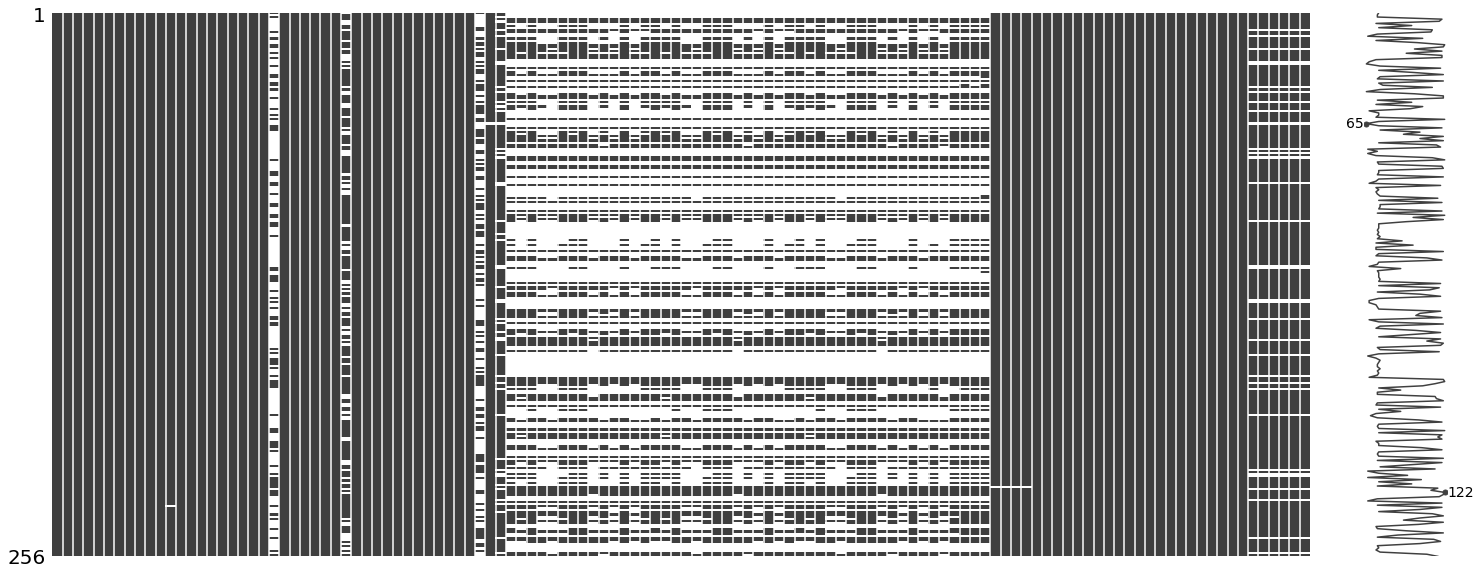

In [9]:
# Analyze missing values
msno.matrix(applications.sample(256))

Seems that there are a lot of missing values

In [10]:
# Read columns description csv file and view first 5 rows
columns_description = pd.read_csv("./data/homecredit_columns_description.csv", 
                                  encoding='cp1252')
columns_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,applications.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,applications.csv,TARGET,Target variable (0 - client with payment diffi...,NaN
2,5,applications.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,applications.csv,CODE_GENDER,Gender of the client,NaN
4,7,applications.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [11]:
columns_description.Table.unique()

array(['applications.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [12]:
# Remove NaN values
columns_description["Special"].fillna("No special mentions about this column", 
                                      inplace=True)

### <b> EDA for TARGET column

Target is the column that the model will have to learn to predict. $0$ means that the credit loan was not defaulted and $1$ means that the credit was defaulted (i.e. was not paid back)

<AxesSubplot:>

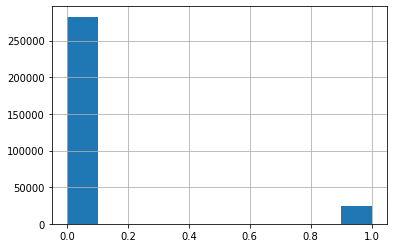

In [13]:
# Plot hist of TARGET column
applications["TARGET"].hist()

In [14]:
# Check number of positive examples in dataset
applications["TARGET"].sum()

24825

In [15]:
# Check number of NaN in TARGET column
applications["TARGET"].isna().sum()

0

For TARGET column we have a ***imbalanced class*** problem. There are much more credits that were returned that the ones that were not.

Thus, *Accuracy* is not a good metric because it will be misleading. Something like *Precision*, *Recall* or AUC will be much better. I choose ROC AUC because it will show model performance based on various tresholds, thus the business will get a better understanding about how this algorithm can be used in production and the deployment options (canary deployment/partial automation/full automation etc).

In [1]:
# Function for generating useful statistics about dataframes
def dataframe_analysis(dataframe, datatype, table_name = "applications.csv"):
    for column in dataframe.columns:
        if dataframe[column].dtype==datatype:
            print('\n'+"-"*80)
            print(f"NOW ANALYZING COLUMN: {column}")
            print("-"*80)
            try:
                print("COLUMN DESCRIPTION:")
                print(columns_description.loc[
                    (columns_description["Table"]==table_name) & 
                    (columns_description["Row"]==column)]["Description"].values[0], '\n')
                print("SPECIAL MENTIONS:")
                print(columns_description.loc[
                    (columns_description["Table"]==table_name) & (columns_description["Row"]=="TARGET")]["Special"].values[0], '\n')
            except:
                print("Did not find description for this column")
            print("TOP 5 ROWS:")
            print(dataframe[column].head())
            print("\nCOLUMN STATISTICS:")
            print(dataframe[column].describe())
            if datatype=="object":
                print("\nUNIQUE VALUESL")
                print(dataframe[column].unique())
            else:
                print("\nNumber of zeros:")
                print((dataframe[column]==0.0).sum())            
            print("\nNumber of NaN in column:")
            print(dataframe[column].isna().sum())
            dataframe[column].hist()
            plt.show()
            

### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_INCOME_TOTAL
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Income of the client 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   202500.00
1   270000.00
2    67500.00
3   135000.00
4   121500.00
Name: AMT_INCOME_TOTAL, dtype: float64

COLUMN STATISTICS:
count      307511.00
mean       168797.92
std        237123.15
min         25650.00
25%        112500.00
50%        147150.00
75%        202500.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


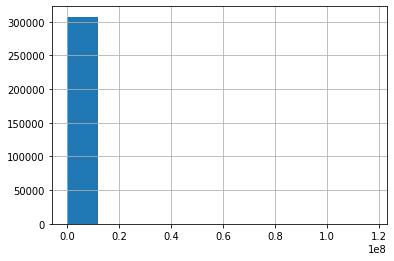


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Credit amount of the loan 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    406597.50
1   1293502.50
2    135000.00
3    312682.50
4    513000.00
Name: AMT_CREDIT, dtype: float64

COLUMN STATISTICS:
count    307511.00
mean     599026.00
std      402490.78
min       45000.00
25%      270000.00
50%      513531.00
75%      808650.00
max     4050000.00
Name: AMT_CREDIT, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


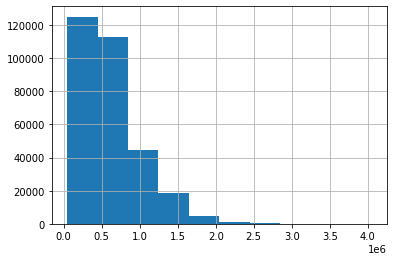


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_ANNUITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Loan annuity 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   24700.50
1   35698.50
2    6750.00
3   29686.50
4   21865.50
Name: AMT_ANNUITY, dtype: float64

COLUMN STATISTICS:
count   307499.00
mean     27108.57
std      14493.74
min       1615.50
25%      16524.00
50%      24903.00
75%      34596.00
max     258025.50
Name: AMT_ANNUITY, dtype: float64

Number of zeros:
0

Number of NaN in column:
12


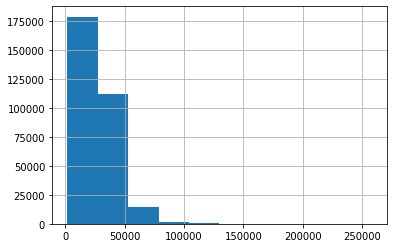


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_GOODS_PRICE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
For consumer loans it is the price of the goods for which the loan is given 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    351000.00
1   1129500.00
2    135000.00
3    297000.00
4    513000.00
Name: AMT_GOODS_PRICE, dtype: float64

COLUMN STATISTICS:
count    307233.00
mean     538396.21
std      369446.46
min       40500.00
25%      238500.00
50%      450000.00
75%      679500.00
max     4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

Number of zeros:
0

Number of NaN in column:
278


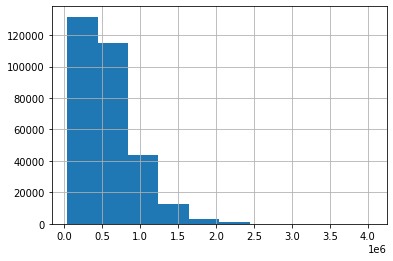


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: REGION_POPULATION_RELATIVE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized population of region where client lives (higher number means the client lives in more populated region) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.00
2   0.01
3   0.01
4   0.03
Name: REGION_POPULATION_RELATIVE, dtype: float64

COLUMN STATISTICS:
count   307511.00
mean         0.02
std          0.01
min          0.00
25%          0.01
50%          0.02
75%          0.03
max          0.07
Name: REGION_POPULATION_RELATIVE, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


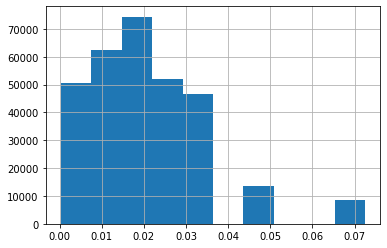


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_REGISTRATION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many days before the application did client change his registration 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   -3648.00
1   -1186.00
2   -4260.00
3   -9833.00
4   -4311.00
Name: DAYS_REGISTRATION, dtype: float64

COLUMN STATISTICS:
count   307511.00
mean     -4986.12
std       3522.89
min     -24672.00
25%      -7479.50
50%      -4504.00
75%      -2010.00
max          0.00
Name: DAYS_REGISTRATION, dtype: float64

Number of zeros:
80

Number of NaN in column:
0


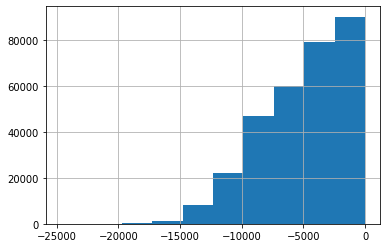


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: OWN_CAR_AGE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Age of client's car 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0     NaN
1     NaN
2   26.00
3     NaN
4     NaN
Name: OWN_CAR_AGE, dtype: float64

COLUMN STATISTICS:
count   104582.00
mean        12.06
std         11.94
min          0.00
25%          5.00
50%          9.00
75%         15.00
max         91.00
Name: OWN_CAR_AGE, dtype: float64

Number of zeros:
2134

Number of NaN in column:
202929


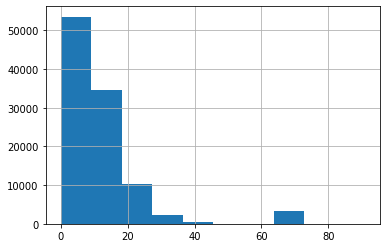


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_FAM_MEMBERS
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many family members does client have 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   1.00
1   2.00
2   1.00
3   2.00
4   1.00
Name: CNT_FAM_MEMBERS, dtype: float64

COLUMN STATISTICS:
count   307509.00
mean         2.15
std          0.91
min          1.00
25%          2.00
50%          2.00
75%          3.00
max         20.00
Name: CNT_FAM_MEMBERS, dtype: float64

Number of zeros:
0

Number of NaN in column:
2


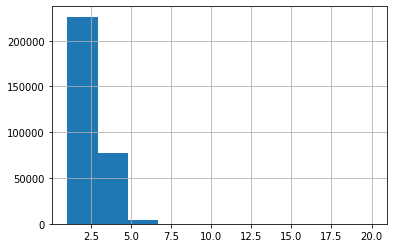


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: EXT_SOURCE_1
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized score from external data source 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.08
1   0.31
2    NaN
3    NaN
4    NaN
Name: EXT_SOURCE_1, dtype: float64

COLUMN STATISTICS:
count   134133.00
mean         0.50
std          0.21
min          0.01
25%          0.33
50%          0.51
75%          0.68
max          0.96
Name: EXT_SOURCE_1, dtype: float64

Number of zeros:
0

Number of NaN in column:
173378


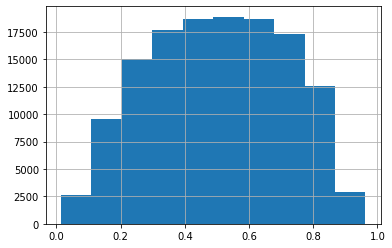


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: EXT_SOURCE_2
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized score from external data source 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.26
1   0.62
2   0.56
3   0.65
4   0.32
Name: EXT_SOURCE_2, dtype: float64

COLUMN STATISTICS:
count   306851.00
mean         0.51
std          0.19
min          0.00
25%          0.39
50%          0.57
75%          0.66
max          0.85
Name: EXT_SOURCE_2, dtype: float64

Number of zeros:
0

Number of NaN in column:
660


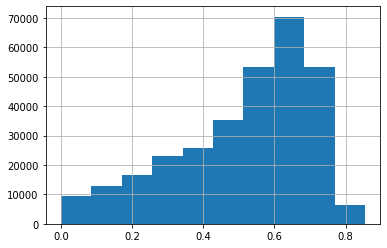


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: EXT_SOURCE_3
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized score from external data source 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.14
1    NaN
2   0.73
3    NaN
4    NaN
Name: EXT_SOURCE_3, dtype: float64

COLUMN STATISTICS:
count   246546.00
mean         0.51
std          0.19
min          0.00
25%          0.37
50%          0.54
75%          0.67
max          0.90
Name: EXT_SOURCE_3, dtype: float64

Number of zeros:
0

Number of NaN in column:
60965


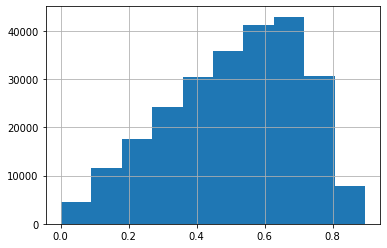


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: APARTMENTS_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.10
2    NaN
3    NaN
4    NaN
Name: APARTMENTS_AVG, dtype: float64

COLUMN STATISTICS:
count   151450.00
mean         0.12
std          0.11
min          0.00
25%          0.06
50%          0.09
75%          0.15
max          1.00
Name: APARTMENTS_AVG, dtype: float64

Number of zeros:
751

Number of NaN in column:
156061


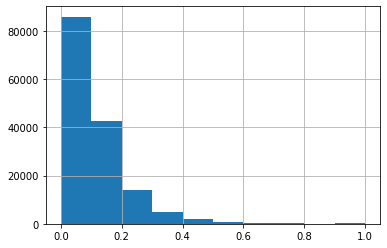


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: BASEMENTAREA_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.04
1   0.05
2    NaN
3    NaN
4    NaN
Name: BASEMENTAREA_AVG, dtype: float64

COLUMN STATISTICS:
count   127568.00
mean         0.09
std          0.08
min          0.00
25%          0.04
50%          0.08
75%          0.11
max          1.00
Name: BASEMENTAREA_AVG, dtype: float64

Number of zeros:
14745

Number of NaN in column:
179943


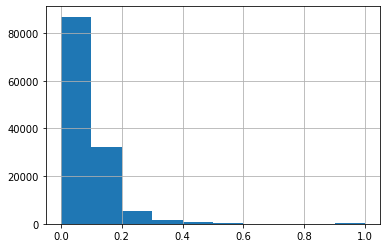


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: YEARS_BEGINEXPLUATATION_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.97
1   0.99
2    NaN
3    NaN
4    NaN
Name: YEARS_BEGINEXPLUATATION_AVG, dtype: float64

COLUMN STATISTICS:
count   157504.00
mean         0.98
std          0.06
min          0.00
25%          0.98
50%          0.98
75%          0.99
max          1.00
Name: YEARS_BEGINEXPLUATATION_AVG, dtype: float64

Number of zeros:
514

Number of NaN in column:
150007


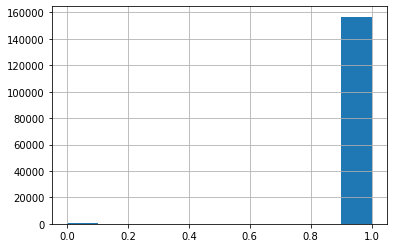


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: YEARS_BUILD_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.62
1   0.80
2    NaN
3    NaN
4    NaN
Name: YEARS_BUILD_AVG, dtype: float64

COLUMN STATISTICS:
count   103023.00
mean         0.75
std          0.11
min          0.00
25%          0.69
50%          0.76
75%          0.82
max          1.00
Name: YEARS_BUILD_AVG, dtype: float64

Number of zeros:
102

Number of NaN in column:
204488


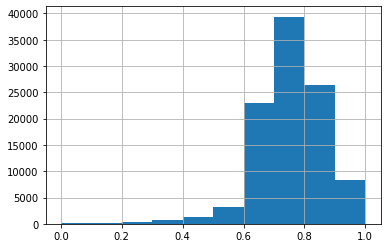


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: COMMONAREA_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.01
1   0.06
2    NaN
3    NaN
4    NaN
Name: COMMONAREA_AVG, dtype: float64

COLUMN STATISTICS:
count   92646.00
mean        0.04
std         0.08
min         0.00
25%         0.01
50%         0.02
75%         0.05
max         1.00
Name: COMMONAREA_AVG, dtype: float64

Number of zeros:
8442

Number of NaN in column:
214865


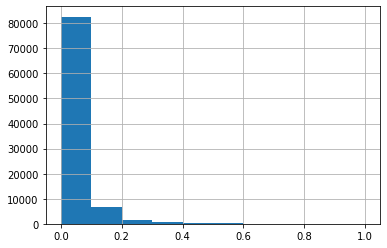


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: ELEVATORS_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.08
2    NaN
3    NaN
4    NaN
Name: ELEVATORS_AVG, dtype: float64

COLUMN STATISTICS:
count   143620.00
mean         0.08
std          0.13
min          0.00
25%          0.00
50%          0.00
75%          0.12
max          1.00
Name: ELEVATORS_AVG, dtype: float64

Number of zeros:
85718

Number of NaN in column:
163891


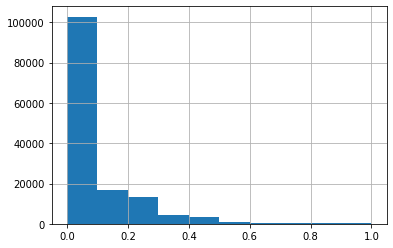


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: ENTRANCES_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.07
1   0.03
2    NaN
3    NaN
4    NaN
Name: ENTRANCES_AVG, dtype: float64

COLUMN STATISTICS:
count   152683.00
mean         0.15
std          0.10
min          0.00
25%          0.07
50%          0.14
75%          0.21
max          1.00
Name: ENTRANCES_AVG, dtype: float64

Number of zeros:
323

Number of NaN in column:
154828


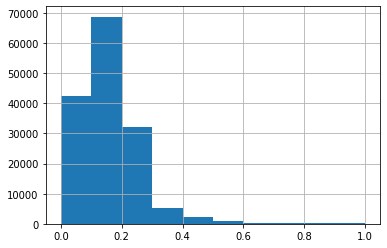


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLOORSMAX_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.08
1   0.29
2    NaN
3    NaN
4    NaN
Name: FLOORSMAX_AVG, dtype: float64

COLUMN STATISTICS:
count   154491.00
mean         0.23
std          0.14
min          0.00
25%          0.17
50%          0.17
75%          0.33
max          1.00
Name: FLOORSMAX_AVG, dtype: float64

Number of zeros:
2938

Number of NaN in column:
153020


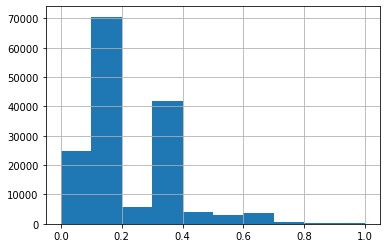


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLOORSMIN_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.12
1   0.33
2    NaN
3    NaN
4    NaN
Name: FLOORSMIN_AVG, dtype: float64

COLUMN STATISTICS:
count   98869.00
mean        0.23
std         0.16
min         0.00
25%         0.08
50%         0.21
75%         0.38
max         1.00
Name: FLOORSMIN_AVG, dtype: float64

Number of zeros:
2320

Number of NaN in column:
208642


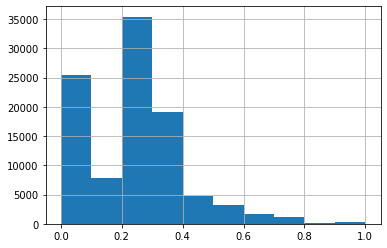


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LANDAREA_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.04
1   0.01
2    NaN
3    NaN
4    NaN
Name: LANDAREA_AVG, dtype: float64

COLUMN STATISTICS:
count   124921.00
mean         0.07
std          0.08
min          0.00
25%          0.02
50%          0.05
75%          0.09
max          1.00
Name: LANDAREA_AVG, dtype: float64

Number of zeros:
15600

Number of NaN in column:
182590


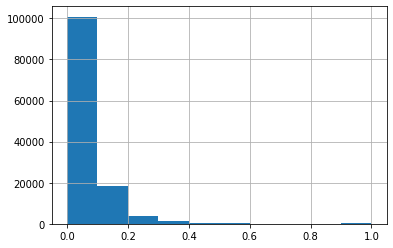


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVINGAPARTMENTS_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.08
2    NaN
3    NaN
4    NaN
Name: LIVINGAPARTMENTS_AVG, dtype: float64

COLUMN STATISTICS:
count   97312.00
mean        0.10
std         0.09
min         0.00
25%         0.05
50%         0.08
75%         0.12
max         1.00
Name: LIVINGAPARTMENTS_AVG, dtype: float64

Number of zeros:
418

Number of NaN in column:
210199


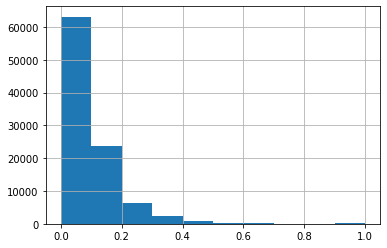


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVINGAREA_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.05
2    NaN
3    NaN
4    NaN
Name: LIVINGAREA_AVG, dtype: float64

COLUMN STATISTICS:
count   153161.00
mean         0.11
std          0.11
min          0.00
25%          0.05
50%          0.07
75%          0.13
max          1.00
Name: LIVINGAREA_AVG, dtype: float64

Number of zeros:
284

Number of NaN in column:
154350


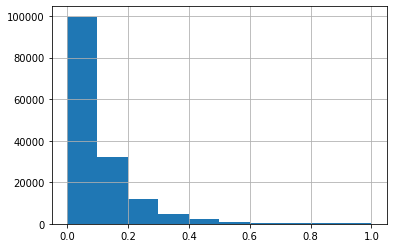


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NONLIVINGAPARTMENTS_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2    NaN
3    NaN
4    NaN
Name: NONLIVINGAPARTMENTS_AVG, dtype: float64

COLUMN STATISTICS:
count   93997.00
mean        0.01
std         0.05
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: NONLIVINGAPARTMENTS_AVG, dtype: float64

Number of zeros:
54549

Number of NaN in column:
213514


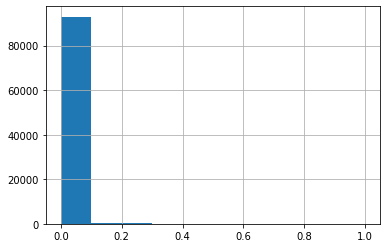


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NONLIVINGAREA_AVG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.01
2    NaN
3    NaN
4    NaN
Name: NONLIVINGAREA_AVG, dtype: float64

COLUMN STATISTICS:
count   137829.00
mean         0.03
std          0.07
min          0.00
25%          0.00
50%          0.00
75%          0.03
max          1.00
Name: NONLIVINGAREA_AVG, dtype: float64

Number of zeros:
58735

Number of NaN in column:
169682


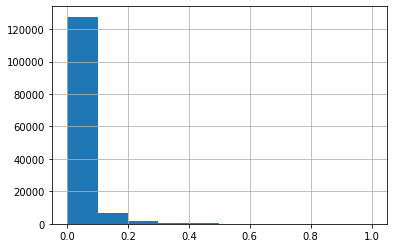


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: APARTMENTS_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.03
1   0.09
2    NaN
3    NaN
4    NaN
Name: APARTMENTS_MODE, dtype: float64

COLUMN STATISTICS:
count   151450.00
mean         0.11
std          0.11
min          0.00
25%          0.05
50%          0.08
75%          0.14
max          1.00
Name: APARTMENTS_MODE, dtype: float64

Number of zeros:
976

Number of NaN in column:
156061


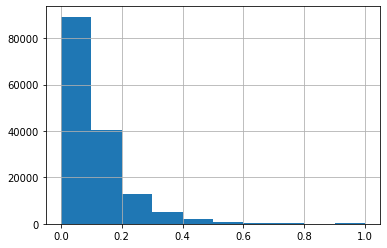


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: BASEMENTAREA_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.04
1   0.05
2    NaN
3    NaN
4    NaN
Name: BASEMENTAREA_MODE, dtype: float64

COLUMN STATISTICS:
count   127568.00
mean         0.09
std          0.08
min          0.00
25%          0.04
50%          0.07
75%          0.11
max          1.00
Name: BASEMENTAREA_MODE, dtype: float64

Number of zeros:
16598

Number of NaN in column:
179943


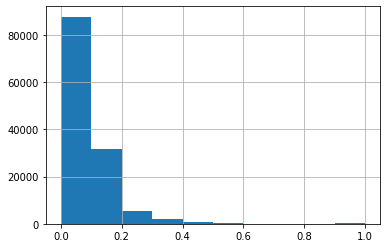


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: YEARS_BEGINEXPLUATATION_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.97
1   0.99
2    NaN
3    NaN
4    NaN
Name: YEARS_BEGINEXPLUATATION_MODE, dtype: float64

COLUMN STATISTICS:
count   157504.00
mean         0.98
std          0.06
min          0.00
25%          0.98
50%          0.98
75%          0.99
max          1.00
Name: YEARS_BEGINEXPLUATATION_MODE, dtype: float64

Number of zeros:
142

Number of NaN in column:
150007


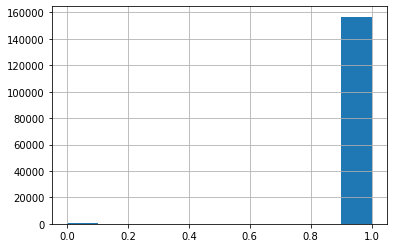


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: YEARS_BUILD_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.63
1   0.80
2    NaN
3    NaN
4    NaN
Name: YEARS_BUILD_MODE, dtype: float64

COLUMN STATISTICS:
count   103023.00
mean         0.76
std          0.11
min          0.00
25%          0.70
50%          0.76
75%          0.82
max          1.00
Name: YEARS_BUILD_MODE, dtype: float64

Number of zeros:
103

Number of NaN in column:
204488


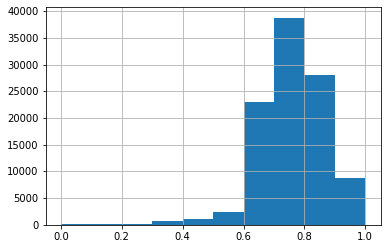


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: COMMONAREA_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.01
1   0.05
2    NaN
3    NaN
4    NaN
Name: COMMONAREA_MODE, dtype: float64

COLUMN STATISTICS:
count   92646.00
mean        0.04
std         0.07
min         0.00
25%         0.01
50%         0.02
75%         0.05
max         1.00
Name: COMMONAREA_MODE, dtype: float64

Number of zeros:
9690

Number of NaN in column:
214865


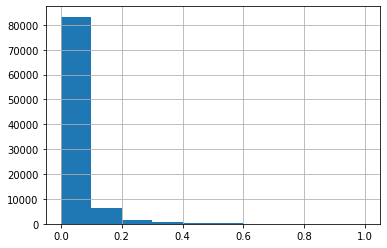


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: ELEVATORS_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.08
2    NaN
3    NaN
4    NaN
Name: ELEVATORS_MODE, dtype: float64

COLUMN STATISTICS:
count   143620.00
mean         0.07
std          0.13
min          0.00
25%          0.00
50%          0.00
75%          0.12
max          1.00
Name: ELEVATORS_MODE, dtype: float64

Number of zeros:
89498

Number of NaN in column:
163891


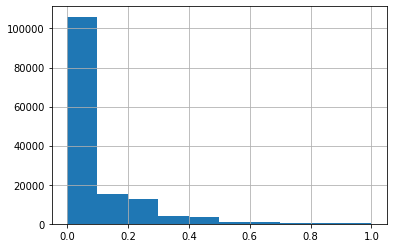


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: ENTRANCES_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.07
1   0.03
2    NaN
3    NaN
4    NaN
Name: ENTRANCES_MODE, dtype: float64

COLUMN STATISTICS:
count   152683.00
mean         0.15
std          0.10
min          0.00
25%          0.07
50%          0.14
75%          0.21
max          1.00
Name: ENTRANCES_MODE, dtype: float64

Number of zeros:
387

Number of NaN in column:
154828


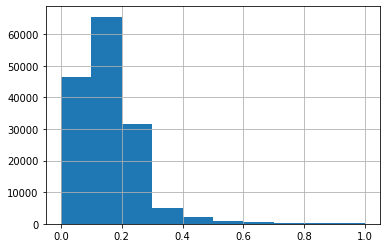


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLOORSMAX_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.08
1   0.29
2    NaN
3    NaN
4    NaN
Name: FLOORSMAX_MODE, dtype: float64

COLUMN STATISTICS:
count   154491.00
mean         0.22
std          0.14
min          0.00
25%          0.17
50%          0.17
75%          0.33
max          1.00
Name: FLOORSMAX_MODE, dtype: float64

Number of zeros:
3415

Number of NaN in column:
153020


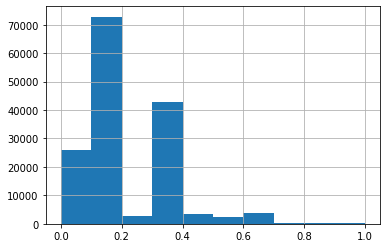


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLOORSMIN_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.12
1   0.33
2    NaN
3    NaN
4    NaN
Name: FLOORSMIN_MODE, dtype: float64

COLUMN STATISTICS:
count   98869.00
mean        0.23
std         0.16
min         0.00
25%         0.08
50%         0.21
75%         0.38
max         1.00
Name: FLOORSMIN_MODE, dtype: float64

Number of zeros:
2517

Number of NaN in column:
208642


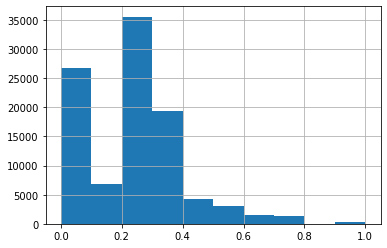


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LANDAREA_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.04
1   0.01
2    NaN
3    NaN
4    NaN
Name: LANDAREA_MODE, dtype: float64

COLUMN STATISTICS:
count   124921.00
mean         0.06
std          0.08
min          0.00
25%          0.02
50%          0.05
75%          0.08
max          1.00
Name: LANDAREA_MODE, dtype: float64

Number of zeros:
17453

Number of NaN in column:
182590


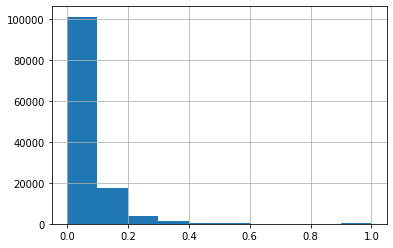


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVINGAPARTMENTS_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.08
2    NaN
3    NaN
4    NaN
Name: LIVINGAPARTMENTS_MODE, dtype: float64

COLUMN STATISTICS:
count   97312.00
mean        0.11
std         0.10
min         0.00
25%         0.05
50%         0.08
75%         0.13
max         1.00
Name: LIVINGAPARTMENTS_MODE, dtype: float64

Number of zeros:
519

Number of NaN in column:
210199


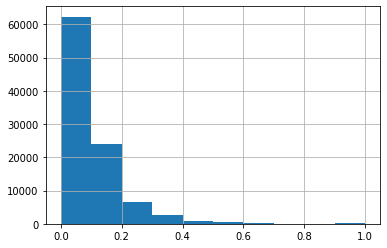


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVINGAREA_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.06
2    NaN
3    NaN
4    NaN
Name: LIVINGAREA_MODE, dtype: float64

COLUMN STATISTICS:
count   153161.00
mean         0.11
std          0.11
min          0.00
25%          0.04
50%          0.07
75%          0.13
max          1.00
Name: LIVINGAREA_MODE, dtype: float64

Number of zeros:
444

Number of NaN in column:
154350


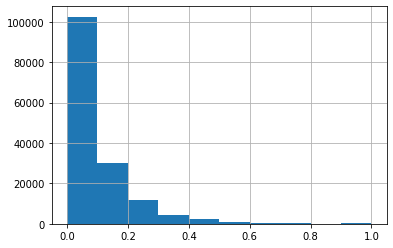


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NONLIVINGAPARTMENTS_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2    NaN
3    NaN
4    NaN
Name: NONLIVINGAPARTMENTS_MODE, dtype: float64

COLUMN STATISTICS:
count   93997.00
mean        0.01
std         0.05
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: NONLIVINGAPARTMENTS_MODE, dtype: float64

Number of zeros:
59255

Number of NaN in column:
213514


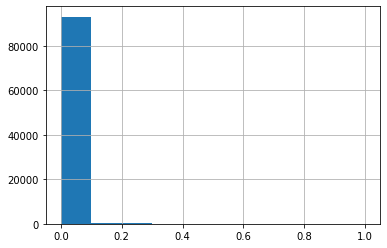


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NONLIVINGAREA_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2    NaN
3    NaN
4    NaN
Name: NONLIVINGAREA_MODE, dtype: float64

COLUMN STATISTICS:
count   137829.00
mean         0.03
std          0.07
min          0.00
25%          0.00
50%          0.00
75%          0.02
max          1.00
Name: NONLIVINGAREA_MODE, dtype: float64

Number of zeros:
67126

Number of NaN in column:
169682


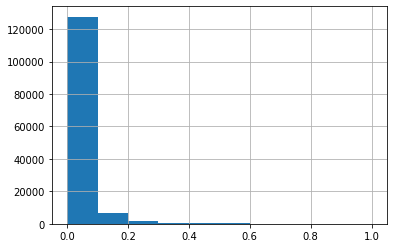


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: APARTMENTS_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.03
1   0.10
2    NaN
3    NaN
4    NaN
Name: APARTMENTS_MEDI, dtype: float64

COLUMN STATISTICS:
count   151450.00
mean         0.12
std          0.11
min          0.00
25%          0.06
50%          0.09
75%          0.15
max          1.00
Name: APARTMENTS_MEDI, dtype: float64

Number of zeros:
771

Number of NaN in column:
156061


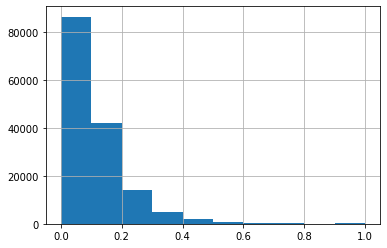


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: BASEMENTAREA_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.04
1   0.05
2    NaN
3    NaN
4    NaN
Name: BASEMENTAREA_MEDI, dtype: float64

COLUMN STATISTICS:
count   127568.00
mean         0.09
std          0.08
min          0.00
25%          0.04
50%          0.08
75%          0.11
max          1.00
Name: BASEMENTAREA_MEDI, dtype: float64

Number of zeros:
14991

Number of NaN in column:
179943


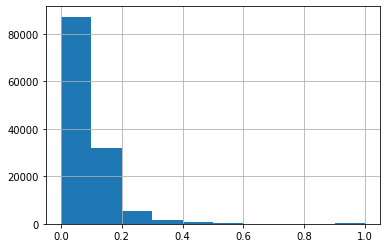


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: YEARS_BEGINEXPLUATATION_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.97
1   0.99
2    NaN
3    NaN
4    NaN
Name: YEARS_BEGINEXPLUATATION_MEDI, dtype: float64

COLUMN STATISTICS:
count   157504.00
mean         0.98
std          0.06
min          0.00
25%          0.98
50%          0.98
75%          0.99
max          1.00
Name: YEARS_BEGINEXPLUATATION_MEDI, dtype: float64

Number of zeros:
548

Number of NaN in column:
150007


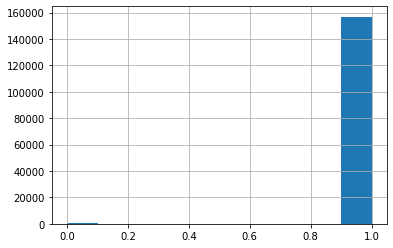


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: YEARS_BUILD_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.62
1   0.80
2    NaN
3    NaN
4    NaN
Name: YEARS_BUILD_MEDI, dtype: float64

COLUMN STATISTICS:
count   103023.00
mean         0.76
std          0.11
min          0.00
25%          0.69
50%          0.76
75%          0.83
max          1.00
Name: YEARS_BUILD_MEDI, dtype: float64

Number of zeros:
101

Number of NaN in column:
204488


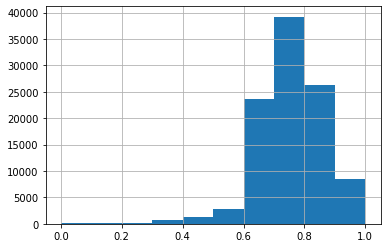


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: COMMONAREA_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.01
1   0.06
2    NaN
3    NaN
4    NaN
Name: COMMONAREA_MEDI, dtype: float64

COLUMN STATISTICS:
count   92646.00
mean        0.04
std         0.08
min         0.00
25%         0.01
50%         0.02
75%         0.05
max         1.00
Name: COMMONAREA_MEDI, dtype: float64

Number of zeros:
8691

Number of NaN in column:
214865


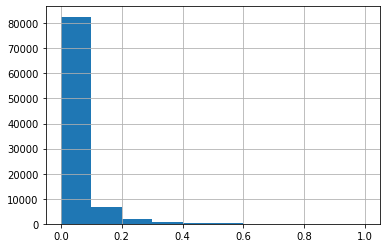


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: ELEVATORS_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.08
2    NaN
3    NaN
4    NaN
Name: ELEVATORS_MEDI, dtype: float64

COLUMN STATISTICS:
count   143620.00
mean         0.08
std          0.13
min          0.00
25%          0.00
50%          0.00
75%          0.12
max          1.00
Name: ELEVATORS_MEDI, dtype: float64

Number of zeros:
87026

Number of NaN in column:
163891


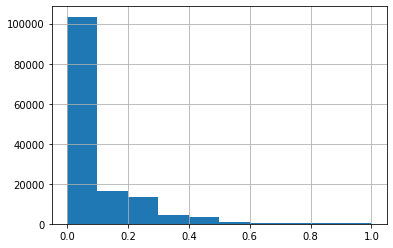


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: ENTRANCES_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.07
1   0.03
2    NaN
3    NaN
4    NaN
Name: ENTRANCES_MEDI, dtype: float64

COLUMN STATISTICS:
count   152683.00
mean         0.15
std          0.10
min          0.00
25%          0.07
50%          0.14
75%          0.21
max          1.00
Name: ENTRANCES_MEDI, dtype: float64

Number of zeros:
329

Number of NaN in column:
154828


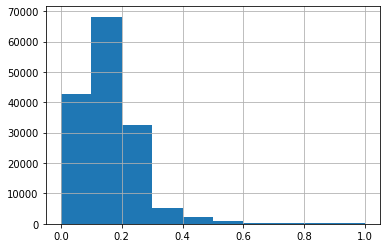


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLOORSMAX_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.08
1   0.29
2    NaN
3    NaN
4    NaN
Name: FLOORSMAX_MEDI, dtype: float64

COLUMN STATISTICS:
count   154491.00
mean         0.23
std          0.15
min          0.00
25%          0.17
50%          0.17
75%          0.33
max          1.00
Name: FLOORSMAX_MEDI, dtype: float64

Number of zeros:
2995

Number of NaN in column:
153020


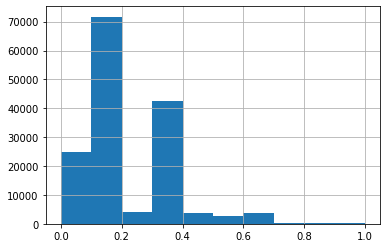


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLOORSMIN_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.12
1   0.33
2    NaN
3    NaN
4    NaN
Name: FLOORSMIN_MEDI, dtype: float64

COLUMN STATISTICS:
count   98869.00
mean        0.23
std         0.16
min         0.00
25%         0.08
50%         0.21
75%         0.38
max         1.00
Name: FLOORSMIN_MEDI, dtype: float64

Number of zeros:
2351

Number of NaN in column:
208642


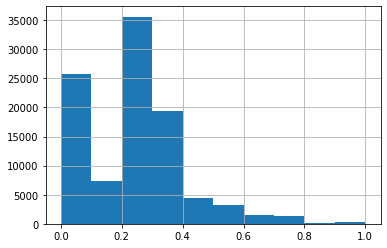


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LANDAREA_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.04
1   0.01
2    NaN
3    NaN
4    NaN
Name: LANDAREA_MEDI, dtype: float64

COLUMN STATISTICS:
count   124921.00
mean         0.07
std          0.08
min          0.00
25%          0.02
50%          0.05
75%          0.09
max          1.00
Name: LANDAREA_MEDI, dtype: float64

Number of zeros:
15919

Number of NaN in column:
182590


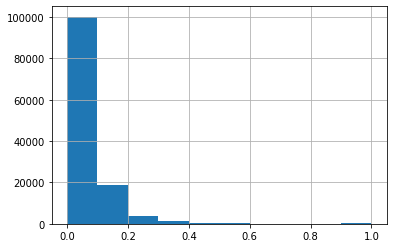


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVINGAPARTMENTS_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.08
2    NaN
3    NaN
4    NaN
Name: LIVINGAPARTMENTS_MEDI, dtype: float64

COLUMN STATISTICS:
count   97312.00
mean        0.10
std         0.09
min         0.00
25%         0.05
50%         0.08
75%         0.12
max         1.00
Name: LIVINGAPARTMENTS_MEDI, dtype: float64

Number of zeros:
433

Number of NaN in column:
210199


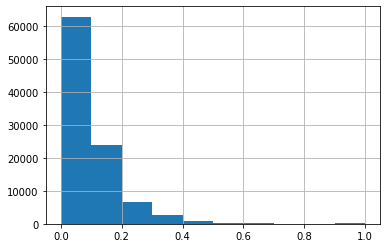


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVINGAREA_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.02
1   0.06
2    NaN
3    NaN
4    NaN
Name: LIVINGAREA_MEDI, dtype: float64

COLUMN STATISTICS:
count   153161.00
mean         0.11
std          0.11
min          0.00
25%          0.05
50%          0.07
75%          0.13
max          1.00
Name: LIVINGAREA_MEDI, dtype: float64

Number of zeros:
299

Number of NaN in column:
154350


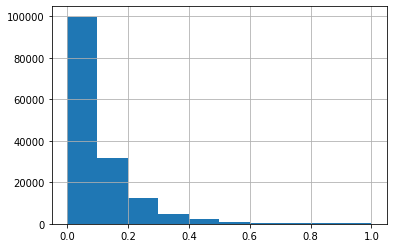


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NONLIVINGAPARTMENTS_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2    NaN
3    NaN
4    NaN
Name: NONLIVINGAPARTMENTS_MEDI, dtype: float64

COLUMN STATISTICS:
count   93997.00
mean        0.01
std         0.05
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: NONLIVINGAPARTMENTS_MEDI, dtype: float64

Number of zeros:
56097

Number of NaN in column:
213514


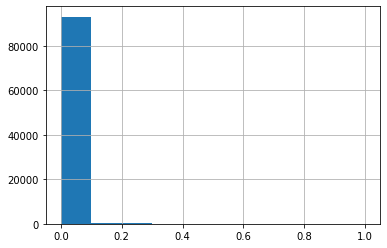


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NONLIVINGAREA_MEDI
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.01
2    NaN
3    NaN
4    NaN
Name: NONLIVINGAREA_MEDI, dtype: float64

COLUMN STATISTICS:
count   137829.00
mean         0.03
std          0.07
min          0.00
25%          0.00
50%          0.00
75%          0.03
max          1.00
Name: NONLIVINGAREA_MEDI, dtype: float64

Number of zeros:
60954

Number of NaN in column:
169682


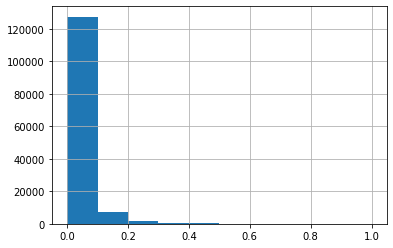


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: TOTALAREA_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.01
1   0.07
2    NaN
3    NaN
4    NaN
Name: TOTALAREA_MODE, dtype: float64

COLUMN STATISTICS:
count   159080.00
mean         0.10
std          0.11
min          0.00
25%          0.04
50%          0.07
75%          0.13
max          1.00
Name: TOTALAREA_MODE, dtype: float64

Number of zeros:
582

Number of NaN in column:
148431


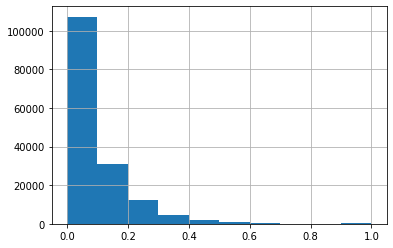


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: OBS_30_CNT_SOCIAL_CIRCLE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many observation of client's social surroundings with observable 30 DPD (days past due) default 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   2.00
1   1.00
2   0.00
3   2.00
4   0.00
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

COLUMN STATISTICS:
count   306490.00
mean         1.42
std          2.40
min          0.00
25%          0.00
50%          0.00
75%          2.00
max        348.00
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Number of zeros:
163910

Number of NaN in column:
1021


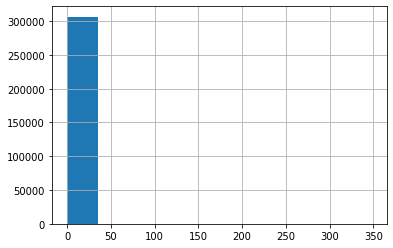


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DEF_30_CNT_SOCIAL_CIRCLE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many observation of client's social surroundings defaulted on 30 DPD (days past due)  

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   2.00
1   0.00
2   0.00
3   0.00
4   0.00
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

COLUMN STATISTICS:
count   306490.00
mean         0.14
std          0.45
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         34.00
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

Number of zeros:
271324

Number of NaN in column:
1021


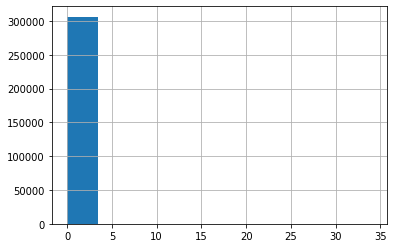


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: OBS_60_CNT_SOCIAL_CIRCLE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many observation of client's social surroundings with observable 60 DPD (days past due) default 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   2.00
1   1.00
2   0.00
3   2.00
4   0.00
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

COLUMN STATISTICS:
count   306490.00
mean         1.41
std          2.38
min          0.00
25%          0.00
50%          0.00
75%          2.00
max        344.00
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

Number of zeros:
164666

Number of NaN in column:
1021


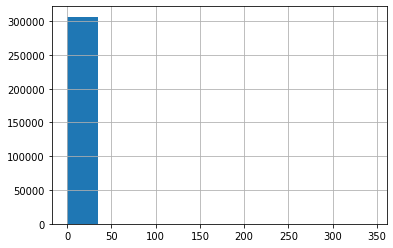


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DEF_60_CNT_SOCIAL_CIRCLE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many observation of client's social surroundings defaulted on 60 (days past due) DPD 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   2.00
1   0.00
2   0.00
3   0.00
4   0.00
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

COLUMN STATISTICS:
count   306490.00
mean         0.10
std          0.36
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         24.00
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

Number of zeros:
280721

Number of NaN in column:
1021


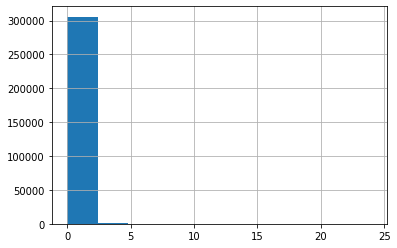


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_LAST_PHONE_CHANGE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many days before application did client change phone 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   -1134.00
1    -828.00
2    -815.00
3    -617.00
4   -1106.00
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

COLUMN STATISTICS:
count   307510.00
mean      -962.86
std        826.81
min      -4292.00
25%      -1570.00
50%       -757.00
75%       -274.00
max          0.00
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

Number of zeros:
37672

Number of NaN in column:
1


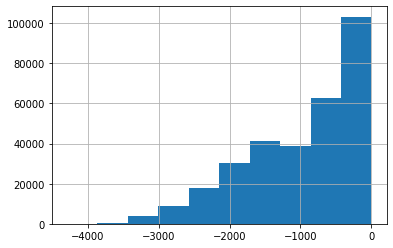


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_REQ_CREDIT_BUREAU_HOUR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of enquiries to Credit Bureau about the client one hour before application 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

COLUMN STATISTICS:
count   265992.00
mean         0.01
std          0.08
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          4.00
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

Number of zeros:
264366

Number of NaN in column:
41519


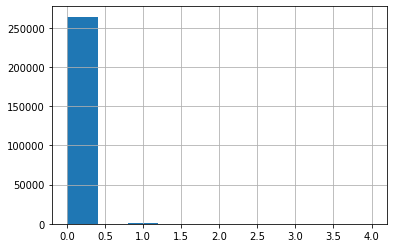


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_REQ_CREDIT_BUREAU_DAY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

COLUMN STATISTICS:
count   265992.00
mean         0.01
std          0.11
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          9.00
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

Number of zeros:
264503

Number of NaN in column:
41519


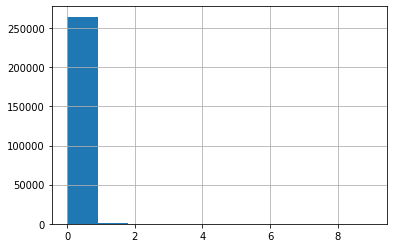


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_REQ_CREDIT_BUREAU_WEEK
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

COLUMN STATISTICS:
count   265992.00
mean         0.03
std          0.20
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          8.00
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

Number of zeros:
257456

Number of NaN in column:
41519


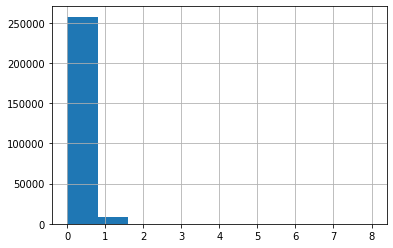


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_REQ_CREDIT_BUREAU_MON
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64

COLUMN STATISTICS:
count   265992.00
mean         0.27
std          0.92
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         27.00
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64

Number of zeros:
222233

Number of NaN in column:
41519


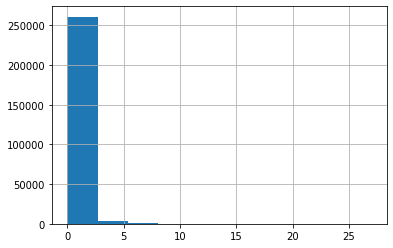


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_REQ_CREDIT_BUREAU_QRT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

COLUMN STATISTICS:
count   265992.00
mean         0.27
std          0.79
min          0.00
25%          0.00
50%          0.00
75%          0.00
max        261.00
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

Number of zeros:
215417

Number of NaN in column:
41519


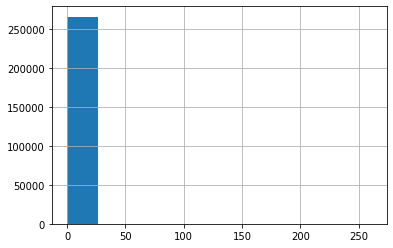


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_REQ_CREDIT_BUREAU_YEAR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   1.00
1   0.00
2   0.00
3    NaN
4   0.00
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

COLUMN STATISTICS:
count   265992.00
mean         1.90
std          1.87
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         25.00
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

Number of zeros:
71801

Number of NaN in column:
41519


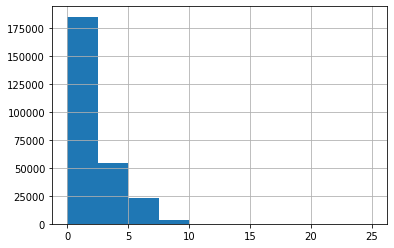

In [17]:
# View statistics about float64 columns
dataframe_analysis(applications, "float64")

### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    100002
1    100003
2    100004
3    100006
4    100007
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean    278180.52
std     102790.18
min     100002.00
25%     189145.50
50%     278202.00
75%     367142.50
max     456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


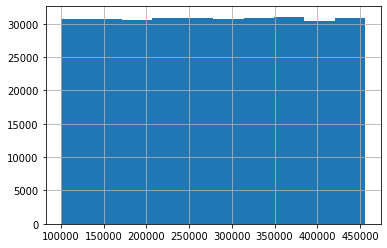


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: TARGET
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Target variable (0 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 1 - all other cases) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.08
std          0.27
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: TARGET, dtype: float64

Number of zeros:
282686

Number of NaN in column:
0


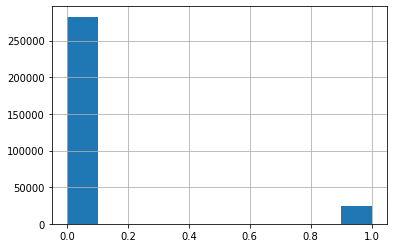


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_CHILDREN
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of children the client has 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: CNT_CHILDREN, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.42
std          0.72
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         19.00
Name: CNT_CHILDREN, dtype: float64

Number of zeros:
215371

Number of NaN in column:
0


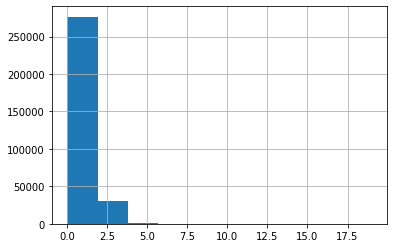


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_BIRTH
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Client's age in days at the time of application 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean    -16037.00
std       4363.99
min     -25229.00
25%     -19682.00
50%     -15750.00
75%     -12413.00
max      -7489.00
Name: DAYS_BIRTH, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


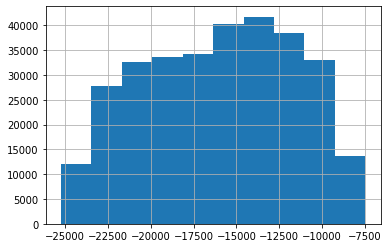


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_EMPLOYED
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many days before the application the person started current employment 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    -637
1   -1188
2    -225
3   -3039
4   -3038
Name: DAYS_EMPLOYED, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean     63815.05
std     141275.77
min     -17912.00
25%      -2760.00
50%      -1213.00
75%       -289.00
max     365243.00
Name: DAYS_EMPLOYED, dtype: float64

Number of zeros:
2

Number of NaN in column:
0


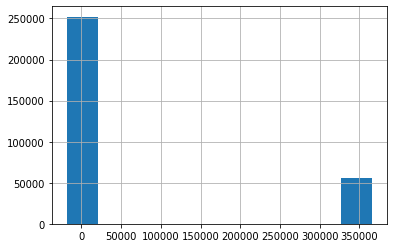


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_ID_PUBLISH
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many days before the application did client change the identity document with which he applied for the loan 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0   -2120
1    -291
2   -2531
3   -2437
4   -3458
Name: DAYS_ID_PUBLISH, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean     -2994.20
std       1509.45
min      -7197.00
25%      -4299.00
50%      -3254.00
75%      -1720.00
max          0.00
Name: DAYS_ID_PUBLISH, dtype: float64

Number of zeros:
16

Number of NaN in column:
0


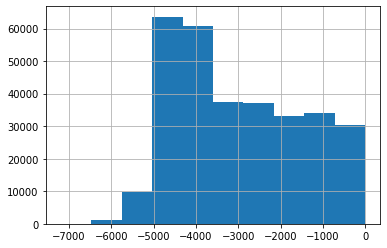


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_MOBIL
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide mobile phone (1=YES, 0=NO) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    1
1    1
2    1
3    1
4    1
Name: FLAG_MOBIL, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         1.00
std          0.00
min          0.00
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: FLAG_MOBIL, dtype: float64

Number of zeros:
1

Number of NaN in column:
0


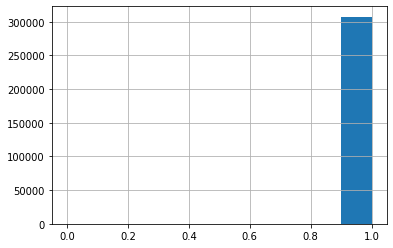


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_EMP_PHONE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide work phone (1=YES, 0=NO) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    1
1    1
2    1
3    1
4    1
Name: FLAG_EMP_PHONE, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.82
std          0.38
min          0.00
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: FLAG_EMP_PHONE, dtype: float64

Number of zeros:
55386

Number of NaN in column:
0


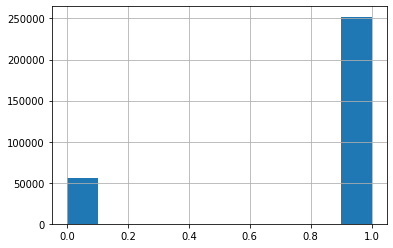


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_WORK_PHONE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide home phone (1=YES, 0=NO) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    1
3    0
4    0
Name: FLAG_WORK_PHONE, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.20
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_WORK_PHONE, dtype: float64

Number of zeros:
246203

Number of NaN in column:
0


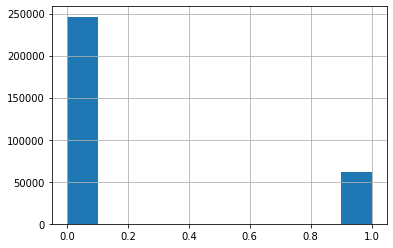


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_CONT_MOBILE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Was mobile phone reachable (1=YES, 0=NO) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    1
1    1
2    1
3    1
4    1
Name: FLAG_CONT_MOBILE, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         1.00
std          0.04
min          0.00
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: FLAG_CONT_MOBILE, dtype: float64

Number of zeros:
574

Number of NaN in column:
0


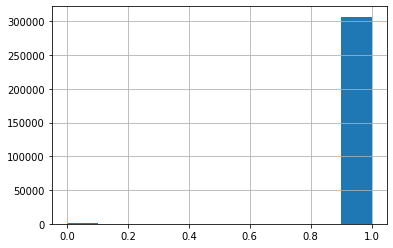


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_PHONE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide home phone (1=YES, 0=NO) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    1
1    1
2    1
3    0
4    0
Name: FLAG_PHONE, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.28
std          0.45
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          1.00
Name: FLAG_PHONE, dtype: float64

Number of zeros:
221080

Number of NaN in column:
0


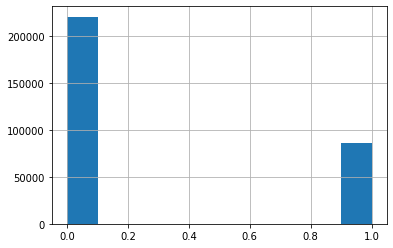


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_EMAIL
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide email (1=YES, 0=NO) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_EMAIL, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.06
std          0.23
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_EMAIL, dtype: float64

Number of zeros:
290069

Number of NaN in column:
0


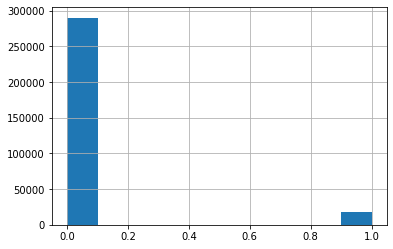


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: REGION_RATING_CLIENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Our rating of the region where client lives (1,2,3) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    2
1    1
2    2
3    2
4    2
Name: REGION_RATING_CLIENT, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         2.05
std          0.51
min          1.00
25%          2.00
50%          2.00
75%          2.00
max          3.00
Name: REGION_RATING_CLIENT, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


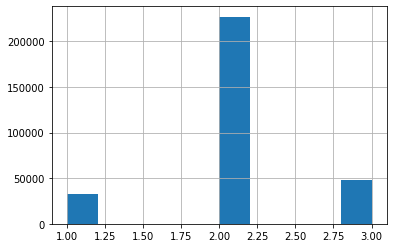


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: REGION_RATING_CLIENT_W_CITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Our rating of the region where client lives with taking city into account (1,2,3) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    2
1    1
2    2
3    2
4    2
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         2.03
std          0.50
min          1.00
25%          2.00
50%          2.00
75%          2.00
max          3.00
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


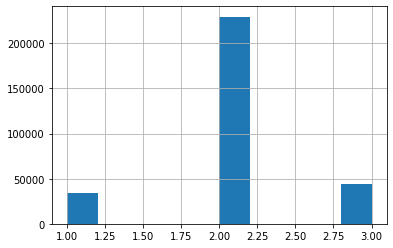


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: HOUR_APPR_PROCESS_START
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Approximately at what hour did the client apply for the loan 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    10
1    11
2     9
3    17
4    11
Name: HOUR_APPR_PROCESS_START, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean        12.06
std          3.27
min          0.00
25%         10.00
50%         12.00
75%         14.00
max         23.00
Name: HOUR_APPR_PROCESS_START, dtype: float64

Number of zeros:
40

Number of NaN in column:
0


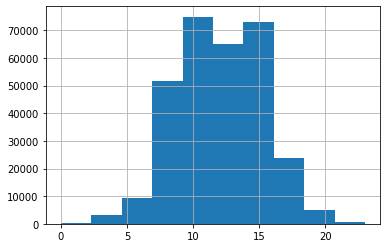


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: REG_REGION_NOT_LIVE_REGION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if client's permanent address does not match contact address (1=different, 0=same, at region level) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.02
std          0.12
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: REG_REGION_NOT_LIVE_REGION, dtype: float64

Number of zeros:
302854

Number of NaN in column:
0


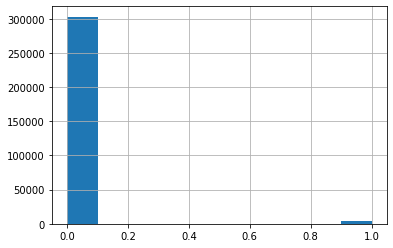


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: REG_REGION_NOT_WORK_REGION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if client's permanent address does not match work address (1=different, 0=same, at region level) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: REG_REGION_NOT_WORK_REGION, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.05
std          0.22
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: REG_REGION_NOT_WORK_REGION, dtype: float64

Number of zeros:
291899

Number of NaN in column:
0


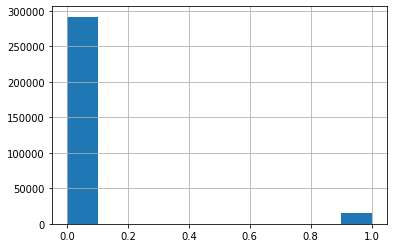


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVE_REGION_NOT_WORK_REGION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if client's contact address does not match work address (1=different, 0=same, at region level) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: LIVE_REGION_NOT_WORK_REGION, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.04
std          0.20
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64

Number of zeros:
295008

Number of NaN in column:
0


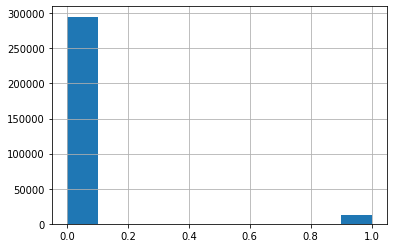


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: REG_CITY_NOT_LIVE_CITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if client's permanent address does not match contact address (1=different, 0=same, at city level) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: REG_CITY_NOT_LIVE_CITY, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.08
std          0.27
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: REG_CITY_NOT_LIVE_CITY, dtype: float64

Number of zeros:
283472

Number of NaN in column:
0


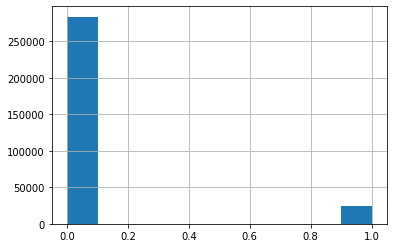


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: REG_CITY_NOT_WORK_CITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if client's permanent address does not match work address (1=different, 0=same, at city level) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    1
Name: REG_CITY_NOT_WORK_CITY, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.23
std          0.42
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: REG_CITY_NOT_WORK_CITY, dtype: float64

Number of zeros:
236644

Number of NaN in column:
0


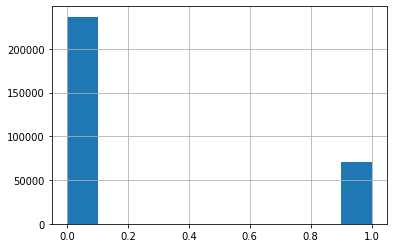


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: LIVE_CITY_NOT_WORK_CITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if client's contact address does not match work address (1=different, 0=same, at city level) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    1
Name: LIVE_CITY_NOT_WORK_CITY, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.18
std          0.38
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64

Number of zeros:
252296

Number of NaN in column:
0


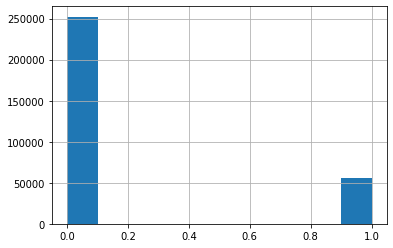


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_2
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 2 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_2, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.01
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_2, dtype: float64

Number of zeros:
307498

Number of NaN in column:
0


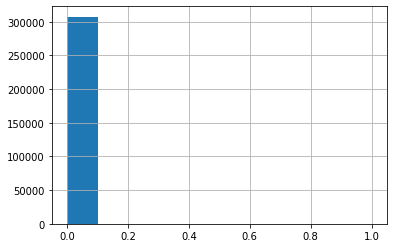


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_3
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 3 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    1
1    1
2    0
3    1
4    0
Name: FLAG_DOCUMENT_3, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.71
std          0.45
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          1.00
Name: FLAG_DOCUMENT_3, dtype: float64

Number of zeros:
89171

Number of NaN in column:
0


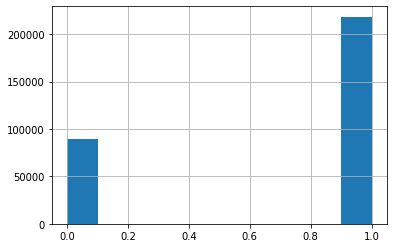


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_4
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 4 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_4, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.01
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_4, dtype: float64

Number of zeros:
307486

Number of NaN in column:
0


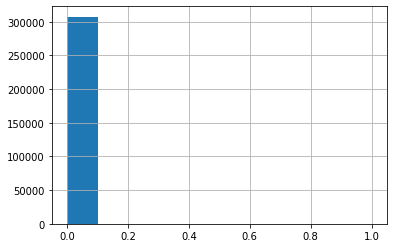


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_5
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 5 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_5, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.02
std          0.12
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_5, dtype: float64

Number of zeros:
302863

Number of NaN in column:
0


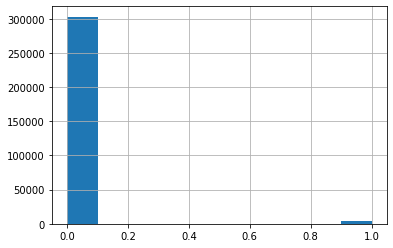


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_6
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 6 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_6, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.09
std          0.28
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_6, dtype: float64

Number of zeros:
280433

Number of NaN in column:
0


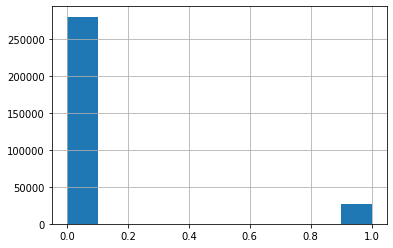


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_7
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 7 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_7, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.01
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_7, dtype: float64

Number of zeros:
307452

Number of NaN in column:
0


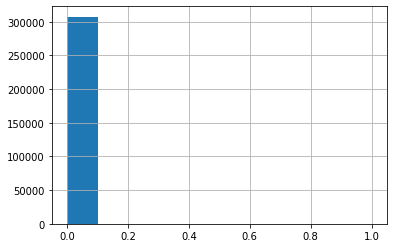


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_8
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 8 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    1
Name: FLAG_DOCUMENT_8, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.08
std          0.27
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_8, dtype: float64

Number of zeros:
282487

Number of NaN in column:
0


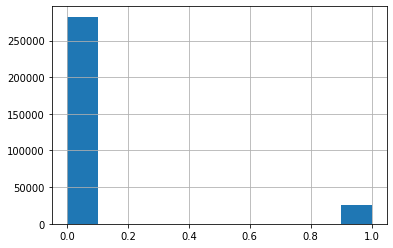


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_9
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 9 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_9, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_9, dtype: float64

Number of zeros:
306313

Number of NaN in column:
0


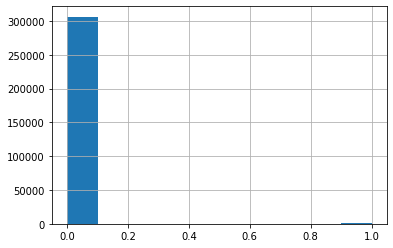


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_10
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 10 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_10, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_10, dtype: float64

Number of zeros:
307504

Number of NaN in column:
0


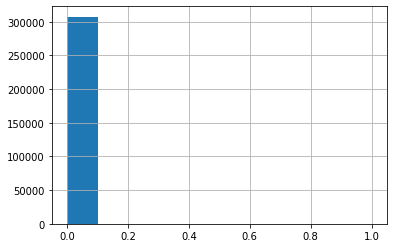


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_11
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 11 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_11, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_11, dtype: float64

Number of zeros:
306308

Number of NaN in column:
0


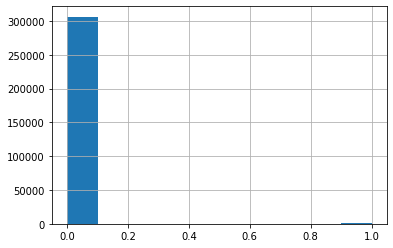


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_12
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 12 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_12, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_12, dtype: float64

Number of zeros:
307509

Number of NaN in column:
0


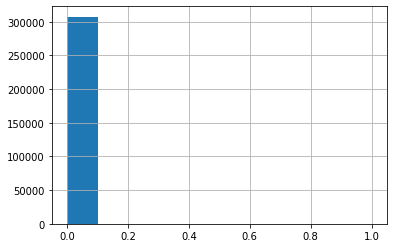


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_13
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 13 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_13, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_13, dtype: float64

Number of zeros:
306427

Number of NaN in column:
0


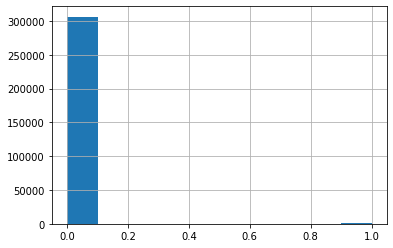


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_14
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 14 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_14, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.05
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_14, dtype: float64

Number of zeros:
306608

Number of NaN in column:
0


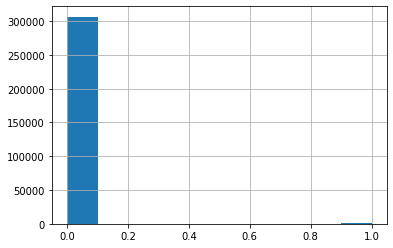


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_15
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 15 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_15, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.03
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_15, dtype: float64

Number of zeros:
307139

Number of NaN in column:
0


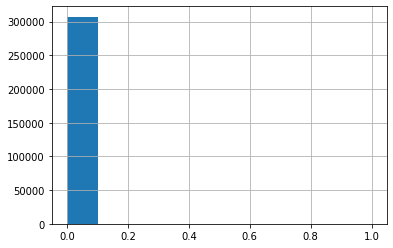


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_16
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 16 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_16, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.01
std          0.10
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_16, dtype: float64

Number of zeros:
304458

Number of NaN in column:
0


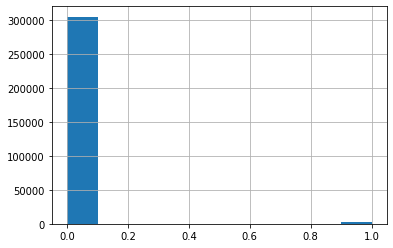


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_17
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 17 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_17, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.02
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_17, dtype: float64

Number of zeros:
307429

Number of NaN in column:
0


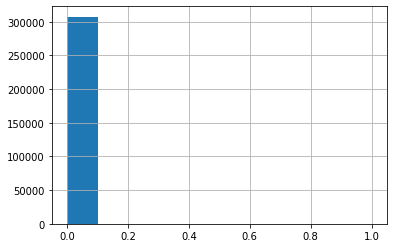


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_18
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 18 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_18, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.01
std          0.09
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_18, dtype: float64

Number of zeros:
305011

Number of NaN in column:
0


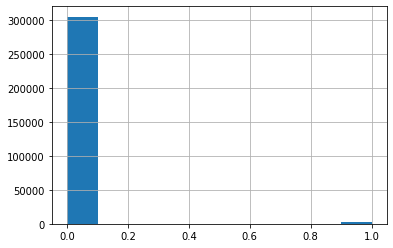


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_19
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 19 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_19, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.02
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_19, dtype: float64

Number of zeros:
307328

Number of NaN in column:
0


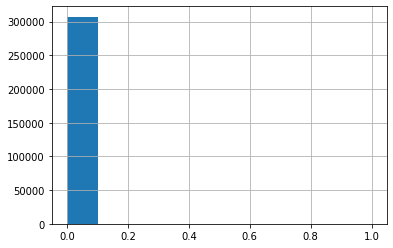


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_20
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 20 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_20, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.02
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_20, dtype: float64

Number of zeros:
307355

Number of NaN in column:
0


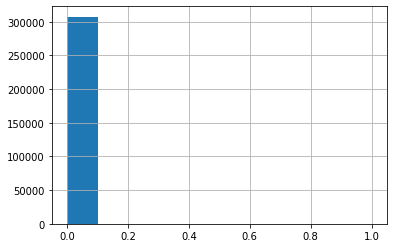


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_DOCUMENT_21
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did client provide document 21 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: FLAG_DOCUMENT_21, dtype: int64

COLUMN STATISTICS:
count   307511.00
mean         0.00
std          0.02
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: FLAG_DOCUMENT_21, dtype: float64

Number of zeros:
307408

Number of NaN in column:
0


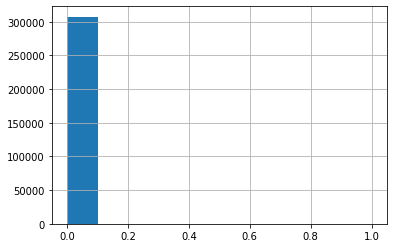

In [18]:
# View statistics about int64 columns
dataframe_analysis(applications, "int64")

### <b> EDA for *object (string)* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CONTRACT_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Identification if loan is cash or revolving 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0         Cash loans
1         Cash loans
2    Revolving loans
3         Cash loans
4         Cash loans
Name: NAME_CONTRACT_TYPE, dtype: object

COLUMN STATISTICS:
count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object

UNIQUE VALUESL
['Cash loans' 'Revolving loans']

Number of NaN in column:
0


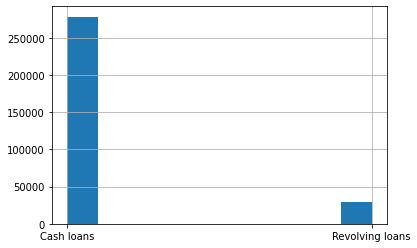


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CODE_GENDER
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Gender of the client 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    M
1    F
2    M
3    F
4    M
Name: CODE_GENDER, dtype: object

COLUMN STATISTICS:
count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object

UNIQUE VALUESL
['M' 'F' 'XNA']

Number of NaN in column:
0


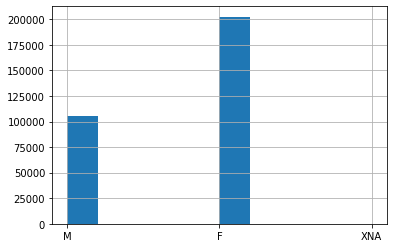


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_OWN_CAR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if the client owns a car 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    N
1    N
2    Y
3    N
4    N
Name: FLAG_OWN_CAR, dtype: object

COLUMN STATISTICS:
count     307511
unique         2
top            N
freq      202924
Name: FLAG_OWN_CAR, dtype: object

UNIQUE VALUESL
['N' 'Y']

Number of NaN in column:
0


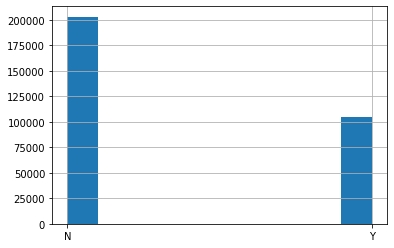


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_OWN_REALTY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if client owns a house or flat 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    Y
1    N
2    Y
3    Y
4    Y
Name: FLAG_OWN_REALTY, dtype: object

COLUMN STATISTICS:
count     307511
unique         2
top            Y
freq      213312
Name: FLAG_OWN_REALTY, dtype: object

UNIQUE VALUESL
['Y' 'N']

Number of NaN in column:
0


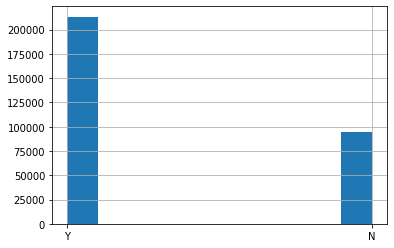


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_TYPE_SUITE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Who was accompanying client when he was applying for the loan 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    Unaccompanied
1           Family
2    Unaccompanied
3    Unaccompanied
4    Unaccompanied
Name: NAME_TYPE_SUITE, dtype: object

COLUMN STATISTICS:
count            306219
unique                7
top       Unaccompanied
freq             248526
Name: NAME_TYPE_SUITE, dtype: object

UNIQUE VALUESL
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']

Number of NaN in column:
1292


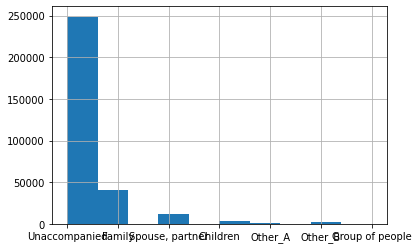


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_INCOME_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Clients income type (businessman, working, maternity leave,…) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0          Working
1    State servant
2          Working
3          Working
4          Working
Name: NAME_INCOME_TYPE, dtype: object

COLUMN STATISTICS:
count      307511
unique          8
top       Working
freq       158774
Name: NAME_INCOME_TYPE, dtype: object

UNIQUE VALUESL
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']

Number of NaN in column:
0


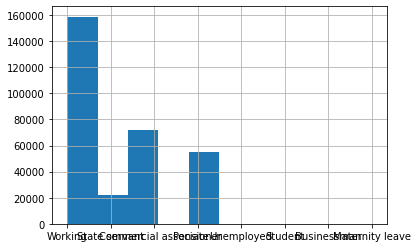


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_EDUCATION_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Level of highest education the client achieved 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    Secondary / secondary special
1                 Higher education
2    Secondary / secondary special
3    Secondary / secondary special
4    Secondary / secondary special
Name: NAME_EDUCATION_TYPE, dtype: object

COLUMN STATISTICS:
count                            307511
unique                                5
top       Secondary / secondary special
freq                             218391
Name: NAME_EDUCATION_TYPE, dtype: object

UNIQUE VALUESL
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

Number of NaN in column:
0


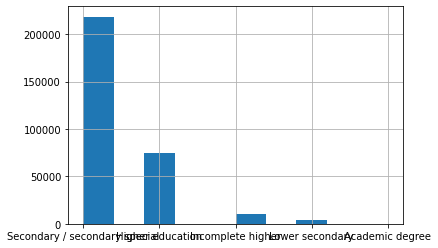


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_FAMILY_STATUS
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Family status of the client 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    Single / not married
1                 Married
2    Single / not married
3          Civil marriage
4    Single / not married
Name: NAME_FAMILY_STATUS, dtype: object

COLUMN STATISTICS:
count      307511
unique          6
top       Married
freq       196432
Name: NAME_FAMILY_STATUS, dtype: object

UNIQUE VALUESL
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']

Number of NaN in column:
0


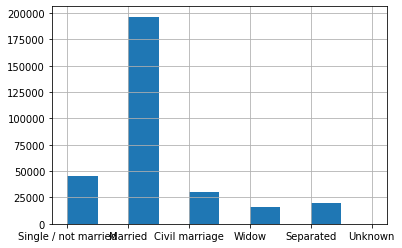


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_HOUSING_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
What is the housing situation of the client (renting, living with parents, ...) 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    House / apartment
1    House / apartment
2    House / apartment
3    House / apartment
4    House / apartment
Name: NAME_HOUSING_TYPE, dtype: object

COLUMN STATISTICS:
count                307511
unique                    6
top       House / apartment
freq                 272868
Name: NAME_HOUSING_TYPE, dtype: object

UNIQUE VALUESL
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']

Number of NaN in column:
0


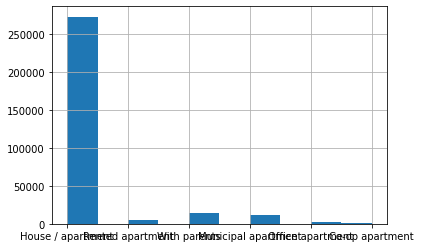


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: OCCUPATION_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
What kind of occupation does the client have 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0      Laborers
1    Core staff
2      Laborers
3      Laborers
4    Core staff
Name: OCCUPATION_TYPE, dtype: object

COLUMN STATISTICS:
count       211120
unique          18
top       Laborers
freq         55186
Name: OCCUPATION_TYPE, dtype: object

UNIQUE VALUESL
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']

Number of NaN in column:
96391


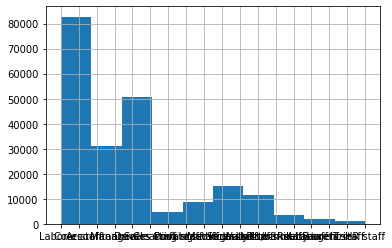


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: WEEKDAY_APPR_PROCESS_START
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
On which day of the week did the client apply for the loan 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    WEDNESDAY
1       MONDAY
2       MONDAY
3    WEDNESDAY
4     THURSDAY
Name: WEEKDAY_APPR_PROCESS_START, dtype: object

COLUMN STATISTICS:
count      307511
unique          7
top       TUESDAY
freq        53901
Name: WEEKDAY_APPR_PROCESS_START, dtype: object

UNIQUE VALUESL
['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']

Number of NaN in column:
0


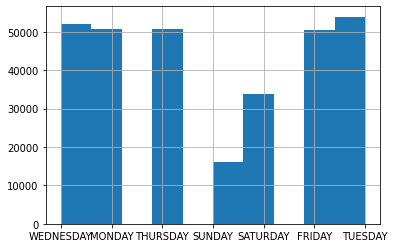


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: ORGANIZATION_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Type of organization where client works 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    Business Entity Type 3
1                    School
2                Government
3    Business Entity Type 3
4                  Religion
Name: ORGANIZATION_TYPE, dtype: object

COLUMN STATISTICS:
count                     307511
unique                        58
top       Business Entity Type 3
freq                       67992
Name: ORGANIZATION_TYPE, dtype: object

UNIQUE VALUESL
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministri

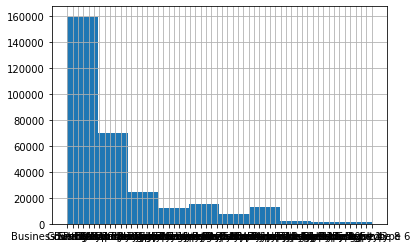


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FONDKAPREMONT_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    reg oper account
1    reg oper account
2                 NaN
3                 NaN
4                 NaN
Name: FONDKAPREMONT_MODE, dtype: object

COLUMN STATISTICS:
count                97216
unique                   4
top       reg oper account
freq                 73830
Name: FONDKAPREMONT_MODE, dtype: object

UNIQUE VALUESL
['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']

Number 

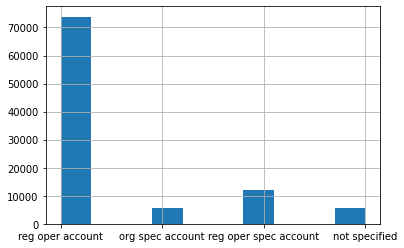


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: HOUSETYPE_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    block of flats
1    block of flats
2               NaN
3               NaN
4               NaN
Name: HOUSETYPE_MODE, dtype: object

COLUMN STATISTICS:
count             153214
unique                 3
top       block of flats
freq              150503
Name: HOUSETYPE_MODE, dtype: object

UNIQUE VALUESL
['block of flats' nan 'terraced house' 'specific housing']

Number of NaN in column:
154297


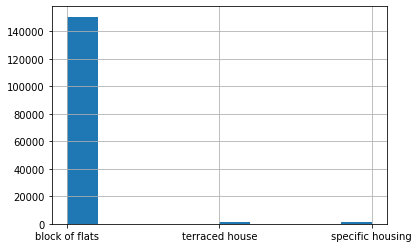


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: WALLSMATERIAL_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0    Stone, brick
1           Block
2             NaN
3             NaN
4             NaN
Name: WALLSMATERIAL_MODE, dtype: object

COLUMN STATISTICS:
count     151170
unique         7
top        Panel
freq       66040
Name: WALLSMATERIAL_MODE, dtype: object

UNIQUE VALUESL
['Stone, brick' 'Block' nan 'Panel' 'Mixed' 'Wooden' 'Others' 'Monolithic']

Number of NaN in column:
156341


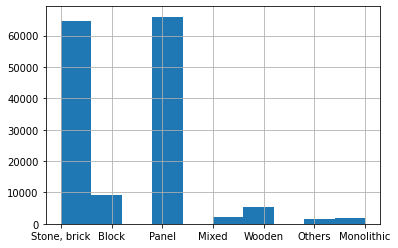


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: EMERGENCYSTATE_MODE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

SPECIAL MENTIONS:
No special mentions about this column 

TOP 5 ROWS:
0     No
1     No
2    NaN
3    NaN
4    NaN
Name: EMERGENCYSTATE_MODE, dtype: object

COLUMN STATISTICS:
count     161756
unique         2
top           No
freq      159428
Name: EMERGENCYSTATE_MODE, dtype: object

UNIQUE VALUESL
['No' nan 'Yes']

Number of NaN in column:
145755


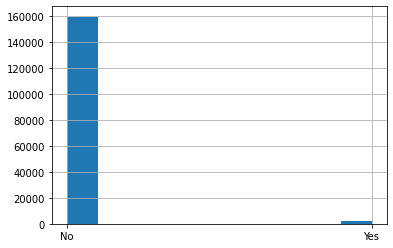

In [19]:
# View statistics about object columns
dataframe_analysis(applications, "object")

### <b> Analyze correlations

Analyze correlations with the TARGET column to better understand the dataset.

In [20]:
correlations = applications.corr().TARGET.sort_values(ascending=False).drop("TARGET")

In [21]:
# Print 20 most correlated columns
correlations.head(20)

DAYS_BIRTH                    0.08
REGION_RATING_CLIENT_W_CITY   0.06
REGION_RATING_CLIENT          0.06
DAYS_LAST_PHONE_CHANGE        0.06
DAYS_ID_PUBLISH               0.05
REG_CITY_NOT_WORK_CITY        0.05
FLAG_EMP_PHONE                0.05
REG_CITY_NOT_LIVE_CITY        0.04
FLAG_DOCUMENT_3               0.04
DAYS_REGISTRATION             0.04
OWN_CAR_AGE                   0.04
LIVE_CITY_NOT_WORK_CITY       0.03
DEF_30_CNT_SOCIAL_CIRCLE      0.03
DEF_60_CNT_SOCIAL_CIRCLE      0.03
FLAG_WORK_PHONE               0.03
AMT_REQ_CREDIT_BUREAU_YEAR    0.02
CNT_CHILDREN                  0.02
CNT_FAM_MEMBERS               0.01
OBS_30_CNT_SOCIAL_CIRCLE      0.01
OBS_60_CNT_SOCIAL_CIRCLE      0.01
Name: TARGET, dtype: float64

In [22]:
# Print 20 least correlated columns
correlations.tail(20)

AMT_CREDIT                   -0.03
LIVINGAREA_MODE              -0.03
ELEVATORS_MODE               -0.03
TOTALAREA_MODE               -0.03
FLOORSMIN_MODE               -0.03
LIVINGAREA_MEDI              -0.03
LIVINGAREA_AVG               -0.03
FLOORSMIN_MEDI               -0.03
FLOORSMIN_AVG                -0.03
ELEVATORS_MEDI               -0.03
ELEVATORS_AVG                -0.03
REGION_POPULATION_RELATIVE   -0.04
AMT_GOODS_PRICE              -0.04
FLOORSMAX_MODE               -0.04
FLOORSMAX_MEDI               -0.04
FLOORSMAX_AVG                -0.04
DAYS_EMPLOYED                -0.04
EXT_SOURCE_1                 -0.16
EXT_SOURCE_2                 -0.16
EXT_SOURCE_3                 -0.18
Name: TARGET, dtype: float64

<AxesSubplot:>

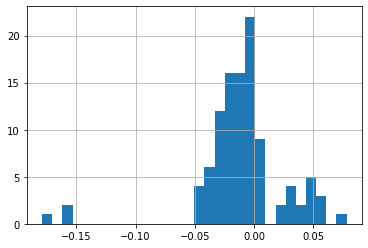

In [23]:
# View correlations histogram
correlations.hist(bins=30)

<a id=4></a>
<div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#5f0f40;overflow:hidden;font-weight:500"><b>4. Initial Preprocessing</b></div>

[go on top ↑](#0)

## <b>Managing missing values

For *float64* and *int64* columns I will fill NaN values with the mean.
For *object* columns NaNs will be automatically processed when performing one-hot encoding.

In [24]:
# Fill NaN with mean for numeric columns
for column in applications.columns:
    if applications[column].dtype != "object":
        applications[column].fillna(applications[column].mean(),
                                    inplace=True)        

## <b> Managing anomalies

During EDA I have noticed that the column Days Employeed has 
some anomalies. More than 50000 people worked for
more than 1000 years ar current job. This is not good
Will replace this with the mean value.

count   307511.00
mean     63815.05
std     141275.77
min     -17912.00
25%      -2760.00
50%      -1213.00
75%       -289.00
max     365243.00
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:>

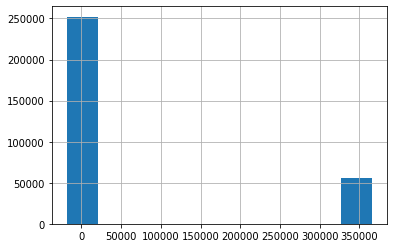

In [25]:
applications["DAYS_EMPLOYED"].describe()
applications["DAYS_EMPLOYED"].hist()

In [26]:
# Get mean value excepting anomalies
days_employed_mean = applications[applications.DAYS_EMPLOYED<300000].DAYS_EMPLOYED.mean()

It is ok that the value is negative, as seen in EDA, in this column, all values, except for anomalies, are negative.

In [27]:
applications["DAYS_EMPLOYED"].replace(to_replace=365243.00, 
                                      value=days_employed_mean,
                                      inplace=True)

<AxesSubplot:>

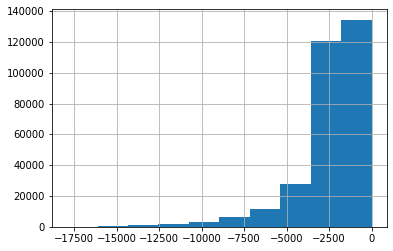

In [28]:
applications["DAYS_EMPLOYED"].hist()

## One-hot encoding

In [ ]:
# Copy of data for later experiments
applications_copy = applications.copy()

In [30]:
applications.dtypes.value_counts()

float64    66
int64      40
object     16
dtype: int64

In [31]:
# One-hot encode object columns
object_columns = applications.select_dtypes("object").columns
applications = pd.get_dummies(data=applications,
                         columns=object_columns,
                         dummy_na=False,
                         drop_first=False)
applications.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.00,406597.50,24700.50,351000.00,0.02,-9461,-637.00,-3648.00,-2120,12.06,1,1,0,1,1,0,1.00,2,2,10,0,0,0,0,0,0,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.00,1293502.50,35698.50,1129500.00,0.00,-16765,-1188.00,-1186.00,-291,12.06,1,1,0,1,1,0,2.00,1,1,11,0,0,0,0,0,0,0.31,0.62,0.51,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.00,135000.00,6750.00,135000.00,0.01,-19046,-225.00,-4260.00,-2531,26.00,1,1,1,1,1,0,1.00,2,2,9,0,0,0,0,0,0,0.50,0.56,0.73,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.00,312682.50,29686.50,297000.00,0.01,-19005,-3039.00,-9833.00,-2437,12.06,1,1,0,1,0,0,2.00,2,2,17,0,0,0,0,0,0,0.50,0.65,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.00,513000.00,21865.50,513000.00,0.03,-19932,-3038.00,-4311.00,-3458,12.06,1,1,0,1,0,0,1.00,2,2,11,0,0,0,0,1,1,0.50,0.32,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

## <b> Input scalling

To avoid target leakage I will split the dataset in train and test before training any scaller.
Scaller will be trained only on train data.

In [32]:
# Train/test split. 
# Because this is a big dataset, 10% for test set will be enough
x_train, x_test, y_train, y_test = train_test_split(
    applications.drop(["TARGET", "SK_ID_CURR"], axis=1),
    applications.TARGET,
    random_state=1,
    test_size=0.1,
    stratify=applications.TARGET)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((276759, 244), (30752, 244), (276759,), (30752,))

Will normalize only the columns with mean>1.
The rest columns are already normalized according to data description.

In [33]:
for column in x_train.columns:
    if x_train[column].abs().mean()>1:
        scaler = StandardScaler().fit(x_train[column].to_numpy().reshape(-1,1))
        x_train[column] = scaler.transform(x_train[column].to_numpy().reshape(-1,1))
        x_test[column] = scaler.transform(x_test[column].to_numpy().reshape(-1,1))                

**Conclusions based on above data:**
- The target variable is imbalanced: 92% of our examples are credits that did not default
    - Will need to use a suitable metric. Something like accuracy will be misleading.
- Many columns have missing data. This needs to be addressed
- There are 16 string (object) columnds. Although some algorithms can work with strings,
    I will encode all string columns to be able to test various models on this dataset.

    


<a id=5></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#55828b;overflow:hidden;font-weight:500"><b>5. Baseline</div>

[go on top ↑](#0)

In [34]:
def evaluate(model, features, labels, n_folds=5):
    """
    Function to evaluate the performance of models
    """
    # Rename feature columns
    #features.columns = np.arange(len(features.columns))
    
    # Record initial time
    t0 = time()
    
    # Initialize stratified kfold. Stratified because we have class imbalance
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

    # Initialize variable for storing score
    auc_all_folds = []
    fold = 0
    for train_indices, valid_indices in kfold.split(features, labels):
        train_features = features.iloc[train_indices]
        train_labels = labels.iloc[train_indices]
        validation_features = features.iloc[valid_indices]
        validation_labels = labels.iloc[valid_indices]   

        model = model.fit(train_features, train_labels)
        predictions = model.predict_proba(validation_features)
        
        fpr, tpr, thresholds = roc_curve(validation_labels, predictions[:,1])
        fold_auc = auc(fpr, tpr)
        auc_all_folds.append(fold_auc)
    print(f"Training took {(time()-t0):.0f} seconds")        
    print(f"Mean AUC for all folds is {np.mean(auc_all_folds):.4f}")
  
    print("ROC curve for last model:")
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=fold_auc,
                                   estimator_name="ROC Curve").plot()    
    plt.show()
    return None

## <b> Baseline: Logistic Regression

Training took 17 seconds
Mean AUC for all folds is 0.7459
ROC curve for last model:


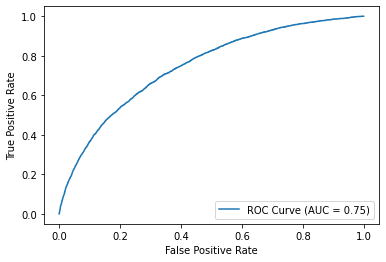

In [35]:
evaluate(LogisticRegression(random_state=1), x_train, y_train)

## <b> KNN 

In [36]:
from sklearn.neighbors import KNeighborsClassifier

Training took 92 seconds
Mean AUC for all folds is 0.5619
ROC curve for last model:


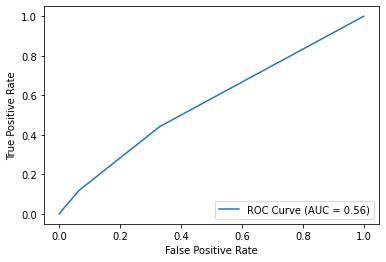

In [37]:
evaluate(KNeighborsClassifier(), x_train, y_train)

## <b> Decision Tree

Training took 80 seconds
Mean AUC for all folds is 0.5362
ROC curve for last model:


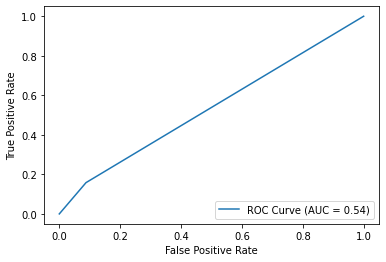

In [38]:
evaluate(DecisionTreeClassifier(random_state=1), x_train, y_train)

## <b> Random Forest

Training took 57 seconds
Mean AUC for all folds is 0.7092
ROC curve for last model:


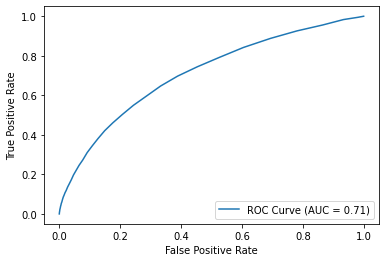

In [39]:
evaluate(RandomForestClassifier(random_state=1, n_jobs=16), x_train, y_train)

## <b> XGBoosting

Training took 74 seconds
Mean AUC for all folds is 0.7245
ROC curve for last model:


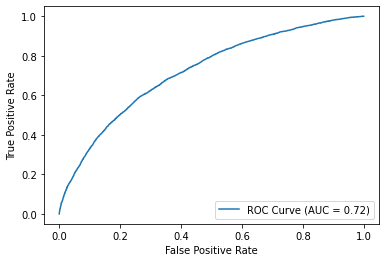

In [ ]:
evaluate(XGBRFClassifier(random_state=1, n_jobs=16), x_train, y_train)

## <b> LGBM

Training took 10 seconds
Mean AUC for all folds is 0.7550
ROC curve for last model:


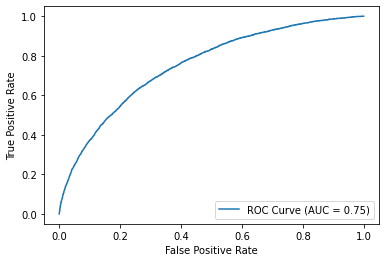

In [42]:
# Rename columns according to LGBM requirments
x_train = x_train.rename(
    columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_test = x_test.rename(
    columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

evaluate(LGBMClassifier(random_state=1, n_jobs=16), x_train, y_train)

## <b> MLP

In [43]:
# Record initial time
t0 = time()

# Initialize stratified kfold. Stratified because we have class imbalance
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Initialize variable for storing score
auc_all_folds = []
fold = 0
for train_indices, valid_indices in kfold.split(x_train, y_train):
    train_features = x_train.iloc[train_indices]
    train_labels = y_train.iloc[train_indices]
    validation_features = x_train.iloc[valid_indices]
    validation_labels = y_train.iloc[valid_indices]       
    
    model = keras.Sequential([
    layers.Dense(50, activation="relu"),
    layers.Dense(30, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["AUC"])
    history = model.fit(train_features,
                        train_labels,
                        epochs=10,
                        batch_size=256,
                        validation_data=(validation_features, validation_labels),
                        verbose=0)
    
    fold_auc = max(history.history["val_auc"])
    
    auc_all_folds.append(fold_auc)

print(f"Training took {(time()-t0):.2f} seconds")
print(f"Mean AUC for all folds is {np.mean(auc_all_folds):.4f}")


Training took 217.15 seconds
Mean AUC for all folds is 0.7465


Seems like LGBMClassifier has the highes AUC

## <b> Some experiments

In [46]:
def split_and_scale(df):
    x_train, x_test, y_train, y_test = train_test_split(
    applications.drop(["TARGET", "SK_ID_CURR"], axis=1),
    applications.TARGET,
    random_state=1,
    test_size=0.1,
    stratify=applications.TARGET)

    for column in x_train.columns:
        if x_train[column].abs().mean()>1:
            scaler = StandardScaler().fit(x_train[column].to_numpy().reshape(-1,1))
            x_train[column] = scaler.transform(x_train[column].to_numpy().reshape(-1,1))
            x_test[column] = scaler.transform(x_test[column].to_numpy().reshape(-1,1))  
    
    x_train = x_train.rename(
        columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    x_test = x_test.rename(
        columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    return x_train, x_test, y_train, y_test

Try to get k-1 dummies out of k categorical levels by removing the first level.
Previous I created k dummies for k categorical levels.


Training took 13 seconds
Mean AUC for all folds is 0.7550
ROC curve for last model:


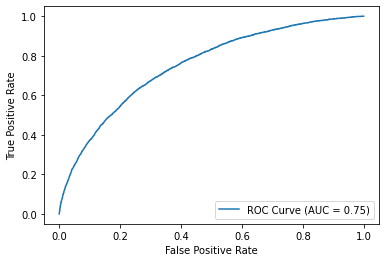

In [48]:
# Try drop first One-hot encoding
applications_new = pd.get_dummies(data=applications_copy,
                         columns=applications_copy.select_dtypes("object").columns,
                         dummy_na=False,
                         drop_first=True)

x_train_new, x_test_new, y_train_new, y_test_new = split_and_scale(applications_new)

evaluate(LGBMClassifier(random_state=1, n_jobs=10), x_train_new, y_train_new)

Try to not create dummy for NaN values in categorical columns

Training took 10 seconds
Mean AUC for all folds is 0.7550
ROC curve for last model:


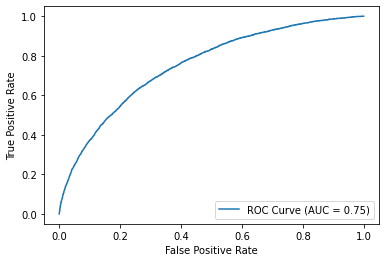

In [49]:
# Try create dummy for NaN
applications_new = pd.get_dummies(data=applications_copy,
                         columns=applications_copy.select_dtypes("object").columns,
                         dummy_na=True,
                         drop_first=False)

x_train_new, x_test_new, y_train_new, y_test_new = split_and_scale(applications_new)

evaluate(LGBMClassifier(random_state=1, n_jobs=10), x_train_new, y_train_new)

No experiment showed improvement over baseling, thus will not change the configuration.

<a id=6></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#489fb5;overflow:hidden;font-weight:500"><b>6. Feature Engineering</b></div>

[go on top ↑](#0)

In [50]:
# Read files
app = pd.read_csv("./data/applications.csv").drop("TARGET", axis=1)
bureau = pd.read_csv("./data/bureau.csv")
bureau_balance = pd.read_csv("./data/bureau_balance.csv")
credit = pd.read_csv("./data/credit_card_balance.csv")
cash = pd.read_csv("./data/pos_cash_balance.csv")
previous = pd.read_csv("./data/previous_application.csv")
installments = pd.read_csv("./data/installments_payments.csv")            

In [51]:
app.shape

(307511, 121)

## <b>Additional EDA

Lets do some more EDA before constructing new features

In [52]:
columns_description.Table.unique()

array(['applications.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

### <b>bureau.csv

In [53]:
# View shape of file
bureau.shape

(1716428, 17)

In [54]:
# View first 5 rows
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,91323.00,0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.00,NaN,NaN,0,225000.00,171342.00,NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,464323.50,NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.00,NaN,77674.50,0,2700000.00,NaN,NaN,0.00,Consumer credit,-21,NaN


In [55]:
# View last 5 rows
bureau.tail()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1716423,259355,5057750,Active,currency 1,-44,0,-30.00,NaN,0.00,0,11250.00,11250.00,0.00,0.00,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.00,-2493.00,5476.50,0,38130.84,0.00,0.00,0.00,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.00,-970.00,NaN,0,15570.00,NaN,NaN,0.00,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.00,-1513.00,NaN,0,36000.00,0.00,0.00,0.00,Consumer credit,-1508,NaN
1716427,246829,5057778,Closed,currency 1,-463,0,NaN,-387.00,NaN,0,22500.00,0.00,NaN,0.00,Microloan,-387,NaN


In [56]:
# View dataframe statistics
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1716428.00,1716428.00,1716428.00,1716428.00,1610875.00,1082775.00,591940.00,1716428.00,1716415.00,1458759.00,1124648.00,1716428.00,1716428.00,489637.00
mean,278214.93,5924434.49,-1142.11,0.82,510.52,-1017.44,3825.42,0.01,354994.59,137085.12,6229.51,37.91,-593.75,15712.76
std,102938.56,532265.73,795.16,36.54,4994.22,714.01,206031.61,0.10,1149811.34,677401.13,45032.03,5937.65,720.75,325826.95
min,100001.00,5000000.00,-2922.00,0.00,-42060.00,-42023.00,0.00,0.00,0.00,-4705600.32,-586406.11,0.00,-41947.00,0.00
25%,188866.75,5463953.75,-1666.00,0.00,-1138.00,-1489.00,0.00,0.00,51300.00,0.00,0.00,0.00,-908.00,0.00
50%,278055.00,5926303.50,-987.00,0.00,-330.00,-897.00,0.00,0.00,125518.50,0.00,0.00,0.00,-395.00,0.00
75%,367426.00,6385681.25,-474.00,0.00,474.00,-425.00,0.00,0.00,315000.00,40153.50,0.00,0.00,-33.00,13500.00
max,456255.00,6843457.00,0.00,2792.00,31199.00,0.00,115987185.00,9.00,585000000.00,170100000.00,4705600.32,3756681.00,372.00,118453423.50


In [57]:
# View columns datatypes
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_CREDIT_ENDDATE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Remaining duration of CB credit (in days) at the time of application in Home Credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -153.00
1   1075.00
2    528.00
3       NaN
4   1197.00
Name: DAYS_CREDIT_ENDDATE, dtype: float64

COLUMN STATISTICS:
count   1610875.00
mean        510.52
std        4994.22
min      -42060.00
25%       -1138.00
50%        -330.00
75%         474.00
max       31199.00
Name: DAYS_CREDIT_ENDDATE, dtype: float64

Number of zeros:
883

Number of NaN in column:
105553


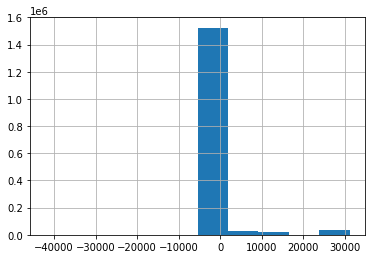


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_ENDDATE_FACT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Days since CB credit ended at the time of application in Home Credit (only for closed credit) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -153.00
1       NaN
2       NaN
3       NaN
4       NaN
Name: DAYS_ENDDATE_FACT, dtype: float64

COLUMN STATISTICS:
count   1082775.00
mean      -1017.44
std         714.01
min      -42023.00
25%       -1489.00
50%        -897.00
75%        -425.00
max           0.00
Name: DAYS_ENDDATE_FACT, dtype: float64

Number of zeros:
64

Number of NaN in column:
633653


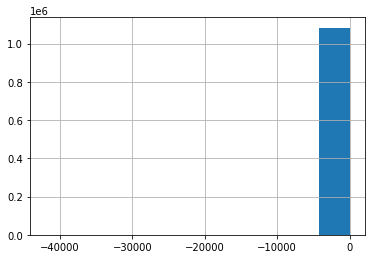


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT_MAX_OVERDUE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        NaN
1        NaN
2        NaN
3        NaN
4   77674.50
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

COLUMN STATISTICS:
count      591940.00
mean         3825.42
std        206031.61
min             0.00
25%             0.00
50%             0.00
75%             0.00
max     115987185.00
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

Number of zeros:
470650

Number of NaN in column:
1124488


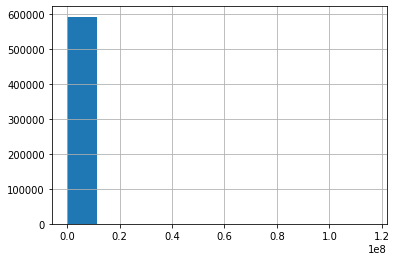


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT_SUM
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Current credit amount for the Credit Bureau credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0     91323.00
1    225000.00
2    464323.50
3     90000.00
4   2700000.00
Name: AMT_CREDIT_SUM, dtype: float64

COLUMN STATISTICS:
count     1716415.00
mean       354994.59
std       1149811.34
min             0.00
25%         51300.00
50%        125518.50
75%        315000.00
max     585000000.00
Name: AMT_CREDIT_SUM, dtype: float64

Number of zeros:
66582

Number of NaN in column:
13


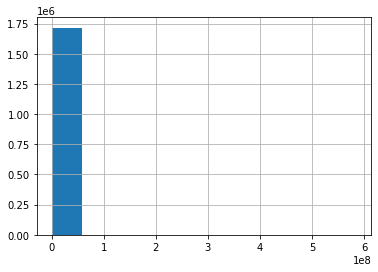


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT_SUM_DEBT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Current debt on Credit Bureau credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        0.00
1   171342.00
2         NaN
3         NaN
4         NaN
Name: AMT_CREDIT_SUM_DEBT, dtype: float64

COLUMN STATISTICS:
count     1458759.00
mean       137085.12
std        677401.13
min      -4705600.32
25%             0.00
50%             0.00
75%         40153.50
max     170100000.00
Name: AMT_CREDIT_SUM_DEBT, dtype: float64

Number of zeros:
1016434

Number of NaN in column:
257669


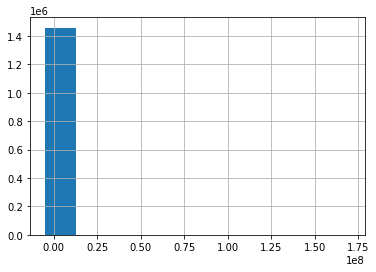


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT_SUM_LIMIT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Current credit limit of credit card reported in Credit Bureau 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

COLUMN STATISTICS:
count   1124648.00
mean       6229.51
std       45032.03
min     -586406.11
25%           0.00
50%           0.00
75%           0.00
max     4705600.32
Name: AMT_CREDIT_SUM_LIMIT, dtype: float64

Number of zeros:
1050142

Number of NaN in column:
591780


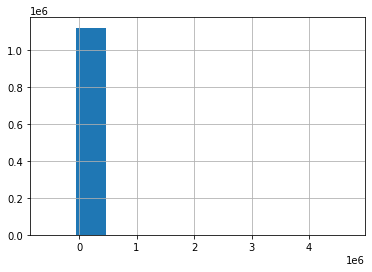


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT_SUM_OVERDUE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Current amount overdue on Credit Bureau credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3   0.00
4   0.00
Name: AMT_CREDIT_SUM_OVERDUE, dtype: float64

COLUMN STATISTICS:
count   1716428.00
mean         37.91
std        5937.65
min           0.00
25%           0.00
50%           0.00
75%           0.00
max     3756681.00
Name: AMT_CREDIT_SUM_OVERDUE, dtype: float64

Number of zeros:
1712270

Number of NaN in column:
0


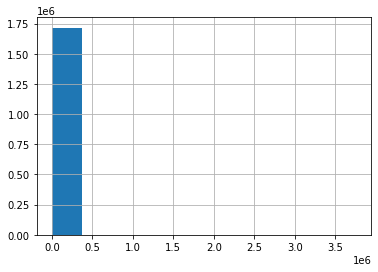


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_ANNUITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Annuity of the Credit Bureau credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: AMT_ANNUITY, dtype: float64

COLUMN STATISTICS:
count      489637.00
mean        15712.76
std        325826.95
min             0.00
25%             0.00
50%             0.00
75%         13500.00
max     118453423.50
Name: AMT_ANNUITY, dtype: float64

Number of zeros:
256915

Number of NaN in column:
1226791


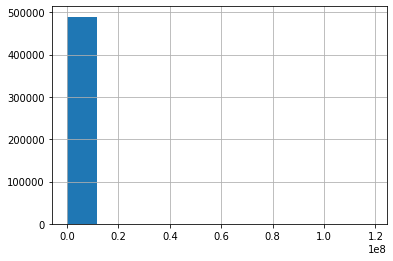

In [58]:
# View statistics about float64 columns
dataframe_analysis(bureau, "float64", table_name="bureau.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau  

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    215354
1    215354
2    215354
3    215354
4    215354
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean     278214.93
std      102938.56
min      100001.00
25%      188866.75
50%      278055.00
75%      367426.00
max      456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


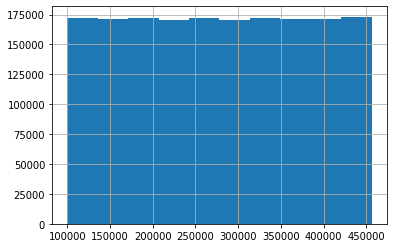


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_BUREAU
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    5714462
1    5714463
2    5714464
3    5714465
4    5714466
Name: SK_ID_BUREAU, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean    5924434.49
std      532265.73
min     5000000.00
25%     5463953.75
50%     5926303.50
75%     6385681.25
max     6843457.00
Name: SK_ID_BUREAU, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


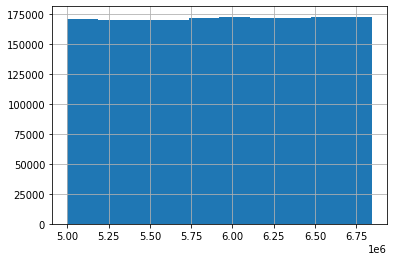


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_CREDIT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many days before current application did client apply for Credit Bureau credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -497
1   -208
2   -203
3   -203
4   -629
Name: DAYS_CREDIT, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean      -1142.11
std         795.16
min       -2922.00
25%       -1666.00
50%        -987.00
75%        -474.00
max           0.00
Name: DAYS_CREDIT, dtype: float64

Number of zeros:
25

Number of NaN in column:
0


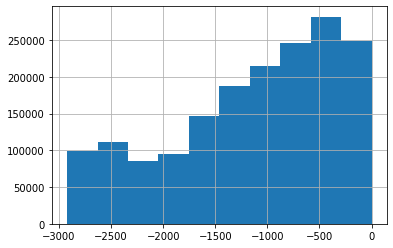


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CREDIT_DAY_OVERDUE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of days past due on CB credit at the time of application for related loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: CREDIT_DAY_OVERDUE, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean          0.82
std          36.54
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        2792.00
Name: CREDIT_DAY_OVERDUE, dtype: float64

Number of zeros:
1712211

Number of NaN in column:
0


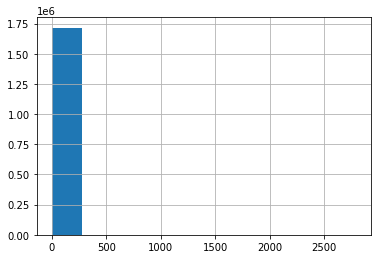


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_CREDIT_PROLONG
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many times was the Credit Bureau credit prolonged 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: CNT_CREDIT_PROLONG, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean          0.01
std           0.10
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           9.00
Name: CNT_CREDIT_PROLONG, dtype: float64

Number of zeros:
1707314

Number of NaN in column:
0


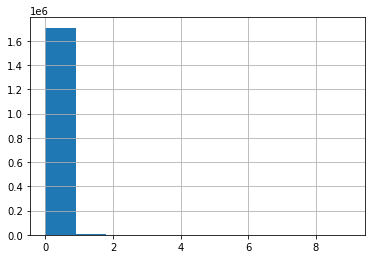


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_CREDIT_UPDATE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How many days before loan application did last information about the Credit Bureau credit come 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -131
1    -20
2    -16
3    -16
4    -21
Name: DAYS_CREDIT_UPDATE, dtype: int64

COLUMN STATISTICS:
count   1716428.00
mean       -593.75
std         720.75
min      -41947.00
25%        -908.00
50%        -395.00
75%         -33.00
max         372.00
Name: DAYS_CREDIT_UPDATE, dtype: float64

Number of zeros:
605

Number of NaN in column:
0


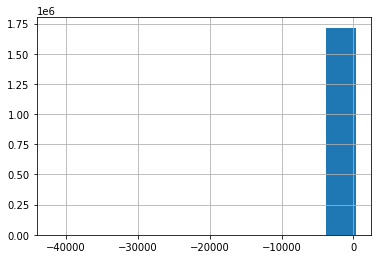

In [59]:
# View statistics about int64 columns
dataframe_analysis(bureau, "int64", table_name="bureau.csv")

#### <b> EDA for *object (string)* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CREDIT_ACTIVE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Status of the Credit Bureau (CB) reported credits 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Closed
1    Active
2    Active
3    Active
4    Active
Name: CREDIT_ACTIVE, dtype: object

COLUMN STATISTICS:
count     1716428
unique          4
top        Closed
freq      1079273
Name: CREDIT_ACTIVE, dtype: object

UNIQUE VALUESL
['Closed' 'Active' 'Sold' 'Bad debt']

Number of NaN in column:
0


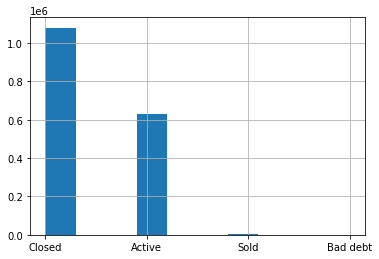


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CREDIT_CURRENCY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Recoded currency of the Credit Bureau credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    currency 1
1    currency 1
2    currency 1
3    currency 1
4    currency 1
Name: CREDIT_CURRENCY, dtype: object

COLUMN STATISTICS:
count        1716428
unique             4
top       currency 1
freq         1715020
Name: CREDIT_CURRENCY, dtype: object

UNIQUE VALUESL
['currency 1' 'currency 2' 'currency 4' 'currency 3']

Number of NaN in column:
0


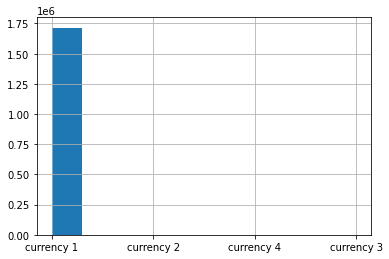


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CREDIT_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Type of Credit Bureau credit (Car, cash,...) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Consumer credit
1        Credit card
2    Consumer credit
3        Credit card
4    Consumer credit
Name: CREDIT_TYPE, dtype: object

COLUMN STATISTICS:
count             1716428
unique                 15
top       Consumer credit
freq              1251615
Name: CREDIT_TYPE, dtype: object

UNIQUE VALUESL
['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin 

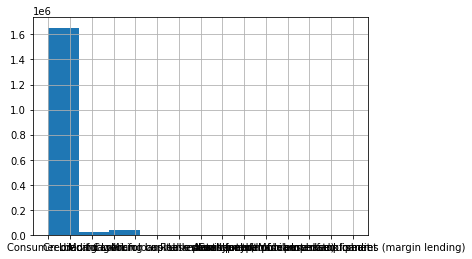

In [60]:
# View statistics about object columns
dataframe_analysis(bureau, "object", table_name="bureau.csv")

### <b>bureau_balance.csv

In [61]:
# View shape of file
bureau_balance.shape

(27299925, 3)

In [62]:
# View first 5 rows
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [63]:
# View last 5 rows
bureau_balance.tail()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X
27299924,5041336,-51,X


In [64]:
# View dataframe statistics
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,27299925.00,27299925.00
mean,6036297.33,-30.74
std,492348.86,23.86
min,5001709.00,-96.00
25%,5730933.00,-46.00
50%,6070821.00,-25.00
75%,6431951.00,-11.00
max,6842888.00,0.00


In [65]:
# View columns datatypes
bureau_balance.dtypes.value_counts()

int64     2
object    1
dtype: int64

#### <b> EDA for *float64* columns

In [66]:
# View statistics about float64 columns
dataframe_analysis(bureau_balance, "float64", table_name="bureau_balance.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_BUREAU
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    5715448
1    5715448
2    5715448
3    5715448
4    5715448
Name: SK_ID_BUREAU, dtype: int64

COLUMN STATISTICS:
count   27299925.00
mean     6036297.33
std       492348.86
min      5001709.00
25%      5730933.00
50%      6070821.00
75%      6431951.00
max      6842888.00
Name: SK_ID_BUREAU, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


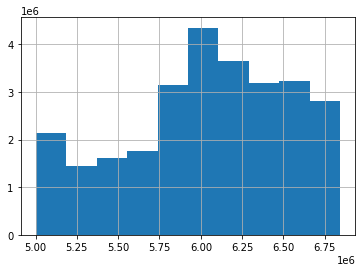


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: MONTHS_BALANCE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Month of balance relative to application date (-1 means the freshest balance date) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1   -1
2   -2
3   -3
4   -4
Name: MONTHS_BALANCE, dtype: int64

COLUMN STATISTICS:
count   27299925.00
mean         -30.74
std           23.86
min          -96.00
25%          -46.00
50%          -25.00
75%          -11.00
max            0.00
Name: MONTHS_BALANCE, dtype: float64

Number of zeros:
610965

Number of NaN in column:
0


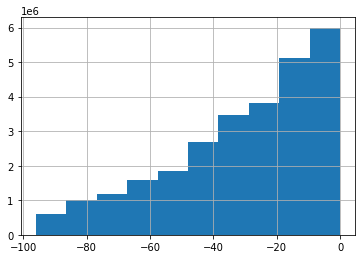

In [67]:
# View statistics about int64 columns
dataframe_analysis(bureau_balance, "int64", table_name="bureau_balance.csv")

#### <b> EDA for *object (string)* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: STATUS
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] ) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    C
1    C
2    C
3    C
4    C
Name: STATUS, dtype: object

COLUMN STATISTICS:
count     27299925
unique           8
top              C
freq      13646993
Name: STATUS, dtype: object

UNIQUE VALUESL
['C' '0' 'X' '1' '2' '3' '5' '4']

Number of NaN in column:
0


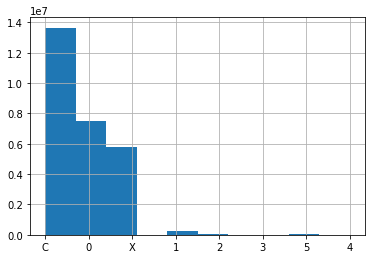

In [68]:
# View statistics about object columns
dataframe_analysis(bureau_balance, "object", table_name="bureau_balance.csv")

### <b>POS_CASH_balance.csv

In [69]:
# View shape of file
cash.shape

(10001358, 8)

In [70]:
# View first 5 rows
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


In [71]:
# View last 5 rows
cash.tail()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
10001353,2448283,226558,-20,6.00,0.00,Active,843,0
10001354,1717234,141565,-19,12.00,0.00,Active,602,0
10001355,1283126,315695,-21,10.00,0.00,Active,609,0
10001356,1082516,450255,-22,12.00,0.00,Active,614,0
10001357,1259607,174278,-52,16.00,0.00,Completed,0,0


In [72]:
# View dataframe statistics
cash.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,10001358.00,10001358.00,10001358.00,9975287.00,9975271.00,10001358.00,10001358.00
mean,1903216.60,278403.86,-35.01,17.09,10.48,11.61,0.65
std,535846.53,102763.75,26.07,12.00,11.11,132.71,32.76
min,1000001.00,100001.00,-96.00,1.00,0.00,0.00,0.00
25%,1434405.00,189550.00,-54.00,10.00,3.00,0.00,0.00
50%,1896565.00,278654.00,-28.00,12.00,7.00,0.00,0.00
75%,2368963.00,367429.00,-13.00,24.00,14.00,0.00,0.00
max,2843499.00,456255.00,-1.00,92.00,85.00,4231.00,3595.00


In [73]:
# View columns datatypes
cash.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_INSTALMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Term of previous credit (can change over time) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   48.00
1   36.00
2   12.00
3   48.00
4   36.00
Name: CNT_INSTALMENT, dtype: float64

COLUMN STATISTICS:
count   9975287.00
mean         17.09
std          12.00
min           1.00
25%          10.00
50%          12.00
75%          24.00
max          92.00
Name: CNT_INSTALMENT, dtype: float64

Number of zeros:
0

Number of NaN in column:
26071


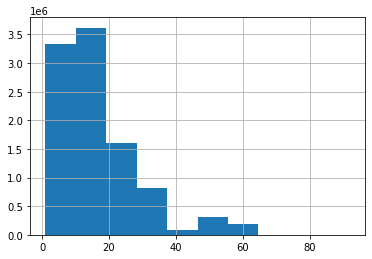


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_INSTALMENT_FUTURE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Installments left to pay on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   45.00
1   35.00
2    9.00
3   42.00
4   35.00
Name: CNT_INSTALMENT_FUTURE, dtype: float64

COLUMN STATISTICS:
count   9975271.00
mean         10.48
std          11.11
min           0.00
25%           3.00
50%           7.00
75%          14.00
max          85.00
Name: CNT_INSTALMENT_FUTURE, dtype: float64

Number of zeros:
1185960

Number of NaN in column:
26087


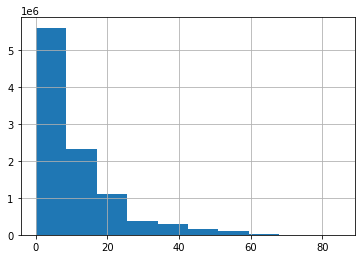

In [74]:
# View statistics about float64 columns
dataframe_analysis(cash, "float64", table_name="POS_CASH_balance.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    1803195
1    1715348
2    1784872
3    1903291
4    2341044
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean     1903216.60
std       535846.53
min      1000001.00
25%      1434405.00
50%      1896565.00
75%      2368963.00
max      2843499.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


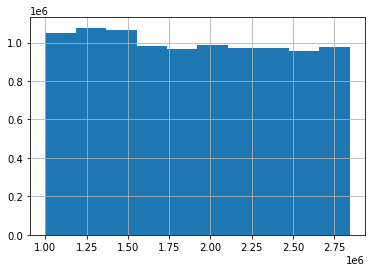


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    182943
1    367990
2    397406
3    269225
4    334279
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean      278403.86
std       102763.75
min       100001.00
25%       189550.00
50%       278654.00
75%       367429.00
max       456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


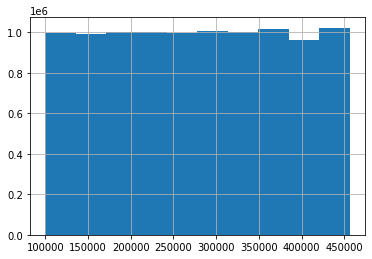


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: MONTHS_BALANCE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly ) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -31
1   -33
2   -32
3   -35
4   -35
Name: MONTHS_BALANCE, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean         -35.01
std           26.07
min          -96.00
25%          -54.00
50%          -28.00
75%          -13.00
max           -1.00
Name: MONTHS_BALANCE, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


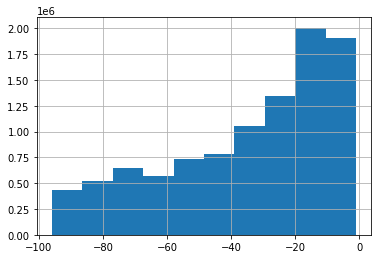


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_DPD
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
DPD (days past due) during the month of previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: SK_DPD, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean          11.61
std          132.71
min            0.00
25%            0.00
50%            0.00
75%            0.00
max         4231.00
Name: SK_DPD, dtype: float64

Number of zeros:
9706131

Number of NaN in column:
0


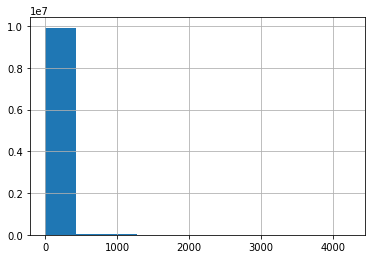


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_DPD_DEF
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: SK_DPD_DEF, dtype: int64

COLUMN STATISTICS:
count   10001358.00
mean           0.65
std           32.76
min            0.00
25%            0.00
50%            0.00
75%            0.00
max         3595.00
Name: SK_DPD_DEF, dtype: float64

Number of zeros:
9887389

Number of NaN in column:
0


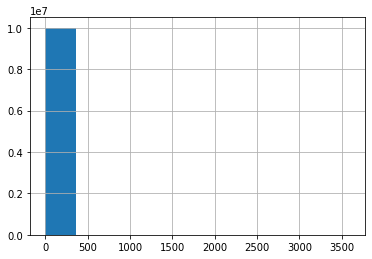

In [75]:
# View statistics about int64 columns
dataframe_analysis(cash, "int64", table_name="POS_CASH_balance.csv")

#### <b> EDA for *object (string)* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CONTRACT_STATUS
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Contract status during the month 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Active
1    Active
2    Active
3    Active
4    Active
Name: NAME_CONTRACT_STATUS, dtype: object

COLUMN STATISTICS:
count     10001358
unique           9
top         Active
freq       9151119
Name: NAME_CONTRACT_STATUS, dtype: object

UNIQUE VALUESL
['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']

Number of NaN in column:
0


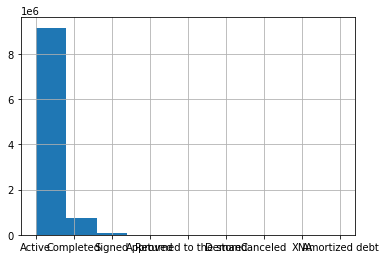

In [76]:
# View statistics about object columns
dataframe_analysis(cash, "object", table_name="POS_CASH_balance.csv")

### <b>credit_card_balance.csv

In [77]:
# View shape of file
credit.shape

(3840312, 23)

In [78]:
# View first 5 rows
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,1700.33,1800.00,1800.00,0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,63975.56,45000,2250.00,2250.00,0.00,0.00,2250.00,2250.00,2250.00,60175.08,64875.56,64875.56,1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,31815.22,450000,0.00,0.00,0.00,0.00,2250.00,2250.00,2250.00,26926.42,31460.08,31460.08,0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,236572.11,225000,2250.00,2250.00,0.00,0.00,11795.76,11925.00,11925.00,224949.29,233048.97,233048.97,1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,453919.46,450000,0.00,11547.00,0.00,11547.00,22924.89,27000.00,27000.00,443044.40,453919.46,453919.46,0.00,1,0.00,1.00,101.00,Active,0,0


In [79]:
# View last 5 rows
credit.tail()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3840307,1036507,328243,-9,0.00,45000,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0
3840308,1714892,347207,-9,0.00,45000,0.00,0.00,0.00,0.00,0.00,1879.11,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,23.00,Active,0,0
3840309,1302323,215757,-9,275784.97,585000,270000.00,270000.00,0.00,0.00,2250.00,375750.00,356994.67,269356.14,273093.97,273093.97,2.00,2,0.00,0.00,18.00,Active,0,0
3840310,1624872,430337,-10,0.00,450000,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0
3840311,2411345,236760,-10,0.00,157500,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,21.00,Completed,0,0


In [80]:
# View dataframe statistics
credit.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3840312.00,3840312.00,3840312.00,3840312.00,3840312.00,3090496.00,3840312.00,3090496.00,3090496.00,3535076.00,3072324.00,3840312.00,3840312.00,3840312.00,3840312.00,3090496.00,3840312.00,3090496.00,3090496.00,3535076.00,3840312.00,3840312.00
mean,1904503.59,278324.21,-34.52,58300.16,153807.96,5961.32,7433.39,288.17,2968.80,3540.20,10280.54,7588.86,55965.88,58088.81,58098.29,0.31,0.70,0.00,0.56,20.83,9.28,0.33
std,536469.47,102704.48,26.67,106307.03,165145.70,28225.69,33846.08,8201.99,20796.89,5600.15,36078.08,32005.99,102533.62,105965.37,105971.80,1.10,3.19,0.08,3.24,20.05,97.52,21.48
min,1000018.00,100006.00,-96.00,-420250.18,0.00,-6827.31,-6211.62,0.00,0.00,0.00,0.00,0.00,-423305.82,-420250.18,-420250.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1434385.00,189517.00,-55.00,0.00,45000.00,0.00,0.00,0.00,0.00,0.00,152.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00
50%,1897122.00,278396.00,-28.00,0.00,112500.00,0.00,0.00,0.00,0.00,0.00,2702.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,0.00
75%,2369327.75,367580.00,-11.00,89046.69,180000.00,0.00,0.00,0.00,0.00,6633.91,9000.00,6750.00,85359.24,88899.49,88914.51,0.00,0.00,0.00,0.00,32.00,0.00,0.00
max,2843496.00,456250.00,-1.00,1505902.19,1350000.00,2115000.00,2287098.31,1529847.00,2239274.16,202882.01,4289207.45,4278315.69,1472316.79,1493338.19,1493338.19,51.00,165.00,12.00,165.00,120.00,3260.00,3260.00


In [81]:
# View columns datatypes
credit.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_BALANCE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Balance during the month of previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0       56.97
1    63975.56
2    31815.22
3   236572.11
4   453919.46
Name: AMT_BALANCE, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean      58300.16
std      106307.03
min     -420250.18
25%           0.00
50%           0.00
75%       89046.69
max     1505902.19
Name: AMT_BALANCE, dtype: float64

Number of zeros:
2156420

Number of NaN in column:
0


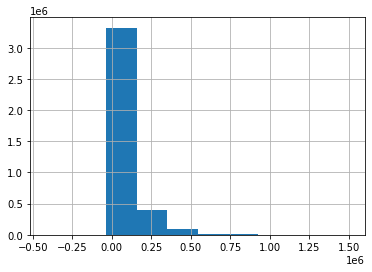


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_DRAWINGS_ATM_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount drawing at ATM during the month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0      0.00
1   2250.00
2      0.00
3   2250.00
4      0.00
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3090496.00
mean       5961.32
std       28225.69
min       -6827.31
25%           0.00
50%           0.00
75%           0.00
max     2115000.00
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

Number of zeros:
2665718

Number of NaN in column:
749816


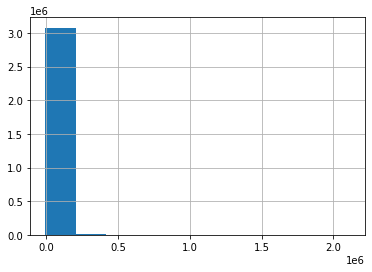


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_DRAWINGS_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount drawing during the month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0     877.50
1    2250.00
2       0.00
3    2250.00
4   11547.00
Name: AMT_DRAWINGS_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean       7433.39
std       33846.08
min       -6211.62
25%           0.00
50%           0.00
75%           0.00
max     2287098.31
Name: AMT_DRAWINGS_CURRENT, dtype: float64

Number of zeros:
3223443

Number of NaN in column:
0


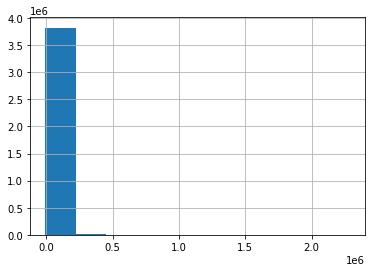


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_DRAWINGS_OTHER_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount of other drawings during the month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3   0.00
4   0.00
Name: AMT_DRAWINGS_OTHER_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3090496.00
mean        288.17
std        8201.99
min           0.00
25%           0.00
50%           0.00
75%           0.00
max     1529847.00
Name: AMT_DRAWINGS_OTHER_CURRENT, dtype: float64

Number of zeros:
3078163

Number of NaN in column:
749816


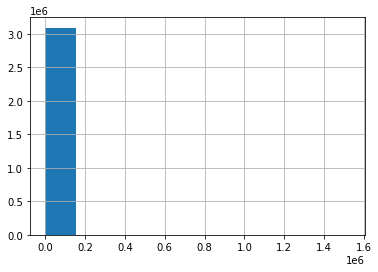


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_DRAWINGS_POS_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount drawing or buying goods during the month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0     877.50
1       0.00
2       0.00
3       0.00
4   11547.00
Name: AMT_DRAWINGS_POS_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3090496.00
mean       2968.80
std       20796.89
min           0.00
25%           0.00
50%           0.00
75%           0.00
max     2239274.16
Name: AMT_DRAWINGS_POS_CURRENT, dtype: float64

Number of zeros:
2825595

Number of NaN in column:
749816


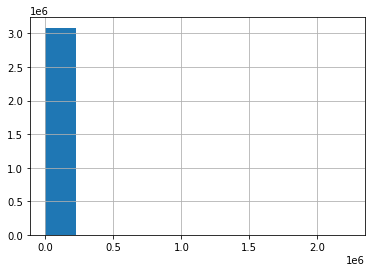


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_INST_MIN_REGULARITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Minimal installment for this month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    1700.33
1    2250.00
2    2250.00
3   11795.76
4   22924.89
Name: AMT_INST_MIN_REGULARITY, dtype: float64

COLUMN STATISTICS:
count   3535076.00
mean       3540.20
std        5600.15
min           0.00
25%           0.00
50%           0.00
75%        6633.91
max      202882.01
Name: AMT_INST_MIN_REGULARITY, dtype: float64

Number of zeros:
1928864

Number of NaN in column:
305236


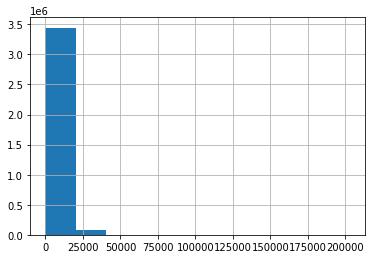


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_PAYMENT_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How much did the client pay during the month on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    1800.00
1    2250.00
2    2250.00
3   11925.00
4   27000.00
Name: AMT_PAYMENT_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3072324.00
mean      10280.54
std       36078.08
min           0.00
25%         152.37
50%        2702.70
75%        9000.00
max     4289207.45
Name: AMT_PAYMENT_CURRENT, dtype: float64

Number of zeros:
390507

Number of NaN in column:
767988


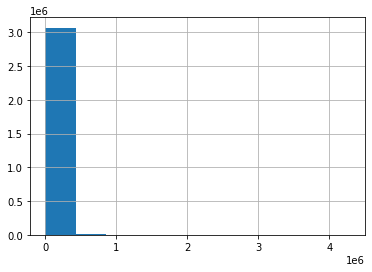


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_PAYMENT_TOTAL_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
How much did the client pay during the month in total on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    1800.00
1    2250.00
2    2250.00
3   11925.00
4   27000.00
Name: AMT_PAYMENT_TOTAL_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean       7588.86
std       32005.99
min           0.00
25%           0.00
50%           0.00
75%        6750.00
max     4278315.69
Name: AMT_PAYMENT_TOTAL_CURRENT, dtype: float64

Number of zeros:
2172223

Number of NaN in column:
0


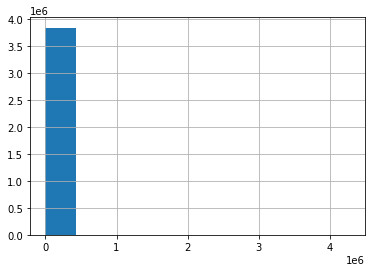


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_RECEIVABLE_PRINCIPAL
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount receivable for principal on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        0.00
1    60175.08
2    26926.42
3   224949.29
4   443044.40
Name: AMT_RECEIVABLE_PRINCIPAL, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean      55965.88
std      102533.62
min     -423305.82
25%           0.00
50%           0.00
75%       85359.24
max     1472316.79
Name: AMT_RECEIVABLE_PRINCIPAL, dtype: float64

Number of zeros:
2296167

Number of NaN in column:
0


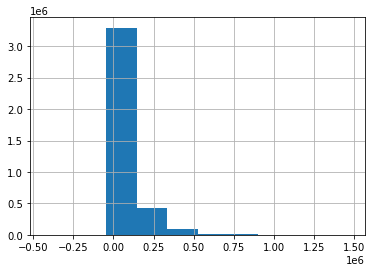


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_RECIVABLE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Amount receivable on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        0.00
1    64875.56
2    31460.08
3   233048.97
4   453919.46
Name: AMT_RECIVABLE, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean      58088.81
std      105965.37
min     -420250.18
25%           0.00
50%           0.00
75%       88899.49
max     1493338.19
Name: AMT_RECIVABLE, dtype: float64

Number of zeros:
2113816

Number of NaN in column:
0


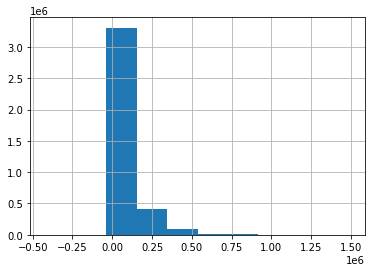


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_TOTAL_RECEIVABLE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Total amount receivable on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        0.00
1    64875.56
2    31460.08
3   233048.97
4   453919.46
Name: AMT_TOTAL_RECEIVABLE, dtype: float64

COLUMN STATISTICS:
count   3840312.00
mean      58098.29
std      105971.80
min     -420250.18
25%           0.00
50%           0.00
75%       88914.51
max     1493338.19
Name: AMT_TOTAL_RECEIVABLE, dtype: float64

Number of zeros:
2113643

Number of NaN in column:
0


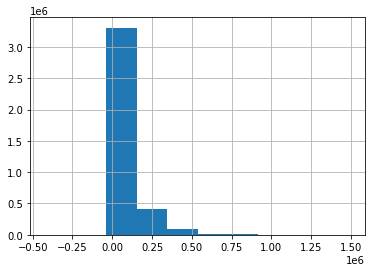


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_DRAWINGS_ATM_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of drawings at ATM during this month on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.00
1   1.00
2   0.00
3   1.00
4   0.00
Name: CNT_DRAWINGS_ATM_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3090496.00
mean          0.31
std           1.10
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          51.00
Name: CNT_DRAWINGS_ATM_CURRENT, dtype: float64

Number of zeros:
2665718

Number of NaN in column:
749816


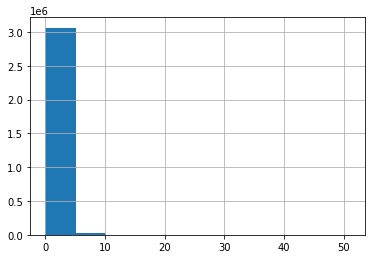


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_DRAWINGS_OTHER_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of other drawings during this month on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.00
1   0.00
2   0.00
3   0.00
4   0.00
Name: CNT_DRAWINGS_OTHER_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3090496.00
mean          0.00
std           0.08
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          12.00
Name: CNT_DRAWINGS_OTHER_CURRENT, dtype: float64

Number of zeros:
3077688

Number of NaN in column:
749816


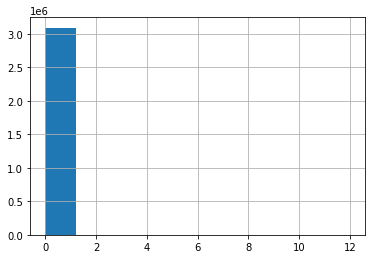


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_DRAWINGS_POS_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of drawings for goods during this month on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   1.00
1   0.00
2   0.00
3   0.00
4   1.00
Name: CNT_DRAWINGS_POS_CURRENT, dtype: float64

COLUMN STATISTICS:
count   3090496.00
mean          0.56
std           3.24
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         165.00
Name: CNT_DRAWINGS_POS_CURRENT, dtype: float64

Number of zeros:
2825594

Number of NaN in column:
749816


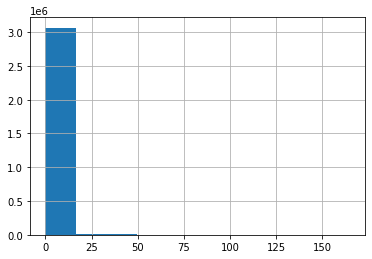


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_INSTALMENT_MATURE_CUM
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of paid installments on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    35.00
1    69.00
2    30.00
3    10.00
4   101.00
Name: CNT_INSTALMENT_MATURE_CUM, dtype: float64

COLUMN STATISTICS:
count   3535076.00
mean         20.83
std          20.05
min           0.00
25%           4.00
50%          15.00
75%          32.00
max         120.00
Name: CNT_INSTALMENT_MATURE_CUM, dtype: float64

Number of zeros:
551467

Number of NaN in column:
305236


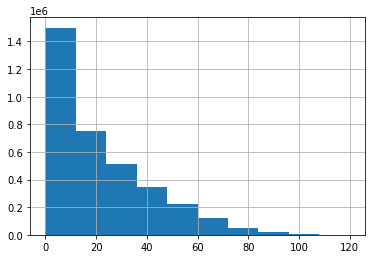

In [82]:
# View statistics about float64 columns
dataframe_analysis(credit, "float64", table_name="credit_card_balance.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    2562384
1    2582071
2    1740877
3    1389973
4    1891521
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean    1904503.59
std      536469.47
min     1000018.00
25%     1434385.00
50%     1897122.00
75%     2369327.75
max     2843496.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


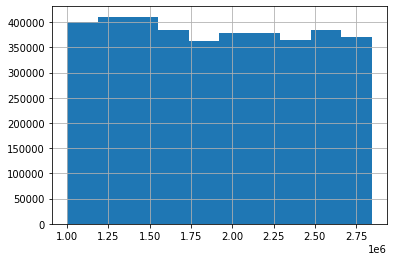


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    378907
1    363914
2    371185
3    337855
4    126868
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean     278324.21
std      102704.48
min      100006.00
25%      189517.00
50%      278396.00
75%      367580.00
max      456250.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


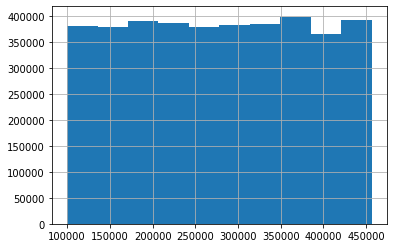


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: MONTHS_BALANCE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Month of balance relative to application date (-1 means the freshest balance date) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -6
1   -1
2   -7
3   -4
4   -1
Name: MONTHS_BALANCE, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean        -34.52
std          26.67
min         -96.00
25%         -55.00
50%         -28.00
75%         -11.00
max          -1.00
Name: MONTHS_BALANCE, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


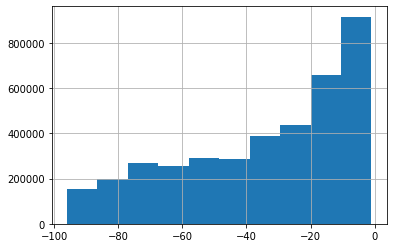


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT_LIMIT_ACTUAL
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Credit card limit during the month of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    135000
1     45000
2    450000
3    225000
4    450000
Name: AMT_CREDIT_LIMIT_ACTUAL, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean     153807.96
std      165145.70
min           0.00
25%       45000.00
50%      112500.00
75%      180000.00
max     1350000.00
Name: AMT_CREDIT_LIMIT_ACTUAL, dtype: float64

Number of zeros:
753823

Number of NaN in column:
0


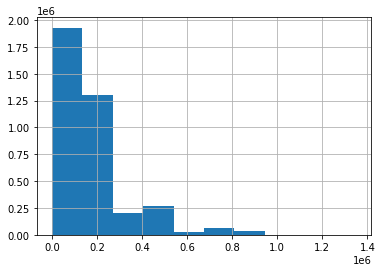


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_DRAWINGS_CURRENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Number of drawings during this month on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    1
1    1
2    0
3    1
4    1
Name: CNT_DRAWINGS_CURRENT, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean          0.70
std           3.19
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         165.00
Name: CNT_DRAWINGS_CURRENT, dtype: float64

Number of zeros:
3229952

Number of NaN in column:
0


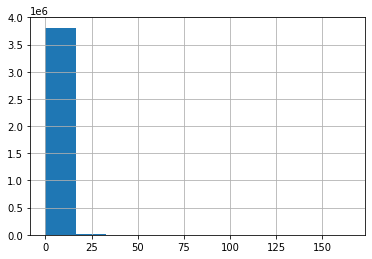


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_DPD
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
DPD (Days past due) during the month on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: SK_DPD, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean          9.28
std          97.52
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        3260.00
Name: SK_DPD, dtype: float64

Number of zeros:
3686957

Number of NaN in column:
0


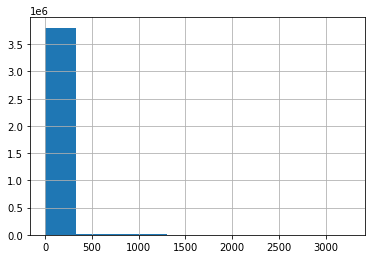


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_DPD_DEF
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    0
1    0
2    0
3    0
4    0
Name: SK_DPD_DEF, dtype: int64

COLUMN STATISTICS:
count   3840312.00
mean          0.33
std          21.48
min           0.00
25%           0.00
50%           0.00
75%           0.00
max        3260.00
Name: SK_DPD_DEF, dtype: float64

Number of zeros:
3750972

Number of NaN in column:
0


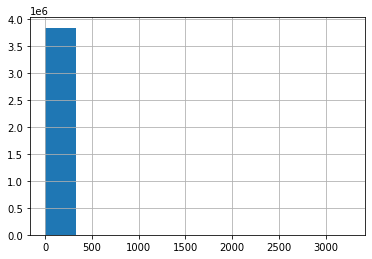

In [83]:
# View statistics about int64 columns
dataframe_analysis(credit, "int64", table_name="credit_card_balance.csv")

#### <b> EDA for *object (string)* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CONTRACT_STATUS
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Contract status (active signed,...) on the previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Active
1    Active
2    Active
3    Active
4    Active
Name: NAME_CONTRACT_STATUS, dtype: object

COLUMN STATISTICS:
count     3840312
unique          7
top        Active
freq      3698436
Name: NAME_CONTRACT_STATUS, dtype: object

UNIQUE VALUESL
['Active' 'Completed' 'Demand' 'Signed' 'Sent proposal' 'Refused'
 'Approved']

Number of NaN in column:
0


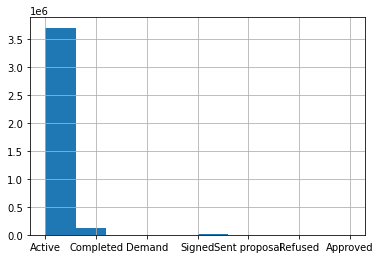

In [84]:
# View statistics about object columns
dataframe_analysis(credit, "object", table_name="credit_card_balance.csv")

### <b>previous_application.csv

In [85]:
# View shape of file
previous.shape

(1670214, 37)

In [86]:
# View first 5 rows
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43,17145.00,17145.00,0.00,17145.00,SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,365243.00,-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,25188.62,607500.00,679671.00,NaN,607500.00,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,365243.00,-134.00,916.00,365243.00,365243.00,1.00
2,2523466,122040,Cash loans,15060.74,112500.00,136444.50,NaN,112500.00,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,365243.00,-271.00,59.00,365243.00,365243.00,1.00
3,2819243,176158,Cash loans,47041.33,450000.00,470790.00,NaN,450000.00,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,365243.00,-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,31924.40,337500.00,404055.00,NaN,337500.00,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# View last 5 rows
previous.tail()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1670209,2300464,352015,Consumer loans,14704.29,267295.50,311400.00,0.00,267295.50,WEDNESDAY,12,Y,1,0.00,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.00,low_normal,POS industry with interest,365243.00,-508.00,362.00,-358.00,-351.00,0.00
1670210,2357031,334635,Consumer loans,6622.02,87750.00,64291.50,29250.00,87750.00,TUESDAY,15,Y,1,0.34,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.00,middle,POS industry with interest,365243.00,-1604.00,-1274.00,-1304.00,-1297.00,0.00
1670211,2659632,249544,Consumer loans,11520.85,105237.00,102523.50,10525.50,105237.00,MONDAY,12,Y,1,0.10,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.00,low_normal,POS household with interest,365243.00,-1457.00,-1187.00,-1187.00,-1181.00,0.00
1670212,2785582,400317,Cash loans,18821.52,180000.00,191880.00,NaN,180000.00,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.00,low_normal,Cash X-Sell: low,365243.00,-1155.00,-825.00,-825.00,-817.00,1.00
1670213,2418762,261212,Cash loans,16431.30,360000.00,360000.00,NaN,360000.00,SUNDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-1193,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,48.00,middle,Cash X-Sell: middle,365243.00,-1163.00,247.00,-443.00,-423.00,0.00


In [88]:
# View dataframe statistics
previous.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.00,1670214.00,1297979.00,1670214.00,1670213.00,774370.00,1284699.00,1670214.00,1670214.00,774370.00,5951.00,5951.00,1670214.00,1670214.00,1297984.00,997149.00,997149.00,997149.00,997149.00,997149.00,997149.00
mean,1923089.14,278357.17,15955.12,175233.86,196114.02,6697.40,227847.28,12.48,1.00,0.08,0.19,0.77,-880.68,313.95,16.05,342209.86,13826.27,33767.77,76582.40,81992.34,0.33
std,532597.96,102814.82,14782.14,292779.76,318574.62,20921.50,315396.56,3.33,0.06,0.11,0.09,0.10,779.10,7127.44,14.57,88916.12,72444.87,106857.03,149647.42,153303.52,0.47
min,1000001.00,100001.00,0.00,0.00,0.00,-0.90,0.00,0.00,0.00,-0.00,0.03,0.37,-2922.00,-1.00,0.00,-2922.00,-2892.00,-2801.00,-2889.00,-2874.00,0.00
25%,1461857.25,189329.00,6321.78,18720.00,24160.50,0.00,50841.00,10.00,1.00,0.00,0.16,0.72,-1300.00,-1.00,6.00,365243.00,-1628.00,-1242.00,-1314.00,-1270.00,0.00
50%,1923110.50,278714.50,11250.00,71046.00,80541.00,1638.00,112320.00,12.00,1.00,0.05,0.19,0.84,-581.00,3.00,12.00,365243.00,-831.00,-361.00,-537.00,-499.00,0.00
75%,2384279.75,367514.00,20658.42,180360.00,216418.50,7740.00,234000.00,15.00,1.00,0.11,0.19,0.85,-280.00,82.00,24.00,365243.00,-411.00,129.00,-74.00,-44.00,1.00
max,2845382.00,456255.00,418058.15,6905160.00,6905160.00,3060045.00,6905160.00,23.00,1.00,1.00,1.00,1.00,-1.00,4000000.00,84.00,365243.00,365243.00,365243.00,365243.00,365243.00,1.00


In [89]:
# View columns datatypes
previous.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_ANNUITY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Annuity of previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    1730.43
1   25188.62
2   15060.74
3   47041.33
4   31924.40
Name: AMT_ANNUITY, dtype: float64

COLUMN STATISTICS:
count   1297979.00
mean      15955.12
std       14782.14
min           0.00
25%        6321.78
50%       11250.00
75%       20658.42
max      418058.15
Name: AMT_ANNUITY, dtype: float64

Number of zeros:
1637

Number of NaN in column:
372235


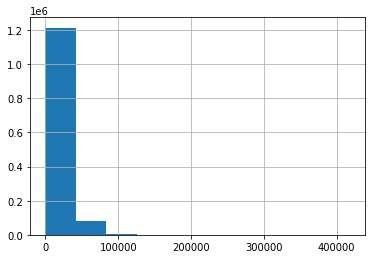


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_APPLICATION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
For how much credit did client ask on the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    17145.00
1   607500.00
2   112500.00
3   450000.00
4   337500.00
Name: AMT_APPLICATION, dtype: float64

COLUMN STATISTICS:
count   1670214.00
mean     175233.86
std      292779.76
min           0.00
25%       18720.00
50%       71046.00
75%      180360.00
max     6905160.00
Name: AMT_APPLICATION, dtype: float64

Number of zeros:
392402

Number of NaN in column:
0


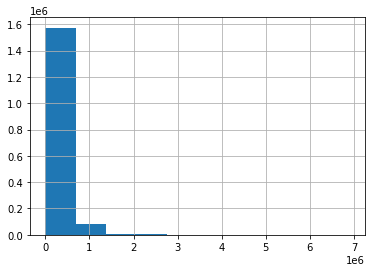


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_CREDIT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    17145.00
1   679671.00
2   136444.50
3   470790.00
4   404055.00
Name: AMT_CREDIT, dtype: float64

COLUMN STATISTICS:
count   1670213.00
mean     196114.02
std      318574.62
min           0.00
25%       24160.50
50%       80541.00
75%      216418.50
max     6905160.00
Name: AMT_CREDIT, dtype: float64

Number of zeros:
336768

Number of NaN in column:
1


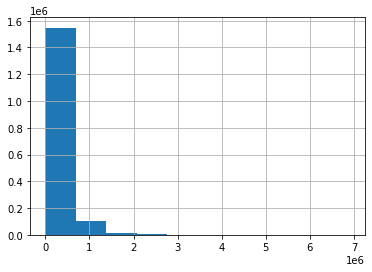


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_DOWN_PAYMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Down payment on the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.00
1    NaN
2    NaN
3    NaN
4    NaN
Name: AMT_DOWN_PAYMENT, dtype: float64

COLUMN STATISTICS:
count    774370.00
mean       6697.40
std       20921.50
min          -0.90
25%           0.00
50%        1638.00
75%        7740.00
max     3060045.00
Name: AMT_DOWN_PAYMENT, dtype: float64

Number of zeros:
369854

Number of NaN in column:
895844


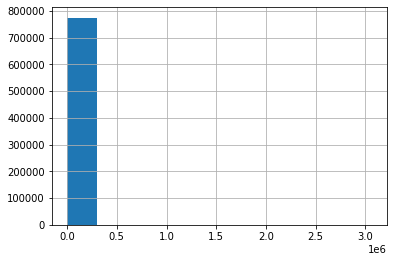


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_GOODS_PRICE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Goods price of good that client asked for (if applicable) on the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    17145.00
1   607500.00
2   112500.00
3   450000.00
4   337500.00
Name: AMT_GOODS_PRICE, dtype: float64

COLUMN STATISTICS:
count   1284699.00
mean     227847.28
std      315396.56
min           0.00
25%       50841.00
50%      112320.00
75%      234000.00
max     6905160.00
Name: AMT_GOODS_PRICE, dtype: float64

Number of zeros:
6869

Number of NaN in column:
385515


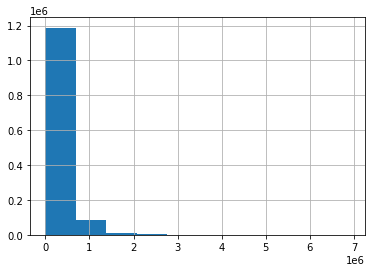


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: RATE_DOWN_PAYMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Down payment rate normalized on previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.00
1    NaN
2    NaN
3    NaN
4    NaN
Name: RATE_DOWN_PAYMENT, dtype: float64

COLUMN STATISTICS:
count   774370.00
mean         0.08
std          0.11
min         -0.00
25%          0.00
50%          0.05
75%          0.11
max          1.00
Name: RATE_DOWN_PAYMENT, dtype: float64

Number of zeros:
369854

Number of NaN in column:
895844


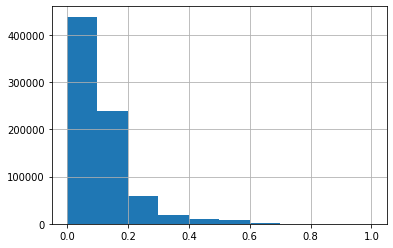


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: RATE_INTEREST_PRIMARY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Interest rate normalized on previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.18
1    NaN
2    NaN
3    NaN
4    NaN
Name: RATE_INTEREST_PRIMARY, dtype: float64

COLUMN STATISTICS:
count   5951.00
mean       0.19
std        0.09
min        0.03
25%        0.16
50%        0.19
75%        0.19
max        1.00
Name: RATE_INTEREST_PRIMARY, dtype: float64

Number of zeros:
0

Number of NaN in column:
1664263


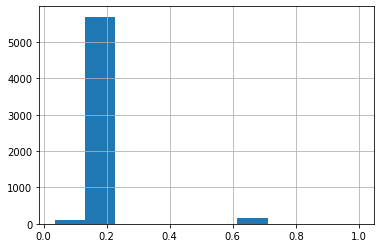


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: RATE_INTEREST_PRIVILEGED
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Interest rate normalized on previous credit 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.87
1    NaN
2    NaN
3    NaN
4    NaN
Name: RATE_INTEREST_PRIVILEGED, dtype: float64

COLUMN STATISTICS:
count   5951.00
mean       0.77
std        0.10
min        0.37
25%        0.72
50%        0.84
75%        0.85
max        1.00
Name: RATE_INTEREST_PRIVILEGED, dtype: float64

Number of zeros:
0

Number of NaN in column:
1664263


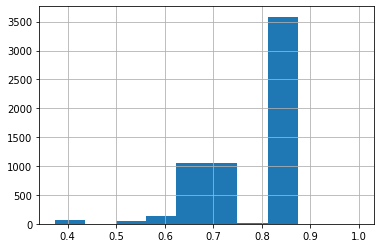


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CNT_PAYMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Term of previous credit at application of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   12.00
1   36.00
2   12.00
3   12.00
4   24.00
Name: CNT_PAYMENT, dtype: float64

COLUMN STATISTICS:
count   1297984.00
mean         16.05
std          14.57
min           0.00
25%           6.00
50%          12.00
75%          24.00
max          84.00
Name: CNT_PAYMENT, dtype: float64

Number of zeros:
144985

Number of NaN in column:
372230


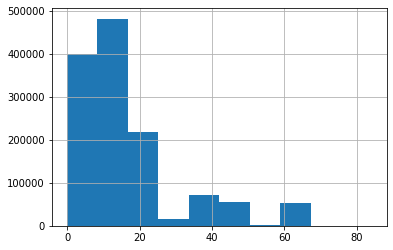


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_FIRST_DRAWING
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Relative to application date of current application when was the first disbursement of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   365243.00
1   365243.00
2   365243.00
3   365243.00
4         NaN
Name: DAYS_FIRST_DRAWING, dtype: float64

COLUMN STATISTICS:
count   997149.00
mean    342209.86
std      88916.12
min      -2922.00
25%     365243.00
50%     365243.00
75%     365243.00
max     365243.00
Name: DAYS_FIRST_DRAWING, dtype: float64

Number of zeros:
0

Number of NaN in column:
673065


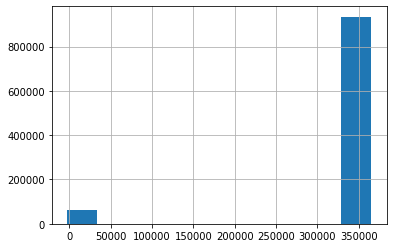


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_FIRST_DUE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Relative to application date of current application when was the first due supposed to be of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    -42.00
1   -134.00
2   -271.00
3   -482.00
4       NaN
Name: DAYS_FIRST_DUE, dtype: float64

COLUMN STATISTICS:
count   997149.00
mean     13826.27
std      72444.87
min      -2892.00
25%      -1628.00
50%       -831.00
75%       -411.00
max     365243.00
Name: DAYS_FIRST_DUE, dtype: float64

Number of zeros:
0

Number of NaN in column:
673065


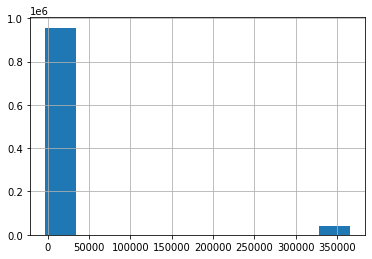


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_LAST_DUE_1ST_VERSION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Relative to application date of current application when was the first due of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    300.00
1    916.00
2     59.00
3   -152.00
4       NaN
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

COLUMN STATISTICS:
count   997149.00
mean     33767.77
std     106857.03
min      -2801.00
25%      -1242.00
50%       -361.00
75%        129.00
max     365243.00
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

Number of zeros:
705

Number of NaN in column:
673065


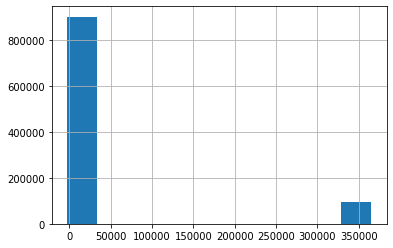


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_LAST_DUE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Relative to application date of current application when was the last due date of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0      -42.00
1   365243.00
2   365243.00
3     -182.00
4         NaN
Name: DAYS_LAST_DUE, dtype: float64

COLUMN STATISTICS:
count   997149.00
mean     76582.40
std     149647.42
min      -2889.00
25%      -1314.00
50%       -537.00
75%        -74.00
max     365243.00
Name: DAYS_LAST_DUE, dtype: float64

Number of zeros:
0

Number of NaN in column:
673065


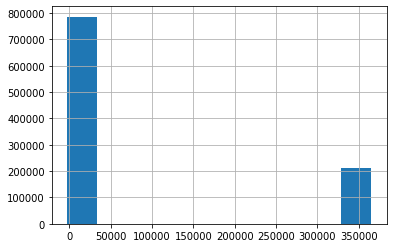


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_TERMINATION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Relative to application date of current application when was the expected termination of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0      -37.00
1   365243.00
2   365243.00
3     -177.00
4         NaN
Name: DAYS_TERMINATION, dtype: float64

COLUMN STATISTICS:
count   997149.00
mean     81992.34
std     153303.52
min      -2874.00
25%      -1270.00
50%       -499.00
75%        -44.00
max     365243.00
Name: DAYS_TERMINATION, dtype: float64

Number of zeros:
0

Number of NaN in column:
673065


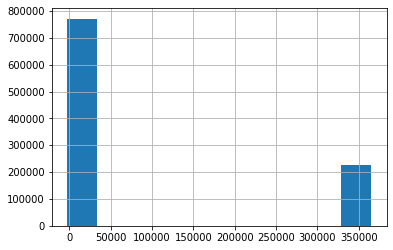


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NFLAG_INSURED_ON_APPROVAL
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did the client requested insurance during the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   0.00
1   1.00
2   1.00
3   1.00
4    NaN
Name: NFLAG_INSURED_ON_APPROVAL, dtype: float64

COLUMN STATISTICS:
count   997149.00
mean         0.33
std          0.47
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          1.00
Name: NFLAG_INSURED_ON_APPROVAL, dtype: float64

Number of zeros:
665527

Number of NaN in column:
673065


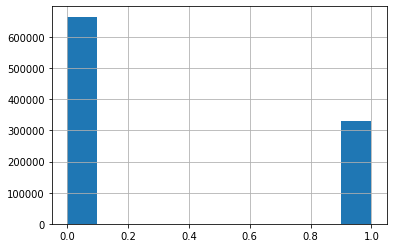

In [90]:
# View statistics about float64 columns
dataframe_analysis(previous, "float64", table_name="previous_application.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    2030495
1    2802425
2    2523466
3    2819243
4    1784265
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean    1923089.14
std      532597.96
min     1000001.00
25%     1461857.25
50%     1923110.50
75%     2384279.75
max     2845382.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


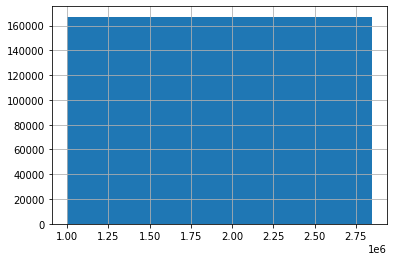


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    271877
1    108129
2    122040
3    176158
4    202054
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean     278357.17
std      102814.82
min      100001.00
25%      189329.00
50%      278714.50
75%      367514.00
max      456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


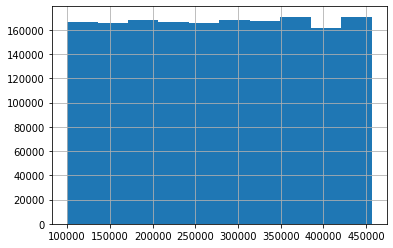


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: HOUR_APPR_PROCESS_START
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Approximately at what day hour did the client apply for the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    15
1    11
2    11
3     7
4     9
Name: HOUR_APPR_PROCESS_START, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean         12.48
std           3.33
min           0.00
25%          10.00
50%          12.00
75%          15.00
max          23.00
Name: HOUR_APPR_PROCESS_START, dtype: float64

Number of zeros:
109

Number of NaN in column:
0


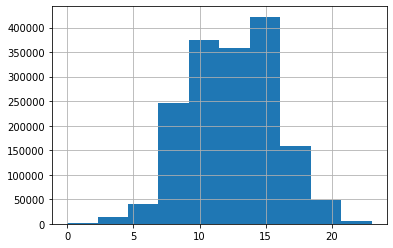


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NFLAG_LAST_APPL_IN_DAY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    1
1    1
2    1
3    1
4    1
Name: NFLAG_LAST_APPL_IN_DAY, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean          1.00
std           0.06
min           0.00
25%           1.00
50%           1.00
75%           1.00
max           1.00
Name: NFLAG_LAST_APPL_IN_DAY, dtype: float64

Number of zeros:
5900

Number of NaN in column:
0


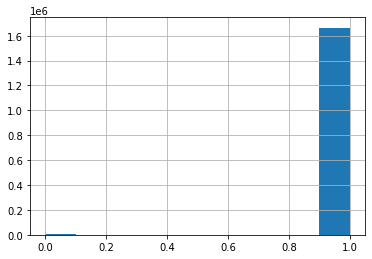


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_DECISION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Relative to current application when was the decision about previous application made 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    -73
1   -164
2   -301
3   -512
4   -781
Name: DAYS_DECISION, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean       -880.68
std         779.10
min       -2922.00
25%       -1300.00
50%        -581.00
75%        -280.00
max          -1.00
Name: DAYS_DECISION, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


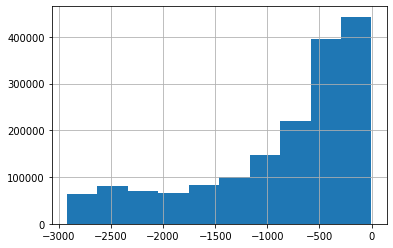


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SELLERPLACE_AREA
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Selling area of seller place of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    35
1    -1
2    -1
3    -1
4    -1
Name: SELLERPLACE_AREA, dtype: int64

COLUMN STATISTICS:
count   1670214.00
mean        313.95
std        7127.44
min          -1.00
25%          -1.00
50%           3.00
75%          82.00
max     4000000.00
Name: SELLERPLACE_AREA, dtype: float64

Number of zeros:
60523

Number of NaN in column:
0


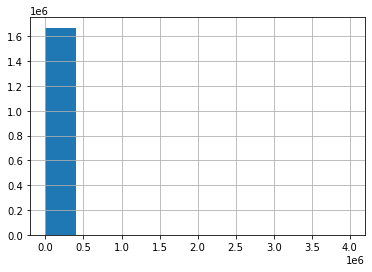

In [91]:
# View statistics about int64 columns
dataframe_analysis(previous, "int64", table_name="previous_application.csv")

#### <b> EDA for *object (string)* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CONTRACT_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Consumer loans
1        Cash loans
2        Cash loans
3        Cash loans
4        Cash loans
Name: NAME_CONTRACT_TYPE, dtype: object

COLUMN STATISTICS:
count        1670214
unique             4
top       Cash loans
freq          747553
Name: NAME_CONTRACT_TYPE, dtype: object

UNIQUE VALUESL
['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']

Number of NaN in column:
0


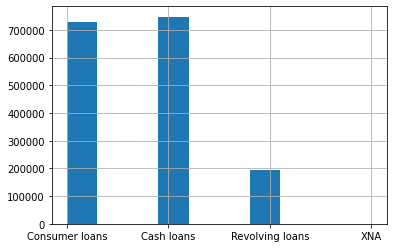


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: WEEKDAY_APPR_PROCESS_START
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
On which day of the week did the client apply for previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    SATURDAY
1    THURSDAY
2     TUESDAY
3      MONDAY
4    THURSDAY
Name: WEEKDAY_APPR_PROCESS_START, dtype: object

COLUMN STATISTICS:
count     1670214
unique          7
top       TUESDAY
freq       255118
Name: WEEKDAY_APPR_PROCESS_START, dtype: object

UNIQUE VALUESL
['SATURDAY' 'THURSDAY' 'TUESDAY' 'MONDAY' 'FRIDAY' 'SUNDAY' 'WEDNESDAY']

Number of NaN in column:
0


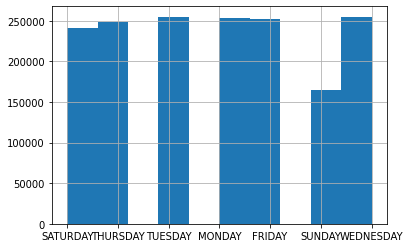


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: FLAG_LAST_APPL_PER_CONTRACT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Y
1    Y
2    Y
3    Y
4    Y
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: object

COLUMN STATISTICS:
count     1670214
unique          2
top             Y
freq      1661739
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: object

UNIQUE VALUESL
['Y' 'N']

Number of NaN in column:
0


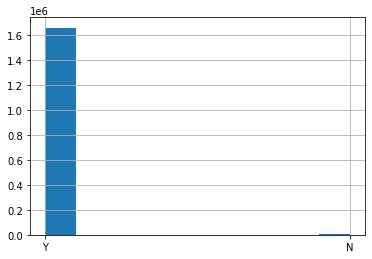


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CASH_LOAN_PURPOSE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Purpose of the cash loan 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        XAP
1        XNA
2        XNA
3        XNA
4    Repairs
Name: NAME_CASH_LOAN_PURPOSE, dtype: object

COLUMN STATISTICS:
count     1670214
unique         25
top           XAP
freq       922661
Name: NAME_CASH_LOAN_PURPOSE, dtype: object

UNIQUE VALUESL
['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply

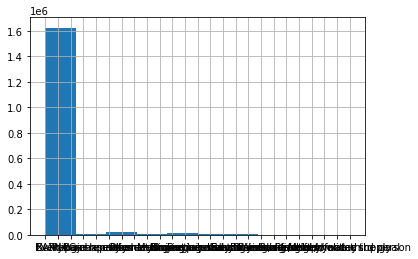


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CONTRACT_STATUS
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Contract status (approved, cancelled, ...) of previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Approved
1    Approved
2    Approved
3    Approved
4     Refused
Name: NAME_CONTRACT_STATUS, dtype: object

COLUMN STATISTICS:
count      1670214
unique           4
top       Approved
freq       1036781
Name: NAME_CONTRACT_STATUS, dtype: object

UNIQUE VALUESL
['Approved' 'Refused' 'Canceled' 'Unused offer']

Number of NaN in column:
0


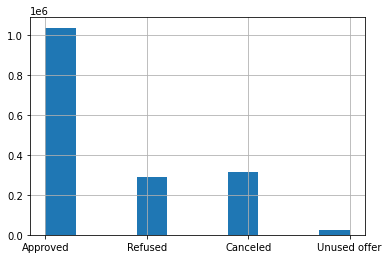


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_PAYMENT_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Payment method that client chose to pay for the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Cash through the bank
1                      XNA
2    Cash through the bank
3    Cash through the bank
4    Cash through the bank
Name: NAME_PAYMENT_TYPE, dtype: object

COLUMN STATISTICS:
count                   1670214
unique                        4
top       Cash through the bank
freq                    1033552
Name: NAME_PAYMENT_TYPE, dtype: object

UNIQUE VALUESL
['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']

Number of NaN in column:
0


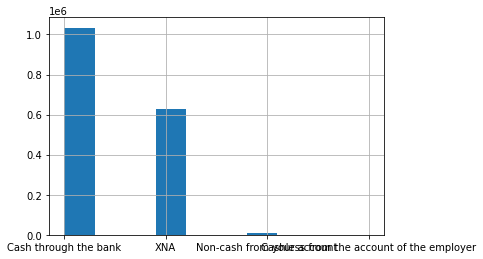


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CODE_REJECT_REASON
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Why was the previous application rejected 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    XAP
1    XAP
2    XAP
3    XAP
4     HC
Name: CODE_REJECT_REASON, dtype: object

COLUMN STATISTICS:
count     1670214
unique          9
top           XAP
freq      1353093
Name: CODE_REJECT_REASON, dtype: object

UNIQUE VALUESL
['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VERIF' 'SYSTEM']

Number of NaN in column:
0


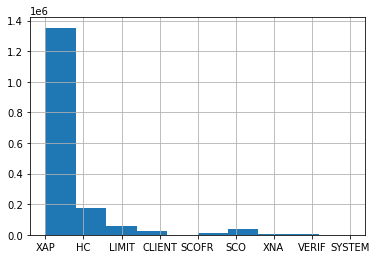


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_TYPE_SUITE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Who accompanied client when applying for the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0                NaN
1      Unaccompanied
2    Spouse, partner
3                NaN
4                NaN
Name: NAME_TYPE_SUITE, dtype: object

COLUMN STATISTICS:
count            849809
unique                7
top       Unaccompanied
freq             508970
Name: NAME_TYPE_SUITE, dtype: object

UNIQUE VALUESL
[nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people']

Number of NaN in column:
820405


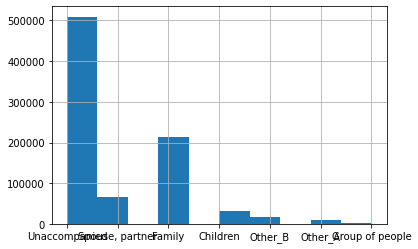


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_CLIENT_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Was the client old or new client when applying for the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Repeater
1    Repeater
2    Repeater
3    Repeater
4    Repeater
Name: NAME_CLIENT_TYPE, dtype: object

COLUMN STATISTICS:
count      1670214
unique           4
top       Repeater
freq       1231261
Name: NAME_CLIENT_TYPE, dtype: object

UNIQUE VALUESL
['Repeater' 'New' 'Refreshed' 'XNA']

Number of NaN in column:
0


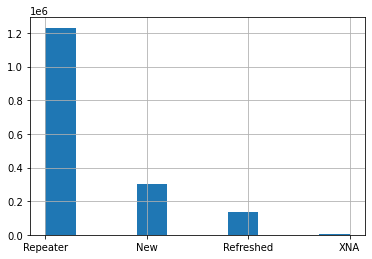


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_GOODS_CATEGORY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
What kind of goods did the client apply for in the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Mobile
1       XNA
2       XNA
3       XNA
4       XNA
Name: NAME_GOODS_CATEGORY, dtype: object

COLUMN STATISTICS:
count     1670214
unique         28
top           XNA
freq       950809
Name: NAME_GOODS_CATEGORY, dtype: object

UNIQUE VALUESL
['Mobile' 'XNA' 'Consumer Electronics' 'Construction Materials'
 'Auto Accessories' 'Photo / Cinema Equipment' 'Computers' 'Audio/Video'
 'Medicine' 'Clothing and Accessories' 'Furniture' 'Sport and Leisure'
 'Homewares' 'Gardening' 'Jewelry' 'Vehicles' 'Education'
 'Medical Supplies' 'Other' 'Direct Sales' 'Office Appliances' 'Fitness'
 'Tourism' 'Insurance' 'Additional Servic

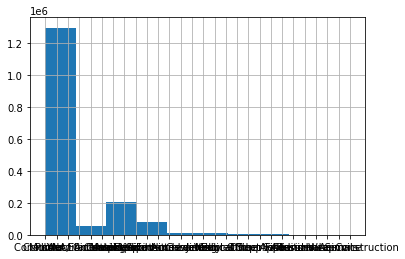


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_PORTFOLIO
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Was the previous application for CASH, POS, CAR, … 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0     POS
1    Cash
2    Cash
3    Cash
4    Cash
Name: NAME_PORTFOLIO, dtype: object

COLUMN STATISTICS:
count     1670214
unique          5
top           POS
freq       691011
Name: NAME_PORTFOLIO, dtype: object

UNIQUE VALUESL
['POS' 'Cash' 'XNA' 'Cards' 'Cars']

Number of NaN in column:
0


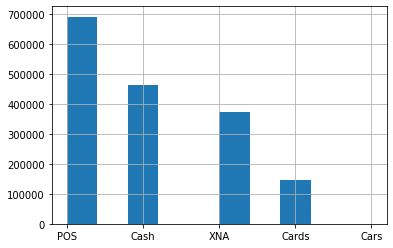


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_PRODUCT_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Was the previous application x-sell o walk-in 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        XNA
1     x-sell
2     x-sell
3     x-sell
4    walk-in
Name: NAME_PRODUCT_TYPE, dtype: object

COLUMN STATISTICS:
count     1670214
unique          3
top           XNA
freq      1063666
Name: NAME_PRODUCT_TYPE, dtype: object

UNIQUE VALUESL
['XNA' 'x-sell' 'walk-in']

Number of NaN in column:
0


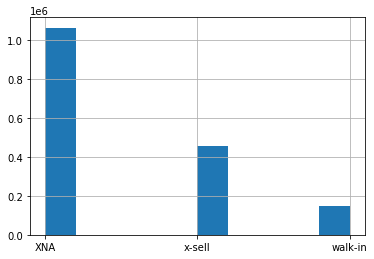


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: CHANNEL_TYPE
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Through which channel we acquired the client on the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0               Country-wide
1             Contact center
2    Credit and cash offices
3    Credit and cash offices
4    Credit and cash offices
Name: CHANNEL_TYPE, dtype: object

COLUMN STATISTICS:
count                     1670214
unique                          8
top       Credit and cash offices
freq                       719968
Name: CHANNEL_TYPE, dtype: object

UNIQUE VALUESL
['Country-wide' 'Contact center' 'Credit and cash offices' 'Stone'
 'Regional / Local' 'AP+ (Cash loan)' 'Channel of corporate sales'
 'Car dealer']

Number of NaN in column:
0


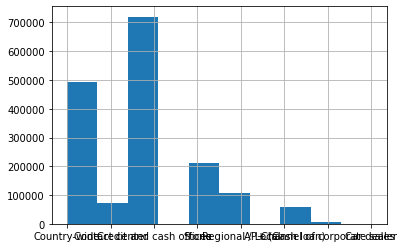


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_SELLER_INDUSTRY
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
The industry of the seller 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    Connectivity
1             XNA
2             XNA
3             XNA
4             XNA
Name: NAME_SELLER_INDUSTRY, dtype: object

COLUMN STATISTICS:
count     1670214
unique         11
top           XNA
freq       855720
Name: NAME_SELLER_INDUSTRY, dtype: object

UNIQUE VALUESL
['Connectivity' 'XNA' 'Consumer electronics' 'Industry' 'Clothing'
 'Furniture' 'Construction' 'Jewelry' 'Auto technology' 'MLM partners'
 'Tourism']

Number of NaN in column:
0


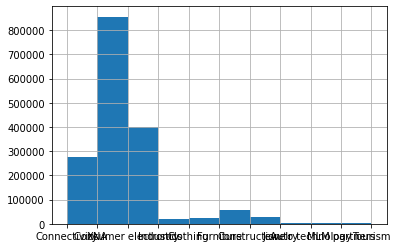


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NAME_YIELD_GROUP
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Grouped interest rate into small medium and high of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0        middle
1    low_action
2          high
3        middle
4          high
Name: NAME_YIELD_GROUP, dtype: object

COLUMN STATISTICS:
count     1670214
unique          5
top           XNA
freq       517215
Name: NAME_YIELD_GROUP, dtype: object

UNIQUE VALUESL
['middle' 'low_action' 'high' 'low_normal' 'XNA']

Number of NaN in column:
0


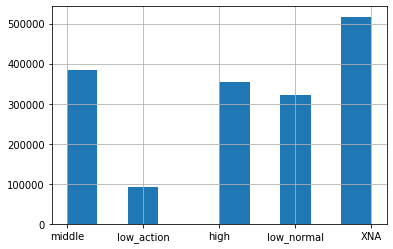


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: PRODUCT_COMBINATION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Detailed product combination of the previous application 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    POS mobile with interest
1            Cash X-Sell: low
2           Cash X-Sell: high
3         Cash X-Sell: middle
4           Cash Street: high
Name: PRODUCT_COMBINATION, dtype: object

COLUMN STATISTICS:
count     1669868
unique         17
top          Cash
freq       285990
Name: PRODUCT_COMBINATION, dtype: object

UNIQUE VALUESL
['POS mobile with interest' 'Cash X-Sell: low' 'Cash X-Sell: high'
 'Cash X-Sell: middle' 'Cash Street: high' 'Cash'
 'POS household without interest' 'POS household with interest'
 'POS other with interest' 'Card X-Sell' 'POS mobile without interest'
 'Card Street' 'POS industry with interest' 'Cash Str

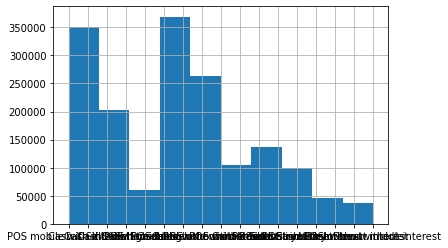

In [92]:
# View statistics about object columns
dataframe_analysis(previous, "object", table_name="previous_application.csv")

### <b>installments_payments.csv

In [93]:
# View shape of file
installments.shape

(13605401, 8)

In [94]:
# View first 5 rows
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,-1180.00,-1187.00,6948.36,6948.36
1,1330831,151639,0.00,34,-2156.00,-2156.00,1716.53,1716.53
2,2085231,193053,2.00,1,-63.00,-63.00,25425.00,25425.00
3,2452527,199697,1.00,3,-2418.00,-2426.00,24350.13,24350.13
4,2714724,167756,1.00,2,-1383.00,-1366.00,2165.04,2160.59


In [95]:
# View last 5 rows
installments.tail()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
13605396,2186857,428057,0.00,66,-1624.00,NaN,67.50,NaN
13605397,1310347,414406,0.00,47,-1539.00,NaN,67.50,NaN
13605398,1308766,402199,0.00,43,-7.00,NaN,43737.43,NaN
13605399,1062206,409297,0.00,43,-1986.00,NaN,67.50,NaN
13605400,2448869,434321,1.00,19,-27.00,NaN,11504.25,NaN


In [96]:
# View dataframe statistics
installments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,13605401.00,13605401.00,13605401.00,13605401.00,13605401.00,13602496.00,13605401.00,13602496.00
mean,1903364.97,278444.88,0.86,18.87,-1042.27,-1051.11,17050.91,17238.22
std,536202.91,102718.31,1.04,26.66,800.95,800.59,50570.25,54735.78
min,1000001.00,100001.00,0.00,1.00,-2922.00,-4921.00,0.00,0.00
25%,1434191.00,189639.00,0.00,4.00,-1654.00,-1662.00,4226.09,3398.26
50%,1896520.00,278685.00,1.00,8.00,-818.00,-827.00,8884.08,8125.52
75%,2369094.00,367530.00,1.00,19.00,-361.00,-370.00,16710.21,16108.42
max,2843499.00,456255.00,178.00,277.00,-1.00,-1.00,3771487.85,3771487.85


In [97]:
# View columns datatypes
installments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

#### <b> EDA for *float64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NUM_INSTALMENT_VERSION
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   1.00
1   0.00
2   2.00
3   1.00
4   1.00
Name: NUM_INSTALMENT_VERSION, dtype: float64

COLUMN STATISTICS:
count   13605401.00
mean           0.86
std            1.04
min            0.00
25%            0.00
50%            1.00
75%            1.00
max          178.00
Name: NUM_INSTALMENT_VERSION, dtype: float64

Number of zeros:
4082498

Number of NaN in column:
0


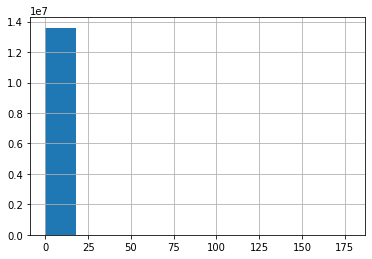


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_INSTALMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
When the installment of previous credit was supposed to be paid (relative to application date of current loan) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -1180.00
1   -2156.00
2     -63.00
3   -2418.00
4   -1383.00
Name: DAYS_INSTALMENT, dtype: float64

COLUMN STATISTICS:
count   13605401.00
mean       -1042.27
std          800.95
min        -2922.00
25%        -1654.00
50%         -818.00
75%         -361.00
max           -1.00
Name: DAYS_INSTALMENT, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


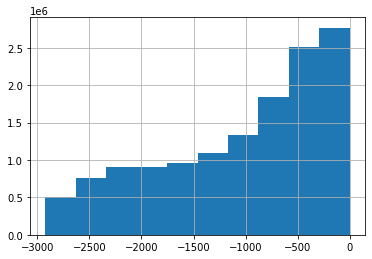


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: DAYS_ENTRY_PAYMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
When was the installments of previous credit paid actually (relative to application date of current loan) 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0   -1187.00
1   -2156.00
2     -63.00
3   -2426.00
4   -1366.00
Name: DAYS_ENTRY_PAYMENT, dtype: float64

COLUMN STATISTICS:
count   13602496.00
mean       -1051.11
std          800.59
min        -4921.00
25%        -1662.00
50%         -827.00
75%         -370.00
max           -1.00
Name: DAYS_ENTRY_PAYMENT, dtype: float64

Number of zeros:
0

Number of NaN in column:
2905


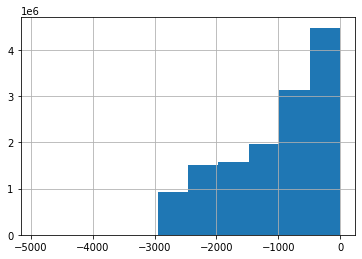


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_INSTALMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
What was the prescribed installment amount of previous credit on this installment 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    6948.36
1    1716.53
2   25425.00
3   24350.13
4    2165.04
Name: AMT_INSTALMENT, dtype: float64

COLUMN STATISTICS:
count   13605401.00
mean       17050.91
std        50570.25
min            0.00
25%         4226.09
50%         8884.08
75%        16710.21
max      3771487.85
Name: AMT_INSTALMENT, dtype: float64

Number of zeros:
290

Number of NaN in column:
0


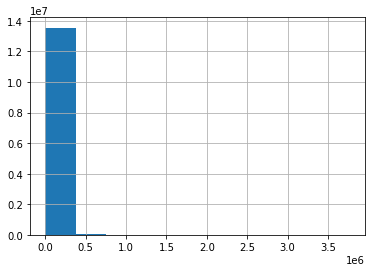


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: AMT_PAYMENT
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
What the client actually paid on previous credit on this installment 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    6948.36
1    1716.53
2   25425.00
3   24350.13
4    2160.59
Name: AMT_PAYMENT, dtype: float64

COLUMN STATISTICS:
count   13602496.00
mean       17238.22
std        54735.78
min            0.00
25%         3398.26
50%         8125.52
75%        16108.42
max      3771487.85
Name: AMT_PAYMENT, dtype: float64

Number of zeros:
1440

Number of NaN in column:
2905


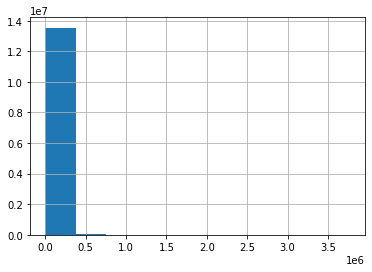

In [98]:
# View statistics about float64 columns
dataframe_analysis(installments, "float64", table_name="installments_payments.csv")

#### <b> EDA for *int64* columns


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_PREV
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
Did not find description for this column
TOP 5 ROWS:
0    1054186
1    1330831
2    2085231
3    2452527
4    2714724
Name: SK_ID_PREV, dtype: int64

COLUMN STATISTICS:
count   13605401.00
mean     1903364.97
std       536202.91
min      1000001.00
25%      1434191.00
50%      1896520.00
75%      2369094.00
max      2843499.00
Name: SK_ID_PREV, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


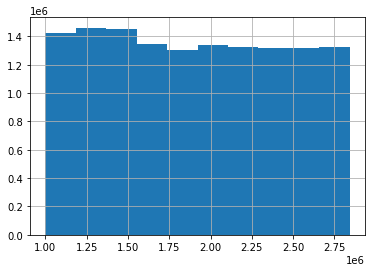


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: SK_ID_CURR
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
ID of loan in our sample 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0    161674
1    151639
2    193053
3    199697
4    167756
Name: SK_ID_CURR, dtype: int64

COLUMN STATISTICS:
count   13605401.00
mean      278444.88
std       102718.31
min       100001.00
25%       189639.00
50%       278685.00
75%       367530.00
max       456255.00
Name: SK_ID_CURR, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


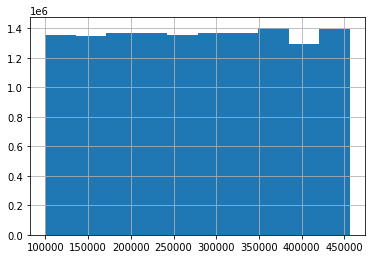


--------------------------------------------------------------------------------
NOW ANALYZING COLUMN: NUM_INSTALMENT_NUMBER
--------------------------------------------------------------------------------
COLUMN DESCRIPTION:
On which installment we observe payment 

SPECIAL MENTIONS:
Did not find description for this column
TOP 5 ROWS:
0     6
1    34
2     1
3     3
4     2
Name: NUM_INSTALMENT_NUMBER, dtype: int64

COLUMN STATISTICS:
count   13605401.00
mean          18.87
std           26.66
min            1.00
25%            4.00
50%            8.00
75%           19.00
max          277.00
Name: NUM_INSTALMENT_NUMBER, dtype: float64

Number of zeros:
0

Number of NaN in column:
0


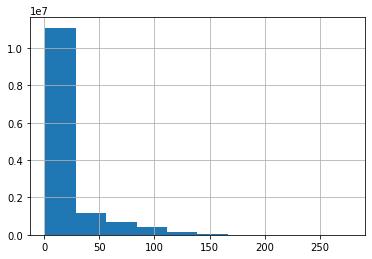

In [99]:
# View statistics about int64 columns
dataframe_analysis(installments, "int64", table_name="installments_payments.csv")

#### <b> EDA for *object (string)* columns

In [101]:
# View statistics about object columns
dataframe_analysis(installments, "object", table_name="installments_payments.csv")

## <b>Feature creation

For feature creation I will use ***Featuretools*** which is an open-source Python library for automatically creating features out of a set of related tables.

In [102]:
# Entity set
es = ft.EntitySet(id="client")

In [103]:
# Add dataframes to the entity set
es = es.add_dataframe(dataframe_name="applications", 
                      dataframe=app, 
                      index="SK_ID_CURR")
es = es.add_dataframe(dataframe_name="bureau", 
                      dataframe=bureau, 
                      index="SK_ID_BUREAU")
es = es.add_dataframe(dataframe_name="previous",
                      dataframe=previous,
                      index="SK_ID_PREV")

# Entities that do not have a unique index
es = es.add_dataframe(dataframe_name="bureau_balance", 
                      dataframe=bureau_balance, 
                      make_index=True,
                      index="bureau_balance_index")
es = es.add_dataframe(dataframe_name="credit",
                      dataframe=credit,
                      make_index=True,
                      index="credit_index")
es = es.add_dataframe(dataframe_name="cash",
                      dataframe=cash,
                      make_index=True,
                      index="cash_index")
es = es.add_dataframe(dataframe_name="installments",
                      dataframe=installments,
                      make_index=True,
                      index="installments_index")

In [104]:
# Add relationships
es = es.add_relationships([
    ("applications", "SK_ID_CURR", "bureau", "SK_ID_CURR"),
    ("applications", "SK_ID_CURR", "previous", "SK_ID_CURR"),
    ("bureau", "SK_ID_BUREAU", "bureau_balance", "SK_ID_BUREAU"),
    ("previous", "SK_ID_PREV", "installments", "SK_ID_PREV"),
    ("previous", "SK_ID_PREV", "credit", "SK_ID_PREV"),
    ("previous", "SK_ID_PREV", "cash", "SK_ID_PREV")
])

In [105]:
es

Entityset: client
  DataFrames:
    applications [Rows: 307511, Columns: 121]
    bureau [Rows: 1716428, Columns: 17]
    previous [Rows: 1670214, Columns: 37]
    bureau_balance [Rows: 27299925, Columns: 4]
    credit [Rows: 3840312, Columns: 24]
    cash [Rows: 10001358, Columns: 9]
    installments [Rows: 13605401, Columns: 9]
  Relationships:
    bureau.SK_ID_CURR -> applications.SK_ID_CURR
    previous.SK_ID_CURR -> applications.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV
    cash.SK_ID_PREV -> previous.SK_ID_PREV

In [114]:
# View aggregation primitives
primitives = ft.primitives.list_primitives()
print("Aggregation type primitives:")
primitives[primitives['type'] == 'aggregation'].drop(["type"], axis=1)

Aggregation type primitives:


,name,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,entropy,False,False,Calculates the entropy for a categorical column,<ColumnSchema (Semantic Tags = ['category'])>,None
1,any,True,False,Determines if any value is 'True' in a list.,<ColumnSchema (Logical Type = BooleanNullable)...,None
2,max,True,True,"Calculates the highest value, ignoring `NaN` v...",<ColumnSchema (Semantic Tags = ['numeric'])>,None
3,mode,False,False,Determines the most commonly repeated value.,<ColumnSchema (Semantic Tags = ['category'])>,None
4,trend,False,False,Calculates the trend of a column over time.,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",None
5,avg_time_between,False,False,Computes the average number of seconds between...,<ColumnSchema (Logical Type = Datetime) (Seman...,None
6,num_true,True,False,Counts the number of `True` values.,<ColumnSchema (Logical Type = BooleanNullable)...,None
7,count,True,True,"Determines the total number of values, excludi...",<ColumnSchema (Semantic Tags = ['index'])>,None
8,time_since_first,False,False,Calculates the time elapsed since the first da...,<ColumnSchema (Logical Type = Datetime) (Seman...,None
9,n_most_common,False,False,Determines the `n` most common elements.,<ColumnSchema (Semantic Tags = ['category'])>,None


In [116]:
# View transformation primitives
print("Transform type primitives:")
primitives[primitives['type'] == 'transform'].drop(["type"], axis=1)

Transform type primitives:


,name,dask_compatible,spark_compatible,description,valid_inputs,return_type
22,divide_numeric_scalar,True,True,Divide each element in the list by a scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
23,is_null,True,True,Determines if a value is null.,<ColumnSchema>,None
24,hour,True,True,Determines the hour value of a datetime.,<ColumnSchema (Logical Type = Datetime)>,None
25,not_equal,True,False,Determines if values in one list are not equal...,<ColumnSchema>,None
26,latitude,False,False,Returns the first tuple value in a list of Lat...,<ColumnSchema (Logical Type = LatLong)>,None
27,week,True,True,Determines the week of the year from a datetime.,<ColumnSchema (Logical Type = Datetime)>,None
28,subtract_numeric_scalar,True,True,Subtract a scalar from each element in the list.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
29,num_characters,True,True,Calculates the number of characters in a string.,<ColumnSchema (Logical Type = NaturalLanguage)>,None
30,multiply_numeric_boolean,True,False,Element-wise multiplication of a numeric list ...,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",None
31,less_than_scalar,True,True,Determines if values are less than a given sca...,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",None


## <b>Deep Feature Synthesis with default primitives

In [117]:
# Primitive to be used
aggregation_primitives = ["min", "count", "max", "std", "mean"]
transform_primitives = ["percentile"]

In [118]:
# Generate feature names 
t0 = time()
features_name = ft.dfs(entityset=es, 
                       target_dataframe_name="applications",
                       trans_primitives=transform_primitives,
                       agg_primitives=aggregation_primitives, 
                       max_depth=2,
                       features_only=True)
print(f"It took {(time()-t0):.0f} seconds")
print(f"Number of features created is {len(features_name)}")

It took 0 seconds
Number of features created is 1635


In [119]:
# Generate feature matrix
t0 = time()
feature_matrix, features_name = ft.dfs(entityset=es, 
                       target_dataframe_name="applications",
                       trans_primitives=transform_primitives,
                       agg_primitives=aggregation_primitives, 
                       max_depth=2,
                       features_only=False,
                       verbose=True)

Built 1635 features
Elapsed: 11:35 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [120]:
feature_matrix.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,PERCENTILE(STD(cash.SK_DPD)),PERCENTILE(STD(cash.SK_DPD_DEF)),PERCENTILE(STD(cash.SK_ID_CURR)),PERCENTILE(STD(credit.AMT_BALANCE)),PERCENTILE(STD(credit.AMT_CREDIT_LIMIT_ACTUAL)),PERCENTILE(STD(credit.AMT_DRAWINGS_ATM_CURRENT)),PERCENTILE(STD(credit.AMT_DRAWINGS_CURRENT)),PERCENTILE(STD(credit.AMT_DRAWINGS_OTHER_CURRENT)),PERCENTILE(STD(credit.AMT_DRAWINGS_POS_CURRENT)),PERCENTILE(STD(credit.AMT_INST_MIN_REGULARITY)),PERCENTILE(STD(credit.AMT_PAYMENT_CURRENT)),PERCENTILE(STD(credit.AMT_PAYMENT_TOTAL_CURRENT)),PERCENTILE(STD(credit.AMT_RECEIVABLE_PRINCIPAL)),PERCENTILE(STD(credit.AMT_RECIVABLE)),PERCENTILE(STD(credit.AMT_TOTAL_RECEIVABLE)),PERCENTILE(STD(credit.CNT_DRAWINGS_ATM_CURRENT)),PERCENTILE(STD(credit.CNT_DRAWINGS_CURRENT)),PERCENTILE(STD(credit.CNT_DRAWINGS_OTHER_CURRENT)),PERCENTILE(STD(credit.CNT_DRAWINGS_POS_CURRENT)),PERCENTILE(STD(credit.CNT_INSTALMENT_MATURE_CUM)),PERCENTILE(STD(credit.MONTHS_BALANCE)),PERCENTILE(STD(credit.SK_DPD)),PERCENTILE(STD(credit.SK_DPD_DEF)),PERCENTILE(STD(credit.SK_ID_CURR)),PERCENTILE(STD(installments.AMT_INSTALMENT)),PERCENTILE(STD(installments.AMT_PAYMENT)),PERCENTILE(STD(installments.DAYS_ENTRY_PAYMENT)),PERCENTILE(STD(installments.DAYS_INSTALMENT)),PERCENTILE(STD(installments.NUM_INSTALMENT_NUMBER)),PERCENTILE(STD(installments.NUM_INSTALMENT_VERSION)),PERCENTILE(STD(installments.SK_ID_CURR)),PERCENTILE(STD(previous.AMT_ANNUITY)),PERCENTILE(STD(previous.AMT_APPLICATION)),PERCENTILE(STD(previous.AMT_CREDIT)),PERCENTILE(STD(previous.AMT_DOWN_PAYMENT)),PERCENTILE(STD(previous.AMT_GOODS_PRICE)),PERCENTILE(STD(previous.CNT_PAYMENT)),PERCENTILE(STD(previous.DAYS_DECISION)),PERCENTILE(STD(previous.DAYS_FIRST_DRAWING)),PERCENTILE(STD(previous.DAYS_FIRST_DUE)),PERCENTILE(STD(previous.DAYS_LAST_DUE)),PERCENTILE(STD(previous.DAYS_LAST_DUE_1ST_VERSION)),PERCENTILE(STD(previous.DAYS_TERMINATION)),PERCENTILE(STD(previous.HOUR_APPR_PROCESS_START)),PERCENTILE(STD(previous.NFLAG_INSURED_ON_APPROVAL)),PERCENTILE(STD(previous.NFLAG_LAST_APPL_IN_DAY)),PERCENTILE(STD(previous.RATE_DOWN_PAYMENT)),PERCENTILE(STD(previous.RATE_INTEREST_PRIMARY)),PERCENTILE(STD(previous.RATE_INTEREST_PRIVILEGED)),PERCENTILE(STD(previous.SELLERPLACE_AREA))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,...,0.41,0.43,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56,0.55,0.35,0.35,0.73,0.44,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03

In [121]:
feature_matrix.to_csv("./data/ft_1635_columns", index=False)
print("Successfuly saved to disk")

Successfuly saved to disk


## <b>Test performance after feature creation:

In [4]:
# Load data
feature_matrix = pd.read_csv("./data/ft_1635_columns.csv")
labels = pd.read_csv("./data/applications.csv").TARGET

In [5]:
# OneHot Encoding
feature_matrix = pd.get_dummies(feature_matrix)

# Rename columns according to LGBMClassifier requirments
feature_matrix = feature_matrix.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
labels = pd.read_csv("./data/applications.csv").TARGET

In [7]:
# There are some errors with datatype in the feature_matrix dataframe
# Will change all columns datatype to float64. Not 
# Not the most efficient solution from memory standpoint but certainly fast and effective.
feature_matrix = feature_matrix.astype("float64")
feature_matrix.dtypes.unique()

In [9]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(feature_matrix,
                                                    labels,
                                                    random_state=1,
                                                    test_size=0.1,
                                                    stratify=labels)
                                                    
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((276759, 1759), (30752, 1759), (276759,), (30752,))

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=feature_matrix.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=feature_matrix.columns)

In [11]:
for col in x_train.columns:
    col_mean = x_train[col].mean()
    x_train[col] = x_train[col].fillna(col_mean)
    x_test[col] = x_test[col].fillna(col_mean)

In [26]:
# Split in train and validation datasets. 
# Will do hold-out validation for faster training
# This will not affect final performance
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t.columns)} features the model scored: {model.best_score_['validation']['auc']}")

On 1759 features the model scored: 0.7739042440484816


0.7739 is much better than previous score of 0.7550

<a id=7></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#00afb9;overflow:hidden;font-weight:500">7. Feature Selection</div>

[go on top ↑](#0)

## <b>Drop zero imporance features

In [27]:
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 1759), (55352, 1759), (221407,), (55352,))

In [28]:
# Count number of zero importance features
zero_importance =[]
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] == 0:
        zero_importance.append(model.feature_name_[i])
len(zero_importance)

982

In [29]:
# Drop zero importance features
x_t.drop(zero_importance, axis=1, inplace=True)
x_v.drop(zero_importance, axis=1, inplace=True)

In [30]:
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 777), (55352, 777), (221407,), (55352,))

## Drop till 50 features

Iteratively, will train the model and will drop 3 least important features till 
I will get to 50 features

In [31]:
all_valid_auc = []
train_columns = dict()

t0 = time()
while len(x_t.columns)>50:
    model = LGBMClassifier(random_state=1, n_jobs=10)
    model = model.fit(X=x_t, 
                      y=y_t, 
                      eval_metric="auc",
                      eval_set=[(x_t, y_t), (x_v, y_v)],
                      eval_names=["train", "validation"],
                      early_stopping_rounds=100,
                      verbose=0)
    all_valid_auc.append(model.best_score_['validation']['auc'])
    
    feateure_importance = pd.DataFrame(model.feature_importances_, index=model.feature_name_)
    feateure_importance.sort_values(ascending=True, by=0, inplace=True)
    
    # Drop 3 least important columns
    for i in range(0, 4):
        x_t.drop(feateure_importance.index[i], axis=1, inplace=True)
        x_v.drop(feateure_importance.index[i], axis=1, inplace=True)    
        
    train_columns[len(x_t.columns)] = x_t.columns
    
print(f"Training took {(time()-t0):.0f} seconds")

Training took 1807 seconds


Text(0, 0.5, 'AUC on validation data')

Text(0.5, 0, 'Number of features used by algorithm')

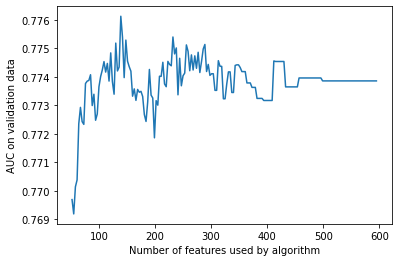

In [32]:
# Plot data
n_removed_features = np.arange((len(all_valid_auc)*3)+len(x_t.columns), len(x_t.columns), -3)
plt.plot(n_removed_features, all_valid_auc)
plt.ylabel("AUC on validation data")
plt.xlabel("Number of features used by algorithm")
plt.show()

In [51]:
# I will choose 145 features because it will provide best performance/efficiency
x_train_145_features = x_train[train_columns[145]]
x_test_145_features = x_test[train_columns[145]]
x_train_145_features.shape, x_test_145_features.shape

((276759, 145), (30752, 145))

In [53]:
# Test performance on 125 features
x_t, x_v, y_t, y_v = train_test_split(x_train_145_features, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t.columns)} features the model scored: {model.best_score_['validation']['auc']}")

On 145 features the model scored: 0.7748425210232948


We have decreased number of features from 1759 to 145 and the AUC has increased from 0.7739 to 0.7748.
This will result in better predictions and faster training/inference time.

In [60]:
# Safe to disk:
x_train_145_features.to_csv("./data/x_train_145_features.csv", index=False)
x_test_145_features.to_csv("./data/x_test_145_features.csv", index=False)
y_train.to_csv("./data/y_train_145_features.csv", index=False)
y_test.to_csv("./data/y_test_145_features.csv", index=False)

<a id=8></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bc4b51;overflow:hidden;font-weight:500"><b>8. PCA - Dimensionality Reduction</div>

[go on top ↑](#0)

Lets try PCA and see how it will affect performance of algrithm.

## PCA before removing 0 importance features

In [69]:
# Remove columns with NaN
nan_columns = []
for col in x_train.columns:
    if x_train[col].isna().sum()>0:
        nan_columns.append(col)
x_train.drop(nan_columns, axis=1, inplace=True)

In [70]:
# Try PCA with 0.99 variance to be kept
pca = PCA(0.99)
x_train_pca = pca.fit_transform(x_train)

In [73]:
# Number of remaining features
len(x_train_pca[1])

524

In [77]:
# Check algorithm accuracy
x_t, x_v, y_t, y_v = train_test_split(x_train_pca, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
model = LGBMClassifier(random_state=1, n_jobs=10)
model = model.fit(X=x_t,
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t[1])} features after PCA(0.99) the model scored: {model.best_score_['validation']['auc']}")

On 524 features after PCA(0.99) the model scored: 0.7472551449724291


Notice a performance decrease from prior feature selection (i.e. 0.7748)

## <b>PCA (drop zero importance variables)

Train algorithm on all 1700 features, drop the ones that have zero importance, then perform PCA

In [78]:
# Split data
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 1751), (55352, 1751), (221407,), (55352,))

In [80]:
# Initial training to get feature importance
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t, y_t), (x_v, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)

# Count number of zero importance features
zero_importance =[]
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] == 0:
        zero_importance.append(model.feature_name_[i])
print(f"There are {len(zero_importance)} features with zero importance")

# Drop zero importance features
x_t.drop(zero_importance, axis=1, inplace=True)
x_v.drop(zero_importance, axis=1, inplace=True)

There are 974 features with zero importance


In [82]:
# Print shape after dropping features with zero importance
x_t.shape, x_v.shape, y_t.shape, y_v.shape

((221407, 777), (55352, 777), (221407,), (55352,))

In [83]:
# PCA 
pca = PCA(0.99).fit(x_t)
x_t_pca = pca.transform(x_t)
x_v_pca = pca.transform(x_v)
x_t_pca.shape, x_v_pca.shape

((221407, 336), (55352, 336))

In [86]:
# Try AUC score with PCA and dropped zero importance features
model = LGBMClassifier(random_state=1)
model = model.fit(X=x_t_pca, 
                  y=y_t, 
                  eval_metric="auc",
                  eval_set=[(x_t_pca, y_t), (x_v_pca, y_v)],
                  eval_names=["train", "validation"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"On {len(x_t_pca[1])} features the model scored: {model.best_score_['validation']['auc']}")

On 336 features the model scored: 0.7499692060309273


Removing zero-importance features before PCA resulted in a slight increase in performance compared to PCA on all features (AUC =  0.7472), but it is still well below performance of simple feature selection  (i.e. 0.7748)

<a id=9></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#9a031e;overflow:hidden;font-weight:500"><b>9. Hyperparameter Tunning</b></div>

[go on top ↑](#0)

In [88]:
# Split data
x_t, x_v, y_t, y_v = train_test_split(x_train_145_features, 
                                      y_train, 
                                      random_state=1,
                                      test_size=0.2, 
                                      stratify=y_train)

In [89]:
# Hyperparameter tunning with optuna

def objective(trial):
    params = {
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("n_estimators", 8, 2048),
        "max_depth":  trial.suggest_int("max_depth", 2, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1),
    }
    
    model = LGBMClassifier(**params, random_state=1, n_jobs=10)
    model = model.fit(X=x_t, 
                      y=y_t, 
                      eval_metric="auc",
                      eval_set=[(x_t, y_t), (x_v, y_v)],
                      eval_names=["train", "validation"],
                      early_stopping_rounds=100,
                      verbose=0)
    return model.best_score_['validation']['auc']

optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=256)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.7809127904239439
  Params: 
    lambda_l1: 3.286140772628291e-06
    lambda_l2: 6.563020721989631e-06
    num_leaves: 21
    feature_fraction: 0.5146629043698071
    bagging_fraction: 0.6438235921042906
    bagging_freq: 2
    min_child_samples: 91
    n_estimators: 1435
    max_depth: 57
    learning_rate: 0.01839560050173244


In [90]:
hyperparameter_importange = optuna.importance.get_param_importances(study)

In [91]:
hyperparameter_importange

OrderedDict([('learning_rate', 0.9565289438541278),
             ('num_leaves', 0.017835663026582356),
             ('feature_fraction', 0.010577490718783202),
             ('min_child_samples', 0.006763687663353062),
             ('max_depth', 0.003970944849042695),
             ('n_estimators', 0.0026129248233443814),
             ('bagging_fraction', 0.0009990703133264868),
             ('bagging_freq', 0.000686250185585807),
             ('lambda_l2', 2.2001548740790435e-05),
             ('lambda_l1', 3.023017113416916e-06)])

<a id=10></a><div style="padding:15px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#4c5c68;overflow:hidden;font-weight:500"><b>10. Final testing</b></div>

[go on top ↑](#0)

In [96]:
params = trial.params

In [98]:
model = LGBMClassifier(**params, random_state=1, n_jobs=10)
model = model.fit(X=x_train_145_features, 
                  y=y_train, 
                  eval_metric="auc",
                  eval_set=[(x_train_145_features, y_train), (x_test_145_features, y_test)],
                  eval_names=["train", "test"],
                  early_stopping_rounds=100,
                  verbose=0)
print(f"Model performance on test data: {model.best_score_['test']['auc']}")

Model performance on test data: 0.790634099559626


Final performance is slightly increased from 0.7748 to 0.7906 due to the fact that the model was trained on all training data, with no holdout for validation.